I feel I have exhausted my efforts with random forests(which is not true), so here I will try various implentation of gradient Boosting trees from sklearn, XGBoost, LightGBM with differet feature selection measures, include feature interactions, deal with outliers and may be finally if it requires we can stack models. 

In [1]:
!pip install tqdm
!pip install xgboost

    100% |████████████████████████████████| 61kB 4.4MB/s 
    100% |████████████████████████████████| 460kB 1.9MB/s 
  Running setup.py bdist_wheel for xgboost ... - \ | / - \ done
  Stored in directory: /content/.cache/pip/wheels/ca/b3/02/d44d5e12c5c1eecff4a822555bac96b182551cd5e13c4795f6
Successfully built xgboost


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.ensemble import GradientBoostingRegressor, IsolationForest
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import plot_importance

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from tqdm import tqdm
import time, operator
%matplotlib inline
rs = 100

In [0]:
train = pd.read_csv('drive/workspace/data/merc/train.csv')
test = pd.read_csv('drive/workspace/data/merc/test.csv')

In [0]:
cat_feat = list(train.select_dtypes(include=['object']).columns)
num_feat = list(train.select_dtypes(include=[np.number]).drop(['y'], axis=1).columns)

In [5]:
len(cat_feat), len(num_feat)

(8, 369)

So here cat_feat contains all categorical features, and num_feat has all numerical features excluding the target y. 

## Utility functions

Some of the utility functions are same as from nb2 but still here I am writing them again. 

In [0]:
def val_r2_score(estimator, X, y, n_splits=5, n_repeats=10, random_state=rs):
  val_scores = np.array([])
  trn_scores = np.array([])
  for i in tqdm(range(n_repeats)):
    kf = KFold(n_splits, True, random_state=rs+i)
    for ti, vi in kf.split(X):
      X_trn, X_val = X.iloc[ti], X.iloc[vi]
      y_trn, y_val = y.iloc[ti], y.iloc[vi]
      estimator.fit(X_trn, y_trn)
      val_scores = np.append(val_scores, r2_score(y_val, estimator.predict(X_val)))
      trn_scores = np.append(trn_scores, r2_score(y_trn, estimator.predict(X_trn)))
  return (val_scores.reshape((n_repeats, n_splits)), trn_scores.reshape( n_repeats, n_splits))

In [0]:
def me_val_r2_score(estimator, train, columns, n_splits=5, n_repeats=2, random_state=rs):
  val_scores = np.array([])
  for i in tqdm(range(n_repeats)) : 
    kf1 = KFold(n_splits=n_splits, shuffle=True, random_state=rs+i)
    for ti, vi in kf1.split(train):
      ttrain, vtrain = train.iloc[ti], train.iloc[vi]
      for col in columns: 
        means = ttrain.groupby(col)['y'].mean()
        ttrain[col+'_mt'] = ttrain[col].map(means)
        vtrain[col+'_mt'] = vtrain[col].map(means)
      
      vtrain.fillna(ttrain['y'].mean(), inplace=True)
      X_trn = ttrain
      X_val = vtrain
      
      kf2 = KFold(n_splits=5, shuffle=True, random_state=rs)
      for tind, vind in kf2.split(ttrain) : 
        ttrn, vtrn = ttrain.iloc[tind], ttrain.iloc[vind]
        for col in columns : 
          means = ttrn.groupby(col)['y'].mean()
          vtrn[col+'_mt'] = vtrn[col].map(means)
        X_trn.iloc[vind] = vtrn

      X_trn.fillna(ttrain['y'].mean(), inplace=True)
      
      _=estimator.fit(X_trn.drop(['y']+columns, axis=1), X_trn['y'])
      val_scores = np.append(val_scores, r2_score(X_val['y'], estimator.predict(X_val.drop(['y']+columns, axis=1))))
  return val_scores.reshape(n_repeats, n_splits)


In [0]:
# This function return a list of mean encoded validation and train dataframes to be used in me_r2_score function
# to calculate r2_scores for each. 
def me_df(train, n_splits=4, n_repeats=10, random_state=rs):
  trns = []
  vals = []
  for i in tqdm(range(n_repeats)):
    kf1 = KFold(n_splits, True, random_state=rs+i)
    for ti, vi in kf1.split(train):
      ttrain, vtrain = train.iloc[ti], train.iloc[vi]
      for col in cat_feat:
        means = ttrain.groupby(col)['y'].mean()
        ttrain[col+'_mt'] = ttrain[col].map(means)
        vtrain[col+'_mt'] = vtrain[col].map(means)
      vtrain.fillna(ttrain['y'].mean(), inplace=True)
      
      X_trn = ttrain.copy()
      X_val = vtrain.copy()
      
      kf2 = KFold(5, True, random_state=rs)
      for tind, vind in kf2.split(ttrain):
        ttrn, vtrn = ttrain.iloc[tind], ttrain.iloc[vind]
        for col in cat_feat:
          means = ttrn.groupby(col)['y'].mean()
          vtrn[col+'_mt'] = vtrn[col].map(means)
        X_trn.iloc[vind] = vtrn
      X_trn.fillna(ttrain['y'].mean(), inplace=True)
      trns.append(X_trn)
      vals.append(X_val)
  return trns, vals


def me_r2_score(estimator, trns, vals, me_cols, drop_feat=[], random_state=rs):
  val_scores=[]
  ohe_cols = [col for col in cat_feat if col not in me_cols]
  for trn, val in tqdm(zip(trns, vals)) : 
    trn = trn.drop(me_cols, axis=1)
    val = val.drop(me_cols, axis=1)
    for col in ohe_cols : 
      trn = trn.drop([col+'_mt'], axis=1)
      val = val.drop([col+'_mt'], axis=1)
    if len(ohe_cols) : 
      trn = pd.get_dummies(trn, columns=ohe_cols)
      val = pd.get_dummies(val, columns=ohe_cols)
        
    if len(drop_feat) :
      trn = trn.drop([f for f in drop_feat if f in list(trn.columns)], axis=1)
      val = val.drop([f for f in drop_feat if f in list(val.columns)], axis=1)
    
    _=estimator.fit(trn.drop(['y'],  axis=1), trn['y'])
    preds = estimator.predict(val.drop(['y'], axis=1))
    
    val_scores.append(r2_score(val['y'], preds))
  return val_scores
    


In [0]:
def validation_curve(estimator, trn, val, me_cols=cat_feat, drop_feat=[]):
    
    ohe_cols = [c for c in cat_feat if c not in me_cols]
    trn = trn.drop(me_cols, axis=1)
    val = val.drop(me_cols, axis=1)
    for col in ohe_cols : 
      trn = trn.drop([col+'_mt'], axis=1)
      val = val.drop([col+'_mt'], axis=1)
    if len(ohe_cols) : 
      trn = pd.get_dummies(trn, columns=ohe_cols)
      val = pd.get_dummies(val, columns=ohe_cols)
        
    if len(drop_feat) :
      trn = trn.drop([f for f in drop_feat if f in list(trn.columns)], axis=1)
      val = val.drop([f for f in drop_feat if f in list(val.columns)], axis=1)
    
    X_train = trn.drop(['y'], axis=1)
    X_val = val.drop(['y'], axis=1)
    y_train = trn['y']
    y_val = val['y']
    
    _ = estimator.fit(X_train, y_train)
    
    test_score = np.empty(len(estimator.estimators_))
    train_score = np.empty(len(estimator.estimators_))
    
    for i, pred in enumerate(estimator.staged_predict(X_val)):
        test_score[i] = r2_score(y_val, pred)

    for i, pred in enumerate(estimator.staged_predict(X_train)):
        train_score[i] = r2_score(y_train, pred)

    best_iter = np.argmax(test_score)
    
#     Uncommment the following lines to see a plot. 
    
    
#     test_line = plt.plot(test_score, label='test')

#     colour = test_line[-1].get_color()
#     plt.plot(train_score, '--', color=colour, label='train')

#     plt.xlabel("Number of boosting iterations")
#     plt.ylabel("R2 score")
#     plt.legend(loc='best')
#     plt.axvline(x=best_iter, color=colour)
    return best_iter

In [0]:
def get_trn_val(trn, val, drop_feat):
  X_trn = trn.drop(drop_feat, axis=1)
  y_trn = trn['y']
  X_val = val.drop(drop_feat, axis=1)
  y_val = val['y']

  dtrn = xgb.DMatrix(X_trn, label=y_trn)
  dval = xgb.DMatrix(X_val, label=y_val)
  return dtrn, dval

In [0]:
def xgb_r2_score(preds, dtrain):
  labels = dtrain.get_label()
  return 'r2_score', r2_score(labels, preds)

In [0]:
def is_outlier(points, threshold=3.5):
  median = np.median(points)
  diff = np.sqrt((points-median)**2)
  mad = np.median(diff)
  
  modified_z_score = 0.6745 * diff/ mad
  return modified_z_score, (modified_z_score>threshold)
  

## Feature Selection 

First let's try to mark out features which have little variance ie which have fews ones. 

In [0]:
low_var_feat = ['X4', 'X4_mt']
var_df = pd.DataFrame([train[col].sum() for col in num_feat], index=num_feat, columns=[ 'ones'])
var_df.sort_values(by='ones', inplace=True)

In [14]:
var_df[var_df['ones']<50].shape
low_var_feat.extend(list(var_df[var_df['ones']<50].index))
len(low_var_feat)

(153, 1)

155

So there are 153 such columns which have less than 50 ones out of 4209. So we added them to drop list. Next we check if there are some duplicates. 

In [0]:
d_trn= train.T.drop_duplicates().T
dup_feat = [f for f in train if f not in d_trn]

In [16]:
print (len(dup_feat))

56


In [0]:
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))

## Scikit Learn

Let's start with sklearn's implementation of GBM. 

In [0]:
X = train.drop(['y'], axis=1)
X = pd.get_dummies(X, columns=cat_feat)
y = train['y']

In [0]:
gbr = GradientBoostingRegressor()
val_scores, trn_scores = train_val_r2_score(gbr, X, y)

In [0]:
print(val_scores.mean(), val_scores.std())
print (trn_scores.mean(), trn_scores.std())
print (val_scores)

I will train a full vanilla GBM model and submit to see how it fares on leaderboard compared our score here. 

In [0]:
X_test = pd.get_dummies(test, columns=cat_feat)
X_test.shape, X.shape

So there are some columns(ie some level of categorical columns) that are in test in not in train. So for the columns only in train we add them to test and for columns only in test we drop them. 

In [0]:
col1 = [f for f in X_test.columns if f not in X.columns]
col2 = [f for f in X.columns if f not in X_test.columns]
len(col1), len(col2)

In [0]:
# We drop col1 from X_test and add col2 to X_test
X_test = X_test.drop(col1, axis=1)
new_df = pd.DataFrame(np.zeros((X_test.shape[0],len(col2))), index=X_test.index, columns=col2)
X_test = pd.concat([X_test, new_df], axis=1)
X_test.shape, X.shape

In [0]:
gbr = GradientBoostingRegressor()
gbr.fit(X,y)
y_pred = gbr.predict(X_test)

In [0]:
subm = np.stack((X_test.ID, y_pred), axis=1)
np.savetxt('drive/workspace/data/merc/subm18.csv', subm, delimiter=',', header='ID,y', comments='', fmt=['%d','%.6f'])

Public LB : 0.52614, PrivateLB : 0.52965

Next instead of one hot encoding, we will target_encode our categories and then tune the GBM parameters. 

So first we get a list of trains and validation dataframes from multiple repeats of KFold in mean-encoded form, so that we don't have to to geenrate them everytime we test a new model with changed parameters. 


In [0]:
n_splits=4
n_repeats=10
trns, vals = me_df(train, n_splits, n_repeats)

In [0]:
gbr = GradientBoostingRegressor()
val_scores = np.array(me_r2_score(gbr, trns, vals, cat_feat)).reshape((n_repeats, n_splits))

In [0]:
print (val_scores.mean(), val_scores.std())

Let's tune our gbr model. 

First we will figure out the n_estimators for a sufficiently high learning rate. For this n_estimators and learning rate we tune other parameters and later we can lower learning rate and increase n_estimators. 

In [0]:
trns, vals = me_df(train)

In [0]:
params = dict(n_estimators=500, max_depth=5, max_features='sqrt', learning_rate=0.1, subsample=.8, random_state=rs)
gbr = GradientBoostingRegressor(**params)

In [0]:
# validation_curve(gbr, trns[1], vals[1])
best_iters = []
for trn, val in tqdm(zip(trns, vals)): 
  best_iters.append(validation_curve(gbr, trn, val))

In [0]:
print (np.array(best_iters).mean(), np.array(best_iters).std())

So we have n_estimators=53 where we have highest val_score for learning rate=0.1 . So we will stick with that and tune other params. Later we will also  delve into feature selection. Before we tune let's see if we improve scores by dropping near zero variance features. So we drop features from dup_feat and low_var_feat. 



In [0]:
n_splits=4
n_repeats=10
trns, vals = me_df(train, n_splits, n_repeats)

In [0]:
gbr = GradientBoostingRegressor(random_state=rs)
val_scores = np.array(me_r2_score(gbr, trns, vals, cat_feat, drop_feat=list(set(low_var_feat+dup_feat)))).reshape((n_repeats, n_splits))

In [0]:
print (val_scores.mean(), val_scores.std())

Just miniscule improvement in score. Again let's find an optimal value for n_estimators. 

In [0]:
params = dict(n_estimators=300, random_state=rs)
gbr = GradientBoostingRegressor(**params)

In [0]:
best_iters = []
for trn, val in tqdm(zip(trns, vals)): 
  best_iters.append(validation_curve(gbr, trn, val, drop_feat=list(set(low_var_feat+dup_feat))))

In [0]:
print (np.array(best_iters).mean(), np.array(best_iters).std())

Too high deviation. Let's take optimal value to be 70 so that we don't underfit and find scores. 

In [0]:
gbr = GradientBoostingRegressor(n_estimators=70, random_state=rs)
val_scores = np.array(me_r2_score(gbr, trns, vals, cat_feat, drop_feat=list(set(low_var_feat+dup_feat)))).reshape((n_repeats, n_splits))

In [0]:
print (val_scores.mean(), val_scores.std())

No doubt there is some improvement, but this high variation is bugging me. Anyway let's submit this and see. 

In [0]:
me_cols = cat_feat
train_new = train.copy()
test_new = test.copy()
for col in me_cols : 
  means = train_new.groupby(col)['y'].mean()
  train_new[col+'_mt'] = train_new[col].map(means)
  test_new[col+'_mt'] = test_new[col].map(means)

test_new.fillna(train_new['y'].mean(), inplace=True)
 

In [0]:
# let's regularise train_new

train_new1 = train_new.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
for ti, vi in kf.split(train_new):
  trn, val = train_new.iloc[ti], train_new.iloc[vi]
  for col in me_cols:
    means = trn.groupby(col)['y'].mean()
    val[col+'_mt'] = val[col].map(means)
  train_new1.iloc[vi] = val
train_new1.fillna(train_new['y'].mean(), inplace=True)
    

In [0]:
feat_to_drop = list(set(['y'] + cat_feat + dup_feat + low_var_feat))
X_trn = train_new1.drop(feat_to_drop, axis=1)
y_trn = train_new1['y']
X_test = test_new[X_trn.columns]

In [0]:
gbr = GradientBoostingRegressor(n_estimators=70, random_state=rs)
gbr.fit(X_trn, y_trn)
y_pred = gbr.predict(X_test)

In [0]:
subm = np.stack((test.ID, y_pred), axis=1)
np.savetxt('drive/workspace/data/merc/subm19.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

Private LB : 0.54652  Public LB : 0.55235 . Okay decent score, and may be we will improve as we tune this model. 

#### max_depth

So a defaut max_depth of 3 was used previously. 

In [0]:
trns, vals = me_df(train)

In [0]:
max_depth = [2,5]
val_scores = np.empty(shape=(len(max_depth),len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in range(len(max_depth)) : 
  gbr = GradientBoostingRegressor(n_estimators=70, random_state=rs, max_depth=max_depth[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat=drop_feat)

In [0]:
val_scores.mean(axis=1)
val_scores.std(axis=1)

In [0]:
gbr = GradientBoostingRegressor(n_estimators=70, max_depth=1, random_state=rs)
val_scores = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

In [0]:
np.array(val_scores).mean(), np.array(val_scores).std()

Looks like max_depth=2 gives the highest r2_score though with a high variation. Next we will tune min_samples_split. 

#### min_samples_split

In [0]:
min_samples_split = [5,8,12]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_split = [15,20,25]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_split = [30, 35, 40]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_split = [45, 55, 70]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_split = [80, 100, 130]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_split = [120, 135, 150]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_split = [170, 200]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_split = [250, 300, 400]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_split = [500, 650, 800]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_split = [900, 1000, 1200]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_split = [1500, 1800, 2200]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

This makes some sense now, since our max_depth is 2 so score starts decreasing at ver high values of min_sample_split. Anyway let's look deeper. 

In [0]:
min_samples_split = [1300, 1400, 1600]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_split = [1450, 1550]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_split = [1520, 1550, 2500]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_split))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=min_samples_split[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

  

In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

So min_samples_split=1500 seems to be the optimal value. Let's move on to min_samples_leaf. 

#### min_samples_leaf

In [0]:
min_samples_leaf = [50, 100, 200]
val_scores = np.empty(shape=(len(min_samples_split), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_leaf))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=1500, min_samples_leaf=min_samples_leaf[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_leaf = [5, 10]
val_scores = np.empty(shape=(len(min_samples_leaf), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_leaf))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=1500, min_samples_leaf=min_samples_leaf[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_leaf = [15, 22, 30]
val_scores = np.empty(shape=(len(min_samples_leaf), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_leaf))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=1500, min_samples_leaf=min_samples_leaf[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
min_samples_leaf = [3, 12, 14]
val_scores = np.empty(shape=(len(min_samples_leaf), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(min_samples_leaf))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=1500, min_samples_leaf=min_samples_leaf[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

So min_sample_leaf=1 gives the best score. Let's now tune subsample. 

#### subsample

In [0]:
subsample=[0.75, 0.8, 0.85, 0.9, 0.95]
val_scores = np.empty(shape=(len(subsample), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(subsample))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=1500, subsample=subsample[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
subsample=[0.88, 0.92, 9.94, 0.96]
val_scores = np.empty(shape=(len(subsample), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(subsample))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=1500, subsample=subsample[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

In [0]:
subsample=[0.93, 0.97]
val_scores = np.empty(shape=(len(subsample), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(subsample))):
  gbr = GradientBoostingRegressor(n_estimators=70, max_depth=2, random_state=rs, min_samples_split=1500, subsample=subsample[i])
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1), val_scores.std(axis=1)

subsample=1. Let's now decrease learning rate and increase n_estimators. 

#### learning_rate

In [0]:
val_scores = []
gbr = GradientBoostingRegressor(n_estimators=140, learning_rate=0.05, max_depth=2, random_state=rs, min_samples_split=1500)
val_scores = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

In [0]:
np.array(val_scores).mean()

In [0]:
val_scores = []
gbr = GradientBoostingRegressor(n_estimators=700, learning_rate=0.01, max_depth=2, random_state=rs, min_samples_split=1500)
val_scores = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

In [0]:
np.array(val_scores).mean()

In [0]:
val_scores = []
gbr = GradientBoostingRegressor(n_estimators=350, learning_rate=0.02, max_depth=2, random_state=rs, min_samples_split=1500)
val_scores = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

In [0]:
np.array(val_scores).mean()

In [0]:
val_scores = []
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.07, max_depth=2, random_state=rs, min_samples_split=1500)
val_scores = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

In [0]:

np.array(val_scores).mean()

In [0]:
val_scores = []
gbr = GradientBoostingRegressor(n_estimators=175, learning_rate=0.04, max_depth=2, random_state=rs, min_samples_split=1500)
val_scores = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

In [0]:
np.array(val_scores).mean()

In [0]:
val_scores = []
gbr = GradientBoostingRegressor(n_estimators=117, learning_rate=0.06, max_depth=2, random_state=rs, min_samples_split=1500)
val_scores = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)

In [0]:
np.array(val_scores).mean()

So lr=0.05. Since now our parameters are changes let's again find out the optimal n_estimators for the new tuned parameters using validation_curve function. 

In [0]:
gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=2, random_state=rs, min_samples_split=1500)
n_estimators=[]
for trn, val in tqdm(zip(trns, vals)):
  n_estimators.append(validation_curve(gbr, trn, val, drop_feat=drop_feat))


In [0]:
np.array(n_estimators).mean(), np.array(n_estimators).std()

See our n_estimators have increased, let's check score for other values of n_estimators. 

In [0]:
n_estimators=[140, 240, 300, 350, 400]
val_scores = np.empty(shape=(len(n_estimators), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(n_estimators))):
  gbr = GradientBoostingRegressor(n_estimators=n_estimators[i], learning_rate=0.05, max_depth=2, random_state=rs, min_samples_split=1500)
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1),val_scores.std(axis=1)

In [0]:
n_estimators=[120, 170]
val_scores = np.empty(shape=(len(n_estimators), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(n_estimators))):
  gbr = GradientBoostingRegressor(n_estimators=n_estimators[i], learning_rate=0.05, max_depth=2, random_state=rs, min_samples_split=1500)
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1),val_scores.std(axis=1)

In [0]:
n_estimators=[155, 165]
val_scores = np.empty(shape=(len(n_estimators), len(trns)))
drop_feat = list(set(low_var_feat+dup_feat))
for i in tqdm(range(len(n_estimators))):
  gbr = GradientBoostingRegressor(n_estimators=n_estimators[i], learning_rate=0.05, max_depth=2, random_state=rs, min_samples_split=1500)
  val_scores[i] = me_r2_score(gbr, trns, vals, cat_feat, drop_feat)


In [0]:
val_scores.mean(axis=1),val_scores.std(axis=1)

Looks like optimal value of n_estimators=155 for learning_rate=0.05 . 

Finally let's submit with following parameters : 
1. n_estimators=140
2. learning_rate=0.05
3. max_depth=2
4. min_sample_split=1500

In [0]:
me_cols = cat_feat
train_new = train.copy()
test_new = test.copy()
for col in me_cols : 
  means = train_new.groupby(col)['y'].mean()
  train_new[col+'_mt'] = train_new[col].map(means)
  test_new[col+'_mt'] = test_new[col].map(means)

test_new.fillna(train_new['y'].mean(), inplace=True)
 

In [0]:
# let's regularise train_new

train_new1 = train_new.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
for ti, vi in kf.split(train_new):
  trn, val = train_new.iloc[ti], train_new.iloc[vi]
  for col in me_cols:
    means = trn.groupby(col)['y'].mean()
    val[col+'_mt'] = val[col].map(means)
  train_new1.iloc[vi] = val
train_new1.fillna(train_new['y'].mean(), inplace=True)
    

In [0]:
feat_to_drop = list(set(['y'] + cat_feat + dup_feat + low_var_feat))
X_trn = train_new1.drop(feat_to_drop, axis=1)
y_trn = train_new1['y']
X_test = test_new[X_trn.columns]

In [0]:
gbr = GradientBoostingRegressor(n_estimators=155, learning_rate=0.05, max_depth=2, random_state=rs, min_samples_split=1500)
gbr.fit(X_trn, y_trn)
y_pred = gbr.predict(X_test)

In [0]:
subm = np.stack((test.ID, y_pred), axis=1)
np.savetxt('drive/workspace/data/merc/subm20.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

Public LB : 0.55443, Private=0.54789. This is the best score till now. 

## XGBoost

In [0]:
trns, vals = me_df(train, 5, 10)

In [0]:
params = {
    'silent' : 1, 
    'eta' : 0.1, 
    'eval_metric' : 'rmse'
}

We will try to tune following parameters. 
1. min_child_weight
2. max_depth
3. gamma
4. subsample
5. colsample_bytree
6. eta
7. num_boost_rounds

#### max_depth

In [0]:
depths = [2, 4, 7]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(depths),len(vals)))
trn_scores = np.empty(shape=(len(depths),len(trns)))
for i in tqdm(range(len(depths))) : 
  params['max_depth'] = depths[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score


In [0]:
s_time = time.time()
print (val_scores.shape, trn_scores.shape)
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))
print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
s_time = time.time()
depths = [1, 3]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(depths),len(vals)))
trn_scores = np.empty(shape=(len(depths),len(trns)))
for i in tqdm(range(len(depths))) : 
  params['max_depth'] = depths[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
print (val_scores.shape, trn_scores.shape)
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

In [0]:
params['max_depth']=2

So max_depth=2 seems to be optimal value. 

#### min_child_weight

In [0]:
s_time = time.time()

weights = [10, 50]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(depths),len(vals)))
trn_scores = np.empty(shape=(len(depths),len(trns)))
for i in tqdm(range(len(depths))) : 
  params['min_child_weight'] = weights[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

In [0]:
s_time = time.time()

weights = [5, 15]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(weights),len(vals)))
trn_scores = np.empty(shape=(len(weights),len(trns)))
for i in tqdm(range(len(weights))) : 
  params['min_child_weight'] = weights[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

In [0]:
s_time = time.time()

weights = [13, 20]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(weights),len(vals)))
trn_scores = np.empty(shape=(len(weights),len(trns)))
for i in tqdm(range(len(weights))) : 
  params['min_child_weight'] = weights[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

In [0]:
s_time = time.time()

weights = [11, 12, 14]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(weights),len(vals)))
trn_scores = np.empty(shape=(len(weights),len(trns)))
for i in tqdm(range(len(weights))) : 
  params['min_child_weight'] = weights[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

min_child_weight=13

In [0]:
params['min_child_weight'] = 13

#### gamma

In [0]:
s_time = time.time()

gammas = [20, 40]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(gammas),len(vals)))
trn_scores = np.empty(shape=(len(gammas),len(trns)))
for i in tqdm(range(len(gammas))) : 
  params['gamma'] = gammas[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

In [0]:
s_time = time.time()

gammas = [19.5, 20.2]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(gammas),len(vals)))
trn_scores = np.empty(shape=(len(gammas),len(trns)))
for i in tqdm(range(len(gammas))) : 
  params['gamma'] = gammas[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

Optimal value for gamma is 19. 

In [0]:
params['gamma'] = 19

#### subsample

In [0]:
s_time = time.time()

subsamples = [0.96, 0.98]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(subsamples),len(vals)))
trn_scores = np.empty(shape=(len(subsamples),len(trns)))
for i in tqdm(range(len(subsamples))) : 
  params['subsample'] = subsamples[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

subsample=0.97

In [0]:
params['subsample'] = 0.97

#### colsamples_bytree

In [0]:
s_time = time.time()

colsamples = [0.7, 0.8, 0.9]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(colsamples),len(vals)))
trn_scores = np.empty(shape=(len(colsamples),len(trns)))
for i in tqdm(range(len(colsamples))) : 
  params['colsample_bytree'] = colsamples[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

In [0]:
s_time = time.time()

colsamples = [0.6, 0.75, 0.95]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(colsamples),len(vals)))
trn_scores = np.empty(shape=(len(colsamples),len(trns)))
for i in tqdm(range(len(colsamples))) : 
  params['colsample_bytree'] = colsamples[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

In [0]:
s_time = time.time()

colsamples = [0.74, 0.76]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(colsamples),len(vals)))
trn_scores = np.empty(shape=(len(colsamples),len(trns)))
for i in tqdm(range(len(colsamples))) : 
  params['colsample_bytree'] = colsamples[i]
  for j in range(len(trns)) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 300, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

Optimal values for colsample_bytree=0.75 . 

In [0]:
params['colsample_bytree'] = 0.75

Let's now reduce learning rate and see if we get any improvement. 

#### eta

In [0]:
s_time = time.time()

etas = [0.03]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(etas),len(vals)))
trn_scores = np.empty(shape=(len(etas),len(trns)))
for i in tqdm(range(len(etas))) : 
  params['eta'] = etas[i]
  for j in range(len(trns)) : 
    print ("Train no : {0}".format(j))
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

In [0]:
s_time = time.time()

etas = [0.04]
drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = np.empty(shape=(len(etas),len(vals)))
trn_scores = np.empty(shape=(len(etas),len(trns)))
for i in range(len(etas)):
  params['eta'] = etas[i]
  for j in (range(len(trns))) : 
    trn, val = trns[j], vals[j]
    dtrn, dval = get_trn_val(trn, val, drop_feat)
    watchlist = [(dtrn, 'train'), (dval, 'eval')]
    model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=30, feval=xgb_r2_score, maximize=True)
    ti = model.attributes()['best_msg'].find('train-r2_score')
    vi = model.attributes()['best_msg'].find('eval-r2_score')
    t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
    v_score = float(model.attributes()['best_msg'][vi+14:])
    
    trn_scores[i,j] = t_score
    val_scores[i,j] = v_score

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
print (val_scores.mean(axis=1), val_scores.std(axis=1))
print (trn_scores.mean(axis=1), trn_scores.std(axis=1))

So after trying a lot of values eta=0.05 gives the highest r2_score. 

So now we have finalised all our parameters, Let's train on full data and submit to see hot it scores on leaderboard. 

#### Submission

In [0]:
me_cols = cat_feat
train_new = train.copy()
test_new = test.copy()
for col in me_cols : 
  means = train_new.groupby(col)['y'].mean()
  train_new[col+'_mt'] = train_new[col].map(means)
  test_new[col+'_mt'] = test_new[col].map(means)

test_new.fillna(train_new['y'].mean(), inplace=True)
 

In [0]:
# let's regularise train_new

train_new1 = train_new.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
for ti, vi in kf.split(train_new):
  trn, val = train_new.iloc[ti], train_new.iloc[vi]
  for col in me_cols:
    means = trn.groupby(col)['y'].mean()
    val[col+'_mt'] = val[col].map(means)
  train_new1.iloc[vi] = val
train_new1.fillna(train_new['y'].mean(), inplace=True)
    

In [0]:
feat_to_drop = list(set(['y'] + cat_feat + dup_feat + low_var_feat))
X_trn = train_new1.drop(feat_to_drop, axis=1)
y_trn = train_new1['y']
X_test = test_new[X_trn.columns]
dtrn = xgb.DMatrix(X_trn, label=y_trn)
dtest = xgb.DMatrix(X_test)

In [0]:
params = {'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'subsample': 0.97}

In [0]:
# Here we are using num_rounds=270, we will also submit with different num_rounds. 
model = xgb.train(params, dtrn, 270)

In [0]:
preds = model.predict(dtest)

In [0]:
subm = np.stack((test.ID, preds), axis=1)
np.savetxt('drive/workspace/data/merc/subm21.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

In [0]:
# Let's increase num_rounds and submit
model = xgb.train(params, dtrn, 270)
preds = model.predict(dtest)

In [0]:
subm = np.stack((test.ID, preds), axis=1)
np.savetxt('drive/workspace/data/merc/subm22.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

By mistake I submitted by keeping num_rounds=270 in subm22.csv, but the score increased because of the unfixed seed. So going ahead we will fix the seed to fix reproducibility and then we will increase num_rounds. 

In [0]:
params['seed'] = rs

In [0]:
# Let's increase num_rounds to 350 and submit
model = xgb.train(params, dtrn, 350)
preds = model.predict(dtest)

In [0]:
subm = np.stack((test.ID, preds), axis=1)
np.savetxt('drive/workspace/data/merc/subm23.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

In [0]:
# Let's set num_rounds=320 and submit
model = xgb.train(params, dtrn, 320)
preds = model.predict(dtest)

In [0]:
subm = np.stack((test.ID, preds), axis=1)
np.savetxt('drive/workspace/data/merc/subm24.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

Hmmm, so num_rounds=270, gives the best score. Another thing we can do is to take an average of different seeds and then submit. 

In [0]:
y_pred = np.empty(shape=(5, test.shape[0]))
for i in range(5):
  params['seed'] += i
  model = xgb.train(params, dtrn, 270)
  preds = model.predict(dtest)
  y_pred[i] = preds  

In [0]:
subm = np.stack((test.ID, y_pred.mean(axis=0)), axis=1)
np.savetxt('drive/workspace/data/merc/subm25.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

Private LB : 0.54986, Public LB : 0.55460 . This is how we will submit form now on ie taking 5/10 seeds and averaging them. We haven;t tried num_rounds less than 270. 



In [0]:
y_pred = np.empty(shape=(5, test.shape[0]))
params['seed'] = rs
for i in range(5):
  params['seed'] += i
  model = xgb.train(params, dtrn, 200)
  preds = model.predict(dtest)
  y_pred[i] = preds


In [0]:
subm = np.stack((test.ID, y_pred.mean(axis=0)), axis=1)
np.savetxt('drive/workspace/data/merc/subm26.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

Private LB : 0.55009    Public LB : 55646 . FInally we crossed the 0.55 benchmark on private LB. May be we can even further decrease the num_rounds and get a better score. But for now we stop here. 

## Outliers

In [0]:
trn_pred = np.empty(shape=(5, test.shape[0]))
params['seed'] = rs
for i in range(5):
  params['seed'] += i
  model = xgb.train(params, dtrn, 270)
  preds = model.predict(dtrn)
  trn_pred[i] = preds
trn_y_pred = trn_pred.mean(axis=0)


In [0]:
# plt.plot(train['y'], trn_y_pred)
y_sorted = train['y'].sort_values()
y_pred_sorted = trn_y_pred[y_sorted.index]

In [0]:
plt.figure(figsize=(6,6))
plt.scatter(train['y'], trn_y_pred, s=4)
plt.plot(train['y'], train['y'])

As we can see the data can be separated into 4 clusters. Also we can see presence of few outliers which might be influencing our model. So let's first mark outliers and then train our model without them. 



In [0]:
ol_score, ol = is_outlier(train['y'].values)

In [0]:
train_ol = train.copy()
train_ol['ol_score'] = ol_score
train_ol['is_ol'] = ol

In [0]:
train_ol[train_ol.is_ol==True].shape

So there are a total of 22 outliers. Let's plot them. 

In [0]:
plt.figure(figsize=(8,8))
plt.scatter(train_ol[train_ol.is_ol==True].index, train_ol[train_ol.is_ol==True]['y'], s=10, c='red')
plt.scatter(train_ol[train_ol.is_ol==False].index, train_ol[train_ol.is_ol==False]['y'], s=4)

The points marked in red are classified as outliers. In the next model we will remove these outliers and then train our model. 

In [0]:
# Here we generate mean encoded train and validation sets excluding outliers from train. 
trns, vals = me_df(train[train_ol.is_ol==False], 5, 10)

In [0]:
params = {
 'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'subsample': 0.97
}


In [0]:
s_time = time.time()

drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = []
trn_scores = []
best_iterations = []
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]
  dtrn, dval = get_trn_val(trn, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()


Our validation scores has certainly improved after removing outliers. Lets check on leaderboard. 

#### Submission

In [0]:
me_cols = cat_feat
train_new = train[train_ol.is_ol==False]
test_new = test.copy()
for col in me_cols : 
  means = train_new.groupby(col)['y'].mean()
  train_new[col+'_mt'] = train_new[col].map(means)
  test_new[col+'_mt'] = test_new[col].map(means)

test_new.fillna(train_new['y'].mean(), inplace=True)
 

In [0]:
# let's regularise train_new

train_new1 = train_new.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
for ti, vi in kf.split(train_new):
  trn, val = train_new.iloc[ti], train_new.iloc[vi]
  for col in me_cols:
    means = trn.groupby(col)['y'].mean()
    val[col+'_mt'] = val[col].map(means)
  train_new1.iloc[vi] = val
train_new1.fillna(train_new['y'].mean(), inplace=True)
    

In [0]:
feat_to_drop = list(set(['y'] + cat_feat + dup_feat + low_var_feat))
X_trn = train_new1.drop(feat_to_drop, axis=1)
y_trn = train_new1['y']
X_test = test_new[X_trn.columns]
dtrn = xgb.DMatrix(X_trn, label=y_trn)
dtest = xgb.DMatrix(X_test)

In [0]:
params = {'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'seed' : rs,
 'subsample': 0.97}

In [0]:
y_pred = np.empty(shape=(10, test.shape[0]))
params['seed'] = rs
for i in range(10):
  params['seed'] += i
  model = xgb.train(params, dtrn, 180)
  preds = model.predict(dtest)
  y_pred[i] = preds


In [0]:
subm = np.stack((test.ID, y_pred.mean(axis=0)), axis=1)
np.savetxt('drive/workspace/data/merc/subm27.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

Private LB :0.55131   Public LB :0.55405 So as we see out privateLB score improved significantly. 

Another way to resolve this outlier problem is to normalise each data point by its L2 norm so that all the points lie on a multidimensional sphere and thus theor distance from centre is constant. But it is important to first centre and scale our data before using this transformation. 

#### Spatial Sign transformation

In [0]:
trns, vals = me_df(train, 5, 10)

In [0]:
params = {'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'seed' : rs,
 'subsample': 0.97
}

In [0]:
def cs_sst(trn, val):
  sca = StandardScaler()

  trn_cs = sca.fit_transform(trn.drop(['y'], axis=1))
  val_cs = sca.transform(val.drop(['y'], axis=1))
  
  
#   Spatial sign transformation : here we divide each feature of each point by its L2 norm. 

  trn_norm = np.sum(trn_cs**2, axis=1)
  val_norm = np.sum(val_cs**2, axis=1)
  
  trn_sst = trn_cs/trn_norm[:,None]
  val_sst = val_cs/val_norm[:,None]
  
  trn_sst = pd.DataFrame(trn_sst, index=trn.index, columns=trn.drop(['y'], axis=1).columns)
  val_sst = pd.DataFrame(val_sst, index=val.index, columns=val.drop(['y'], axis=1).columns)
  
  
  trn_sst['y'] = trn['y']
  val_sst['y'] = val['y']
  
  return trn_sst, val_sst

In [0]:
s_time = time.time()
trn_scores=[]
val_scores=[]
best_iterations=[]
drop_list = list(set(cat_feat+dup_feat+low_var_feat))
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]
  
  trn_sst, val_sst = cs_sst(trn.drop(drop_list, axis=1), val.drop(drop_list, axis=1))
  dtrn, dval = get_trn_val(trn_sst, val_sst, drop_feat=['y'])
  
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
np.array(val_scores).mean(), np.array(trn_scores).mean()
np.array(best_iterations).mean()

The validation score has gone worse but still let's submit. 

#### Submission

In [0]:
me_cols = cat_feat
train_new = train.copy()
test_new = test.copy()
for col in me_cols : 
  means = train_new.groupby(col)['y'].mean()
  train_new[col+'_mt'] = train_new[col].map(means)
  test_new[col+'_mt'] = test_new[col].map(means)

test_new.fillna(train_new['y'].mean(), inplace=True)
 

In [0]:
# let's regularise train_new

train_new1 = train_new.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
for ti, vi in kf.split(train_new):
  trn, val = train_new.iloc[ti], train_new.iloc[vi]
  for col in me_cols:
    means = trn.groupby(col)['y'].mean()
    val[col+'_mt'] = val[col].map(means)
  train_new1.iloc[vi] = val
train_new1.fillna(train_new['y'].mean(), inplace=True)
    

In [0]:
feat_to_drop = list(set(cat_feat + dup_feat + low_var_feat))

sca = StandardScaler()
X_trn_cs = sca.fit_transform(train_new1.drop(feat_to_drop+['y'], axis=1))
test_cs = sca.transform(test_new.drop(feat_to_drop, axis=1))

trn_norm = np.sum(X_trn_cs**2, axis=1)
test_norm = np.sum(test_cs**2, axis=1)

X_trn_sst = X_trn_cs/trn_norm[:,None]
X_test_sst = test_cs/test_norm[:,None]

y_trn = train_new1['y']

dtrn = xgb.DMatrix(X_trn_sst, label=y_trn)
dtest = xgb.DMatrix(X_test_sst)

In [0]:
params = {'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'seed' : rs,
 'subsample': 0.97}

In [0]:
y_pred = np.empty(shape=(10, test.shape[0]))
params['seed'] = rs
for i in range(10):
  params['seed'] += i
  model = xgb.train(params, dtrn, 150)
  preds = model.predict(dtest)
  y_pred[i] = preds


In [0]:
subm = np.stack((test.ID, y_pred.mean(axis=0)), axis=1)
np.savetxt('drive/workspace/data/merc/subm28.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

PrivateLB :0.54460    PublicLB :0.54956 . So the spatial sign transformation hasn worsened the score. So we will stick with the previous approach where we remove the outliers. Next we will try to tune the no of outliers to remove. 

#### Threshold

In [0]:
ol_score, ol = is_outlier(train['y'].values, 3)

In [0]:
train_ol = train.copy()
train_ol['ol_score'] = ol_score
train_ol['is_ol'] = ol

In [0]:
train_ol[train_ol.is_ol==True].shape

In [0]:
trns, vals = me_df(train[train_ol.is_ol==False], 5, 10)

In [0]:
params = {
 'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'subsample': 0.97
}


In [0]:
s_time = time.time()

drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = []
trn_scores = []
best_iterations = []
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]
  dtrn, dval = get_trn_val(trn, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()


The validation improved by including more outliers. Let's include more by reducing threshold. 

In [0]:
ol_score, ol = is_outlier(train['y'].values, 2.5)

In [0]:
train_ol = train.copy()
train_ol['ol_score'] = ol_score
train_ol['is_ol'] = ol

In [0]:
train_ol[train_ol.is_ol==True].shape

In [0]:
trns, vals = me_df(train[train_ol.is_ol==False], 5, 10)

In [0]:
params = {
 'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'subsample': 0.97
}


In [0]:
s_time = time.time()

drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = []
trn_scores = []
best_iterations = []
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]
  dtrn, dval = get_trn_val(trn, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()


Hmm the score improved. Let's further reduce te threshold and exclude more outliers.

In [0]:
ol_score, ol = is_outlier(train['y'].values, 2)

In [0]:
train_ol = train.copy()
train_ol['ol_score'] = ol_score
train_ol['is_ol'] = ol

In [0]:
train_ol[train_ol.is_ol==True].shape

In [0]:
trns, vals = me_df(train[train_ol.is_ol==False], 5, 10)

In [0]:
params = {
 'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'subsample': 0.97
}


In [0]:
s_time = time.time()

drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = []
trn_scores = []
best_iterations = []
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]
  dtrn, dval = get_trn_val(trn, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()

I think we are doing it wrong that's why the score keeps on increasing everytime we exclude some outliers. I am removing outliers and then creating mean encoded train and val, instead I should first separate train and val and remove outliers only from train. So next we will do this way for different thresholds. 

In [0]:
trns, vals = me_df(train, 5, 10)

In [0]:
ol_score, ol = is_outlier(train['y'].values)

In [0]:
train_ol = train.copy()
train_ol['ol_score'] = ol_score
train_ol['is_ol'] = ol

In [0]:
train_ol[train_ol.is_ol==True].shape

In [0]:
params = {
 'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'subsample': 0.97
}


In [0]:
s_time = time.time()

drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = []
trn_scores = []
best_iterations = []
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()

See now the scores are more believable. Let's tune thresholds. 

In [0]:
ol_score, ol = is_outlier(train['y'].values, 3.8)

In [0]:
train_ol = train.copy()
train_ol['ol_score'] = ol_score
train_ol['is_ol'] = ol

In [0]:
train_ol[train_ol.is_ol==True].shape

In [0]:
params = {
 'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'subsample': 0.97
}


In [0]:
s_time = time.time()

drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = []
trn_scores = []
best_iterations = []
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)

print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [0]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()

Okay so threshold=3.8 provides the highest score. Let's submit with this threshold. 

#### Submission

In [0]:
me_cols = cat_feat
train_new = train[train_ol.is_ol==False]
test_new = test.copy()
for col in me_cols : 
  means = train_new.groupby(col)['y'].mean()
  train_new[col+'_mt'] = train_new[col].map(means)
  test_new[col+'_mt'] = test_new[col].map(means)

test_new.fillna(train_new['y'].mean(), inplace=True)
 

In [0]:
# let's regularise train_new

train_new1 = train_new.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
for ti, vi in kf.split(train_new):
  trn, val = train_new.iloc[ti], train_new.iloc[vi]
  for col in me_cols:
    means = trn.groupby(col)['y'].mean()
    val[col+'_mt'] = val[col].map(means)
  train_new1.iloc[vi] = val
train_new1.fillna(train_new['y'].mean(), inplace=True)
    

In [0]:
feat_to_drop = list(set(['y'] + cat_feat + dup_feat + low_var_feat))
X_trn = train_new1.drop(feat_to_drop, axis=1)
y_trn = train_new1['y']
X_test = test_new[X_trn.columns]
dtrn = xgb.DMatrix(X_trn, label=y_trn)
dtest = xgb.DMatrix(X_test)

In [0]:
params = {'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'seed' : rs,
 'subsample': 0.97}

In [0]:
y_pred = np.empty(shape=(10, test.shape[0]))
params['seed'] = rs
for i in range(10):
  params['seed'] += i
  model = xgb.train(params, dtrn, 200)
  preds = model.predict(dtest)
  y_pred[i] = preds


In [0]:
subm = np.stack((test.ID, y_pred.mean(axis=0)), axis=1)
np.savetxt('drive/workspace/data/merc/subm29.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

PrivateLB : 0.55118,   PublicLB : 0.55554 . 

Next we will try our hands at feature selection. 

## Feature Selection

Since the max_depth=2, so I don;t think there are any important feature interactions. So instead we do feature selection. First let's train a model without outliers that got the best score and on the we will select important features. 


In [21]:
trns, vals = me_df(train, 5, 10)

100%|██████████| 10/10 [03:06<00:00, 18.61s/it]


In [0]:
ol_score, ol = is_outlier(train['y'].values)

In [0]:
train_ol = train.copy()
train_ol['ol_score'] = ol_score
train_ol['is_ol'] = ol

In [24]:
train_ol[train_ol.is_ol==True].shape

(22, 380)

So there are a total of 22 outliers. Let's plot them. 

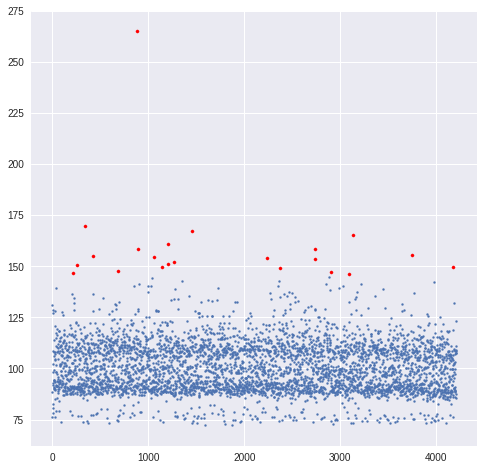

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(train_ol[train_ol.is_ol==True].index, train_ol[train_ol.is_ol==True]['y'], s=10, c='red')
plt.scatter(train_ol[train_ol.is_ol==False].index, train_ol[train_ol.is_ol==False]['y'], s=4)

The points marked in red are classified as outliers. In the next model we will remove these outliers and then train our model. 

In [0]:
params = {
 'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'seed' : rs,
 'silent': 1,
 'subsample': 0.97
}


In [0]:
s_time = time.time()

drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = []
trn_scores = []
best_iterations = []
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)
  
  break
print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [26]:
np.array(val_scores).mean(), np.array(trn_scores).mean()

(0.539243, 0.665188)

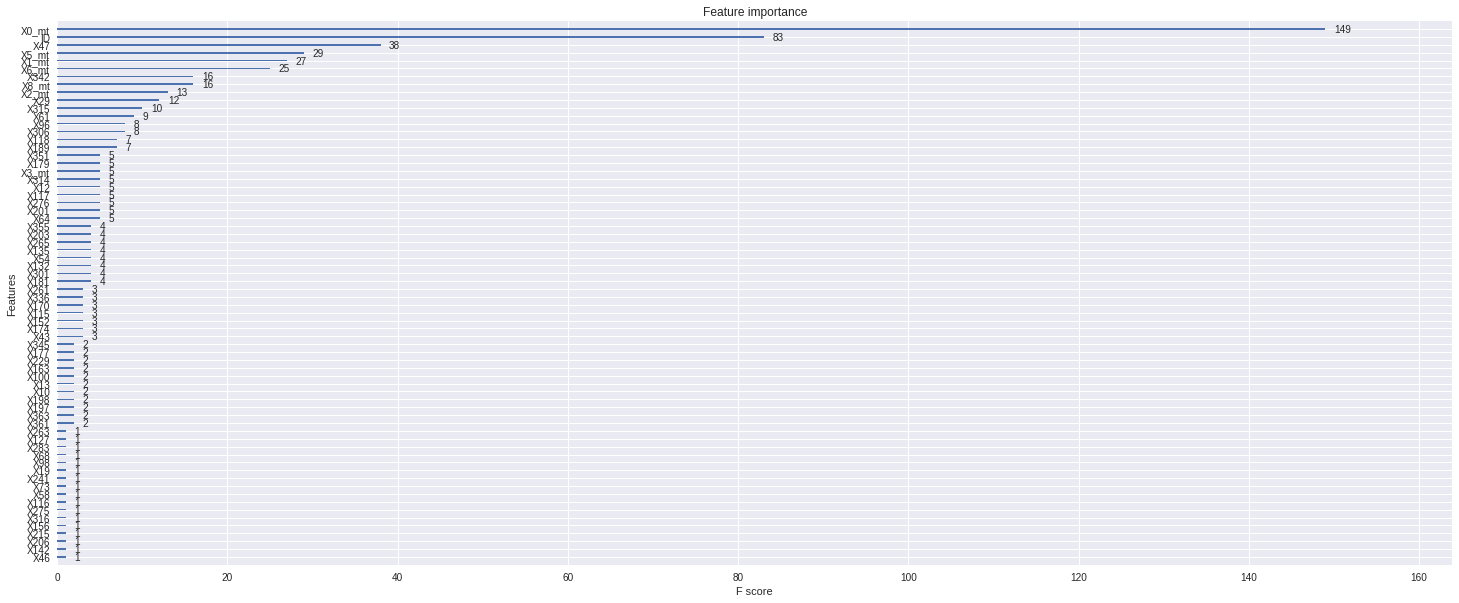

In [41]:
plt.figure(figsize=(25,10))
plot_importance(model, ax=plt.gca(), max_num_features=70)

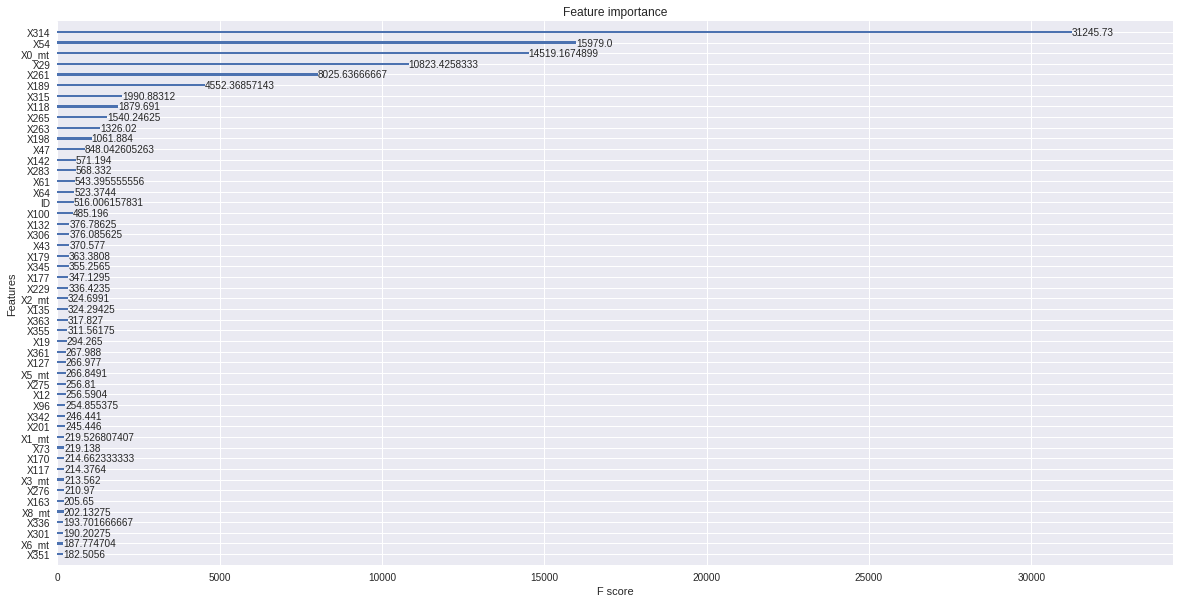

In [36]:
plt.figure(figsize=(20,10))
plot_importance(model, ax=plt.gca(), max_num_features=50, importance_type='gain')

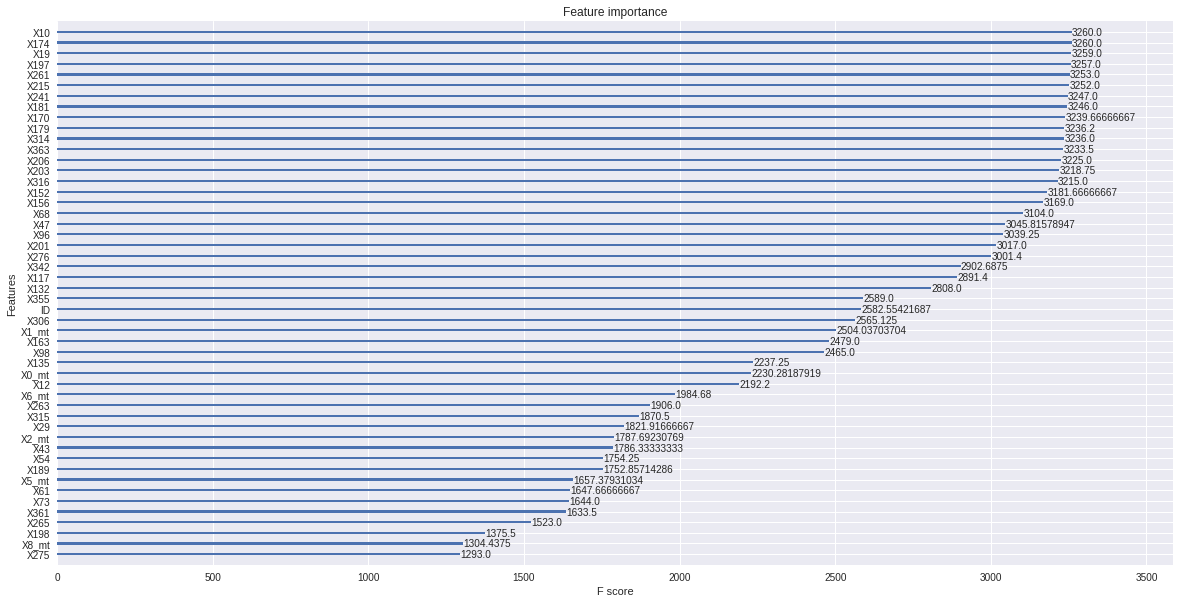

In [37]:
plt.figure(figsize=(20,10))
plot_importance(model, ax=plt.gca(), max_num_features=50, importance_type='cover')

The above three plots use 'weight', 'gain' or 'cover' to calculate feature importances. In third('cover') plot the features aren't discriminated clearly becuse the max_depth=2 so any feature selected in different trees will have almost same no of points in its coverage. So let's get first few features from first two plots and use only them to train our models. 



In [0]:
def create_feature_fmap(features):
  with open('xgb.fmap', 'w') as outfile:  
    i = 0
    for feat in features:
      outfile.write('{0}\t{1}\tq\n'.format(i, feat))
      i = i + 1

In [0]:
create_feature_fmap(list(trns[0].drop(['y']+cat_feat+low_var_feat+dup_feat, axis=1).columns))

In [0]:
weight_importance = model.get_score('xgb.fmap', 'weight')
gain_importance = model.get_score('xgb.fmap', 'gain')

In [0]:
weight_importance = sorted(weight_importance.items(), key=operator.itemgetter(1), reverse=True)
gain_importance = sorted(gain_importance.items(), key=operator.itemgetter(1), reverse=True)

So here have sorted importance of features based on weight and gain. Let's first get features that have a weight_importance score of 5 or more. 


In [69]:
feat = [f[0] for f in weight_importance if f[1]>4]
len(feat)

25

So like above we can calculate importances on each set of trn, val in trns, vals. Let's do it. 

In [39]:
s_time = time.time()

drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
val_scores = []
trn_scores = []
best_iterations = []
weight_importances = {}
gain_importances = {}
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)
  
  wimp = model.get_score(importance_type='weight')
  gimp = model.get_score(importance_type='gain')
  for key, value in wimp.items():
    if key in weight_importances.keys(): weight_importances[key] += wimp[key]
    else : weight_importances[key] = wimp[key]
  for key, value in gimp.items():
    if key in gain_importances.keys(): gain_importances[key] += gimp[key]
    else : gain_importances[key] = gimp[key] 
#   break
print ("Time Taken : {0} seconds".format(time.time()-s_time))

Train no : 0
[0]	train-rmse:95.3756	eval-rmse:96.6694	train-r2_score:-65.9109	eval-r2_score:-53.2851
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 50 rounds.
[1]	train-rmse:90.6392	eval-rmse:91.9355	train-r2_score:-59.4302	eval-r2_score:-48.0985
[2]	train-rmse:86.1415	eval-rmse:87.4409	train-r2_score:-53.5817	eval-r2_score:-43.4151
[3]	train-rmse:81.8685	eval-rmse:83.1715	train-r2_score:-48.301	eval-r2_score:-39.1838
[4]	train-rmse:77.8108	eval-rmse:79.118	train-r2_score:-43.5351	eval-r2_score:-35.3624
[5]	train-rmse:73.958	eval-rmse:75.27	train-r2_score:-39.2339	eval-r2_score:-31.9114
[6]	train-rmse:70.2984	eval-rmse:71.6155	train-r2_score:-35.3507	eval-r2_score:-28.7931
[7]	train-rmse:66.8249	eval-rmse:68.1478	train-r2_score:-31.8472	eval-r2_score:-25.9778
[8]	train-rmse:63.5295	eval-rmse:64.8644	train-r2_score:-28.6875	eval-r2_score:-23.4408
[9]	train-rmse:60.3975	eval-rmse:61.7396	train-r2

[45]	train-rmse:11.7958	eval-rmse:13.7775	train-r2_score:-0.023471	eval-r2_score:-0.102668
[46]	train-rmse:11.414	eval-rmse:13.4197	train-r2_score:0.041707	eval-r2_score:-0.046137
[47]	train-rmse:11.0584	eval-rmse:13.0818	train-r2_score:0.100496	eval-r2_score:0.00589
[48]	train-rmse:10.7291	eval-rmse:12.7707	train-r2_score:0.153269	eval-r2_score:0.0526
[49]	train-rmse:10.422	eval-rmse:12.4799	train-r2_score:0.201035	eval-r2_score:0.095266
[50]	train-rmse:10.1353	eval-rmse:12.2113	train-r2_score:0.244398	eval-r2_score:0.133792
[51]	train-rmse:9.86594	eval-rmse:11.9585	train-r2_score:0.284023	eval-r2_score:0.169282
[52]	train-rmse:9.61879	eval-rmse:11.7252	train-r2_score:0.319446	eval-r2_score:0.201369
[53]	train-rmse:9.39136	eval-rmse:11.5105	train-r2_score:0.351247	eval-r2_score:0.230353
[54]	train-rmse:9.17922	eval-rmse:11.3125	train-r2_score:0.380226	eval-r2_score:0.256603
[55]	train-rmse:8.98205	eval-rmse:11.1264	train-r2_score:0.406565	eval-r2_score:0.280859
[56]	train-rmse:8.8013	

[91]	train-rmse:6.8965	eval-rmse:9.05181	train-r2_score:0.650151	eval-r2_score:0.524038
[92]	train-rmse:6.88933	eval-rmse:9.04212	train-r2_score:0.650879	eval-r2_score:0.525056
[93]	train-rmse:6.88206	eval-rmse:9.03315	train-r2_score:0.651615	eval-r2_score:0.525997
[94]	train-rmse:6.87592	eval-rmse:9.02468	train-r2_score:0.652236	eval-r2_score:0.526886
[95]	train-rmse:6.86934	eval-rmse:9.01732	train-r2_score:0.652902	eval-r2_score:0.527658
[96]	train-rmse:6.86336	eval-rmse:9.01003	train-r2_score:0.653506	eval-r2_score:0.528421
[97]	train-rmse:6.85765	eval-rmse:9.00326	train-r2_score:0.654082	eval-r2_score:0.52913
[98]	train-rmse:6.85202	eval-rmse:8.99647	train-r2_score:0.65465	eval-r2_score:0.529839
[99]	train-rmse:6.84721	eval-rmse:8.99064	train-r2_score:0.655135	eval-r2_score:0.530448
[100]	train-rmse:6.84308	eval-rmse:8.98523	train-r2_score:0.655551	eval-r2_score:0.531013
[101]	train-rmse:6.83911	eval-rmse:8.9809	train-r2_score:0.655951	eval-r2_score:0.531466
[102]	train-rmse:6.8351

[137]	train-rmse:6.76606	eval-rmse:8.90885	train-r2_score:0.663261	eval-r2_score:0.538953
[138]	train-rmse:6.76539	eval-rmse:8.90818	train-r2_score:0.663327	eval-r2_score:0.539023
[139]	train-rmse:6.76402	eval-rmse:8.90871	train-r2_score:0.663464	eval-r2_score:0.538967
[140]	train-rmse:6.76263	eval-rmse:8.90893	train-r2_score:0.663602	eval-r2_score:0.538945
[141]	train-rmse:6.75938	eval-rmse:8.90867	train-r2_score:0.663925	eval-r2_score:0.538971
[142]	train-rmse:6.75768	eval-rmse:8.90981	train-r2_score:0.664094	eval-r2_score:0.538853
[143]	train-rmse:6.75629	eval-rmse:8.90894	train-r2_score:0.664233	eval-r2_score:0.538943
[144]	train-rmse:6.75571	eval-rmse:8.90841	train-r2_score:0.66429	eval-r2_score:0.538999
[145]	train-rmse:6.7549	eval-rmse:8.90897	train-r2_score:0.66437	eval-r2_score:0.538941
[146]	train-rmse:6.75274	eval-rmse:8.90922	train-r2_score:0.664585	eval-r2_score:0.538914
[147]	train-rmse:6.75173	eval-rmse:8.90823	train-r2_score:0.664686	eval-r2_score:0.539017
[148]	train-r

[183]	train-rmse:6.70549	eval-rmse:8.91037	train-r2_score:0.669262	eval-r2_score:0.538796
[184]	train-rmse:6.70458	eval-rmse:8.91098	train-r2_score:0.669352	eval-r2_score:0.538732
[185]	train-rmse:6.70354	eval-rmse:8.91128	train-r2_score:0.669455	eval-r2_score:0.538701
[186]	train-rmse:6.70309	eval-rmse:8.9113	train-r2_score:0.669499	eval-r2_score:0.538699
[187]	train-rmse:6.70241	eval-rmse:8.91161	train-r2_score:0.669566	eval-r2_score:0.538667
[188]	train-rmse:6.70151	eval-rmse:8.91094	train-r2_score:0.669655	eval-r2_score:0.538737
[189]	train-rmse:6.70045	eval-rmse:8.91173	train-r2_score:0.669759	eval-r2_score:0.538655
[190]	train-rmse:6.6993	eval-rmse:8.91355	train-r2_score:0.669873	eval-r2_score:0.538466
[191]	train-rmse:6.69837	eval-rmse:8.91335	train-r2_score:0.669965	eval-r2_score:0.538487
[192]	train-rmse:6.69779	eval-rmse:8.91196	train-r2_score:0.670022	eval-r2_score:0.538631
[193]	train-rmse:6.69642	eval-rmse:8.91243	train-r2_score:0.670156	eval-r2_score:0.538582
[194]	train-

[23]	train-rmse:30.2983	eval-rmse:30.7748	train-r2_score:-5.44993	eval-r2_score:-4.37405
[24]	train-rmse:28.8766	eval-rmse:29.3823	train-r2_score:-4.85882	eval-r2_score:-3.89873
[25]	train-rmse:27.5316	eval-rmse:28.0685	train-r2_score:-4.32575	eval-r2_score:-3.47043
[26]	train-rmse:26.2562	eval-rmse:26.8242	train-r2_score:-3.84376	eval-r2_score:-3.08286
[27]	train-rmse:25.0521	eval-rmse:25.653	train-r2_score:-3.40967	eval-r2_score:-2.73412
[28]	train-rmse:23.9132	eval-rmse:24.5463	train-r2_score:-3.01786	eval-r2_score:-2.41887
[29]	train-rmse:22.835	eval-rmse:23.5031	train-r2_score:-2.66372	eval-r2_score:-2.13444
[30]	train-rmse:21.8162	eval-rmse:22.5186	train-r2_score:-2.3441	eval-r2_score:-1.87737
[31]	train-rmse:20.8567	eval-rmse:21.5932	train-r2_score:-2.0564	eval-r2_score:-1.64573
[32]	train-rmse:19.9493	eval-rmse:20.7206	train-r2_score:-1.79625	eval-r2_score:-1.43621
[33]	train-rmse:19.0914	eval-rmse:19.9012	train-r2_score:-1.5609	eval-r2_score:-1.24734
[34]	train-rmse:18.2808	ev

[69]	train-rmse:7.75394	eval-rmse:9.69514	train-r2_score:0.577561	eval-r2_score:0.466641
[70]	train-rmse:7.70165	eval-rmse:9.65324	train-r2_score:0.583239	eval-r2_score:0.471242
[71]	train-rmse:7.65411	eval-rmse:9.61644	train-r2_score:0.588369	eval-r2_score:0.475265
[72]	train-rmse:7.6108	eval-rmse:9.58403	train-r2_score:0.593014	eval-r2_score:0.478796
[73]	train-rmse:7.57214	eval-rmse:9.55546	train-r2_score:0.597139	eval-r2_score:0.481899
[74]	train-rmse:7.53618	eval-rmse:9.52764	train-r2_score:0.600956	eval-r2_score:0.484911
[75]	train-rmse:7.50392	eval-rmse:9.50347	train-r2_score:0.604365	eval-r2_score:0.487522
[76]	train-rmse:7.47269	eval-rmse:9.48043	train-r2_score:0.607651	eval-r2_score:0.490003
[77]	train-rmse:7.44559	eval-rmse:9.45855	train-r2_score:0.610491	eval-r2_score:0.492355
[78]	train-rmse:7.42076	eval-rmse:9.44032	train-r2_score:0.613085	eval-r2_score:0.494309
[79]	train-rmse:7.39808	eval-rmse:9.4235	train-r2_score:0.615446	eval-r2_score:0.49611
[80]	train-rmse:7.3772	e

[115]	train-rmse:7.13542	eval-rmse:9.27065	train-r2_score:0.642268	eval-r2_score:0.512323
[116]	train-rmse:7.13304	eval-rmse:9.27066	train-r2_score:0.642507	eval-r2_score:0.512322
[117]	train-rmse:7.13086	eval-rmse:9.26968	train-r2_score:0.642725	eval-r2_score:0.512426
[118]	train-rmse:7.12811	eval-rmse:9.26909	train-r2_score:0.643	eval-r2_score:0.512488
[119]	train-rmse:7.12604	eval-rmse:9.26818	train-r2_score:0.643208	eval-r2_score:0.512583
[120]	train-rmse:7.12424	eval-rmse:9.266	train-r2_score:0.643388	eval-r2_score:0.512813
[121]	train-rmse:7.12211	eval-rmse:9.2658	train-r2_score:0.643602	eval-r2_score:0.512834
[122]	train-rmse:7.12057	eval-rmse:9.26548	train-r2_score:0.643755	eval-r2_score:0.512868
[123]	train-rmse:7.11864	eval-rmse:9.26599	train-r2_score:0.643948	eval-r2_score:0.512814
[124]	train-rmse:7.1166	eval-rmse:9.2668	train-r2_score:0.644152	eval-r2_score:0.512728
[125]	train-rmse:7.11423	eval-rmse:9.26706	train-r2_score:0.64439	eval-r2_score:0.512701
[126]	train-rmse:7.

[161]	train-rmse:7.06514	eval-rmse:9.26713	train-r2_score:0.64928	eval-r2_score:0.512693
[162]	train-rmse:7.06355	eval-rmse:9.26745	train-r2_score:0.649438	eval-r2_score:0.51266
[163]	train-rmse:7.06169	eval-rmse:9.26431	train-r2_score:0.649623	eval-r2_score:0.51299
[164]	train-rmse:7.06098	eval-rmse:9.26438	train-r2_score:0.649693	eval-r2_score:0.512983
[165]	train-rmse:7.05946	eval-rmse:9.26391	train-r2_score:0.649844	eval-r2_score:0.513032
[166]	train-rmse:7.05891	eval-rmse:9.26341	train-r2_score:0.649898	eval-r2_score:0.513085
[167]	train-rmse:7.05767	eval-rmse:9.26306	train-r2_score:0.650022	eval-r2_score:0.513122
[168]	train-rmse:7.05636	eval-rmse:9.26266	train-r2_score:0.650152	eval-r2_score:0.513164
[169]	train-rmse:7.05512	eval-rmse:9.26272	train-r2_score:0.650274	eval-r2_score:0.513158
[170]	train-rmse:7.0546	eval-rmse:9.26222	train-r2_score:0.650326	eval-r2_score:0.51321
[171]	train-rmse:7.05362	eval-rmse:9.26223	train-r2_score:0.650423	eval-r2_score:0.513209
[172]	train-rms

[207]	train-rmse:7.01011	eval-rmse:9.26339	train-r2_score:0.654722	eval-r2_score:0.513087
[208]	train-rmse:7.00837	eval-rmse:9.26396	train-r2_score:0.654894	eval-r2_score:0.513027
[209]	train-rmse:7.0072	eval-rmse:9.26494	train-r2_score:0.655009	eval-r2_score:0.512924
[210]	train-rmse:7.0064	eval-rmse:9.26406	train-r2_score:0.655088	eval-r2_score:0.513017
[211]	train-rmse:7.00564	eval-rmse:9.26443	train-r2_score:0.655162	eval-r2_score:0.512978
[212]	train-rmse:7.00448	eval-rmse:9.26396	train-r2_score:0.655277	eval-r2_score:0.513027
[213]	train-rmse:7.00389	eval-rmse:9.26381	train-r2_score:0.655335	eval-r2_score:0.513043
[214]	train-rmse:7.00257	eval-rmse:9.26243	train-r2_score:0.655465	eval-r2_score:0.513188
[215]	train-rmse:7.00143	eval-rmse:9.26325	train-r2_score:0.655577	eval-r2_score:0.513102
[216]	train-rmse:7.00042	eval-rmse:9.26229	train-r2_score:0.655677	eval-r2_score:0.513203
[217]	train-rmse:6.99939	eval-rmse:9.26289	train-r2_score:0.655777	eval-r2_score:0.51314
[218]	train-r

[19]	train-rmse:36.7507	eval-rmse:36.8354	train-r2_score:-8.51915	eval-r2_score:-8.49172
[20]	train-rmse:34.9886	eval-rmse:35.0748	train-r2_score:-7.62818	eval-r2_score:-7.60606
[21]	train-rmse:33.32	eval-rmse:33.4054	train-r2_score:-6.82485	eval-r2_score:-6.80631
[22]	train-rmse:31.7359	eval-rmse:31.8229	train-r2_score:-6.09854	eval-r2_score:-6.08424
[23]	train-rmse:30.2387	eval-rmse:30.3303	train-r2_score:-5.44453	eval-r2_score:-5.43528
[24]	train-rmse:28.8173	eval-rmse:28.9091	train-r2_score:-4.85294	eval-r2_score:-4.8463
[25]	train-rmse:27.4724	eval-rmse:27.5653	train-r2_score:-4.31934	eval-r2_score:-4.31545
[26]	train-rmse:26.2031	eval-rmse:26.3003	train-r2_score:-3.83917	eval-r2_score:-3.83879
[27]	train-rmse:24.9956	eval-rmse:25.0947	train-r2_score:-3.40347	eval-r2_score:-3.40534
[28]	train-rmse:23.855	eval-rmse:23.9556	train-r2_score:-3.01076	eval-r2_score:-3.01448
[29]	train-rmse:22.7774	eval-rmse:22.8797	train-r2_score:-2.65657	eval-r2_score:-2.66195
[30]	train-rmse:21.7578	e

[65]	train-rmse:7.93404	eval-rmse:8.19825	train-r2_score:0.556335	eval-r2_score:0.52983
[66]	train-rmse:7.85918	eval-rmse:8.12253	train-r2_score:0.564668	eval-r2_score:0.538474
[67]	train-rmse:7.79129	eval-rmse:8.05831	train-r2_score:0.572156	eval-r2_score:0.545744
[68]	train-rmse:7.72885	eval-rmse:7.996	train-r2_score:0.578986	eval-r2_score:0.552741
[69]	train-rmse:7.67204	eval-rmse:7.94237	train-r2_score:0.585153	eval-r2_score:0.55872
[70]	train-rmse:7.61899	eval-rmse:7.89253	train-r2_score:0.59087	eval-r2_score:0.564241
[71]	train-rmse:7.57111	eval-rmse:7.84766	train-r2_score:0.595997	eval-r2_score:0.569182
[72]	train-rmse:7.52772	eval-rmse:7.80476	train-r2_score:0.600614	eval-r2_score:0.573879
[73]	train-rmse:7.48797	eval-rmse:7.76685	train-r2_score:0.60482	eval-r2_score:0.578008
[74]	train-rmse:7.45204	eval-rmse:7.73344	train-r2_score:0.608604	eval-r2_score:0.581631
[75]	train-rmse:7.41892	eval-rmse:7.70312	train-r2_score:0.612075	eval-r2_score:0.584906
[76]	train-rmse:7.3893	eval

[112]	train-rmse:7.06536	eval-rmse:7.38905	train-r2_score:0.648168	eval-r2_score:0.618064
[113]	train-rmse:7.06327	eval-rmse:7.38843	train-r2_score:0.648377	eval-r2_score:0.618128
[114]	train-rmse:7.0615	eval-rmse:7.38733	train-r2_score:0.648553	eval-r2_score:0.618241
[115]	train-rmse:7.05983	eval-rmse:7.3867	train-r2_score:0.648719	eval-r2_score:0.618307
[116]	train-rmse:7.05634	eval-rmse:7.38404	train-r2_score:0.649066	eval-r2_score:0.618581
[117]	train-rmse:7.05487	eval-rmse:7.3839	train-r2_score:0.649212	eval-r2_score:0.618596
[118]	train-rmse:7.053	eval-rmse:7.38194	train-r2_score:0.649398	eval-r2_score:0.618798
[119]	train-rmse:7.05102	eval-rmse:7.38055	train-r2_score:0.649595	eval-r2_score:0.618943
[120]	train-rmse:7.04944	eval-rmse:7.38039	train-r2_score:0.649752	eval-r2_score:0.618958
[121]	train-rmse:7.04685	eval-rmse:7.37914	train-r2_score:0.650009	eval-r2_score:0.619088
[122]	train-rmse:7.04453	eval-rmse:7.37974	train-r2_score:0.65024	eval-r2_score:0.619026
[123]	train-rmse

[158]	train-rmse:6.99061	eval-rmse:7.36831	train-r2_score:0.655573	eval-r2_score:0.620205
[159]	train-rmse:6.98875	eval-rmse:7.36891	train-r2_score:0.655757	eval-r2_score:0.620144
[160]	train-rmse:6.98748	eval-rmse:7.36898	train-r2_score:0.655881	eval-r2_score:0.620136
[161]	train-rmse:6.98673	eval-rmse:7.36986	train-r2_score:0.655955	eval-r2_score:0.620045
[162]	train-rmse:6.98571	eval-rmse:7.3703	train-r2_score:0.656056	eval-r2_score:0.62
[163]	train-rmse:6.98426	eval-rmse:7.36988	train-r2_score:0.656199	eval-r2_score:0.620043
[164]	train-rmse:6.98276	eval-rmse:7.37075	train-r2_score:0.656347	eval-r2_score:0.619954
[165]	train-rmse:6.98182	eval-rmse:7.37095	train-r2_score:0.656439	eval-r2_score:0.619932
[166]	train-rmse:6.97997	eval-rmse:7.36991	train-r2_score:0.656621	eval-r2_score:0.62004
[167]	train-rmse:6.9784	eval-rmse:7.3702	train-r2_score:0.656776	eval-r2_score:0.62001
[168]	train-rmse:6.97732	eval-rmse:7.37101	train-r2_score:0.656882	eval-r2_score:0.619927
[169]	train-rmse:6.

[204]	train-rmse:6.93526	eval-rmse:7.36481	train-r2_score:0.661006	eval-r2_score:0.620566
[205]	train-rmse:6.93377	eval-rmse:7.36499	train-r2_score:0.661152	eval-r2_score:0.620547
[206]	train-rmse:6.93286	eval-rmse:7.36407	train-r2_score:0.661241	eval-r2_score:0.620642
[207]	train-rmse:6.93171	eval-rmse:7.36326	train-r2_score:0.661353	eval-r2_score:0.620725
[208]	train-rmse:6.93076	eval-rmse:7.3631	train-r2_score:0.661446	eval-r2_score:0.620742
[209]	train-rmse:6.92988	eval-rmse:7.36205	train-r2_score:0.661532	eval-r2_score:0.62085
[210]	train-rmse:6.92849	eval-rmse:7.36259	train-r2_score:0.661667	eval-r2_score:0.620794
[211]	train-rmse:6.92764	eval-rmse:7.36329	train-r2_score:0.661751	eval-r2_score:0.620722
[212]	train-rmse:6.92707	eval-rmse:7.36374	train-r2_score:0.661806	eval-r2_score:0.620676
[213]	train-rmse:6.92551	eval-rmse:7.36343	train-r2_score:0.661959	eval-r2_score:0.620708
[214]	train-rmse:6.92489	eval-rmse:7.36236	train-r2_score:0.662019	eval-r2_score:0.620818
[215]	train-

[250]	train-rmse:6.88499	eval-rmse:7.37323	train-r2_score:0.665903	eval-r2_score:0.619698
[251]	train-rmse:6.88399	eval-rmse:7.37375	train-r2_score:0.665999	eval-r2_score:0.619644
[252]	train-rmse:6.88253	eval-rmse:7.37411	train-r2_score:0.666142	eval-r2_score:0.619607
[253]	train-rmse:6.88183	eval-rmse:7.3741	train-r2_score:0.666209	eval-r2_score:0.619608
[254]	train-rmse:6.87914	eval-rmse:7.37371	train-r2_score:0.666471	eval-r2_score:0.619648
[255]	train-rmse:6.87766	eval-rmse:7.37559	train-r2_score:0.666614	eval-r2_score:0.619454
[256]	train-rmse:6.87665	eval-rmse:7.37657	train-r2_score:0.666711	eval-r2_score:0.619353
[257]	train-rmse:6.8759	eval-rmse:7.37665	train-r2_score:0.666784	eval-r2_score:0.619345
[258]	train-rmse:6.87485	eval-rmse:7.37662	train-r2_score:0.666886	eval-r2_score:0.619348
[259]	train-rmse:6.87419	eval-rmse:7.37761	train-r2_score:0.66695	eval-r2_score:0.619246
Stopping. Best iteration:
[209]	train-rmse:6.92988	eval-rmse:7.36205	train-r2_score:0.661532	eval-r2_sc

[33]	train-rmse:19.0329	eval-rmse:19.3487	train-r2_score:-1.57571	eval-r2_score:-1.45477
[34]	train-rmse:18.2241	eval-rmse:18.5462	train-r2_score:-1.36145	eval-r2_score:-1.25537
[35]	train-rmse:17.4633	eval-rmse:17.7945	train-r2_score:-1.1684	eval-r2_score:-1.07626
[36]	train-rmse:16.7445	eval-rmse:17.0839	train-r2_score:-0.993565	eval-r2_score:-0.913743
[37]	train-rmse:16.0673	eval-rmse:16.418	train-r2_score:-0.835572	eval-r2_score:-0.767449
[38]	train-rmse:15.4308	eval-rmse:15.7927	train-r2_score:-0.693029	eval-r2_score:-0.635391
[39]	train-rmse:14.8334	eval-rmse:15.2062	train-r2_score:-0.564484	eval-r2_score:-0.516174
[40]	train-rmse:14.272	eval-rmse:14.6563	train-r2_score:-0.44829	eval-r2_score:-0.408494
[41]	train-rmse:13.7465	eval-rmse:14.137	train-r2_score:-0.343603	eval-r2_score:-0.310469
[42]	train-rmse:13.2561	eval-rmse:13.6534	train-r2_score:-0.249446	eval-r2_score:-0.222333
[43]	train-rmse:12.793	eval-rmse:13.199	train-r2_score:-0.163676	eval-r2_score:-0.142329
[44]	train-r

[79]	train-rmse:7.3376	eval-rmse:7.91362	train-r2_score:0.617179	eval-r2_score:0.589362
[80]	train-rmse:7.31705	eval-rmse:7.89293	train-r2_score:0.61932	eval-r2_score:0.591506
[81]	train-rmse:7.29803	eval-rmse:7.87243	train-r2_score:0.621297	eval-r2_score:0.593625
[82]	train-rmse:7.28064	eval-rmse:7.85572	train-r2_score:0.623099	eval-r2_score:0.595348
[83]	train-rmse:7.26494	eval-rmse:7.84197	train-r2_score:0.624724	eval-r2_score:0.596764
[84]	train-rmse:7.25019	eval-rmse:7.82979	train-r2_score:0.626246	eval-r2_score:0.598015
[85]	train-rmse:7.23703	eval-rmse:7.81606	train-r2_score:0.627601	eval-r2_score:0.599424
[86]	train-rmse:7.22496	eval-rmse:7.8045	train-r2_score:0.628842	eval-r2_score:0.600608
[87]	train-rmse:7.21359	eval-rmse:7.79477	train-r2_score:0.63001	eval-r2_score:0.601603
[88]	train-rmse:7.20324	eval-rmse:7.78414	train-r2_score:0.631071	eval-r2_score:0.602689
[89]	train-rmse:7.1928	eval-rmse:7.77525	train-r2_score:0.63214	eval-r2_score:0.603596
[90]	train-rmse:7.18433	eva

[125]	train-rmse:7.06281	eval-rmse:7.67399	train-r2_score:0.645315	eval-r2_score:0.613854
[126]	train-rmse:7.06113	eval-rmse:7.67168	train-r2_score:0.645484	eval-r2_score:0.614086
[127]	train-rmse:7.06019	eval-rmse:7.6713	train-r2_score:0.645578	eval-r2_score:0.614124
[128]	train-rmse:7.05816	eval-rmse:7.66947	train-r2_score:0.645782	eval-r2_score:0.614309
[129]	train-rmse:7.05728	eval-rmse:7.66948	train-r2_score:0.64587	eval-r2_score:0.614307
[130]	train-rmse:7.05606	eval-rmse:7.66892	train-r2_score:0.645993	eval-r2_score:0.614364
[131]	train-rmse:7.05461	eval-rmse:7.66917	train-r2_score:0.646138	eval-r2_score:0.614339
[132]	train-rmse:7.05281	eval-rmse:7.66842	train-r2_score:0.646319	eval-r2_score:0.614414
[133]	train-rmse:7.05075	eval-rmse:7.66828	train-r2_score:0.646525	eval-r2_score:0.614428
[134]	train-rmse:7.04943	eval-rmse:7.66904	train-r2_score:0.646658	eval-r2_score:0.614352
[135]	train-rmse:7.04821	eval-rmse:7.66744	train-r2_score:0.64678	eval-r2_score:0.614513
[136]	train-r

[171]	train-rmse:7.00174	eval-rmse:7.65397	train-r2_score:0.651422	eval-r2_score:0.615866
[172]	train-rmse:7.001	eval-rmse:7.65536	train-r2_score:0.651496	eval-r2_score:0.615726
[173]	train-rmse:6.9999	eval-rmse:7.65484	train-r2_score:0.651606	eval-r2_score:0.615779
[174]	train-rmse:6.99879	eval-rmse:7.65509	train-r2_score:0.651716	eval-r2_score:0.615753
[175]	train-rmse:6.99747	eval-rmse:7.65516	train-r2_score:0.651847	eval-r2_score:0.615747
[176]	train-rmse:6.99609	eval-rmse:7.654	train-r2_score:0.651985	eval-r2_score:0.615863
[177]	train-rmse:6.99413	eval-rmse:7.65432	train-r2_score:0.65218	eval-r2_score:0.615831
[178]	train-rmse:6.99306	eval-rmse:7.65393	train-r2_score:0.652286	eval-r2_score:0.61587
[179]	train-rmse:6.99179	eval-rmse:7.65316	train-r2_score:0.652412	eval-r2_score:0.615948
[180]	train-rmse:6.99078	eval-rmse:7.65283	train-r2_score:0.652513	eval-r2_score:0.615981
[181]	train-rmse:6.98939	eval-rmse:7.65365	train-r2_score:0.652651	eval-r2_score:0.615898
[182]	train-rmse:

[217]	train-rmse:6.94879	eval-rmse:7.65239	train-r2_score:0.656674	eval-r2_score:0.616024
[218]	train-rmse:6.94843	eval-rmse:7.65184	train-r2_score:0.65671	eval-r2_score:0.61608
[219]	train-rmse:6.94758	eval-rmse:7.65184	train-r2_score:0.656795	eval-r2_score:0.616079
[220]	train-rmse:6.94675	eval-rmse:7.6515	train-r2_score:0.656876	eval-r2_score:0.616114
[221]	train-rmse:6.94545	eval-rmse:7.65153	train-r2_score:0.657005	eval-r2_score:0.616111
[222]	train-rmse:6.94425	eval-rmse:7.6524	train-r2_score:0.657123	eval-r2_score:0.616023
[223]	train-rmse:6.94338	eval-rmse:7.65181	train-r2_score:0.657209	eval-r2_score:0.616083
[224]	train-rmse:6.94291	eval-rmse:7.65178	train-r2_score:0.657255	eval-r2_score:0.616086
[225]	train-rmse:6.94172	eval-rmse:7.65186	train-r2_score:0.657373	eval-r2_score:0.616078
[226]	train-rmse:6.94119	eval-rmse:7.65081	train-r2_score:0.657425	eval-r2_score:0.616184
[227]	train-rmse:6.94074	eval-rmse:7.65032	train-r2_score:0.65747	eval-r2_score:0.616232
[228]	train-rms

[17]	train-rmse:40.56	eval-rmse:41.0859	train-r2_score:-10.7023	eval-r2_score:-9.60366
[18]	train-rmse:38.6015	eval-rmse:39.134	train-r2_score:-9.59946	eval-r2_score:-8.62006
[19]	train-rmse:36.7453	eval-rmse:37.2848	train-r2_score:-8.60456	eval-r2_score:-7.73236
[20]	train-rmse:34.9846	eval-rmse:35.5318	train-r2_score:-7.70621	eval-r2_score:-6.93055
[21]	train-rmse:33.3169	eval-rmse:33.8715	train-r2_score:-6.89597	eval-r2_score:-6.20672
[22]	train-rmse:31.7359	eval-rmse:32.2986	train-r2_score:-6.16435	eval-r2_score:-5.55294
[23]	train-rmse:30.2364	eval-rmse:30.8104	train-r2_score:-5.50331	eval-r2_score:-4.963
[24]	train-rmse:28.8152	eval-rmse:29.3993	train-r2_score:-4.90634	eval-r2_score:-4.42929
[25]	train-rmse:27.4696	eval-rmse:28.0643	train-r2_score:-4.36758	eval-r2_score:-3.94739
[26]	train-rmse:26.1967	eval-rmse:26.8044	train-r2_score:-3.88168	eval-r2_score:-3.51317
[27]	train-rmse:24.9914	eval-rmse:25.6106	train-r2_score:-3.4428	eval-r2_score:-3.12009
[28]	train-rmse:23.8536	eva

[63]	train-rmse:8.08916	eval-rmse:9.19136	train-r2_score:0.53454	eval-r2_score:0.469324
[64]	train-rmse:8.00033	eval-rmse:9.1089	train-r2_score:0.544707	eval-r2_score:0.478805
[65]	train-rmse:7.91749	eval-rmse:9.03066	train-r2_score:0.554088	eval-r2_score:0.487719
[66]	train-rmse:7.84272	eval-rmse:8.95869	train-r2_score:0.562469	eval-r2_score:0.495852
[67]	train-rmse:7.77426	eval-rmse:8.8938	train-r2_score:0.570075	eval-r2_score:0.503129
[68]	train-rmse:7.7111	eval-rmse:8.83478	train-r2_score:0.577031	eval-r2_score:0.509702
[69]	train-rmse:7.65427	eval-rmse:8.7816	train-r2_score:0.583244	eval-r2_score:0.515586
[70]	train-rmse:7.60159	eval-rmse:8.73096	train-r2_score:0.58896	eval-r2_score:0.521157
[71]	train-rmse:7.55293	eval-rmse:8.68762	train-r2_score:0.594206	eval-r2_score:0.525899
[72]	train-rmse:7.50932	eval-rmse:8.64773	train-r2_score:0.598878	eval-r2_score:0.530243
[73]	train-rmse:7.46939	eval-rmse:8.61064	train-r2_score:0.603133	eval-r2_score:0.534263
[74]	train-rmse:7.43313	eva

[110]	train-rmse:7.049	eval-rmse:8.22113	train-r2_score:0.646548	eval-r2_score:0.575447
[111]	train-rmse:7.04626	eval-rmse:8.21949	train-r2_score:0.646823	eval-r2_score:0.575616
[112]	train-rmse:7.04246	eval-rmse:8.21775	train-r2_score:0.647204	eval-r2_score:0.575796
[113]	train-rmse:7.03899	eval-rmse:8.21533	train-r2_score:0.647552	eval-r2_score:0.576045
[114]	train-rmse:7.03714	eval-rmse:8.2148	train-r2_score:0.647736	eval-r2_score:0.576101
[115]	train-rmse:7.03543	eval-rmse:8.21334	train-r2_score:0.647908	eval-r2_score:0.576251
[116]	train-rmse:7.03327	eval-rmse:8.21189	train-r2_score:0.648124	eval-r2_score:0.576401
[117]	train-rmse:7.03121	eval-rmse:8.21069	train-r2_score:0.64833	eval-r2_score:0.576524
[118]	train-rmse:7.02893	eval-rmse:8.2086	train-r2_score:0.648558	eval-r2_score:0.57674
[119]	train-rmse:7.02743	eval-rmse:8.20892	train-r2_score:0.648708	eval-r2_score:0.576706
[120]	train-rmse:7.02531	eval-rmse:8.20569	train-r2_score:0.64892	eval-r2_score:0.577041
[121]	train-rmse:

[156]	train-rmse:6.97304	eval-rmse:8.19546	train-r2_score:0.654125	eval-r2_score:0.578094
[157]	train-rmse:6.97193	eval-rmse:8.19517	train-r2_score:0.654235	eval-r2_score:0.578124
[158]	train-rmse:6.97058	eval-rmse:8.19516	train-r2_score:0.654369	eval-r2_score:0.578125
[159]	train-rmse:6.96948	eval-rmse:8.19448	train-r2_score:0.654478	eval-r2_score:0.578195
[160]	train-rmse:6.96821	eval-rmse:8.19505	train-r2_score:0.654604	eval-r2_score:0.578136
[161]	train-rmse:6.96736	eval-rmse:8.19493	train-r2_score:0.654688	eval-r2_score:0.578148
[162]	train-rmse:6.96671	eval-rmse:8.19513	train-r2_score:0.654752	eval-r2_score:0.578128
[163]	train-rmse:6.96554	eval-rmse:8.19484	train-r2_score:0.654869	eval-r2_score:0.578158
[164]	train-rmse:6.96374	eval-rmse:8.19613	train-r2_score:0.655046	eval-r2_score:0.578025
[165]	train-rmse:6.9625	eval-rmse:8.19526	train-r2_score:0.655169	eval-r2_score:0.578115
[166]	train-rmse:6.96131	eval-rmse:8.19513	train-r2_score:0.655287	eval-r2_score:0.578128
[167]	train

[202]	train-rmse:6.92341	eval-rmse:8.18934	train-r2_score:0.659031	eval-r2_score:0.578724
[203]	train-rmse:6.92163	eval-rmse:8.18887	train-r2_score:0.659207	eval-r2_score:0.578772
[204]	train-rmse:6.92057	eval-rmse:8.18835	train-r2_score:0.65931	eval-r2_score:0.578825
[205]	train-rmse:6.91972	eval-rmse:8.18847	train-r2_score:0.659394	eval-r2_score:0.578813
[206]	train-rmse:6.91892	eval-rmse:8.1882	train-r2_score:0.659473	eval-r2_score:0.578841
[207]	train-rmse:6.91749	eval-rmse:8.18829	train-r2_score:0.659613	eval-r2_score:0.578832
[208]	train-rmse:6.91692	eval-rmse:8.18833	train-r2_score:0.659669	eval-r2_score:0.578828
[209]	train-rmse:6.91579	eval-rmse:8.18946	train-r2_score:0.659781	eval-r2_score:0.578712
[210]	train-rmse:6.91458	eval-rmse:8.18972	train-r2_score:0.6599	eval-r2_score:0.578684
[211]	train-rmse:6.91333	eval-rmse:8.18964	train-r2_score:0.660023	eval-r2_score:0.578693
[212]	train-rmse:6.9121	eval-rmse:8.18896	train-r2_score:0.660144	eval-r2_score:0.578763
[213]	train-rms

[248]	train-rmse:6.87446	eval-rmse:8.19549	train-r2_score:0.663836	eval-r2_score:0.57809
[249]	train-rmse:6.87355	eval-rmse:8.1954	train-r2_score:0.663924	eval-r2_score:0.5781
[250]	train-rmse:6.87284	eval-rmse:8.19507	train-r2_score:0.663994	eval-r2_score:0.578134
[251]	train-rmse:6.87208	eval-rmse:8.19482	train-r2_score:0.664068	eval-r2_score:0.578159
[252]	train-rmse:6.87107	eval-rmse:8.19416	train-r2_score:0.664167	eval-r2_score:0.578228
[253]	train-rmse:6.87023	eval-rmse:8.19476	train-r2_score:0.664249	eval-r2_score:0.578166
[254]	train-rmse:6.8698	eval-rmse:8.19498	train-r2_score:0.664291	eval-r2_score:0.578143
[255]	train-rmse:6.86925	eval-rmse:8.19428	train-r2_score:0.664345	eval-r2_score:0.578215
[256]	train-rmse:6.86798	eval-rmse:8.19517	train-r2_score:0.664469	eval-r2_score:0.578124
[257]	train-rmse:6.86756	eval-rmse:8.19523	train-r2_score:0.66451	eval-r2_score:0.578118
[258]	train-rmse:6.86719	eval-rmse:8.19534	train-r2_score:0.664546	eval-r2_score:0.578106
[259]	train-rmse

[26]	train-rmse:26.1402	eval-rmse:26.7736	train-r2_score:-3.86122	eval-r2_score:-3.823
[27]	train-rmse:24.937	eval-rmse:25.5668	train-r2_score:-3.424	eval-r2_score:-3.39799
[28]	train-rmse:23.7988	eval-rmse:24.4268	train-r2_score:-3.0294	eval-r2_score:-3.01453
[29]	train-rmse:22.7244	eval-rmse:23.3514	train-r2_score:-2.67379	eval-r2_score:-2.66885
[30]	train-rmse:21.7065	eval-rmse:22.333	train-r2_score:-2.35204	eval-r2_score:-2.35581
[31]	train-rmse:20.7445	eval-rmse:21.3697	train-r2_score:-2.06149	eval-r2_score:-2.07254
[32]	train-rmse:19.8375	eval-rmse:20.4612	train-r2_score:-1.79965	eval-r2_score:-1.81685
[33]	train-rmse:18.9845	eval-rmse:19.6088	train-r2_score:-1.56404	eval-r2_score:-1.58704
[34]	train-rmse:18.1758	eval-rmse:18.7998	train-r2_score:-1.35026	eval-r2_score:-1.37799
[35]	train-rmse:17.4145	eval-rmse:18.0388	train-r2_score:-1.15751	eval-r2_score:-1.18937
[36]	train-rmse:16.6969	eval-rmse:17.3213	train-r2_score:-0.983355	eval-r2_score:-1.01867
[37]	train-rmse:16.022	eval

[72]	train-rmse:7.50673	eval-rmse:8.09964	train-r2_score:0.599105	eval-r2_score:0.558599
[73]	train-rmse:7.46746	eval-rmse:8.05793	train-r2_score:0.603289	eval-r2_score:0.563133
[74]	train-rmse:7.43124	eval-rmse:8.01751	train-r2_score:0.607128	eval-r2_score:0.567505
[75]	train-rmse:7.39919	eval-rmse:7.98259	train-r2_score:0.610509	eval-r2_score:0.571264
[76]	train-rmse:7.36958	eval-rmse:7.94807	train-r2_score:0.613621	eval-r2_score:0.574964
[77]	train-rmse:7.34249	eval-rmse:7.91957	train-r2_score:0.616456	eval-r2_score:0.578007
[78]	train-rmse:7.31778	eval-rmse:7.89241	train-r2_score:0.619033	eval-r2_score:0.580896
[79]	train-rmse:7.29561	eval-rmse:7.86962	train-r2_score:0.621338	eval-r2_score:0.583313
[80]	train-rmse:7.27461	eval-rmse:7.84575	train-r2_score:0.623514	eval-r2_score:0.585836
[81]	train-rmse:7.25599	eval-rmse:7.82509	train-r2_score:0.625439	eval-r2_score:0.588015
[82]	train-rmse:7.23756	eval-rmse:7.80592	train-r2_score:0.62734	eval-r2_score:0.590031
[83]	train-rmse:7.2219

[118]	train-rmse:7.03254	eval-rmse:7.58946	train-r2_score:0.648154	eval-r2_score:0.612453
[119]	train-rmse:7.03066	eval-rmse:7.58838	train-r2_score:0.648342	eval-r2_score:0.612563
[120]	train-rmse:7.02883	eval-rmse:7.58761	train-r2_score:0.648525	eval-r2_score:0.612642
[121]	train-rmse:7.02729	eval-rmse:7.58546	train-r2_score:0.648679	eval-r2_score:0.612861
[122]	train-rmse:7.02601	eval-rmse:7.58385	train-r2_score:0.648806	eval-r2_score:0.613026
[123]	train-rmse:7.02425	eval-rmse:7.5827	train-r2_score:0.648983	eval-r2_score:0.613144
[124]	train-rmse:7.02271	eval-rmse:7.58308	train-r2_score:0.649136	eval-r2_score:0.613105
[125]	train-rmse:7.02138	eval-rmse:7.5817	train-r2_score:0.64927	eval-r2_score:0.613245
[126]	train-rmse:7.02002	eval-rmse:7.58078	train-r2_score:0.649406	eval-r2_score:0.613339
[127]	train-rmse:7.01821	eval-rmse:7.58062	train-r2_score:0.649586	eval-r2_score:0.613355
[128]	train-rmse:7.01693	eval-rmse:7.57938	train-r2_score:0.649714	eval-r2_score:0.613482
[129]	train-r

[164]	train-rmse:6.96405	eval-rmse:7.56025	train-r2_score:0.654974	eval-r2_score:0.61543
[165]	train-rmse:6.96282	eval-rmse:7.55901	train-r2_score:0.655095	eval-r2_score:0.615556
[166]	train-rmse:6.96125	eval-rmse:7.55909	train-r2_score:0.655251	eval-r2_score:0.615548
[167]	train-rmse:6.96082	eval-rmse:7.55876	train-r2_score:0.655293	eval-r2_score:0.615583
[168]	train-rmse:6.95769	eval-rmse:7.55771	train-r2_score:0.655603	eval-r2_score:0.615689
[169]	train-rmse:6.95681	eval-rmse:7.55722	train-r2_score:0.655691	eval-r2_score:0.615738
[170]	train-rmse:6.95638	eval-rmse:7.55688	train-r2_score:0.655733	eval-r2_score:0.615773
[171]	train-rmse:6.95515	eval-rmse:7.55831	train-r2_score:0.655855	eval-r2_score:0.615628
[172]	train-rmse:6.95394	eval-rmse:7.55784	train-r2_score:0.655975	eval-r2_score:0.615675
[173]	train-rmse:6.95317	eval-rmse:7.55746	train-r2_score:0.656051	eval-r2_score:0.615715
[174]	train-rmse:6.9525	eval-rmse:7.55752	train-r2_score:0.656117	eval-r2_score:0.615708
[175]	train-

[210]	train-rmse:6.91395	eval-rmse:7.54904	train-r2_score:0.659921	eval-r2_score:0.61657
[211]	train-rmse:6.91342	eval-rmse:7.54953	train-r2_score:0.659972	eval-r2_score:0.616521
[212]	train-rmse:6.91282	eval-rmse:7.55018	train-r2_score:0.660032	eval-r2_score:0.616454
[213]	train-rmse:6.9121	eval-rmse:7.55018	train-r2_score:0.660102	eval-r2_score:0.616454
[214]	train-rmse:6.91026	eval-rmse:7.54933	train-r2_score:0.660283	eval-r2_score:0.61654
[215]	train-rmse:6.90918	eval-rmse:7.54901	train-r2_score:0.660389	eval-r2_score:0.616573
[216]	train-rmse:6.9065	eval-rmse:7.54857	train-r2_score:0.660652	eval-r2_score:0.616618
[217]	train-rmse:6.90517	eval-rmse:7.54896	train-r2_score:0.660783	eval-r2_score:0.616578
[218]	train-rmse:6.90464	eval-rmse:7.54901	train-r2_score:0.660835	eval-r2_score:0.616573
[219]	train-rmse:6.90419	eval-rmse:7.54852	train-r2_score:0.66088	eval-r2_score:0.616623
[220]	train-rmse:6.90319	eval-rmse:7.54814	train-r2_score:0.660978	eval-r2_score:0.616661
[221]	train-rms

[256]	train-rmse:6.86891	eval-rmse:7.5481	train-r2_score:0.664336	eval-r2_score:0.616665
[257]	train-rmse:6.86791	eval-rmse:7.54826	train-r2_score:0.664434	eval-r2_score:0.61665
[258]	train-rmse:6.86591	eval-rmse:7.54738	train-r2_score:0.66463	eval-r2_score:0.616739
[259]	train-rmse:6.86519	eval-rmse:7.5465	train-r2_score:0.6647	eval-r2_score:0.616829
[260]	train-rmse:6.86399	eval-rmse:7.54654	train-r2_score:0.664817	eval-r2_score:0.616824
[261]	train-rmse:6.86348	eval-rmse:7.54594	train-r2_score:0.664867	eval-r2_score:0.616885
[262]	train-rmse:6.86175	eval-rmse:7.54594	train-r2_score:0.665036	eval-r2_score:0.616885
[263]	train-rmse:6.86091	eval-rmse:7.54635	train-r2_score:0.665117	eval-r2_score:0.616844
[264]	train-rmse:6.85939	eval-rmse:7.54587	train-r2_score:0.665267	eval-r2_score:0.616892
[265]	train-rmse:6.85824	eval-rmse:7.54643	train-r2_score:0.665379	eval-r2_score:0.616836
[266]	train-rmse:6.85783	eval-rmse:7.54628	train-r2_score:0.665418	eval-r2_score:0.61685
[267]	train-rmse:

[302]	train-rmse:6.82228	eval-rmse:7.54918	train-r2_score:0.668878	eval-r2_score:0.616556
[303]	train-rmse:6.82116	eval-rmse:7.54962	train-r2_score:0.668987	eval-r2_score:0.616511
[304]	train-rmse:6.82045	eval-rmse:7.54979	train-r2_score:0.669056	eval-r2_score:0.616494
[305]	train-rmse:6.81988	eval-rmse:7.54978	train-r2_score:0.669111	eval-r2_score:0.616495
[306]	train-rmse:6.81938	eval-rmse:7.54871	train-r2_score:0.66916	eval-r2_score:0.616603
[307]	train-rmse:6.8184	eval-rmse:7.5493	train-r2_score:0.669254	eval-r2_score:0.616544
[308]	train-rmse:6.81733	eval-rmse:7.54939	train-r2_score:0.669359	eval-r2_score:0.616535
[309]	train-rmse:6.81653	eval-rmse:7.54837	train-r2_score:0.669436	eval-r2_score:0.616638
[310]	train-rmse:6.81575	eval-rmse:7.54826	train-r2_score:0.669512	eval-r2_score:0.61665
[311]	train-rmse:6.81492	eval-rmse:7.54911	train-r2_score:0.669593	eval-r2_score:0.616563
[312]	train-rmse:6.81431	eval-rmse:7.54808	train-r2_score:0.669652	eval-r2_score:0.616668
[313]	train-rm

[11]	train-rmse:54.7514	eval-rmse:55.1908	train-r2_score:-20.1049	eval-r2_score:-17.7149
[12]	train-rmse:52.0687	eval-rmse:52.4976	train-r2_score:-18.0873	eval-r2_score:-15.933
[13]	train-rmse:49.5221	eval-rmse:49.9411	train-r2_score:-16.2659	eval-r2_score:-14.3239
[14]	train-rmse:47.1045	eval-rmse:47.5147	train-r2_score:-14.6213	eval-r2_score:-12.8711
[15]	train-rmse:44.8116	eval-rmse:45.2139	train-r2_score:-13.1375	eval-r2_score:-11.5602
[16]	train-rmse:42.6364	eval-rmse:43.0307	train-r2_score:-11.7983	eval-r2_score:-10.3766
[17]	train-rmse:40.5741	eval-rmse:40.9607	train-r2_score:-10.5902	eval-r2_score:-9.30836
[18]	train-rmse:38.6171	eval-rmse:38.9978	train-r2_score:-9.49905	eval-r2_score:-8.34404
[19]	train-rmse:36.7616	eval-rmse:37.1372	train-r2_score:-8.51436	eval-r2_score:-7.47371
[20]	train-rmse:35.0029	eval-rmse:35.3744	train-r2_score:-7.62582	eval-r2_score:-6.68833
[21]	train-rmse:33.3357	eval-rmse:33.7038	train-r2_score:-6.82369	eval-r2_score:-5.9793
[22]	train-rmse:31.7556

[57]	train-rmse:8.95518	eval-rmse:9.5341	train-r2_score:0.435401	eval-r2_score:0.441513
[58]	train-rmse:8.80722	eval-rmse:9.39607	train-r2_score:0.453903	eval-r2_score:0.457567
[59]	train-rmse:8.67236	eval-rmse:9.26945	train-r2_score:0.470499	eval-r2_score:0.472087
[60]	train-rmse:8.54842	eval-rmse:9.14937	train-r2_score:0.485526	eval-r2_score:0.485676
[61]	train-rmse:8.43344	eval-rmse:9.03842	train-r2_score:0.499273	eval-r2_score:0.498074
[62]	train-rmse:8.32832	eval-rmse:8.93994	train-r2_score:0.511678	eval-r2_score:0.508952
[63]	train-rmse:8.23241	eval-rmse:8.8457	train-r2_score:0.522861	eval-r2_score:0.519251
[64]	train-rmse:8.14372	eval-rmse:8.76396	train-r2_score:0.533086	eval-r2_score:0.528095
[65]	train-rmse:8.06352	eval-rmse:8.68786	train-r2_score:0.542237	eval-r2_score:0.536255
[66]	train-rmse:7.98968	eval-rmse:8.61984	train-r2_score:0.550582	eval-r2_score:0.543487
[67]	train-rmse:7.92293	eval-rmse:8.55752	train-r2_score:0.55806	eval-r2_score:0.550065
[68]	train-rmse:7.86186	

[104]	train-rmse:7.22554	eval-rmse:7.91561	train-r2_score:0.632436	eval-r2_score:0.615033
[105]	train-rmse:7.22257	eval-rmse:7.91459	train-r2_score:0.632739	eval-r2_score:0.615133
[106]	train-rmse:7.21942	eval-rmse:7.91229	train-r2_score:0.633059	eval-r2_score:0.615356
[107]	train-rmse:7.21612	eval-rmse:7.90992	train-r2_score:0.633395	eval-r2_score:0.615587
[108]	train-rmse:7.21295	eval-rmse:7.90926	train-r2_score:0.633716	eval-r2_score:0.615651
[109]	train-rmse:7.21032	eval-rmse:7.90694	train-r2_score:0.633983	eval-r2_score:0.615876
[110]	train-rmse:7.20805	eval-rmse:7.90465	train-r2_score:0.634214	eval-r2_score:0.616099
[111]	train-rmse:7.20582	eval-rmse:7.90191	train-r2_score:0.63444	eval-r2_score:0.616365
[112]	train-rmse:7.20337	eval-rmse:7.89954	train-r2_score:0.634689	eval-r2_score:0.616595
[113]	train-rmse:7.20034	eval-rmse:7.89746	train-r2_score:0.634996	eval-r2_score:0.616797
[114]	train-rmse:7.19837	eval-rmse:7.89632	train-r2_score:0.635196	eval-r2_score:0.616908
[115]	train

[150]	train-rmse:7.14131	eval-rmse:7.86545	train-r2_score:0.640957	eval-r2_score:0.619897
[151]	train-rmse:7.13942	eval-rmse:7.86541	train-r2_score:0.641147	eval-r2_score:0.6199
[152]	train-rmse:7.13769	eval-rmse:7.86613	train-r2_score:0.64132	eval-r2_score:0.619831
[153]	train-rmse:7.13686	eval-rmse:7.86618	train-r2_score:0.641404	eval-r2_score:0.619826
[154]	train-rmse:7.13601	eval-rmse:7.86608	train-r2_score:0.641489	eval-r2_score:0.619837
[155]	train-rmse:7.13521	eval-rmse:7.86649	train-r2_score:0.641569	eval-r2_score:0.619796
[156]	train-rmse:7.13374	eval-rmse:7.86745	train-r2_score:0.641717	eval-r2_score:0.619704
[157]	train-rmse:7.13297	eval-rmse:7.86757	train-r2_score:0.641795	eval-r2_score:0.619692
[158]	train-rmse:7.13205	eval-rmse:7.86726	train-r2_score:0.641887	eval-r2_score:0.619722
[159]	train-rmse:7.13059	eval-rmse:7.86715	train-r2_score:0.642034	eval-r2_score:0.619733
[160]	train-rmse:7.12928	eval-rmse:7.86655	train-r2_score:0.642165	eval-r2_score:0.619791
[161]	train-r

[196]	train-rmse:7.08831	eval-rmse:7.86326	train-r2_score:0.646266	eval-r2_score:0.620109
[197]	train-rmse:7.0878	eval-rmse:7.8636	train-r2_score:0.646317	eval-r2_score:0.620076
[198]	train-rmse:7.08695	eval-rmse:7.86457	train-r2_score:0.646402	eval-r2_score:0.619982
[199]	train-rmse:7.08594	eval-rmse:7.86368	train-r2_score:0.646503	eval-r2_score:0.620068
[200]	train-rmse:7.08448	eval-rmse:7.86334	train-r2_score:0.646648	eval-r2_score:0.6201
[201]	train-rmse:7.0837	eval-rmse:7.86304	train-r2_score:0.646726	eval-r2_score:0.62013
[202]	train-rmse:7.08275	eval-rmse:7.86292	train-r2_score:0.64682	eval-r2_score:0.620142
[203]	train-rmse:7.08117	eval-rmse:7.8621	train-r2_score:0.646978	eval-r2_score:0.62022
[204]	train-rmse:7.08004	eval-rmse:7.86071	train-r2_score:0.647091	eval-r2_score:0.620355
[205]	train-rmse:7.07832	eval-rmse:7.85996	train-r2_score:0.647262	eval-r2_score:0.620427
[206]	train-rmse:7.07763	eval-rmse:7.85947	train-r2_score:0.647331	eval-r2_score:0.620475
[207]	train-rmse:7.

[242]	train-rmse:7.04119	eval-rmse:7.86498	train-r2_score:0.650953	eval-r2_score:0.619942
[243]	train-rmse:7.03985	eval-rmse:7.86582	train-r2_score:0.651086	eval-r2_score:0.619861
[244]	train-rmse:7.03872	eval-rmse:7.86638	train-r2_score:0.651198	eval-r2_score:0.619807
[245]	train-rmse:7.03772	eval-rmse:7.86634	train-r2_score:0.651297	eval-r2_score:0.61981
[246]	train-rmse:7.03622	eval-rmse:7.86702	train-r2_score:0.651446	eval-r2_score:0.619745
[247]	train-rmse:7.03525	eval-rmse:7.86695	train-r2_score:0.651542	eval-r2_score:0.619752
[248]	train-rmse:7.03388	eval-rmse:7.86629	train-r2_score:0.651678	eval-r2_score:0.619816
[249]	train-rmse:7.03334	eval-rmse:7.86573	train-r2_score:0.651731	eval-r2_score:0.61987
[250]	train-rmse:7.03276	eval-rmse:7.86573	train-r2_score:0.651788	eval-r2_score:0.61987
[251]	train-rmse:7.03111	eval-rmse:7.86455	train-r2_score:0.651952	eval-r2_score:0.619984
[252]	train-rmse:7.02942	eval-rmse:7.86373	train-r2_score:0.652119	eval-r2_score:0.620064
[253]	train-r

[23]	train-rmse:30.2548	eval-rmse:30.4538	train-r2_score:-5.56491	eval-r2_score:-4.87527
[24]	train-rmse:28.833	eval-rmse:29.0456	train-r2_score:-4.96238	eval-r2_score:-4.34447
[25]	train-rmse:27.4899	eval-rmse:27.7136	train-r2_score:-4.41983	eval-r2_score:-3.86554
[26]	train-rmse:26.2178	eval-rmse:26.4588	train-r2_score:-3.92985	eval-r2_score:-3.43492
[27]	train-rmse:25.0149	eval-rmse:25.2702	train-r2_score:-3.48782	eval-r2_score:-3.04543
[28]	train-rmse:23.8746	eval-rmse:24.1446	train-r2_score:-3.08801	eval-r2_score:-2.69305
[29]	train-rmse:22.7973	eval-rmse:23.0804	train-r2_score:-2.72742	eval-r2_score:-2.37468
[30]	train-rmse:21.7778	eval-rmse:22.0741	train-r2_score:-2.40148	eval-r2_score:-2.08681
[31]	train-rmse:20.8169	eval-rmse:21.1285	train-r2_score:-2.10793	eval-r2_score:-1.82801
[32]	train-rmse:19.9101	eval-rmse:20.2367	train-r2_score:-1.84306	eval-r2_score:-1.59433
[33]	train-rmse:19.0525	eval-rmse:19.394	train-r2_score:-1.60341	eval-r2_score:-1.38275
[34]	train-rmse:18.2434

[69]	train-rmse:7.70193	eval-rmse:8.50015	train-r2_score:0.57456	eval-r2_score:0.542282
[70]	train-rmse:7.64887	eval-rmse:8.45463	train-r2_score:0.580401	eval-r2_score:0.54717
[71]	train-rmse:7.60081	eval-rmse:8.41476	train-r2_score:0.585657	eval-r2_score:0.551432
[72]	train-rmse:7.55716	eval-rmse:8.37678	train-r2_score:0.590403	eval-r2_score:0.555471
[73]	train-rmse:7.51766	eval-rmse:8.34074	train-r2_score:0.594673	eval-r2_score:0.559288
[74]	train-rmse:7.48052	eval-rmse:8.31055	train-r2_score:0.598668	eval-r2_score:0.562473
[75]	train-rmse:7.44776	eval-rmse:8.28008	train-r2_score:0.602176	eval-r2_score:0.565676
[76]	train-rmse:7.41747	eval-rmse:8.25523	train-r2_score:0.605405	eval-r2_score:0.568279
[77]	train-rmse:7.39102	eval-rmse:8.22981	train-r2_score:0.608215	eval-r2_score:0.570933
[78]	train-rmse:7.36588	eval-rmse:8.20872	train-r2_score:0.610875	eval-r2_score:0.573129
[79]	train-rmse:7.34366	eval-rmse:8.18943	train-r2_score:0.613219	eval-r2_score:0.575133
[80]	train-rmse:7.32274

[116]	train-rmse:7.08092	eval-rmse:7.99374	train-r2_score:0.6404	eval-r2_score:0.595195
[117]	train-rmse:7.07874	eval-rmse:7.99249	train-r2_score:0.640622	eval-r2_score:0.595322
[118]	train-rmse:7.07671	eval-rmse:7.99108	train-r2_score:0.640828	eval-r2_score:0.595465
[119]	train-rmse:7.07524	eval-rmse:7.99004	train-r2_score:0.640977	eval-r2_score:0.59557
[120]	train-rmse:7.07325	eval-rmse:7.99034	train-r2_score:0.641179	eval-r2_score:0.59554
[121]	train-rmse:7.07153	eval-rmse:7.9901	train-r2_score:0.641354	eval-r2_score:0.595564
[122]	train-rmse:7.06997	eval-rmse:7.9899	train-r2_score:0.641512	eval-r2_score:0.595584
[123]	train-rmse:7.06806	eval-rmse:7.99042	train-r2_score:0.641705	eval-r2_score:0.595532
[124]	train-rmse:7.06705	eval-rmse:7.99094	train-r2_score:0.641808	eval-r2_score:0.595479
[125]	train-rmse:7.06468	eval-rmse:7.99063	train-r2_score:0.642048	eval-r2_score:0.59551
[126]	train-rmse:7.06165	eval-rmse:7.98936	train-r2_score:0.642356	eval-r2_score:0.595639
[127]	train-rmse:

[162]	train-rmse:7.01218	eval-rmse:7.97683	train-r2_score:0.647349	eval-r2_score:0.596906
[163]	train-rmse:7.01161	eval-rmse:7.97744	train-r2_score:0.647406	eval-r2_score:0.596844
[164]	train-rmse:7.01043	eval-rmse:7.97739	train-r2_score:0.647525	eval-r2_score:0.59685
[165]	train-rmse:7.00984	eval-rmse:7.97719	train-r2_score:0.647583	eval-r2_score:0.59687
[166]	train-rmse:7.0084	eval-rmse:7.97391	train-r2_score:0.647729	eval-r2_score:0.597202
[167]	train-rmse:7.00744	eval-rmse:7.97308	train-r2_score:0.647825	eval-r2_score:0.597285
[168]	train-rmse:7.00607	eval-rmse:7.97292	train-r2_score:0.647963	eval-r2_score:0.597301
[169]	train-rmse:7.00504	eval-rmse:7.97279	train-r2_score:0.648066	eval-r2_score:0.597315
[170]	train-rmse:7.00406	eval-rmse:7.97288	train-r2_score:0.648165	eval-r2_score:0.597305
[171]	train-rmse:7.00284	eval-rmse:7.97317	train-r2_score:0.648287	eval-r2_score:0.597276
[172]	train-rmse:7.00187	eval-rmse:7.97319	train-r2_score:0.648385	eval-r2_score:0.597274
[173]	train-r

[208]	train-rmse:6.96214	eval-rmse:7.96897	train-r2_score:0.652364	eval-r2_score:0.5977
[209]	train-rmse:6.95998	eval-rmse:7.96793	train-r2_score:0.65258	eval-r2_score:0.597805
[210]	train-rmse:6.95944	eval-rmse:7.967	train-r2_score:0.652633	eval-r2_score:0.597899
[211]	train-rmse:6.95894	eval-rmse:7.96709	train-r2_score:0.652683	eval-r2_score:0.59789
[212]	train-rmse:6.95804	eval-rmse:7.96759	train-r2_score:0.652773	eval-r2_score:0.597839
[213]	train-rmse:6.95596	eval-rmse:7.96715	train-r2_score:0.652981	eval-r2_score:0.597884
[214]	train-rmse:6.95541	eval-rmse:7.96596	train-r2_score:0.653036	eval-r2_score:0.598004
[215]	train-rmse:6.95496	eval-rmse:7.96566	train-r2_score:0.653081	eval-r2_score:0.598034
[216]	train-rmse:6.95451	eval-rmse:7.96618	train-r2_score:0.653125	eval-r2_score:0.597982
[217]	train-rmse:6.95388	eval-rmse:7.96713	train-r2_score:0.653188	eval-r2_score:0.597886
[218]	train-rmse:6.95284	eval-rmse:7.96669	train-r2_score:0.653292	eval-r2_score:0.597931
[219]	train-rmse

[254]	train-rmse:6.91879	eval-rmse:7.95923	train-r2_score:0.656679	eval-r2_score:0.598683
[255]	train-rmse:6.91779	eval-rmse:7.95872	train-r2_score:0.656779	eval-r2_score:0.598734
[256]	train-rmse:6.91695	eval-rmse:7.95867	train-r2_score:0.656862	eval-r2_score:0.59874
[257]	train-rmse:6.91646	eval-rmse:7.95873	train-r2_score:0.656911	eval-r2_score:0.598733
[258]	train-rmse:6.91489	eval-rmse:7.95833	train-r2_score:0.657066	eval-r2_score:0.598774
[259]	train-rmse:6.91385	eval-rmse:7.95814	train-r2_score:0.65717	eval-r2_score:0.598793
[260]	train-rmse:6.91287	eval-rmse:7.95795	train-r2_score:0.657267	eval-r2_score:0.598812
[261]	train-rmse:6.91192	eval-rmse:7.95819	train-r2_score:0.657361	eval-r2_score:0.598788
[262]	train-rmse:6.91131	eval-rmse:7.95884	train-r2_score:0.657421	eval-r2_score:0.598722
[263]	train-rmse:6.91068	eval-rmse:7.95806	train-r2_score:0.657483	eval-r2_score:0.598801
[264]	train-rmse:6.90976	eval-rmse:7.95771	train-r2_score:0.657575	eval-r2_score:0.598836
[265]	train-

[300]	train-rmse:6.87879	eval-rmse:7.95854	train-r2_score:0.660637	eval-r2_score:0.598752
[301]	train-rmse:6.87742	eval-rmse:7.95932	train-r2_score:0.660773	eval-r2_score:0.598674
[302]	train-rmse:6.87595	eval-rmse:7.96056	train-r2_score:0.660918	eval-r2_score:0.598548
[303]	train-rmse:6.87531	eval-rmse:7.96032	train-r2_score:0.660981	eval-r2_score:0.598573
[304]	train-rmse:6.87447	eval-rmse:7.96125	train-r2_score:0.661064	eval-r2_score:0.598479
[305]	train-rmse:6.87321	eval-rmse:7.96204	train-r2_score:0.661188	eval-r2_score:0.5984
[306]	train-rmse:6.87212	eval-rmse:7.96233	train-r2_score:0.661295	eval-r2_score:0.59837
[307]	train-rmse:6.87121	eval-rmse:7.9621	train-r2_score:0.661385	eval-r2_score:0.598393
[308]	train-rmse:6.8704	eval-rmse:7.9613	train-r2_score:0.661465	eval-r2_score:0.598474
[309]	train-rmse:6.86944	eval-rmse:7.96066	train-r2_score:0.661559	eval-r2_score:0.598539
[310]	train-rmse:6.86871	eval-rmse:7.96121	train-r2_score:0.661631	eval-r2_score:0.598483
[311]	train-rmse

[16]	train-rmse:42.6018	eval-rmse:43.0512	train-r2_score:-12.0329	eval-r2_score:-10.779
[17]	train-rmse:40.5365	eval-rmse:41.0019	train-r2_score:-10.7999	eval-r2_score:-9.68432
[18]	train-rmse:38.577	eval-rmse:39.0576	train-r2_score:-9.68669	eval-r2_score:-8.69502
[19]	train-rmse:36.7191	eval-rmse:37.213	train-r2_score:-8.68213	eval-r2_score:-7.80089
[20]	train-rmse:34.9551	eval-rmse:35.4626	train-r2_score:-7.77419	eval-r2_score:-6.99245
[21]	train-rmse:33.2846	eval-rmse:33.8081	train-r2_score:-6.95559	eval-r2_score:-6.26407
[22]	train-rmse:31.7014	eval-rmse:32.2434	train-r2_score:-6.21678	eval-r2_score:-5.60722
[23]	train-rmse:30.1982	eval-rmse:30.7569	train-r2_score:-5.54861	eval-r2_score:-5.01205
[24]	train-rmse:28.7765	eval-rmse:29.3523	train-r2_score:-4.9465	eval-r2_score:-4.47547
[25]	train-rmse:27.431	eval-rmse:28.0256	train-r2_score:-4.40341	eval-r2_score:-3.9917
[26]	train-rmse:26.1554	eval-rmse:26.765	train-r2_score:-3.91258	eval-r2_score:-3.55273
[27]	train-rmse:24.948	eval-

[62]	train-rmse:8.05604	eval-rmse:9.367	train-r2_score:0.533954	eval-r2_score:0.442379
[63]	train-rmse:7.95693	eval-rmse:9.27769	train-r2_score:0.54535	eval-r2_score:0.452961
[64]	train-rmse:7.86539	eval-rmse:9.19432	train-r2_score:0.555751	eval-r2_score:0.462748
[65]	train-rmse:7.78164	eval-rmse:9.11839	train-r2_score:0.565162	eval-r2_score:0.471586
[66]	train-rmse:7.70513	eval-rmse:9.04763	train-r2_score:0.57367	eval-r2_score:0.479755
[67]	train-rmse:7.63576	eval-rmse:8.98574	train-r2_score:0.581312	eval-r2_score:0.486848
[68]	train-rmse:7.57236	eval-rmse:8.92942	train-r2_score:0.588236	eval-r2_score:0.49326
[69]	train-rmse:7.51409	eval-rmse:8.87677	train-r2_score:0.594549	eval-r2_score:0.499219
[70]	train-rmse:7.46138	eval-rmse:8.82766	train-r2_score:0.600218	eval-r2_score:0.504745
[71]	train-rmse:7.41315	eval-rmse:8.78175	train-r2_score:0.605368	eval-r2_score:0.509883
[72]	train-rmse:7.36811	eval-rmse:8.74189	train-r2_score:0.61015	eval-r2_score:0.514321
[73]	train-rmse:7.32639	eva

[109]	train-rmse:6.89756	eval-rmse:8.32189	train-r2_score:0.658354	eval-r2_score:0.559869
[110]	train-rmse:6.89562	eval-rmse:8.31954	train-r2_score:0.658545	eval-r2_score:0.560117
[111]	train-rmse:6.89345	eval-rmse:8.31865	train-r2_score:0.658761	eval-r2_score:0.560212
[112]	train-rmse:6.89167	eval-rmse:8.31741	train-r2_score:0.658937	eval-r2_score:0.560343
[113]	train-rmse:6.88963	eval-rmse:8.31599	train-r2_score:0.659138	eval-r2_score:0.560492
[114]	train-rmse:6.88804	eval-rmse:8.31535	train-r2_score:0.659296	eval-r2_score:0.560561
[115]	train-rmse:6.88631	eval-rmse:8.31306	train-r2_score:0.659467	eval-r2_score:0.560803
[116]	train-rmse:6.88448	eval-rmse:8.30989	train-r2_score:0.659649	eval-r2_score:0.561138
[117]	train-rmse:6.88202	eval-rmse:8.30806	train-r2_score:0.659891	eval-r2_score:0.561331
[118]	train-rmse:6.8803	eval-rmse:8.30653	train-r2_score:0.660061	eval-r2_score:0.561492
[119]	train-rmse:6.8785	eval-rmse:8.30652	train-r2_score:0.660239	eval-r2_score:0.561493
[120]	train-

[155]	train-rmse:6.82821	eval-rmse:8.29962	train-r2_score:0.665189	eval-r2_score:0.562221
[156]	train-rmse:6.82684	eval-rmse:8.29918	train-r2_score:0.665324	eval-r2_score:0.562267
[157]	train-rmse:6.82581	eval-rmse:8.29839	train-r2_score:0.665424	eval-r2_score:0.562351
[158]	train-rmse:6.82353	eval-rmse:8.29886	train-r2_score:0.665647	eval-r2_score:0.562301
[159]	train-rmse:6.82258	eval-rmse:8.29719	train-r2_score:0.665741	eval-r2_score:0.562477
[160]	train-rmse:6.82189	eval-rmse:8.2976	train-r2_score:0.665809	eval-r2_score:0.562434
[161]	train-rmse:6.82094	eval-rmse:8.29727	train-r2_score:0.665901	eval-r2_score:0.562469
[162]	train-rmse:6.81925	eval-rmse:8.29674	train-r2_score:0.666067	eval-r2_score:0.562525
[163]	train-rmse:6.8171	eval-rmse:8.29915	train-r2_score:0.666278	eval-r2_score:0.562271
[164]	train-rmse:6.81656	eval-rmse:8.2999	train-r2_score:0.666331	eval-r2_score:0.562192
[165]	train-rmse:6.81483	eval-rmse:8.301	train-r2_score:0.6665	eval-r2_score:0.562076
[166]	train-rmse:

[201]	train-rmse:6.77337	eval-rmse:8.3061	train-r2_score:0.670546	eval-r2_score:0.561537
[202]	train-rmse:6.77273	eval-rmse:8.30565	train-r2_score:0.670608	eval-r2_score:0.561586
[203]	train-rmse:6.77184	eval-rmse:8.30479	train-r2_score:0.670694	eval-r2_score:0.561676
[204]	train-rmse:6.77101	eval-rmse:8.30473	train-r2_score:0.670775	eval-r2_score:0.561682
[205]	train-rmse:6.76956	eval-rmse:8.30495	train-r2_score:0.670916	eval-r2_score:0.561659
[206]	train-rmse:6.76888	eval-rmse:8.30506	train-r2_score:0.670982	eval-r2_score:0.561647
[207]	train-rmse:6.76826	eval-rmse:8.30521	train-r2_score:0.671042	eval-r2_score:0.561631
[208]	train-rmse:6.76712	eval-rmse:8.30558	train-r2_score:0.671153	eval-r2_score:0.561593
[209]	train-rmse:6.76598	eval-rmse:8.30476	train-r2_score:0.671264	eval-r2_score:0.561679
[210]	train-rmse:6.76486	eval-rmse:8.30464	train-r2_score:0.671373	eval-r2_score:0.561691
[211]	train-rmse:6.76341	eval-rmse:8.30487	train-r2_score:0.671513	eval-r2_score:0.561667
[212]	train

[31]	train-rmse:20.7558	eval-rmse:22.2007	train-r2_score:-2.07497	eval-r2_score:-1.79283
[32]	train-rmse:19.8459	eval-rmse:21.3335	train-r2_score:-1.81126	eval-r2_score:-1.5789
[33]	train-rmse:18.989	eval-rmse:20.5202	train-r2_score:-1.57376	eval-r2_score:-1.38602
[34]	train-rmse:18.1796	eval-rmse:19.7571	train-r2_score:-1.35902	eval-r2_score:-1.21186
[35]	train-rmse:17.4141	eval-rmse:19.0371	train-r2_score:-1.16453	eval-r2_score:-1.05359
[36]	train-rmse:16.694	eval-rmse:18.3625	train-r2_score:-0.98923	eval-r2_score:-0.910628
[37]	train-rmse:16.017	eval-rmse:17.7321	train-r2_score:-0.831145	eval-r2_score:-0.781687
[38]	train-rmse:15.3781	eval-rmse:17.1386	train-r2_score:-0.687973	eval-r2_score:-0.664416
[39]	train-rmse:14.7769	eval-rmse:16.584	train-r2_score:-0.558574	eval-r2_score:-0.558428
[40]	train-rmse:14.2147	eval-rmse:16.0667	train-r2_score:-0.442238	eval-r2_score:-0.462721
[41]	train-rmse:13.6853	eval-rmse:15.5814	train-r2_score:-0.336817	eval-r2_score:-0.375691
[42]	train-rmse

[77]	train-rmse:7.25202	eval-rmse:9.90864	train-r2_score:0.624612	eval-r2_score:0.443663
[78]	train-rmse:7.22674	eval-rmse:9.88605	train-r2_score:0.627224	eval-r2_score:0.446196
[79]	train-rmse:7.20375	eval-rmse:9.86346	train-r2_score:0.629593	eval-r2_score:0.448725
[80]	train-rmse:7.18258	eval-rmse:9.84584	train-r2_score:0.631767	eval-r2_score:0.450692
[81]	train-rmse:7.16345	eval-rmse:9.82729	train-r2_score:0.633725	eval-r2_score:0.452759
[82]	train-rmse:7.14552	eval-rmse:9.8126	train-r2_score:0.635556	eval-r2_score:0.454394
[83]	train-rmse:7.12896	eval-rmse:9.79749	train-r2_score:0.637244	eval-r2_score:0.456073
[84]	train-rmse:7.114	eval-rmse:9.78473	train-r2_score:0.638765	eval-r2_score:0.45749
[85]	train-rmse:7.10027	eval-rmse:9.77056	train-r2_score:0.640158	eval-r2_score:0.45906
[86]	train-rmse:7.088	eval-rmse:9.75876	train-r2_score:0.641401	eval-r2_score:0.460366
[87]	train-rmse:7.07587	eval-rmse:9.74849	train-r2_score:0.642626	eval-r2_score:0.461501
[88]	train-rmse:7.06529	eval

[123]	train-rmse:6.93054	eval-rmse:9.62326	train-r2_score:0.657156	eval-r2_score:0.475247
[124]	train-rmse:6.92901	eval-rmse:9.62283	train-r2_score:0.657308	eval-r2_score:0.475294
[125]	train-rmse:6.92732	eval-rmse:9.62218	train-r2_score:0.657474	eval-r2_score:0.475365
[126]	train-rmse:6.9258	eval-rmse:9.62166	train-r2_score:0.657625	eval-r2_score:0.475422
[127]	train-rmse:6.92428	eval-rmse:9.62052	train-r2_score:0.657775	eval-r2_score:0.475546
[128]	train-rmse:6.92303	eval-rmse:9.62165	train-r2_score:0.657899	eval-r2_score:0.475423
[129]	train-rmse:6.92175	eval-rmse:9.62109	train-r2_score:0.658025	eval-r2_score:0.475484
[130]	train-rmse:6.9204	eval-rmse:9.62063	train-r2_score:0.658159	eval-r2_score:0.475534
[131]	train-rmse:6.91861	eval-rmse:9.62058	train-r2_score:0.658335	eval-r2_score:0.475539
[132]	train-rmse:6.91662	eval-rmse:9.61992	train-r2_score:0.658532	eval-r2_score:0.475611
[133]	train-rmse:6.91454	eval-rmse:9.6201	train-r2_score:0.658738	eval-r2_score:0.475592
[134]	train-r

[169]	train-rmse:6.87332	eval-rmse:9.61517	train-r2_score:0.662794	eval-r2_score:0.476129
[170]	train-rmse:6.87281	eval-rmse:9.6151	train-r2_score:0.662844	eval-r2_score:0.476136
[171]	train-rmse:6.87173	eval-rmse:9.61451	train-r2_score:0.66295	eval-r2_score:0.476201
[172]	train-rmse:6.87066	eval-rmse:9.61488	train-r2_score:0.663055	eval-r2_score:0.47616
[173]	train-rmse:6.8698	eval-rmse:9.61499	train-r2_score:0.663139	eval-r2_score:0.476149
[174]	train-rmse:6.86906	eval-rmse:9.61442	train-r2_score:0.663212	eval-r2_score:0.47621
[175]	train-rmse:6.86843	eval-rmse:9.61463	train-r2_score:0.663274	eval-r2_score:0.476187
[176]	train-rmse:6.86789	eval-rmse:9.61474	train-r2_score:0.663327	eval-r2_score:0.476175
[177]	train-rmse:6.86687	eval-rmse:9.61541	train-r2_score:0.663426	eval-r2_score:0.476103
[178]	train-rmse:6.86638	eval-rmse:9.61542	train-r2_score:0.663474	eval-r2_score:0.476102
[179]	train-rmse:6.86548	eval-rmse:9.61589	train-r2_score:0.663563	eval-r2_score:0.47605
[180]	train-rmse

[215]	train-rmse:6.82893	eval-rmse:9.61368	train-r2_score:0.667135	eval-r2_score:0.476292
[216]	train-rmse:6.82845	eval-rmse:9.61524	train-r2_score:0.667183	eval-r2_score:0.476121
[217]	train-rmse:6.82703	eval-rmse:9.6153	train-r2_score:0.667321	eval-r2_score:0.476115
[218]	train-rmse:6.82641	eval-rmse:9.6155	train-r2_score:0.667381	eval-r2_score:0.476093
[219]	train-rmse:6.82568	eval-rmse:9.61556	train-r2_score:0.667452	eval-r2_score:0.476086
[220]	train-rmse:6.8253	eval-rmse:9.61534	train-r2_score:0.66749	eval-r2_score:0.476111
[221]	train-rmse:6.82437	eval-rmse:9.61544	train-r2_score:0.66758	eval-r2_score:0.4761
[222]	train-rmse:6.82347	eval-rmse:9.61743	train-r2_score:0.667668	eval-r2_score:0.475883
[223]	train-rmse:6.82278	eval-rmse:9.61734	train-r2_score:0.667735	eval-r2_score:0.475893
[224]	train-rmse:6.82196	eval-rmse:9.61866	train-r2_score:0.667814	eval-r2_score:0.475748
[225]	train-rmse:6.82118	eval-rmse:9.61859	train-r2_score:0.667891	eval-r2_score:0.475756
[226]	train-rmse:

[0]	train-rmse:95.5756	eval-rmse:95.8201	train-r2_score:-63.604	eval-r2_score:-60.6631
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 50 rounds.
[1]	train-rmse:90.8315	eval-rmse:91.0669	train-r2_score:-57.3497	eval-r2_score:-54.6972
[2]	train-rmse:86.3244	eval-rmse:86.5513	train-r2_score:-51.7027	eval-r2_score:-49.3106
[3]	train-rmse:82.0446	eval-rmse:82.2637	train-r2_score:-46.6064	eval-r2_score:-44.4494
[4]	train-rmse:77.9858	eval-rmse:78.2045	train-r2_score:-42.0127	eval-r2_score:-40.0748
[5]	train-rmse:74.1239	eval-rmse:74.3359	train-r2_score:-37.8581	eval-r2_score:-36.1115
[6]	train-rmse:70.4593	eval-rmse:70.6653	train-r2_score:-34.1109	eval-r2_score:-32.537
[7]	train-rmse:66.9763	eval-rmse:67.177	train-r2_score:-30.7255	eval-r2_score:-29.3077
[8]	train-rmse:63.6729	eval-rmse:63.8765	train-r2_score:-27.6731	eval-r2_score:-26.4028
[9]	train-rmse:60.5356	eval-rmse:60.7343	train-r2_score:-24.

[45]	train-rmse:11.9435	eval-rmse:12.2938	train-r2_score:-0.008856	eval-r2_score:-0.015039
[46]	train-rmse:11.5669	eval-rmse:11.9267	train-r2_score:0.053764	eval-r2_score:0.044666
[47]	train-rmse:11.2165	eval-rmse:11.5857	train-r2_score:0.110226	eval-r2_score:0.098521
[48]	train-rmse:10.8896	eval-rmse:11.2662	train-r2_score:0.161335	eval-r2_score:0.147556
[49]	train-rmse:10.5857	eval-rmse:10.974	train-r2_score:0.207484	eval-r2_score:0.191196
[50]	train-rmse:10.3044	eval-rmse:10.6993	train-r2_score:0.249056	eval-r2_score:0.231184
[51]	train-rmse:10.0425	eval-rmse:10.4448	train-r2_score:0.286734	eval-r2_score:0.267324
[52]	train-rmse:9.80183	eval-rmse:10.2133	train-r2_score:0.320515	eval-r2_score:0.299437
[53]	train-rmse:9.57738	eval-rmse:9.99723	train-r2_score:0.351277	eval-r2_score:0.32877
[54]	train-rmse:9.37057	eval-rmse:9.79894	train-r2_score:0.378991	eval-r2_score:0.355133
[55]	train-rmse:9.18006	eval-rmse:9.61472	train-r2_score:0.403986	eval-r2_score:0.379152
[56]	train-rmse:9.004

[91]	train-rmse:7.16573	eval-rmse:7.70864	train-r2_score:0.63685	eval-r2_score:0.600913
[92]	train-rmse:7.15812	eval-rmse:7.70177	train-r2_score:0.637621	eval-r2_score:0.601624
[93]	train-rmse:7.15106	eval-rmse:7.69711	train-r2_score:0.638336	eval-r2_score:0.602107
[94]	train-rmse:7.14453	eval-rmse:7.69365	train-r2_score:0.638995	eval-r2_score:0.602463
[95]	train-rmse:7.13736	eval-rmse:7.68759	train-r2_score:0.639719	eval-r2_score:0.60309
[96]	train-rmse:7.13164	eval-rmse:7.68382	train-r2_score:0.640297	eval-r2_score:0.603479
[97]	train-rmse:7.12627	eval-rmse:7.68259	train-r2_score:0.640839	eval-r2_score:0.603606
[98]	train-rmse:7.1207	eval-rmse:7.67863	train-r2_score:0.641399	eval-r2_score:0.604014
[99]	train-rmse:7.1147	eval-rmse:7.67304	train-r2_score:0.642004	eval-r2_score:0.604591
[100]	train-rmse:7.10827	eval-rmse:7.6701	train-r2_score:0.64265	eval-r2_score:0.604894
[101]	train-rmse:7.10416	eval-rmse:7.66892	train-r2_score:0.643064	eval-r2_score:0.605015
[102]	train-rmse:7.10083	

[137]	train-rmse:7.03142	eval-rmse:7.63253	train-r2_score:0.650336	eval-r2_score:0.608755
[138]	train-rmse:7.03008	eval-rmse:7.63279	train-r2_score:0.650469	eval-r2_score:0.608728
[139]	train-rmse:7.02936	eval-rmse:7.63123	train-r2_score:0.650541	eval-r2_score:0.608888
[140]	train-rmse:7.02863	eval-rmse:7.63086	train-r2_score:0.650613	eval-r2_score:0.608927
[141]	train-rmse:7.02779	eval-rmse:7.62944	train-r2_score:0.650697	eval-r2_score:0.609072
[142]	train-rmse:7.02661	eval-rmse:7.62823	train-r2_score:0.650814	eval-r2_score:0.609196
[143]	train-rmse:7.02502	eval-rmse:7.62963	train-r2_score:0.650971	eval-r2_score:0.609052
[144]	train-rmse:7.02334	eval-rmse:7.62849	train-r2_score:0.651138	eval-r2_score:0.609169
[145]	train-rmse:7.02247	eval-rmse:7.62866	train-r2_score:0.651225	eval-r2_score:0.609152
[146]	train-rmse:7.02096	eval-rmse:7.62867	train-r2_score:0.651375	eval-r2_score:0.609151
[147]	train-rmse:7.01958	eval-rmse:7.62844	train-r2_score:0.651512	eval-r2_score:0.609174
[148]	trai

[183]	train-rmse:6.97742	eval-rmse:7.62742	train-r2_score:0.655685	eval-r2_score:0.609279
[184]	train-rmse:6.97683	eval-rmse:7.62681	train-r2_score:0.655744	eval-r2_score:0.609341
[185]	train-rmse:6.97628	eval-rmse:7.62642	train-r2_score:0.655798	eval-r2_score:0.609381
[186]	train-rmse:6.97452	eval-rmse:7.62512	train-r2_score:0.655972	eval-r2_score:0.609514
[187]	train-rmse:6.97286	eval-rmse:7.62642	train-r2_score:0.656135	eval-r2_score:0.609381
[188]	train-rmse:6.97188	eval-rmse:7.62627	train-r2_score:0.656233	eval-r2_score:0.609396
[189]	train-rmse:6.97067	eval-rmse:7.62593	train-r2_score:0.656351	eval-r2_score:0.609431
[190]	train-rmse:6.96952	eval-rmse:7.62562	train-r2_score:0.656465	eval-r2_score:0.609463
[191]	train-rmse:6.96893	eval-rmse:7.62553	train-r2_score:0.656523	eval-r2_score:0.609472
[192]	train-rmse:6.9678	eval-rmse:7.62424	train-r2_score:0.656634	eval-r2_score:0.609604
[193]	train-rmse:6.96668	eval-rmse:7.62416	train-r2_score:0.656745	eval-r2_score:0.609613
[194]	train

[229]	train-rmse:6.92583	eval-rmse:7.60893	train-r2_score:0.660758	eval-r2_score:0.611171
[230]	train-rmse:6.92527	eval-rmse:7.60911	train-r2_score:0.660813	eval-r2_score:0.611152
[231]	train-rmse:6.92325	eval-rmse:7.60978	train-r2_score:0.661011	eval-r2_score:0.611084
[232]	train-rmse:6.92167	eval-rmse:7.60863	train-r2_score:0.661166	eval-r2_score:0.611201
[233]	train-rmse:6.92082	eval-rmse:7.6088	train-r2_score:0.661249	eval-r2_score:0.611184
[234]	train-rmse:6.92013	eval-rmse:7.60898	train-r2_score:0.661316	eval-r2_score:0.611165
[235]	train-rmse:6.91957	eval-rmse:7.60812	train-r2_score:0.661372	eval-r2_score:0.611253
[236]	train-rmse:6.91847	eval-rmse:7.60779	train-r2_score:0.661479	eval-r2_score:0.611287
[237]	train-rmse:6.91796	eval-rmse:7.60745	train-r2_score:0.661529	eval-r2_score:0.611322
[238]	train-rmse:6.91704	eval-rmse:7.60577	train-r2_score:0.661619	eval-r2_score:0.611493
[239]	train-rmse:6.91587	eval-rmse:7.60718	train-r2_score:0.661734	eval-r2_score:0.611349
[240]	train

[275]	train-rmse:6.88487	eval-rmse:7.61149	train-r2_score:0.664759	eval-r2_score:0.610909
[276]	train-rmse:6.88403	eval-rmse:7.61066	train-r2_score:0.664841	eval-r2_score:0.610994
[277]	train-rmse:6.88304	eval-rmse:7.61105	train-r2_score:0.664937	eval-r2_score:0.610954
[278]	train-rmse:6.88267	eval-rmse:7.61069	train-r2_score:0.664973	eval-r2_score:0.610991
[279]	train-rmse:6.88224	eval-rmse:7.61048	train-r2_score:0.665015	eval-r2_score:0.611013
[280]	train-rmse:6.8801	eval-rmse:7.61123	train-r2_score:0.665224	eval-r2_score:0.610936
[281]	train-rmse:6.87885	eval-rmse:7.61034	train-r2_score:0.665345	eval-r2_score:0.611027
[282]	train-rmse:6.87854	eval-rmse:7.60999	train-r2_score:0.665375	eval-r2_score:0.611063
[283]	train-rmse:6.87705	eval-rmse:7.61169	train-r2_score:0.66552	eval-r2_score:0.610889
[284]	train-rmse:6.87606	eval-rmse:7.61146	train-r2_score:0.665617	eval-r2_score:0.610912
[285]	train-rmse:6.87495	eval-rmse:7.61302	train-r2_score:0.665724	eval-r2_score:0.610753
[286]	train-

[29]	train-rmse:22.7658	eval-rmse:22.9201	train-r2_score:-2.69523	eval-r2_score:-2.53623
[30]	train-rmse:21.749	eval-rmse:21.8995	train-r2_score:-2.37251	eval-r2_score:-2.22834
[31]	train-rmse:20.7905	eval-rmse:20.9347	train-r2_score:-2.08182	eval-r2_score:-1.95015
[32]	train-rmse:19.8829	eval-rmse:20.0221	train-r2_score:-1.8186	eval-r2_score:-1.69854
[33]	train-rmse:19.0274	eval-rmse:19.1631	train-r2_score:-1.58128	eval-r2_score:-1.47196
[34]	train-rmse:18.2189	eval-rmse:18.3509	train-r2_score:-1.36656	eval-r2_score:-1.26687
[35]	train-rmse:17.4576	eval-rmse:17.5847	train-r2_score:-1.17293	eval-r2_score:-1.08151
[36]	train-rmse:16.7413	eval-rmse:16.8636	train-r2_score:-0.998266	eval-r2_score:-0.914307
[37]	train-rmse:16.0658	eval-rmse:16.1845	train-r2_score:-0.840263	eval-r2_score:-0.763227
[38]	train-rmse:15.4317	eval-rmse:15.5444	train-r2_score:-0.697861	eval-r2_score:-0.626523
[39]	train-rmse:14.8369	eval-rmse:14.9468	train-r2_score:-0.569494	eval-r2_score:-0.503846
[40]	train-rmse

[75]	train-rmse:7.46102	eval-rmse:7.55874	train-r2_score:0.603109	eval-r2_score:0.615401
[76]	train-rmse:7.43169	eval-rmse:7.52895	train-r2_score:0.606223	eval-r2_score:0.618426
[77]	train-rmse:7.40443	eval-rmse:7.50277	train-r2_score:0.609107	eval-r2_score:0.621075
[78]	train-rmse:7.3797	eval-rmse:7.47861	train-r2_score:0.611714	eval-r2_score:0.623511
[79]	train-rmse:7.35739	eval-rmse:7.45815	train-r2_score:0.614058	eval-r2_score:0.625569
[80]	train-rmse:7.33676	eval-rmse:7.4375	train-r2_score:0.616219	eval-r2_score:0.627639
[81]	train-rmse:7.31764	eval-rmse:7.42058	train-r2_score:0.618217	eval-r2_score:0.629332
[82]	train-rmse:7.30066	eval-rmse:7.40374	train-r2_score:0.619986	eval-r2_score:0.631012
[83]	train-rmse:7.28336	eval-rmse:7.38562	train-r2_score:0.621785	eval-r2_score:0.632816
[84]	train-rmse:7.26928	eval-rmse:7.37234	train-r2_score:0.623247	eval-r2_score:0.634136
[85]	train-rmse:7.25598	eval-rmse:7.35959	train-r2_score:0.624623	eval-r2_score:0.6354
[86]	train-rmse:7.24429	e

[121]	train-rmse:7.10007	eval-rmse:7.23151	train-r2_score:0.640582	eval-r2_score:0.64798
[122]	train-rmse:7.09801	eval-rmse:7.23114	train-r2_score:0.640791	eval-r2_score:0.648016
[123]	train-rmse:7.09644	eval-rmse:7.22996	train-r2_score:0.640949	eval-r2_score:0.648131
[124]	train-rmse:7.09527	eval-rmse:7.22909	train-r2_score:0.641068	eval-r2_score:0.648215
[125]	train-rmse:7.09323	eval-rmse:7.22761	train-r2_score:0.641274	eval-r2_score:0.648359
[126]	train-rmse:7.0919	eval-rmse:7.22577	train-r2_score:0.641409	eval-r2_score:0.648538
[127]	train-rmse:7.091	eval-rmse:7.22572	train-r2_score:0.641499	eval-r2_score:0.648543
[128]	train-rmse:7.08915	eval-rmse:7.2245	train-r2_score:0.641687	eval-r2_score:0.648662
[129]	train-rmse:7.08722	eval-rmse:7.22598	train-r2_score:0.641882	eval-r2_score:0.648517
[130]	train-rmse:7.08593	eval-rmse:7.22606	train-r2_score:0.642012	eval-r2_score:0.64851
[131]	train-rmse:7.08506	eval-rmse:7.2255	train-r2_score:0.6421	eval-r2_score:0.648565
[132]	train-rmse:7.

[167]	train-rmse:7.04347	eval-rmse:7.212	train-r2_score:0.646289	eval-r2_score:0.649876
[168]	train-rmse:7.04277	eval-rmse:7.21123	train-r2_score:0.64636	eval-r2_score:0.649952
[169]	train-rmse:7.04064	eval-rmse:7.21043	train-r2_score:0.646573	eval-r2_score:0.650029
[170]	train-rmse:7.03974	eval-rmse:7.20997	train-r2_score:0.646664	eval-r2_score:0.650074
[171]	train-rmse:7.0384	eval-rmse:7.21015	train-r2_score:0.646798	eval-r2_score:0.650056
[172]	train-rmse:7.03761	eval-rmse:7.21018	train-r2_score:0.646877	eval-r2_score:0.650053
[173]	train-rmse:7.03634	eval-rmse:7.20966	train-r2_score:0.647005	eval-r2_score:0.650104
[174]	train-rmse:7.03559	eval-rmse:7.20945	train-r2_score:0.64708	eval-r2_score:0.650125
[175]	train-rmse:7.03453	eval-rmse:7.2098	train-r2_score:0.647186	eval-r2_score:0.65009
[176]	train-rmse:7.03364	eval-rmse:7.20999	train-r2_score:0.647276	eval-r2_score:0.650072
[177]	train-rmse:7.03285	eval-rmse:7.20986	train-r2_score:0.647356	eval-r2_score:0.650084
[178]	train-rmse:

[213]	train-rmse:6.99632	eval-rmse:7.2091	train-r2_score:0.651009	eval-r2_score:0.650158
[214]	train-rmse:6.99563	eval-rmse:7.20915	train-r2_score:0.651078	eval-r2_score:0.650154
[215]	train-rmse:6.99467	eval-rmse:7.20956	train-r2_score:0.651173	eval-r2_score:0.650114
[216]	train-rmse:6.99352	eval-rmse:7.20977	train-r2_score:0.651288	eval-r2_score:0.650093
[217]	train-rmse:6.9928	eval-rmse:7.20881	train-r2_score:0.65136	eval-r2_score:0.650186
[218]	train-rmse:6.99166	eval-rmse:7.20559	train-r2_score:0.651474	eval-r2_score:0.650499
[219]	train-rmse:6.99097	eval-rmse:7.2055	train-r2_score:0.651542	eval-r2_score:0.650508
[220]	train-rmse:6.98996	eval-rmse:7.2057	train-r2_score:0.651643	eval-r2_score:0.650488
[221]	train-rmse:6.98897	eval-rmse:7.20578	train-r2_score:0.651742	eval-r2_score:0.65048
[222]	train-rmse:6.98709	eval-rmse:7.20519	train-r2_score:0.651929	eval-r2_score:0.650537
[223]	train-rmse:6.9864	eval-rmse:7.20411	train-r2_score:0.651998	eval-r2_score:0.650642
[224]	train-rmse:

[259]	train-rmse:6.94878	eval-rmse:7.2053	train-r2_score:0.655736	eval-r2_score:0.650527
[260]	train-rmse:6.94738	eval-rmse:7.20498	train-r2_score:0.655875	eval-r2_score:0.650558
[261]	train-rmse:6.94553	eval-rmse:7.20454	train-r2_score:0.656058	eval-r2_score:0.650601
[262]	train-rmse:6.94351	eval-rmse:7.20586	train-r2_score:0.656258	eval-r2_score:0.650472
[263]	train-rmse:6.94286	eval-rmse:7.20595	train-r2_score:0.656322	eval-r2_score:0.650464
[264]	train-rmse:6.94204	eval-rmse:7.20508	train-r2_score:0.656403	eval-r2_score:0.650549
[265]	train-rmse:6.94092	eval-rmse:7.20372	train-r2_score:0.656514	eval-r2_score:0.65068
[266]	train-rmse:6.94045	eval-rmse:7.20339	train-r2_score:0.65656	eval-r2_score:0.650712
[267]	train-rmse:6.93949	eval-rmse:7.2034	train-r2_score:0.656655	eval-r2_score:0.650711
[268]	train-rmse:6.93835	eval-rmse:7.2031	train-r2_score:0.656769	eval-r2_score:0.65074
[269]	train-rmse:6.93777	eval-rmse:7.2036	train-r2_score:0.656825	eval-r2_score:0.650692
[270]	train-rmse:

[305]	train-rmse:6.90749	eval-rmse:7.20365	train-r2_score:0.659815	eval-r2_score:0.650687
[306]	train-rmse:6.90693	eval-rmse:7.20388	train-r2_score:0.65987	eval-r2_score:0.650665
[307]	train-rmse:6.90649	eval-rmse:7.20407	train-r2_score:0.659914	eval-r2_score:0.650646
[308]	train-rmse:6.90588	eval-rmse:7.20422	train-r2_score:0.659973	eval-r2_score:0.650632
[309]	train-rmse:6.90488	eval-rmse:7.20455	train-r2_score:0.660072	eval-r2_score:0.6506
[310]	train-rmse:6.90385	eval-rmse:7.20415	train-r2_score:0.660173	eval-r2_score:0.650638
[311]	train-rmse:6.90306	eval-rmse:7.2037	train-r2_score:0.660251	eval-r2_score:0.650682
[312]	train-rmse:6.90195	eval-rmse:7.20303	train-r2_score:0.66036	eval-r2_score:0.650747
[313]	train-rmse:6.90165	eval-rmse:7.20296	train-r2_score:0.66039	eval-r2_score:0.650754
[314]	train-rmse:6.9012	eval-rmse:7.20241	train-r2_score:0.660434	eval-r2_score:0.650807
[315]	train-rmse:6.9009	eval-rmse:7.20201	train-r2_score:0.660464	eval-r2_score:0.650846
[316]	train-rmse:6

[351]	train-rmse:6.86913	eval-rmse:7.20376	train-r2_score:0.663583	eval-r2_score:0.650676
[352]	train-rmse:6.86889	eval-rmse:7.20361	train-r2_score:0.663606	eval-r2_score:0.650691
[353]	train-rmse:6.86862	eval-rmse:7.20364	train-r2_score:0.663633	eval-r2_score:0.650688
[354]	train-rmse:6.86772	eval-rmse:7.20427	train-r2_score:0.663721	eval-r2_score:0.650627
[355]	train-rmse:6.86691	eval-rmse:7.20344	train-r2_score:0.6638	eval-r2_score:0.650707
[356]	train-rmse:6.86533	eval-rmse:7.20285	train-r2_score:0.663955	eval-r2_score:0.650764
[357]	train-rmse:6.86446	eval-rmse:7.20235	train-r2_score:0.66404	eval-r2_score:0.650812
[358]	train-rmse:6.86316	eval-rmse:7.20243	train-r2_score:0.664168	eval-r2_score:0.650805
[359]	train-rmse:6.86121	eval-rmse:7.20407	train-r2_score:0.664358	eval-r2_score:0.650646
[360]	train-rmse:6.8603	eval-rmse:7.20405	train-r2_score:0.664447	eval-r2_score:0.650648
[361]	train-rmse:6.85983	eval-rmse:7.204	train-r2_score:0.664493	eval-r2_score:0.650653
[362]	train-rmse

[17]	train-rmse:40.6048	eval-rmse:40.7885	train-r2_score:-10.72	eval-r2_score:-9.63813
[18]	train-rmse:38.6428	eval-rmse:38.8492	train-r2_score:-9.61477	eval-r2_score:-8.65062
[19]	train-rmse:36.7827	eval-rmse:37.0115	train-r2_score:-8.61747	eval-r2_score:-7.7592
[20]	train-rmse:35.0172	eval-rmse:35.2683	train-r2_score:-7.71636	eval-r2_score:-6.95351
[21]	train-rmse:33.3448	eval-rmse:33.6193	train-r2_score:-6.90365	eval-r2_score:-6.22714
[22]	train-rmse:31.7593	eval-rmse:32.0557	train-r2_score:-6.16991	eval-r2_score:-5.57056
[23]	train-rmse:30.2557	eval-rmse:30.5738	train-r2_score:-5.50709	eval-r2_score:-4.9771
[24]	train-rmse:28.834	eval-rmse:29.1739	train-r2_score:-4.90994	eval-r2_score:-4.44226
[25]	train-rmse:27.4894	eval-rmse:27.8481	train-r2_score:-4.3716	eval-r2_score:-3.95885
[26]	train-rmse:26.2158	eval-rmse:26.5956	train-r2_score:-3.88537	eval-r2_score:-3.52283
[27]	train-rmse:25.008	eval-rmse:25.4091	train-r2_score:-3.44562	eval-r2_score:-3.12829
[28]	train-rmse:23.867	eval-

[63]	train-rmse:8.07463	eval-rmse:9.11659	train-r2_score:0.536534	eval-r2_score:0.468559
[64]	train-rmse:7.9856	eval-rmse:9.0354	train-r2_score:0.546698	eval-r2_score:0.477982
[65]	train-rmse:7.9038	eval-rmse:8.96124	train-r2_score:0.555938	eval-r2_score:0.486517
[66]	train-rmse:7.82865	eval-rmse:8.8938	train-r2_score:0.564341	eval-r2_score:0.494216
[67]	train-rmse:7.75927	eval-rmse:8.82909	train-r2_score:0.572029	eval-r2_score:0.501549
[68]	train-rmse:7.69721	eval-rmse:8.77331	train-r2_score:0.578848	eval-r2_score:0.507828
[69]	train-rmse:7.64044	eval-rmse:8.72268	train-r2_score:0.585037	eval-r2_score:0.513491
[70]	train-rmse:7.58838	eval-rmse:8.6749	train-r2_score:0.590673	eval-r2_score:0.518807
[71]	train-rmse:7.54031	eval-rmse:8.63077	train-r2_score:0.595843	eval-r2_score:0.523691
[72]	train-rmse:7.49655	eval-rmse:8.58934	train-r2_score:0.60052	eval-r2_score:0.528252
[73]	train-rmse:7.45709	eval-rmse:8.55502	train-r2_score:0.604715	eval-r2_score:0.532014
[74]	train-rmse:7.42101	eva

[110]	train-rmse:7.02489	eval-rmse:8.18386	train-r2_score:0.649206	eval-r2_score:0.571741
[111]	train-rmse:7.0224	eval-rmse:8.1828	train-r2_score:0.649455	eval-r2_score:0.571851
[112]	train-rmse:7.01947	eval-rmse:8.18116	train-r2_score:0.649747	eval-r2_score:0.572023
[113]	train-rmse:7.01741	eval-rmse:8.17874	train-r2_score:0.649953	eval-r2_score:0.572276
[114]	train-rmse:7.01447	eval-rmse:8.17665	train-r2_score:0.650246	eval-r2_score:0.572495
[115]	train-rmse:7.01233	eval-rmse:8.1763	train-r2_score:0.65046	eval-r2_score:0.572531
[116]	train-rmse:7.01023	eval-rmse:8.17489	train-r2_score:0.650669	eval-r2_score:0.572678
[117]	train-rmse:7.00838	eval-rmse:8.17382	train-r2_score:0.650854	eval-r2_score:0.57279
[118]	train-rmse:7.00703	eval-rmse:8.17329	train-r2_score:0.650988	eval-r2_score:0.572846
[119]	train-rmse:7.00537	eval-rmse:8.17197	train-r2_score:0.651153	eval-r2_score:0.572984
[120]	train-rmse:7.0034	eval-rmse:8.17185	train-r2_score:0.65135	eval-r2_score:0.572997
[121]	train-rmse:

[156]	train-rmse:6.94787	eval-rmse:8.15622	train-r2_score:0.656856	eval-r2_score:0.574629
[157]	train-rmse:6.94625	eval-rmse:8.15602	train-r2_score:0.657016	eval-r2_score:0.574649
[158]	train-rmse:6.94563	eval-rmse:8.15564	train-r2_score:0.657078	eval-r2_score:0.574689
[159]	train-rmse:6.94408	eval-rmse:8.15501	train-r2_score:0.65723	eval-r2_score:0.574754
[160]	train-rmse:6.94263	eval-rmse:8.15631	train-r2_score:0.657374	eval-r2_score:0.574619
[161]	train-rmse:6.94166	eval-rmse:8.15678	train-r2_score:0.65747	eval-r2_score:0.57457
[162]	train-rmse:6.94043	eval-rmse:8.15654	train-r2_score:0.657591	eval-r2_score:0.574595
[163]	train-rmse:6.9393	eval-rmse:8.15652	train-r2_score:0.657702	eval-r2_score:0.574597
[164]	train-rmse:6.93816	eval-rmse:8.15698	train-r2_score:0.657815	eval-r2_score:0.574549
[165]	train-rmse:6.93703	eval-rmse:8.15665	train-r2_score:0.657926	eval-r2_score:0.574583
[166]	train-rmse:6.93525	eval-rmse:8.15536	train-r2_score:0.658101	eval-r2_score:0.574718
[167]	train-rm

[202]	train-rmse:6.89546	eval-rmse:8.15509	train-r2_score:0.662014	eval-r2_score:0.574746
[203]	train-rmse:6.89469	eval-rmse:8.15511	train-r2_score:0.66209	eval-r2_score:0.574744
[204]	train-rmse:6.89392	eval-rmse:8.15513	train-r2_score:0.662164	eval-r2_score:0.574742
[205]	train-rmse:6.89297	eval-rmse:8.15585	train-r2_score:0.662258	eval-r2_score:0.574667
[206]	train-rmse:6.89225	eval-rmse:8.1549	train-r2_score:0.662328	eval-r2_score:0.574767
[207]	train-rmse:6.89089	eval-rmse:8.15328	train-r2_score:0.662462	eval-r2_score:0.574936
[208]	train-rmse:6.88943	eval-rmse:8.15394	train-r2_score:0.662605	eval-r2_score:0.574867
[209]	train-rmse:6.88729	eval-rmse:8.15406	train-r2_score:0.662814	eval-r2_score:0.574854
[210]	train-rmse:6.88613	eval-rmse:8.15473	train-r2_score:0.662928	eval-r2_score:0.574784
[211]	train-rmse:6.88518	eval-rmse:8.15499	train-r2_score:0.663021	eval-r2_score:0.574757
[212]	train-rmse:6.88388	eval-rmse:8.15506	train-r2_score:0.663148	eval-r2_score:0.574749
[213]	train-

[248]	train-rmse:6.84879	eval-rmse:8.15552	train-r2_score:0.666573	eval-r2_score:0.574702
[249]	train-rmse:6.84752	eval-rmse:8.1561	train-r2_score:0.666697	eval-r2_score:0.574642
[250]	train-rmse:6.8464	eval-rmse:8.15576	train-r2_score:0.666806	eval-r2_score:0.574676
[251]	train-rmse:6.84558	eval-rmse:8.15587	train-r2_score:0.666885	eval-r2_score:0.574665
[252]	train-rmse:6.84486	eval-rmse:8.15456	train-r2_score:0.666956	eval-r2_score:0.574802
[253]	train-rmse:6.84446	eval-rmse:8.15483	train-r2_score:0.666995	eval-r2_score:0.574773
[254]	train-rmse:6.84368	eval-rmse:8.15476	train-r2_score:0.66707	eval-r2_score:0.57478
[255]	train-rmse:6.8432	eval-rmse:8.15446	train-r2_score:0.667117	eval-r2_score:0.574812
[256]	train-rmse:6.84251	eval-rmse:8.15479	train-r2_score:0.667184	eval-r2_score:0.574778
[257]	train-rmse:6.84219	eval-rmse:8.15514	train-r2_score:0.667216	eval-r2_score:0.574741
[258]	train-rmse:6.84118	eval-rmse:8.15475	train-r2_score:0.667314	eval-r2_score:0.574782
[259]	train-rms

[19]	train-rmse:36.7076	eval-rmse:37.2415	train-r2_score:-8.56504	eval-r2_score:-8.21008
[20]	train-rmse:34.9445	eval-rmse:35.4817	train-r2_score:-7.66827	eval-r2_score:-7.36024
[21]	train-rmse:33.2762	eval-rmse:33.8174	train-r2_score:-6.86035	eval-r2_score:-6.59431
[22]	train-rmse:31.6954	eval-rmse:32.2411	train-r2_score:-6.13124	eval-r2_score:-5.90285
[23]	train-rmse:30.1968	eval-rmse:30.7481	train-r2_score:-5.47286	eval-r2_score:-5.27833
[24]	train-rmse:28.7751	eval-rmse:29.3367	train-r2_score:-4.87772	eval-r2_score:-4.71521
[25]	train-rmse:27.4322	eval-rmse:28.0029	train-r2_score:-4.34191	eval-r2_score:-4.20734
[26]	train-rmse:26.1618	eval-rmse:26.7415	train-r2_score:-3.85859	eval-r2_score:-3.74875
[27]	train-rmse:24.955	eval-rmse:25.5426	train-r2_score:-3.42069	eval-r2_score:-3.33249
[28]	train-rmse:23.8143	eval-rmse:24.4102	train-r2_score:-3.02577	eval-r2_score:-2.95687
[29]	train-rmse:22.7351	eval-rmse:23.3442	train-r2_score:-2.66917	eval-r2_score:-2.61881
[30]	train-rmse:21.713

[65]	train-rmse:7.86665	eval-rmse:8.85545	train-r2_score:0.560708	eval-r2_score:0.47925
[66]	train-rmse:7.7917	eval-rmse:8.7793	train-r2_score:0.569038	eval-r2_score:0.488167
[67]	train-rmse:7.72264	eval-rmse:8.70847	train-r2_score:0.576644	eval-r2_score:0.496392
[68]	train-rmse:7.65945	eval-rmse:8.64955	train-r2_score:0.583543	eval-r2_score:0.503185
[69]	train-rmse:7.60186	eval-rmse:8.59355	train-r2_score:0.589782	eval-r2_score:0.509596
[70]	train-rmse:7.55044	eval-rmse:8.54223	train-r2_score:0.595314	eval-r2_score:0.515436
[71]	train-rmse:7.50181	eval-rmse:8.49682	train-r2_score:0.60051	eval-r2_score:0.520574
[72]	train-rmse:7.45767	eval-rmse:8.45337	train-r2_score:0.605197	eval-r2_score:0.525465
[73]	train-rmse:7.41792	eval-rmse:8.41099	train-r2_score:0.609394	eval-r2_score:0.530212
[74]	train-rmse:7.38135	eval-rmse:8.37289	train-r2_score:0.613236	eval-r2_score:0.534458
[75]	train-rmse:7.34833	eval-rmse:8.34218	train-r2_score:0.616689	eval-r2_score:0.537867
[76]	train-rmse:7.31779	e

[111]	train-rmse:6.99465	eval-rmse:8.01653	train-r2_score:0.652698	eval-r2_score:0.573242
[112]	train-rmse:6.99227	eval-rmse:8.01593	train-r2_score:0.652935	eval-r2_score:0.573306
[113]	train-rmse:6.99025	eval-rmse:8.01506	train-r2_score:0.653136	eval-r2_score:0.573399
[114]	train-rmse:6.98795	eval-rmse:8.0133	train-r2_score:0.653364	eval-r2_score:0.573586
[115]	train-rmse:6.98623	eval-rmse:8.01323	train-r2_score:0.653535	eval-r2_score:0.573593
[116]	train-rmse:6.9845	eval-rmse:8.01233	train-r2_score:0.653706	eval-r2_score:0.573689
[117]	train-rmse:6.98266	eval-rmse:8.01043	train-r2_score:0.653888	eval-r2_score:0.573891
[118]	train-rmse:6.98022	eval-rmse:8.00854	train-r2_score:0.65413	eval-r2_score:0.574093
[119]	train-rmse:6.97891	eval-rmse:8.0079	train-r2_score:0.65426	eval-r2_score:0.574161
[120]	train-rmse:6.97753	eval-rmse:8.00644	train-r2_score:0.654397	eval-r2_score:0.574316
[121]	train-rmse:6.97537	eval-rmse:8.00613	train-r2_score:0.654611	eval-r2_score:0.574349
[122]	train-rms

[157]	train-rmse:6.92222	eval-rmse:7.99103	train-r2_score:0.659854	eval-r2_score:0.575953
[158]	train-rmse:6.92149	eval-rmse:7.99077	train-r2_score:0.659926	eval-r2_score:0.57598
[159]	train-rmse:6.92064	eval-rmse:7.99156	train-r2_score:0.660009	eval-r2_score:0.575897
[160]	train-rmse:6.91935	eval-rmse:7.99157	train-r2_score:0.660136	eval-r2_score:0.575896
[161]	train-rmse:6.91825	eval-rmse:7.99217	train-r2_score:0.660244	eval-r2_score:0.575832
[162]	train-rmse:6.91733	eval-rmse:7.99203	train-r2_score:0.660335	eval-r2_score:0.575847
[163]	train-rmse:6.91602	eval-rmse:7.99296	train-r2_score:0.660464	eval-r2_score:0.575748
[164]	train-rmse:6.91529	eval-rmse:7.9923	train-r2_score:0.660535	eval-r2_score:0.575818
[165]	train-rmse:6.91405	eval-rmse:7.99195	train-r2_score:0.660657	eval-r2_score:0.575855
[166]	train-rmse:6.91333	eval-rmse:7.99222	train-r2_score:0.660727	eval-r2_score:0.575827
[167]	train-rmse:6.91242	eval-rmse:7.99186	train-r2_score:0.660817	eval-r2_score:0.575864
[168]	train-

[203]	train-rmse:6.87207	eval-rmse:7.99621	train-r2_score:0.664765	eval-r2_score:0.575403
[204]	train-rmse:6.87091	eval-rmse:7.9957	train-r2_score:0.664878	eval-r2_score:0.575457
[205]	train-rmse:6.86982	eval-rmse:7.99561	train-r2_score:0.664984	eval-r2_score:0.575467
[206]	train-rmse:6.8686	eval-rmse:7.99624	train-r2_score:0.665104	eval-r2_score:0.5754
Stopping. Best iteration:
[156]	train-rmse:6.92377	eval-rmse:7.99072	train-r2_score:0.659702	eval-r2_score:0.575986

Train no : 14
[0]	train-rmse:95.5671	eval-rmse:96.3893	train-r2_score:-65.0867	eval-r2_score:-45.734
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 50 rounds.
[1]	train-rmse:90.823	eval-rmse:91.678	train-r2_score:-58.6883	eval-r2_score:-41.2772
[2]	train-rmse:86.3174	eval-rmse:87.2053	train-r2_score:-52.9131	eval-r2_score:-37.2526
[3]	train-rmse:82.037	eval-rmse:82.9574	train-r2_score:-47.6987	eval-r2_score:-33.6167
[4]	train-rmse

[39]	train-rmse:14.79	eval-rmse:17.1628	train-r2_score:-0.582823	eval-r2_score:-0.481674
[40]	train-rmse:14.228	eval-rmse:16.6522	train-r2_score:-0.464823	eval-r2_score:-0.394829
[41]	train-rmse:13.6982	eval-rmse:16.1741	train-r2_score:-0.357763	eval-r2_score:-0.315875
[42]	train-rmse:13.2043	eval-rmse:15.7278	train-r2_score:-0.261624	eval-r2_score:-0.244267
[43]	train-rmse:12.7405	eval-rmse:15.3091	train-r2_score:-0.174546	eval-r2_score:-0.178895
[44]	train-rmse:12.308	eval-rmse:14.9206	train-r2_score:-0.096165	eval-r2_score:-0.119812
[45]	train-rmse:11.9025	eval-rmse:14.558	train-r2_score:-0.025123	eval-r2_score:-0.066049
[46]	train-rmse:11.523	eval-rmse:14.2243	train-r2_score:0.039216	eval-r2_score:-0.017745
[47]	train-rmse:11.1694	eval-rmse:13.9124	train-r2_score:0.097271	eval-r2_score:0.026396
[48]	train-rmse:10.8414	eval-rmse:13.6267	train-r2_score:0.149504	eval-r2_score:0.065982
[49]	train-rmse:10.535	eval-rmse:13.3609	train-r2_score:0.196903	eval-r2_score:0.102064
[50]	train-rm

[85]	train-rmse:7.12192	eval-rmse:10.379	train-r2_score:0.632978	eval-r2_score:0.458146
[86]	train-rmse:7.10966	eval-rmse:10.367	train-r2_score:0.63424	eval-r2_score:0.459396
[87]	train-rmse:7.09841	eval-rmse:10.3544	train-r2_score:0.635397	eval-r2_score:0.460705
[88]	train-rmse:7.08802	eval-rmse:10.3438	train-r2_score:0.636464	eval-r2_score:0.461811
[89]	train-rmse:7.07842	eval-rmse:10.3329	train-r2_score:0.637448	eval-r2_score:0.46294
[90]	train-rmse:7.06971	eval-rmse:10.324	train-r2_score:0.63834	eval-r2_score:0.463869
[91]	train-rmse:7.06061	eval-rmse:10.3162	train-r2_score:0.63927	eval-r2_score:0.464681
[92]	train-rmse:7.05235	eval-rmse:10.3063	train-r2_score:0.640113	eval-r2_score:0.465705
[93]	train-rmse:7.04457	eval-rmse:10.298	train-r2_score:0.640907	eval-r2_score:0.466564
[94]	train-rmse:7.03741	eval-rmse:10.2906	train-r2_score:0.641636	eval-r2_score:0.467333
[95]	train-rmse:7.03174	eval-rmse:10.2837	train-r2_score:0.642214	eval-r2_score:0.468047
[96]	train-rmse:7.02654	eval-

[131]	train-rmse:6.93208	eval-rmse:10.1999	train-r2_score:0.652284	eval-r2_score:0.476682
[132]	train-rmse:6.93076	eval-rmse:10.199	train-r2_score:0.652417	eval-r2_score:0.476771
[133]	train-rmse:6.92957	eval-rmse:10.1991	train-r2_score:0.652536	eval-r2_score:0.476759
[134]	train-rmse:6.92785	eval-rmse:10.1985	train-r2_score:0.652708	eval-r2_score:0.476822
[135]	train-rmse:6.92661	eval-rmse:10.1982	train-r2_score:0.652832	eval-r2_score:0.476853
[136]	train-rmse:6.92537	eval-rmse:10.1977	train-r2_score:0.652956	eval-r2_score:0.476904
[137]	train-rmse:6.92421	eval-rmse:10.1961	train-r2_score:0.653073	eval-r2_score:0.477067
[138]	train-rmse:6.92191	eval-rmse:10.1973	train-r2_score:0.653303	eval-r2_score:0.47695
[139]	train-rmse:6.92097	eval-rmse:10.1964	train-r2_score:0.653397	eval-r2_score:0.477039
[140]	train-rmse:6.91984	eval-rmse:10.1952	train-r2_score:0.653511	eval-r2_score:0.477162
[141]	train-rmse:6.91878	eval-rmse:10.1955	train-r2_score:0.653617	eval-r2_score:0.477129
[142]	train-

[177]	train-rmse:6.8723	eval-rmse:10.1892	train-r2_score:0.658255	eval-r2_score:0.477776
[178]	train-rmse:6.87096	eval-rmse:10.189	train-r2_score:0.658388	eval-r2_score:0.477793
[179]	train-rmse:6.87031	eval-rmse:10.1886	train-r2_score:0.658453	eval-r2_score:0.477842
[180]	train-rmse:6.86855	eval-rmse:10.1885	train-r2_score:0.658628	eval-r2_score:0.477851
[181]	train-rmse:6.86779	eval-rmse:10.1884	train-r2_score:0.658704	eval-r2_score:0.477864
[182]	train-rmse:6.86684	eval-rmse:10.1898	train-r2_score:0.658798	eval-r2_score:0.477717
[183]	train-rmse:6.86573	eval-rmse:10.1904	train-r2_score:0.658909	eval-r2_score:0.477652
[184]	train-rmse:6.86434	eval-rmse:10.1905	train-r2_score:0.659047	eval-r2_score:0.477642
[185]	train-rmse:6.8636	eval-rmse:10.1903	train-r2_score:0.65912	eval-r2_score:0.477668
[186]	train-rmse:6.8629	eval-rmse:10.1903	train-r2_score:0.659189	eval-r2_score:0.477665
[187]	train-rmse:6.86204	eval-rmse:10.1894	train-r2_score:0.659275	eval-r2_score:0.477761
[188]	train-rms

[223]	train-rmse:6.82264	eval-rmse:10.1812	train-r2_score:0.663176	eval-r2_score:0.478597
[224]	train-rmse:6.82141	eval-rmse:10.183	train-r2_score:0.663298	eval-r2_score:0.478409
[225]	train-rmse:6.82068	eval-rmse:10.1837	train-r2_score:0.66337	eval-r2_score:0.478338
[226]	train-rmse:6.81916	eval-rmse:10.1836	train-r2_score:0.663519	eval-r2_score:0.47835
[227]	train-rmse:6.81791	eval-rmse:10.1828	train-r2_score:0.663643	eval-r2_score:0.478435
[228]	train-rmse:6.81747	eval-rmse:10.1824	train-r2_score:0.663686	eval-r2_score:0.478476
[229]	train-rmse:6.81665	eval-rmse:10.1816	train-r2_score:0.663767	eval-r2_score:0.478555
[230]	train-rmse:6.81616	eval-rmse:10.1817	train-r2_score:0.663816	eval-r2_score:0.478544
[231]	train-rmse:6.8155	eval-rmse:10.1813	train-r2_score:0.663881	eval-r2_score:0.478583
[232]	train-rmse:6.81474	eval-rmse:10.1806	train-r2_score:0.663956	eval-r2_score:0.478657
[233]	train-rmse:6.81371	eval-rmse:10.182	train-r2_score:0.664057	eval-r2_score:0.478515
[234]	train-rms

[269]	train-rmse:6.78096	eval-rmse:10.1839	train-r2_score:0.667279	eval-r2_score:0.478321
[270]	train-rmse:6.77987	eval-rmse:10.1856	train-r2_score:0.667386	eval-r2_score:0.478148
[271]	train-rmse:6.77917	eval-rmse:10.1851	train-r2_score:0.667454	eval-r2_score:0.478194
[272]	train-rmse:6.77792	eval-rmse:10.1851	train-r2_score:0.667577	eval-r2_score:0.478196
[273]	train-rmse:6.77763	eval-rmse:10.1846	train-r2_score:0.667606	eval-r2_score:0.478253
[274]	train-rmse:6.77634	eval-rmse:10.1833	train-r2_score:0.667733	eval-r2_score:0.47838
[275]	train-rmse:6.77505	eval-rmse:10.1832	train-r2_score:0.667859	eval-r2_score:0.478395
[276]	train-rmse:6.77472	eval-rmse:10.1832	train-r2_score:0.667891	eval-r2_score:0.478395
[277]	train-rmse:6.77363	eval-rmse:10.1836	train-r2_score:0.667998	eval-r2_score:0.478347
[278]	train-rmse:6.77243	eval-rmse:10.1841	train-r2_score:0.668116	eval-r2_score:0.4783
[279]	train-rmse:6.77182	eval-rmse:10.1842	train-r2_score:0.668176	eval-r2_score:0.478294
[280]	train-r

[29]	train-rmse:22.7336	eval-rmse:23.9321	train-r2_score:-2.73163	eval-r2_score:-2.40177
[30]	train-rmse:21.7163	eval-rmse:22.9255	train-r2_score:-2.40513	eval-r2_score:-2.12165
[31]	train-rmse:20.7563	eval-rmse:21.9763	train-r2_score:-2.11072	eval-r2_score:-1.86849
[32]	train-rmse:19.8493	eval-rmse:21.0852	train-r2_score:-1.84479	eval-r2_score:-1.64058
[33]	train-rmse:18.9921	eval-rmse:20.243	train-r2_score:-1.60441	eval-r2_score:-1.43386
[34]	train-rmse:18.1854	eval-rmse:19.452	train-r2_score:-1.38784	eval-r2_score:-1.24737
[35]	train-rmse:17.4239	eval-rmse:18.7046	train-r2_score:-1.19206	eval-r2_score:-1.07798
[36]	train-rmse:16.7069	eval-rmse:18.0041	train-r2_score:-1.01536	eval-r2_score:-0.92524
[37]	train-rmse:16.0306	eval-rmse:17.3435	train-r2_score:-0.855492	eval-r2_score:-0.786564
[38]	train-rmse:15.3942	eval-rmse:16.7224	train-r2_score:-0.711103	eval-r2_score:-0.660898
[39]	train-rmse:14.7951	eval-rmse:16.1344	train-r2_score:-0.580513	eval-r2_score:-0.546141
[40]	train-rmse:1

[75]	train-rmse:7.38418	eval-rmse:8.81744	train-r2_score:0.606299	eval-r2_score:0.538226
[76]	train-rmse:7.35494	eval-rmse:8.78485	train-r2_score:0.609411	eval-r2_score:0.541634
[77]	train-rmse:7.32769	eval-rmse:8.7531	train-r2_score:0.6123	eval-r2_score:0.544941
[78]	train-rmse:7.30224	eval-rmse:8.72494	train-r2_score:0.614989	eval-r2_score:0.547864
[79]	train-rmse:7.2791	eval-rmse:8.69797	train-r2_score:0.617424	eval-r2_score:0.550655
[80]	train-rmse:7.25839	eval-rmse:8.67385	train-r2_score:0.619598	eval-r2_score:0.553143
[81]	train-rmse:7.23961	eval-rmse:8.65158	train-r2_score:0.621564	eval-r2_score:0.555436
[82]	train-rmse:7.22206	eval-rmse:8.6303	train-r2_score:0.623397	eval-r2_score:0.55762
[83]	train-rmse:7.20655	eval-rmse:8.61042	train-r2_score:0.625013	eval-r2_score:0.559655
[84]	train-rmse:7.19208	eval-rmse:8.59203	train-r2_score:0.626517	eval-r2_score:0.561534
[85]	train-rmse:7.17907	eval-rmse:8.57531	train-r2_score:0.627867	eval-r2_score:0.563239
[86]	train-rmse:7.16708	eva

[121]	train-rmse:7.01663	eval-rmse:8.37997	train-r2_score:0.644517	eval-r2_score:0.582911
[122]	train-rmse:7.01464	eval-rmse:8.38001	train-r2_score:0.644718	eval-r2_score:0.582906
[123]	train-rmse:7.01282	eval-rmse:8.37757	train-r2_score:0.644903	eval-r2_score:0.58315
[124]	train-rmse:7.01101	eval-rmse:8.37566	train-r2_score:0.645086	eval-r2_score:0.58334
[125]	train-rmse:7.00974	eval-rmse:8.37367	train-r2_score:0.645215	eval-r2_score:0.583537
[126]	train-rmse:7.00816	eval-rmse:8.37285	train-r2_score:0.645374	eval-r2_score:0.583619
[127]	train-rmse:7.00528	eval-rmse:8.37105	train-r2_score:0.645666	eval-r2_score:0.583799
[128]	train-rmse:7.00384	eval-rmse:8.36996	train-r2_score:0.645812	eval-r2_score:0.583907
[129]	train-rmse:7.00246	eval-rmse:8.36928	train-r2_score:0.645951	eval-r2_score:0.583975
[130]	train-rmse:7.00034	eval-rmse:8.36923	train-r2_score:0.646166	eval-r2_score:0.583979
[131]	train-rmse:6.99755	eval-rmse:8.36727	train-r2_score:0.646448	eval-r2_score:0.584174
[132]	train-

[167]	train-rmse:6.95396	eval-rmse:8.35302	train-r2_score:0.650839	eval-r2_score:0.585589
[168]	train-rmse:6.95288	eval-rmse:8.35258	train-r2_score:0.650947	eval-r2_score:0.585633
[169]	train-rmse:6.95224	eval-rmse:8.35217	train-r2_score:0.651011	eval-r2_score:0.585674
[170]	train-rmse:6.95126	eval-rmse:8.35226	train-r2_score:0.65111	eval-r2_score:0.585664
[171]	train-rmse:6.95001	eval-rmse:8.35306	train-r2_score:0.651235	eval-r2_score:0.585585
[172]	train-rmse:6.94777	eval-rmse:8.35202	train-r2_score:0.65146	eval-r2_score:0.585688
[173]	train-rmse:6.9472	eval-rmse:8.35226	train-r2_score:0.651517	eval-r2_score:0.585665
[174]	train-rmse:6.94606	eval-rmse:8.35109	train-r2_score:0.651632	eval-r2_score:0.585781
[175]	train-rmse:6.94386	eval-rmse:8.3501	train-r2_score:0.651852	eval-r2_score:0.585878
[176]	train-rmse:6.94223	eval-rmse:8.34931	train-r2_score:0.652016	eval-r2_score:0.585957
[177]	train-rmse:6.94174	eval-rmse:8.35017	train-r2_score:0.652064	eval-r2_score:0.585872
[178]	train-rm

[213]	train-rmse:6.90813	eval-rmse:8.34621	train-r2_score:0.655426	eval-r2_score:0.586264
[214]	train-rmse:6.90702	eval-rmse:8.3479	train-r2_score:0.655536	eval-r2_score:0.586097
[215]	train-rmse:6.90618	eval-rmse:8.34783	train-r2_score:0.65562	eval-r2_score:0.586104
[216]	train-rmse:6.90565	eval-rmse:8.34793	train-r2_score:0.655673	eval-r2_score:0.586095
[217]	train-rmse:6.90496	eval-rmse:8.3475	train-r2_score:0.655741	eval-r2_score:0.586136
[218]	train-rmse:6.90337	eval-rmse:8.34736	train-r2_score:0.6559	eval-r2_score:0.586151
[219]	train-rmse:6.90257	eval-rmse:8.34792	train-r2_score:0.65598	eval-r2_score:0.586096
[220]	train-rmse:6.90212	eval-rmse:8.34806	train-r2_score:0.656025	eval-r2_score:0.586081
[221]	train-rmse:6.90175	eval-rmse:8.34836	train-r2_score:0.656062	eval-r2_score:0.586052
[222]	train-rmse:6.90117	eval-rmse:8.34808	train-r2_score:0.65612	eval-r2_score:0.586079
[223]	train-rmse:6.9007	eval-rmse:8.34858	train-r2_score:0.656167	eval-r2_score:0.58603
[224]	train-rmse:6.

[259]	train-rmse:6.8656	eval-rmse:8.3431	train-r2_score:0.659656	eval-r2_score:0.586573
[260]	train-rmse:6.86519	eval-rmse:8.34399	train-r2_score:0.659697	eval-r2_score:0.586485
[261]	train-rmse:6.86416	eval-rmse:8.34373	train-r2_score:0.659798	eval-r2_score:0.58651
[262]	train-rmse:6.86316	eval-rmse:8.3435	train-r2_score:0.659897	eval-r2_score:0.586533
[263]	train-rmse:6.86257	eval-rmse:8.3432	train-r2_score:0.659956	eval-r2_score:0.586563
[264]	train-rmse:6.86155	eval-rmse:8.34362	train-r2_score:0.660057	eval-r2_score:0.586522
[265]	train-rmse:6.86079	eval-rmse:8.34326	train-r2_score:0.660132	eval-r2_score:0.586557
[266]	train-rmse:6.86041	eval-rmse:8.34348	train-r2_score:0.66017	eval-r2_score:0.586535
[267]	train-rmse:6.85967	eval-rmse:8.34328	train-r2_score:0.660243	eval-r2_score:0.586555
[268]	train-rmse:6.85844	eval-rmse:8.34247	train-r2_score:0.660365	eval-r2_score:0.586635
[269]	train-rmse:6.85713	eval-rmse:8.34179	train-r2_score:0.660494	eval-r2_score:0.586703
[270]	train-rmse

[305]	train-rmse:6.82491	eval-rmse:8.34907	train-r2_score:0.663677	eval-r2_score:0.58598
[306]	train-rmse:6.82455	eval-rmse:8.34924	train-r2_score:0.663714	eval-r2_score:0.585964
[307]	train-rmse:6.82326	eval-rmse:8.35149	train-r2_score:0.66384	eval-r2_score:0.585741
[308]	train-rmse:6.82219	eval-rmse:8.3516	train-r2_score:0.663946	eval-r2_score:0.585729
[309]	train-rmse:6.82106	eval-rmse:8.35241	train-r2_score:0.664057	eval-r2_score:0.58565
[310]	train-rmse:6.82023	eval-rmse:8.35255	train-r2_score:0.664139	eval-r2_score:0.585636
[311]	train-rmse:6.81874	eval-rmse:8.35148	train-r2_score:0.664286	eval-r2_score:0.585742
[312]	train-rmse:6.81842	eval-rmse:8.35193	train-r2_score:0.664317	eval-r2_score:0.585697
[313]	train-rmse:6.81811	eval-rmse:8.35184	train-r2_score:0.664347	eval-r2_score:0.585706
[314]	train-rmse:6.81769	eval-rmse:8.35154	train-r2_score:0.664389	eval-r2_score:0.585735
[315]	train-rmse:6.81653	eval-rmse:8.35288	train-r2_score:0.664503	eval-r2_score:0.585603
[316]	train-rm

[28]	train-rmse:23.898	eval-rmse:24.4696	train-r2_score:-2.99257	eval-r2_score:-2.5083
[29]	train-rmse:22.8177	eval-rmse:23.4383	train-r2_score:-2.63978	eval-r2_score:-2.21881
[30]	train-rmse:21.7981	eval-rmse:22.4669	train-r2_score:-2.32174	eval-r2_score:-1.95752
[31]	train-rmse:20.8322	eval-rmse:21.5547	train-r2_score:-2.03387	eval-r2_score:-1.72224
[32]	train-rmse:19.9212	eval-rmse:20.6938	train-r2_score:-1.77434	eval-r2_score:-1.50913
[33]	train-rmse:19.0611	eval-rmse:19.8867	train-r2_score:-1.53994	eval-r2_score:-1.31722
[34]	train-rmse:18.2502	eval-rmse:19.13	train-r2_score:-1.32843	eval-r2_score:-1.14424
[35]	train-rmse:17.4833	eval-rmse:18.4235	train-r2_score:-1.13685	eval-r2_score:-0.988784
[36]	train-rmse:16.7622	eval-rmse:17.7592	train-r2_score:-0.964216	eval-r2_score:-0.847944
[37]	train-rmse:16.0836	eval-rmse:17.1372	train-r2_score:-0.808394	eval-r2_score:-0.720765
[38]	train-rmse:15.4446	eval-rmse:16.5584	train-r2_score:-0.667565	eval-r2_score:-0.606488
[39]	train-rmse:14

[74]	train-rmse:7.42441	eval-rmse:9.92617	train-r2_score:0.614652	eval-r2_score:0.422693
[75]	train-rmse:7.39079	eval-rmse:9.90718	train-r2_score:0.618134	eval-r2_score:0.4249
[76]	train-rmse:7.36027	eval-rmse:9.88807	train-r2_score:0.621281	eval-r2_score:0.427117
[77]	train-rmse:7.33287	eval-rmse:9.86886	train-r2_score:0.624096	eval-r2_score:0.42934
[78]	train-rmse:7.30748	eval-rmse:9.85179	train-r2_score:0.626695	eval-r2_score:0.431313
[79]	train-rmse:7.28339	eval-rmse:9.83878	train-r2_score:0.629152	eval-r2_score:0.432814
[80]	train-rmse:7.26204	eval-rmse:9.82624	train-r2_score:0.631323	eval-r2_score:0.434258
[81]	train-rmse:7.24304	eval-rmse:9.81413	train-r2_score:0.633249	eval-r2_score:0.435652
[82]	train-rmse:7.22524	eval-rmse:9.80369	train-r2_score:0.635049	eval-r2_score:0.436853
[83]	train-rmse:7.20787	eval-rmse:9.79594	train-r2_score:0.636802	eval-r2_score:0.437742
[84]	train-rmse:7.19226	eval-rmse:9.78962	train-r2_score:0.638374	eval-r2_score:0.438468
[85]	train-rmse:7.17856	

[120]	train-rmse:7.00873	eval-rmse:9.72103	train-r2_score:0.656595	eval-r2_score:0.446309
[121]	train-rmse:7.00678	eval-rmse:9.72076	train-r2_score:0.656785	eval-r2_score:0.446339
[122]	train-rmse:7.00551	eval-rmse:9.72071	train-r2_score:0.656909	eval-r2_score:0.446345
[123]	train-rmse:7.00313	eval-rmse:9.72013	train-r2_score:0.657142	eval-r2_score:0.446411
[124]	train-rmse:7.00154	eval-rmse:9.7205	train-r2_score:0.657298	eval-r2_score:0.446369
[125]	train-rmse:7.00019	eval-rmse:9.72002	train-r2_score:0.657431	eval-r2_score:0.446424
[126]	train-rmse:6.99885	eval-rmse:9.72079	train-r2_score:0.657561	eval-r2_score:0.446336
[127]	train-rmse:6.99662	eval-rmse:9.72147	train-r2_score:0.65778	eval-r2_score:0.446258
[128]	train-rmse:6.99473	eval-rmse:9.72081	train-r2_score:0.657965	eval-r2_score:0.446333
[129]	train-rmse:6.99322	eval-rmse:9.72079	train-r2_score:0.658112	eval-r2_score:0.446337
[130]	train-rmse:6.99181	eval-rmse:9.72089	train-r2_score:0.658251	eval-r2_score:0.446324
[131]	train-

[1]	train-rmse:90.9345	eval-rmse:90.6238	train-r2_score:-57.6358	eval-r2_score:-53.294
[2]	train-rmse:86.4241	eval-rmse:86.1127	train-r2_score:-51.9634	eval-r2_score:-48.0232
[3]	train-rmse:82.1428	eval-rmse:81.8289	train-r2_score:-46.8459	eval-r2_score:-43.2671
[4]	train-rmse:78.0723	eval-rmse:77.758	train-r2_score:-42.2215	eval-r2_score:-38.9722
[5]	train-rmse:74.2088	eval-rmse:73.894	train-r2_score:-38.0496	eval-r2_score:-35.0983
[6]	train-rmse:70.5416	eval-rmse:70.2252	train-r2_score:-34.2855	eval-r2_score:-31.6027
[7]	train-rmse:67.058	eval-rmse:66.74	train-r2_score:-30.8865	eval-r2_score:-28.4469
[8]	train-rmse:63.755	eval-rmse:63.4363	train-r2_score:-27.8227	eval-r2_score:-25.6038
[9]	train-rmse:60.6156	eval-rmse:60.2959	train-r2_score:-25.054	eval-r2_score:-23.0349
[10]	train-rmse:57.6345	eval-rmse:57.3139	train-r2_score:-22.5543	eval-r2_score:-20.7163
[11]	train-rmse:54.8065	eval-rmse:54.4862	train-r2_score:-20.2995	eval-r2_score:-18.6264
[12]	train-rmse:52.1211	eval-rmse:51.8

[48]	train-rmse:11.0052	eval-rmse:10.906	train-r2_score:0.14118	eval-r2_score:0.213678
[49]	train-rmse:10.705	eval-rmse:10.6153	train-r2_score:0.187393	eval-r2_score:0.255037
[50]	train-rmse:10.4261	eval-rmse:10.3493	train-r2_score:0.229187	eval-r2_score:0.291911
[51]	train-rmse:10.1645	eval-rmse:10.1009	train-r2_score:0.267378	eval-r2_score:0.325486
[52]	train-rmse:9.92322	eval-rmse:9.86766	train-r2_score:0.30175	eval-r2_score:0.356282
[53]	train-rmse:9.70063	eval-rmse:9.65816	train-r2_score:0.332725	eval-r2_score:0.383326
[54]	train-rmse:9.49501	eval-rmse:9.46274	train-r2_score:0.360712	eval-r2_score:0.408028
[55]	train-rmse:9.30321	eval-rmse:9.28243	train-r2_score:0.386278	eval-r2_score:0.430373
[56]	train-rmse:9.12782	eval-rmse:9.12035	train-r2_score:0.409202	eval-r2_score:0.450091
[57]	train-rmse:8.96624	eval-rmse:8.96997	train-r2_score:0.429932	eval-r2_score:0.468076
[58]	train-rmse:8.81835	eval-rmse:8.83243	train-r2_score:0.448582	eval-r2_score:0.484264
[59]	train-rmse:8.68136	e

[94]	train-rmse:7.26999	eval-rmse:7.48857	train-r2_score:0.625223	eval-r2_score:0.629264
[95]	train-rmse:7.26314	eval-rmse:7.48457	train-r2_score:0.625929	eval-r2_score:0.62966
[96]	train-rmse:7.25694	eval-rmse:7.4795	train-r2_score:0.626567	eval-r2_score:0.630161
[97]	train-rmse:7.25203	eval-rmse:7.47842	train-r2_score:0.627072	eval-r2_score:0.630268
[98]	train-rmse:7.24615	eval-rmse:7.47385	train-r2_score:0.627677	eval-r2_score:0.63072
[99]	train-rmse:7.24169	eval-rmse:7.47354	train-r2_score:0.628135	eval-r2_score:0.63075
[100]	train-rmse:7.2377	eval-rmse:7.471	train-r2_score:0.628545	eval-r2_score:0.631001
[101]	train-rmse:7.23377	eval-rmse:7.46864	train-r2_score:0.628947	eval-r2_score:0.631234
[102]	train-rmse:7.23015	eval-rmse:7.46731	train-r2_score:0.62932	eval-r2_score:0.631366
[103]	train-rmse:7.22639	eval-rmse:7.46535	train-r2_score:0.629704	eval-r2_score:0.63156
[104]	train-rmse:7.22239	eval-rmse:7.46602	train-r2_score:0.630115	eval-r2_score:0.631493
[105]	train-rmse:7.2186	e

[140]	train-rmse:7.15108	eval-rmse:7.45033	train-r2_score:0.637383	eval-r2_score:0.63304
[141]	train-rmse:7.14974	eval-rmse:7.44989	train-r2_score:0.637519	eval-r2_score:0.633083
[142]	train-rmse:7.14855	eval-rmse:7.44994	train-r2_score:0.637639	eval-r2_score:0.633079
[143]	train-rmse:7.14672	eval-rmse:7.44896	train-r2_score:0.637825	eval-r2_score:0.633175
[144]	train-rmse:7.14463	eval-rmse:7.44783	train-r2_score:0.638036	eval-r2_score:0.633286
[145]	train-rmse:7.14355	eval-rmse:7.44852	train-r2_score:0.638146	eval-r2_score:0.633219
[146]	train-rmse:7.14264	eval-rmse:7.44761	train-r2_score:0.638237	eval-r2_score:0.633309
[147]	train-rmse:7.14194	eval-rmse:7.4477	train-r2_score:0.638309	eval-r2_score:0.633299
[148]	train-rmse:7.14059	eval-rmse:7.44803	train-r2_score:0.638445	eval-r2_score:0.633267
[149]	train-rmse:7.13973	eval-rmse:7.44739	train-r2_score:0.638533	eval-r2_score:0.63333
[150]	train-rmse:7.13854	eval-rmse:7.44719	train-r2_score:0.638653	eval-r2_score:0.63335
[151]	train-rm

[186]	train-rmse:7.09537	eval-rmse:7.44909	train-r2_score:0.643011	eval-r2_score:0.633163
[187]	train-rmse:7.09378	eval-rmse:7.45156	train-r2_score:0.643171	eval-r2_score:0.632919
[188]	train-rmse:7.09228	eval-rmse:7.45174	train-r2_score:0.643322	eval-r2_score:0.632901
[189]	train-rmse:7.09111	eval-rmse:7.45202	train-r2_score:0.643439	eval-r2_score:0.632874
[190]	train-rmse:7.08964	eval-rmse:7.45294	train-r2_score:0.643587	eval-r2_score:0.632783
[191]	train-rmse:7.08879	eval-rmse:7.45275	train-r2_score:0.643672	eval-r2_score:0.632802
[192]	train-rmse:7.08754	eval-rmse:7.45251	train-r2_score:0.643798	eval-r2_score:0.632825
[193]	train-rmse:7.08665	eval-rmse:7.45338	train-r2_score:0.643888	eval-r2_score:0.63274
[194]	train-rmse:7.08611	eval-rmse:7.45456	train-r2_score:0.643942	eval-r2_score:0.632623
[195]	train-rmse:7.08443	eval-rmse:7.45361	train-r2_score:0.64411	eval-r2_score:0.632717
[196]	train-rmse:7.0831	eval-rmse:7.45535	train-r2_score:0.644244	eval-r2_score:0.632546
[197]	train-r

[13]	train-rmse:49.3424	eval-rmse:50.541	train-r2_score:-16.423	eval-r2_score:-16.0795
[14]	train-rmse:46.9302	eval-rmse:48.1103	train-r2_score:-14.7611	eval-r2_score:-14.4761
[15]	train-rmse:44.6425	eval-rmse:45.8052	train-r2_score:-13.2619	eval-r2_score:-13.0287
[16]	train-rmse:42.473	eval-rmse:43.6232	train-r2_score:-11.9094	eval-r2_score:-11.7239
[17]	train-rmse:40.4144	eval-rmse:41.5535	train-r2_score:-10.6884	eval-r2_score:-10.5452
[18]	train-rmse:38.4617	eval-rmse:39.5883	train-r2_score:-9.58619	eval-r2_score:-9.47899
[19]	train-rmse:36.6093	eval-rmse:37.7248	train-r2_score:-8.59102	eval-r2_score:-8.51571
[20]	train-rmse:34.8539	eval-rmse:35.9593	train-r2_score:-7.69329	eval-r2_score:-7.64588
[21]	train-rmse:33.188	eval-rmse:34.2835	train-r2_score:-6.88214	eval-r2_score:-6.8588
[22]	train-rmse:31.6112	eval-rmse:32.6988	train-r2_score:-6.15094	eval-r2_score:-6.14907
[23]	train-rmse:30.1156	eval-rmse:31.1955	train-r2_score:-5.49031	eval-r2_score:-5.50684
[24]	train-rmse:28.6981	ev

[59]	train-rmse:8.41626	eval-rmse:9.58395	train-r2_score:0.493102	eval-r2_score:0.385849
[60]	train-rmse:8.28693	eval-rmse:9.45289	train-r2_score:0.508562	eval-r2_score:0.402531
[61]	train-rmse:8.16988	eval-rmse:9.33553	train-r2_score:0.522346	eval-r2_score:0.417274
[62]	train-rmse:8.06255	eval-rmse:9.22519	train-r2_score:0.534814	eval-r2_score:0.430968
[63]	train-rmse:7.96468	eval-rmse:9.12408	train-r2_score:0.546039	eval-r2_score:0.443373
[64]	train-rmse:7.87399	eval-rmse:9.03154	train-r2_score:0.556319	eval-r2_score:0.454606
[65]	train-rmse:7.79105	eval-rmse:8.94664	train-r2_score:0.565616	eval-r2_score:0.464812
[66]	train-rmse:7.71516	eval-rmse:8.86848	train-r2_score:0.574038	eval-r2_score:0.474122
[67]	train-rmse:7.64553	eval-rmse:8.79719	train-r2_score:0.581691	eval-r2_score:0.482543
[68]	train-rmse:7.58168	eval-rmse:8.73092	train-r2_score:0.588649	eval-r2_score:0.49031
[69]	train-rmse:7.5234	eval-rmse:8.67062	train-r2_score:0.594948	eval-r2_score:0.497325
[70]	train-rmse:7.47029

[105]	train-rmse:6.93095	eval-rmse:8.02567	train-r2_score:0.65623	eval-r2_score:0.569326
[106]	train-rmse:6.92726	eval-rmse:8.02147	train-r2_score:0.656596	eval-r2_score:0.569776
[107]	train-rmse:6.92434	eval-rmse:8.01794	train-r2_score:0.656886	eval-r2_score:0.570154
[108]	train-rmse:6.92188	eval-rmse:8.0153	train-r2_score:0.65713	eval-r2_score:0.570438
[109]	train-rmse:6.91942	eval-rmse:8.01343	train-r2_score:0.657373	eval-r2_score:0.570638
[110]	train-rmse:6.91717	eval-rmse:8.01139	train-r2_score:0.657596	eval-r2_score:0.570857
[111]	train-rmse:6.9146	eval-rmse:8.00884	train-r2_score:0.65785	eval-r2_score:0.57113
[112]	train-rmse:6.91217	eval-rmse:8.00672	train-r2_score:0.658091	eval-r2_score:0.571357
[113]	train-rmse:6.90993	eval-rmse:8.00324	train-r2_score:0.658313	eval-r2_score:0.571729
[114]	train-rmse:6.90781	eval-rmse:8.00138	train-r2_score:0.658522	eval-r2_score:0.571928
[115]	train-rmse:6.90589	eval-rmse:7.99966	train-r2_score:0.658712	eval-r2_score:0.572113
[116]	train-rmse

[151]	train-rmse:6.85274	eval-rmse:7.98129	train-r2_score:0.663945	eval-r2_score:0.574075
[152]	train-rmse:6.85179	eval-rmse:7.98179	train-r2_score:0.664038	eval-r2_score:0.574022
[153]	train-rmse:6.85035	eval-rmse:7.98143	train-r2_score:0.664179	eval-r2_score:0.574061
[154]	train-rmse:6.84899	eval-rmse:7.98129	train-r2_score:0.664312	eval-r2_score:0.574075
[155]	train-rmse:6.84795	eval-rmse:7.98213	train-r2_score:0.664414	eval-r2_score:0.573985
[156]	train-rmse:6.84687	eval-rmse:7.98246	train-r2_score:0.664521	eval-r2_score:0.573951
[157]	train-rmse:6.84559	eval-rmse:7.98196	train-r2_score:0.664646	eval-r2_score:0.574004
[158]	train-rmse:6.8445	eval-rmse:7.9824	train-r2_score:0.664753	eval-r2_score:0.573957
[159]	train-rmse:6.84349	eval-rmse:7.98292	train-r2_score:0.664852	eval-r2_score:0.573902
[160]	train-rmse:6.84201	eval-rmse:7.98118	train-r2_score:0.664997	eval-r2_score:0.574087
[161]	train-rmse:6.84135	eval-rmse:7.98204	train-r2_score:0.665062	eval-r2_score:0.573995
[162]	train-

[197]	train-rmse:6.80133	eval-rmse:7.9776	train-r2_score:0.668969	eval-r2_score:0.574469
[198]	train-rmse:6.79982	eval-rmse:7.97536	train-r2_score:0.669116	eval-r2_score:0.574709
[199]	train-rmse:6.79757	eval-rmse:7.97587	train-r2_score:0.669335	eval-r2_score:0.574654
[200]	train-rmse:6.79645	eval-rmse:7.97435	train-r2_score:0.669443	eval-r2_score:0.574816
[201]	train-rmse:6.79579	eval-rmse:7.97433	train-r2_score:0.669507	eval-r2_score:0.574818
[202]	train-rmse:6.795	eval-rmse:7.97514	train-r2_score:0.669584	eval-r2_score:0.574732
[203]	train-rmse:6.79405	eval-rmse:7.97509	train-r2_score:0.669676	eval-r2_score:0.574737
[204]	train-rmse:6.79268	eval-rmse:7.97476	train-r2_score:0.66981	eval-r2_score:0.574772
[205]	train-rmse:6.79203	eval-rmse:7.97472	train-r2_score:0.669873	eval-r2_score:0.574776
[206]	train-rmse:6.7908	eval-rmse:7.97369	train-r2_score:0.669993	eval-r2_score:0.574886
[207]	train-rmse:6.78994	eval-rmse:7.97393	train-r2_score:0.670076	eval-r2_score:0.574861
[208]	train-rms

[243]	train-rmse:6.74921	eval-rmse:7.96461	train-r2_score:0.674022	eval-r2_score:0.575854
[244]	train-rmse:6.7478	eval-rmse:7.96521	train-r2_score:0.674158	eval-r2_score:0.57579
[245]	train-rmse:6.74646	eval-rmse:7.96521	train-r2_score:0.674288	eval-r2_score:0.57579
[246]	train-rmse:6.74555	eval-rmse:7.96474	train-r2_score:0.674376	eval-r2_score:0.57584
[247]	train-rmse:6.74395	eval-rmse:7.96382	train-r2_score:0.67453	eval-r2_score:0.575939
[248]	train-rmse:6.74315	eval-rmse:7.96447	train-r2_score:0.674607	eval-r2_score:0.575868
[249]	train-rmse:6.74262	eval-rmse:7.96425	train-r2_score:0.674659	eval-r2_score:0.575892
[250]	train-rmse:6.74183	eval-rmse:7.96366	train-r2_score:0.674735	eval-r2_score:0.575955
[251]	train-rmse:6.73999	eval-rmse:7.96273	train-r2_score:0.674912	eval-r2_score:0.576054
[252]	train-rmse:6.73937	eval-rmse:7.96279	train-r2_score:0.674972	eval-r2_score:0.576048
[253]	train-rmse:6.73855	eval-rmse:7.96193	train-r2_score:0.675051	eval-r2_score:0.57614
[254]	train-rmse

[289]	train-rmse:6.70519	eval-rmse:7.96108	train-r2_score:0.678261	eval-r2_score:0.57623
[290]	train-rmse:6.70419	eval-rmse:7.96084	train-r2_score:0.678357	eval-r2_score:0.576256
[291]	train-rmse:6.70295	eval-rmse:7.95999	train-r2_score:0.678476	eval-r2_score:0.576346
[292]	train-rmse:6.70255	eval-rmse:7.95989	train-r2_score:0.678514	eval-r2_score:0.576356
[293]	train-rmse:6.7017	eval-rmse:7.95927	train-r2_score:0.678596	eval-r2_score:0.576422
[294]	train-rmse:6.70074	eval-rmse:7.96011	train-r2_score:0.678688	eval-r2_score:0.576334
[295]	train-rmse:6.7001	eval-rmse:7.9602	train-r2_score:0.678749	eval-r2_score:0.576323
[296]	train-rmse:6.69896	eval-rmse:7.95947	train-r2_score:0.678858	eval-r2_score:0.576402
[297]	train-rmse:6.69768	eval-rmse:7.95939	train-r2_score:0.678981	eval-r2_score:0.576409
[298]	train-rmse:6.69675	eval-rmse:7.95876	train-r2_score:0.67907	eval-r2_score:0.576477
[299]	train-rmse:6.696	eval-rmse:7.95909	train-r2_score:0.679142	eval-r2_score:0.576442
[300]	train-rmse:

[335]	train-rmse:6.66271	eval-rmse:7.95679	train-r2_score:0.682325	eval-r2_score:0.576687
[336]	train-rmse:6.6613	eval-rmse:7.95673	train-r2_score:0.682459	eval-r2_score:0.576693
[337]	train-rmse:6.66018	eval-rmse:7.95607	train-r2_score:0.682566	eval-r2_score:0.576763
[338]	train-rmse:6.65948	eval-rmse:7.95668	train-r2_score:0.682633	eval-r2_score:0.576698
[339]	train-rmse:6.65866	eval-rmse:7.95743	train-r2_score:0.682711	eval-r2_score:0.576619
[340]	train-rmse:6.65777	eval-rmse:7.95793	train-r2_score:0.682795	eval-r2_score:0.576565
[341]	train-rmse:6.6566	eval-rmse:7.95847	train-r2_score:0.682907	eval-r2_score:0.576507
[342]	train-rmse:6.65582	eval-rmse:7.95815	train-r2_score:0.682981	eval-r2_score:0.576541
[343]	train-rmse:6.65497	eval-rmse:7.95883	train-r2_score:0.683062	eval-r2_score:0.576469
[344]	train-rmse:6.65459	eval-rmse:7.95857	train-r2_score:0.683098	eval-r2_score:0.576497
[345]	train-rmse:6.65394	eval-rmse:7.95774	train-r2_score:0.68316	eval-r2_score:0.576585
[346]	train-r

[381]	train-rmse:6.62386	eval-rmse:7.9568	train-r2_score:0.686019	eval-r2_score:0.576686
[382]	train-rmse:6.62163	eval-rmse:7.9562	train-r2_score:0.686229	eval-r2_score:0.576749
[383]	train-rmse:6.62126	eval-rmse:7.95641	train-r2_score:0.686265	eval-r2_score:0.576727
[384]	train-rmse:6.62021	eval-rmse:7.95624	train-r2_score:0.686365	eval-r2_score:0.576745
[385]	train-rmse:6.61989	eval-rmse:7.95619	train-r2_score:0.686395	eval-r2_score:0.57675
[386]	train-rmse:6.61873	eval-rmse:7.95596	train-r2_score:0.686505	eval-r2_score:0.576775
[387]	train-rmse:6.6166	eval-rmse:7.95423	train-r2_score:0.686706	eval-r2_score:0.576958
[388]	train-rmse:6.61574	eval-rmse:7.95489	train-r2_score:0.686788	eval-r2_score:0.576888
[389]	train-rmse:6.61456	eval-rmse:7.95649	train-r2_score:0.6869	eval-r2_score:0.576718
[390]	train-rmse:6.61416	eval-rmse:7.95707	train-r2_score:0.686937	eval-r2_score:0.576657
[391]	train-rmse:6.613	eval-rmse:7.95722	train-r2_score:0.687047	eval-r2_score:0.576641
[392]	train-rmse:6

[13]	train-rmse:49.507	eval-rmse:49.9779	train-r2_score:-16.6359	eval-r2_score:-14.461
[14]	train-rmse:47.0894	eval-rmse:47.5731	train-r2_score:-14.9555	eval-r2_score:-13.009
[15]	train-rmse:44.7957	eval-rmse:45.292	train-r2_score:-13.439	eval-r2_score:-11.6977
[16]	train-rmse:42.6199	eval-rmse:43.1288	train-r2_score:-12.0704	eval-r2_score:-10.5138
[17]	train-rmse:40.5559	eval-rmse:41.0771	train-r2_score:-10.8351	eval-r2_score:-9.44438
[18]	train-rmse:38.5973	eval-rmse:39.1306	train-r2_score:-9.71959	eval-r2_score:-8.47797
[19]	train-rmse:36.7397	eval-rmse:37.2852	train-r2_score:-8.7126	eval-r2_score:-7.60508
[20]	train-rmse:34.9781	eval-rmse:35.5355	train-r2_score:-7.80351	eval-r2_score:-6.81644
[21]	train-rmse:33.3068	eval-rmse:33.8762	train-r2_score:-6.98232	eval-r2_score:-6.10349
[22]	train-rmse:31.7231	eval-rmse:32.305	train-r2_score:-6.24128	eval-r2_score:-5.45984
[23]	train-rmse:30.2216	eval-rmse:30.8159	train-r2_score:-5.57201	eval-r2_score:-4.87805
[24]	train-rmse:28.8016	eval

[59]	train-rmse:8.50453	eval-rmse:9.38256	train-r2_score:0.479566	eval-r2_score:0.455089
[60]	train-rmse:8.3766	eval-rmse:9.26083	train-r2_score:0.495106	eval-r2_score:0.469136
[61]	train-rmse:8.26038	eval-rmse:9.1493	train-r2_score:0.50902	eval-r2_score:0.481846
[62]	train-rmse:8.1534	eval-rmse:9.04499	train-r2_score:0.521654	eval-r2_score:0.493594
[63]	train-rmse:8.05557	eval-rmse:8.94826	train-r2_score:0.533064	eval-r2_score:0.504367
[64]	train-rmse:7.96635	eval-rmse:8.85874	train-r2_score:0.54335	eval-r2_score:0.514234
[65]	train-rmse:7.88397	eval-rmse:8.77639	train-r2_score:0.552746	eval-r2_score:0.523223
[66]	train-rmse:7.80906	eval-rmse:8.70616	train-r2_score:0.561204	eval-r2_score:0.530824
[67]	train-rmse:7.73975	eval-rmse:8.63581	train-r2_score:0.568959	eval-r2_score:0.538375
[68]	train-rmse:7.67652	eval-rmse:8.57293	train-r2_score:0.575974	eval-r2_score:0.545073
[69]	train-rmse:7.61971	eval-rmse:8.51474	train-r2_score:0.582226	eval-r2_score:0.551228
[70]	train-rmse:7.56832	ev

[106]	train-rmse:7.02342	eval-rmse:7.91387	train-r2_score:0.645055	eval-r2_score:0.612332
[107]	train-rmse:7.02057	eval-rmse:7.91022	train-r2_score:0.645342	eval-r2_score:0.612689
[108]	train-rmse:7.01716	eval-rmse:7.90803	train-r2_score:0.645687	eval-r2_score:0.612903
[109]	train-rmse:7.01402	eval-rmse:7.90586	train-r2_score:0.646004	eval-r2_score:0.613116
[110]	train-rmse:7.01201	eval-rmse:7.90416	train-r2_score:0.646207	eval-r2_score:0.613282
[111]	train-rmse:7.00949	eval-rmse:7.90286	train-r2_score:0.646461	eval-r2_score:0.613409
[112]	train-rmse:7.00611	eval-rmse:7.90152	train-r2_score:0.646802	eval-r2_score:0.61354
[113]	train-rmse:7.00298	eval-rmse:7.90128	train-r2_score:0.647118	eval-r2_score:0.613563
[114]	train-rmse:7.00036	eval-rmse:7.89919	train-r2_score:0.647382	eval-r2_score:0.613768
[115]	train-rmse:6.99821	eval-rmse:7.89909	train-r2_score:0.647598	eval-r2_score:0.613778
[116]	train-rmse:6.99644	eval-rmse:7.89772	train-r2_score:0.647776	eval-r2_score:0.613912
[117]	train

[152]	train-rmse:6.93807	eval-rmse:7.87551	train-r2_score:0.653629	eval-r2_score:0.616081
[153]	train-rmse:6.93711	eval-rmse:7.87526	train-r2_score:0.653725	eval-r2_score:0.616105
[154]	train-rmse:6.93566	eval-rmse:7.87353	train-r2_score:0.653869	eval-r2_score:0.616274
[155]	train-rmse:6.93459	eval-rmse:7.87532	train-r2_score:0.653977	eval-r2_score:0.616099
[156]	train-rmse:6.9335	eval-rmse:7.87484	train-r2_score:0.654085	eval-r2_score:0.616145
[157]	train-rmse:6.93113	eval-rmse:7.87488	train-r2_score:0.654321	eval-r2_score:0.616141
[158]	train-rmse:6.93012	eval-rmse:7.87477	train-r2_score:0.654422	eval-r2_score:0.616153
[159]	train-rmse:6.92891	eval-rmse:7.87456	train-r2_score:0.654543	eval-r2_score:0.616173
[160]	train-rmse:6.92805	eval-rmse:7.87377	train-r2_score:0.654629	eval-r2_score:0.61625
[161]	train-rmse:6.92701	eval-rmse:7.87249	train-r2_score:0.654732	eval-r2_score:0.616374
[162]	train-rmse:6.92493	eval-rmse:7.87403	train-r2_score:0.65494	eval-r2_score:0.616225
[163]	train-r

[198]	train-rmse:6.87771	eval-rmse:7.87005	train-r2_score:0.659629	eval-r2_score:0.616613
[199]	train-rmse:6.87625	eval-rmse:7.8708	train-r2_score:0.659773	eval-r2_score:0.61654
[200]	train-rmse:6.8753	eval-rmse:7.87151	train-r2_score:0.659868	eval-r2_score:0.616471
[201]	train-rmse:6.87476	eval-rmse:7.87159	train-r2_score:0.659921	eval-r2_score:0.616462
[202]	train-rmse:6.87367	eval-rmse:7.87182	train-r2_score:0.660029	eval-r2_score:0.61644
[203]	train-rmse:6.87229	eval-rmse:7.87326	train-r2_score:0.660166	eval-r2_score:0.616299
[204]	train-rmse:6.87082	eval-rmse:7.87379	train-r2_score:0.660311	eval-r2_score:0.616248
[205]	train-rmse:6.87011	eval-rmse:7.87336	train-r2_score:0.660382	eval-r2_score:0.616289
[206]	train-rmse:6.86835	eval-rmse:7.87266	train-r2_score:0.660555	eval-r2_score:0.616358
[207]	train-rmse:6.86768	eval-rmse:7.87311	train-r2_score:0.660621	eval-r2_score:0.616315
[208]	train-rmse:6.86664	eval-rmse:7.87348	train-r2_score:0.660724	eval-r2_score:0.616278
[209]	train-rm

[19]	train-rmse:36.6841	eval-rmse:37.4774	train-r2_score:-8.68269	eval-r2_score:-7.79818
[20]	train-rmse:34.9238	eval-rmse:35.7188	train-r2_score:-7.77576	eval-r2_score:-6.99187
[21]	train-rmse:33.2545	eval-rmse:34.0519	train-r2_score:-6.95686	eval-r2_score:-6.26337
[22]	train-rmse:31.6739	eval-rmse:32.4744	train-r2_score:-6.21844	eval-r2_score:-5.60598
[23]	train-rmse:30.1756	eval-rmse:30.9799	train-r2_score:-5.55166	eval-r2_score:-5.01193
[24]	train-rmse:28.7551	eval-rmse:29.5638	train-r2_score:-4.94935	eval-r2_score:-4.47489
[25]	train-rmse:27.4121	eval-rmse:28.2265	train-r2_score:-4.40662	eval-r2_score:-3.99078
[26]	train-rmse:26.1421	eval-rmse:26.9646	train-r2_score:-3.91725	eval-r2_score:-3.55452
[27]	train-rmse:24.9378	eval-rmse:25.7673	train-r2_score:-3.47465	eval-r2_score:-3.15904
[28]	train-rmse:23.7995	eval-rmse:24.6358	train-r2_score:-3.07544	eval-r2_score:-2.80179
[29]	train-rmse:22.722	eval-rmse:23.5648	train-r2_score:-2.71478	eval-r2_score:-2.47843
[30]	train-rmse:21.702

[65]	train-rmse:7.86457	eval-rmse:8.99779	train-r2_score:0.554968	eval-r2_score:0.492862
[66]	train-rmse:7.78934	eval-rmse:8.92523	train-r2_score:0.563442	eval-r2_score:0.501008
[67]	train-rmse:7.7207	eval-rmse:8.856	train-r2_score:0.571101	eval-r2_score:0.508719
[68]	train-rmse:7.6583	eval-rmse:8.79235	train-r2_score:0.578006	eval-r2_score:0.515756
[69]	train-rmse:7.60129	eval-rmse:8.73681	train-r2_score:0.584266	eval-r2_score:0.521854
[70]	train-rmse:7.54855	eval-rmse:8.68645	train-r2_score:0.590016	eval-r2_score:0.52735
[71]	train-rmse:7.5007	eval-rmse:8.64045	train-r2_score:0.595196	eval-r2_score:0.532343
[72]	train-rmse:7.45747	eval-rmse:8.59686	train-r2_score:0.599849	eval-r2_score:0.53705
[73]	train-rmse:7.41771	eval-rmse:8.55692	train-r2_score:0.604105	eval-r2_score:0.541341
[74]	train-rmse:7.38254	eval-rmse:8.52195	train-r2_score:0.60785	eval-r2_score:0.545082
[75]	train-rmse:7.34966	eval-rmse:8.48936	train-r2_score:0.611335	eval-r2_score:0.548555
[76]	train-rmse:7.32	eval-rms

[112]	train-rmse:6.99805	eval-rmse:8.14394	train-r2_score:0.647634	eval-r2_score:0.584545
[113]	train-rmse:6.99551	eval-rmse:8.14298	train-r2_score:0.647889	eval-r2_score:0.584643
[114]	train-rmse:6.99286	eval-rmse:8.14254	train-r2_score:0.648156	eval-r2_score:0.584688
[115]	train-rmse:6.99093	eval-rmse:8.14093	train-r2_score:0.64835	eval-r2_score:0.584852
[116]	train-rmse:6.9885	eval-rmse:8.14052	train-r2_score:0.648594	eval-r2_score:0.584894
[117]	train-rmse:6.9869	eval-rmse:8.14081	train-r2_score:0.648755	eval-r2_score:0.584864
[118]	train-rmse:6.98484	eval-rmse:8.14011	train-r2_score:0.648962	eval-r2_score:0.584936
[119]	train-rmse:6.98257	eval-rmse:8.13831	train-r2_score:0.64919	eval-r2_score:0.58512
[120]	train-rmse:6.98077	eval-rmse:8.13682	train-r2_score:0.649371	eval-r2_score:0.585272
[121]	train-rmse:6.97927	eval-rmse:8.13629	train-r2_score:0.649522	eval-r2_score:0.585325
[122]	train-rmse:6.97742	eval-rmse:8.13445	train-r2_score:0.649708	eval-r2_score:0.585513
[123]	train-rms

[158]	train-rmse:6.92492	eval-rmse:8.12711	train-r2_score:0.65496	eval-r2_score:0.586261
[159]	train-rmse:6.92335	eval-rmse:8.12721	train-r2_score:0.655116	eval-r2_score:0.586251
[160]	train-rmse:6.92245	eval-rmse:8.12727	train-r2_score:0.655205	eval-r2_score:0.586244
[161]	train-rmse:6.92149	eval-rmse:8.12747	train-r2_score:0.655301	eval-r2_score:0.586223
[162]	train-rmse:6.92089	eval-rmse:8.12671	train-r2_score:0.655361	eval-r2_score:0.586301
[163]	train-rmse:6.91952	eval-rmse:8.12617	train-r2_score:0.655497	eval-r2_score:0.586356
[164]	train-rmse:6.91802	eval-rmse:8.12464	train-r2_score:0.655647	eval-r2_score:0.586511
[165]	train-rmse:6.91677	eval-rmse:8.12544	train-r2_score:0.655771	eval-r2_score:0.58643
[166]	train-rmse:6.91563	eval-rmse:8.12566	train-r2_score:0.655884	eval-r2_score:0.586408
[167]	train-rmse:6.91466	eval-rmse:8.12597	train-r2_score:0.655981	eval-r2_score:0.586376
[168]	train-rmse:6.91331	eval-rmse:8.12634	train-r2_score:0.656116	eval-r2_score:0.586339
[169]	train-

[204]	train-rmse:6.86939	eval-rmse:8.12111	train-r2_score:0.66047	eval-r2_score:0.586871
[205]	train-rmse:6.86782	eval-rmse:8.11964	train-r2_score:0.660626	eval-r2_score:0.58702
[206]	train-rmse:6.86663	eval-rmse:8.11968	train-r2_score:0.660744	eval-r2_score:0.587016
[207]	train-rmse:6.86548	eval-rmse:8.11961	train-r2_score:0.660857	eval-r2_score:0.587024
[208]	train-rmse:6.86485	eval-rmse:8.12041	train-r2_score:0.66092	eval-r2_score:0.586942
[209]	train-rmse:6.86418	eval-rmse:8.12057	train-r2_score:0.660986	eval-r2_score:0.586926
[210]	train-rmse:6.86282	eval-rmse:8.12058	train-r2_score:0.66112	eval-r2_score:0.586925
[211]	train-rmse:6.86204	eval-rmse:8.1196	train-r2_score:0.661197	eval-r2_score:0.587025
[212]	train-rmse:6.8608	eval-rmse:8.11927	train-r2_score:0.66132	eval-r2_score:0.587058
[213]	train-rmse:6.85956	eval-rmse:8.11935	train-r2_score:0.661442	eval-r2_score:0.58705
[214]	train-rmse:6.85909	eval-rmse:8.11861	train-r2_score:0.661488	eval-r2_score:0.587126
[215]	train-rmse:6

[250]	train-rmse:6.82066	eval-rmse:8.11981	train-r2_score:0.665271	eval-r2_score:0.587004
[251]	train-rmse:6.81975	eval-rmse:8.1199	train-r2_score:0.66536	eval-r2_score:0.586994
[252]	train-rmse:6.8188	eval-rmse:8.11984	train-r2_score:0.665453	eval-r2_score:0.587001
[253]	train-rmse:6.8182	eval-rmse:8.11977	train-r2_score:0.665512	eval-r2_score:0.587007
[254]	train-rmse:6.81782	eval-rmse:8.11955	train-r2_score:0.66555	eval-r2_score:0.58703
[255]	train-rmse:6.81684	eval-rmse:8.11987	train-r2_score:0.665645	eval-r2_score:0.586997
[256]	train-rmse:6.81595	eval-rmse:8.12021	train-r2_score:0.665733	eval-r2_score:0.586962
[257]	train-rmse:6.81492	eval-rmse:8.12106	train-r2_score:0.665834	eval-r2_score:0.586877
[258]	train-rmse:6.81437	eval-rmse:8.1211	train-r2_score:0.665888	eval-r2_score:0.586873
[259]	train-rmse:6.81358	eval-rmse:8.12149	train-r2_score:0.665965	eval-r2_score:0.586832
[260]	train-rmse:6.81254	eval-rmse:8.12133	train-r2_score:0.666067	eval-r2_score:0.586849
[261]	train-rmse:

[7]	train-rmse:67.0829	eval-rmse:66.6871	train-r2_score:-30.9095	eval-r2_score:-28.7117
[8]	train-rmse:63.7763	eval-rmse:63.3948	train-r2_score:-27.8413	eval-r2_score:-25.8504
[9]	train-rmse:60.6324	eval-rmse:60.2687	train-r2_score:-25.0679	eval-r2_score:-23.2676
[10]	train-rmse:57.65	eval-rmse:57.3032	train-r2_score:-22.5665	eval-r2_score:-20.9383
[11]	train-rmse:54.8182	eval-rmse:54.4882	train-r2_score:-20.3081	eval-r2_score:-18.8358
[12]	train-rmse:52.1309	eval-rmse:51.8166	train-r2_score:-18.2702	eval-r2_score:-16.9383
[13]	train-rmse:49.5789	eval-rmse:49.2801	train-r2_score:-16.4297	eval-r2_score:-15.2251
[14]	train-rmse:47.1602	eval-rmse:46.876	train-r2_score:-14.7705	eval-r2_score:-13.6806
[15]	train-rmse:44.8633	eval-rmse:44.5933	train-r2_score:-13.2718	eval-r2_score:-12.2857
[16]	train-rmse:42.688	eval-rmse:42.4288	train-r2_score:-11.9213	eval-r2_score:-11.0272
[17]	train-rmse:40.6237	eval-rmse:40.375	train-r2_score:-10.7019	eval-r2_score:-9.89101
[18]	train-rmse:38.6607	eval-

[54]	train-rmse:9.39851	eval-rmse:9.54502	train-r2_score:0.373654	eval-r2_score:0.391308
[55]	train-rmse:9.20719	eval-rmse:9.36163	train-r2_score:0.398895	eval-r2_score:0.414474
[56]	train-rmse:9.03052	eval-rmse:9.19381	train-r2_score:0.421743	eval-r2_score:0.435278
[57]	train-rmse:8.86756	eval-rmse:9.03995	train-r2_score:0.442424	eval-r2_score:0.454021
[58]	train-rmse:8.71766	eval-rmse:8.90035	train-r2_score:0.461116	eval-r2_score:0.470753
[59]	train-rmse:8.58019	eval-rmse:8.77047	train-r2_score:0.477977	eval-r2_score:0.486087
[60]	train-rmse:8.45426	eval-rmse:8.65039	train-r2_score:0.493188	eval-r2_score:0.500064
[61]	train-rmse:8.33787	eval-rmse:8.54044	train-r2_score:0.507047	eval-r2_score:0.512692
[62]	train-rmse:8.23133	eval-rmse:8.44067	train-r2_score:0.519564	eval-r2_score:0.52401
[63]	train-rmse:8.13372	eval-rmse:8.35138	train-r2_score:0.530891	eval-r2_score:0.534028
[64]	train-rmse:8.04543	eval-rmse:8.26783	train-r2_score:0.541019	eval-r2_score:0.543304
[65]	train-rmse:7.9638

[100]	train-rmse:7.13382	eval-rmse:7.48528	train-r2_score:0.639138	eval-r2_score:0.625666
[101]	train-rmse:7.13014	eval-rmse:7.48284	train-r2_score:0.639511	eval-r2_score:0.625909
[102]	train-rmse:7.12658	eval-rmse:7.47891	train-r2_score:0.639871	eval-r2_score:0.626303
[103]	train-rmse:7.1235	eval-rmse:7.47622	train-r2_score:0.640182	eval-r2_score:0.626571
[104]	train-rmse:7.12059	eval-rmse:7.4737	train-r2_score:0.640476	eval-r2_score:0.626823
[105]	train-rmse:7.11714	eval-rmse:7.471	train-r2_score:0.640825	eval-r2_score:0.627092
[106]	train-rmse:7.11265	eval-rmse:7.47215	train-r2_score:0.641278	eval-r2_score:0.626977
[107]	train-rmse:7.11007	eval-rmse:7.4698	train-r2_score:0.641538	eval-r2_score:0.627213
[108]	train-rmse:7.10758	eval-rmse:7.46899	train-r2_score:0.641789	eval-r2_score:0.627294
[109]	train-rmse:7.10527	eval-rmse:7.4687	train-r2_score:0.642021	eval-r2_score:0.627322
[110]	train-rmse:7.10057	eval-rmse:7.46773	train-r2_score:0.642495	eval-r2_score:0.627419
[111]	train-rmse

[146]	train-rmse:7.04157	eval-rmse:7.46084	train-r2_score:0.648411	eval-r2_score:0.628106
[147]	train-rmse:7.04005	eval-rmse:7.46056	train-r2_score:0.648563	eval-r2_score:0.628134
[148]	train-rmse:7.03895	eval-rmse:7.46013	train-r2_score:0.648673	eval-r2_score:0.628177
[149]	train-rmse:7.03775	eval-rmse:7.45969	train-r2_score:0.648793	eval-r2_score:0.628221
[150]	train-rmse:7.03672	eval-rmse:7.45979	train-r2_score:0.648896	eval-r2_score:0.628211
[151]	train-rmse:7.03531	eval-rmse:7.46155	train-r2_score:0.649036	eval-r2_score:0.628035
[152]	train-rmse:7.03373	eval-rmse:7.46142	train-r2_score:0.649194	eval-r2_score:0.628048
[153]	train-rmse:7.03266	eval-rmse:7.46143	train-r2_score:0.649301	eval-r2_score:0.628048
[154]	train-rmse:7.03103	eval-rmse:7.46177	train-r2_score:0.649463	eval-r2_score:0.628014
[155]	train-rmse:7.02944	eval-rmse:7.46312	train-r2_score:0.649622	eval-r2_score:0.627879
[156]	train-rmse:7.02854	eval-rmse:7.46295	train-r2_score:0.649711	eval-r2_score:0.627895
[157]	trai

[192]	train-rmse:6.98611	eval-rmse:7.46455	train-r2_score:0.653928	eval-r2_score:0.627736
[193]	train-rmse:6.98508	eval-rmse:7.46518	train-r2_score:0.65403	eval-r2_score:0.627674
[194]	train-rmse:6.9845	eval-rmse:7.46539	train-r2_score:0.654087	eval-r2_score:0.627652
[195]	train-rmse:6.98344	eval-rmse:7.46528	train-r2_score:0.654193	eval-r2_score:0.627663
[196]	train-rmse:6.98252	eval-rmse:7.46603	train-r2_score:0.654284	eval-r2_score:0.627588
[197]	train-rmse:6.98121	eval-rmse:7.46525	train-r2_score:0.654413	eval-r2_score:0.627667
[198]	train-rmse:6.97833	eval-rmse:7.46583	train-r2_score:0.654698	eval-r2_score:0.627609
[199]	train-rmse:6.97783	eval-rmse:7.4661	train-r2_score:0.654748	eval-r2_score:0.627581
Stopping. Best iteration:
[149]	train-rmse:7.03775	eval-rmse:7.45969	train-r2_score:0.648793	eval-r2_score:0.628221

Train no : 22
[0]	train-rmse:95.5046	eval-rmse:96.2309	train-r2_score:-64.2913	eval-r2_score:-58.4161
Multiple eval metrics have been passed: 'eval-r2_score' will be 

[35]	train-rmse:17.4407	eval-rmse:18.1708	train-r2_score:-1.17738	eval-r2_score:-1.11847
[36]	train-rmse:16.722	eval-rmse:17.4565	train-r2_score:-1.00163	eval-r2_score:-0.955188
[37]	train-rmse:16.0455	eval-rmse:16.7837	train-r2_score:-0.842951	eval-r2_score:-0.807385
[38]	train-rmse:15.4114	eval-rmse:16.1568	train-r2_score:-0.700157	eval-r2_score:-0.674897
[39]	train-rmse:14.8141	eval-rmse:15.5636	train-r2_score:-0.570934	eval-r2_score:-0.554158
[40]	train-rmse:14.2536	eval-rmse:15.0072	train-r2_score:-0.454315	eval-r2_score:-0.445017
[41]	train-rmse:13.7277	eval-rmse:14.4879	train-r2_score:-0.348972	eval-r2_score:-0.34675
[42]	train-rmse:13.2345	eval-rmse:14.0027	train-r2_score:-0.253777	eval-r2_score:-0.25805
[43]	train-rmse:12.7729	eval-rmse:13.5443	train-r2_score:-0.167841	eval-r2_score:-0.177025
[44]	train-rmse:12.3415	eval-rmse:13.119	train-r2_score:-0.090297	eval-r2_score:-0.104272
[45]	train-rmse:11.9388	eval-rmse:12.7234	train-r2_score:-0.020295	eval-r2_score:-0.038671
[46]	t

[81]	train-rmse:7.2708	eval-rmse:8.0601	train-r2_score:0.621582	eval-r2_score:0.583173
[82]	train-rmse:7.2531	eval-rmse:8.04141	train-r2_score:0.623423	eval-r2_score:0.585104
[83]	train-rmse:7.2368	eval-rmse:8.02385	train-r2_score:0.625114	eval-r2_score:0.586914
[84]	train-rmse:7.22196	eval-rmse:8.00698	train-r2_score:0.626649	eval-r2_score:0.588649
[85]	train-rmse:7.20855	eval-rmse:7.99251	train-r2_score:0.628034	eval-r2_score:0.590135
[86]	train-rmse:7.19601	eval-rmse:7.97827	train-r2_score:0.629328	eval-r2_score:0.591594
[87]	train-rmse:7.18432	eval-rmse:7.9651	train-r2_score:0.630531	eval-r2_score:0.592941
[88]	train-rmse:7.17257	eval-rmse:7.95286	train-r2_score:0.631738	eval-r2_score:0.594192
[89]	train-rmse:7.16285	eval-rmse:7.9439	train-r2_score:0.632736	eval-r2_score:0.595105
[90]	train-rmse:7.15458	eval-rmse:7.93353	train-r2_score:0.633583	eval-r2_score:0.596162
[91]	train-rmse:7.14599	eval-rmse:7.92638	train-r2_score:0.634462	eval-r2_score:0.596889
[92]	train-rmse:7.13919	eva

[127]	train-rmse:7.03196	eval-rmse:7.81431	train-r2_score:0.646036	eval-r2_score:0.608208
[128]	train-rmse:7.03101	eval-rmse:7.8128	train-r2_score:0.646132	eval-r2_score:0.608359
[129]	train-rmse:7.02962	eval-rmse:7.81126	train-r2_score:0.646271	eval-r2_score:0.608513
[130]	train-rmse:7.02791	eval-rmse:7.81033	train-r2_score:0.646444	eval-r2_score:0.608606
[131]	train-rmse:7.02569	eval-rmse:7.8106	train-r2_score:0.646667	eval-r2_score:0.608579
[132]	train-rmse:7.02457	eval-rmse:7.81062	train-r2_score:0.646779	eval-r2_score:0.608578
[133]	train-rmse:7.02318	eval-rmse:7.81029	train-r2_score:0.646919	eval-r2_score:0.608611
[134]	train-rmse:7.02147	eval-rmse:7.81097	train-r2_score:0.647091	eval-r2_score:0.608542
[135]	train-rmse:7.02009	eval-rmse:7.81046	train-r2_score:0.64723	eval-r2_score:0.608594
[136]	train-rmse:7.01832	eval-rmse:7.81008	train-r2_score:0.647407	eval-r2_score:0.608631
[137]	train-rmse:7.01676	eval-rmse:7.80945	train-r2_score:0.647564	eval-r2_score:0.608695
[138]	train-r

[173]	train-rmse:6.97107	eval-rmse:7.80326	train-r2_score:0.65214	eval-r2_score:0.609315
[174]	train-rmse:6.96909	eval-rmse:7.80368	train-r2_score:0.652336	eval-r2_score:0.609272
[175]	train-rmse:6.96813	eval-rmse:7.80274	train-r2_score:0.652433	eval-r2_score:0.609367
[176]	train-rmse:6.96658	eval-rmse:7.80121	train-r2_score:0.652587	eval-r2_score:0.60952
[177]	train-rmse:6.96586	eval-rmse:7.80156	train-r2_score:0.652659	eval-r2_score:0.609485
[178]	train-rmse:6.96451	eval-rmse:7.80147	train-r2_score:0.652793	eval-r2_score:0.609494
[179]	train-rmse:6.96272	eval-rmse:7.80208	train-r2_score:0.652972	eval-r2_score:0.609433
[180]	train-rmse:6.96155	eval-rmse:7.8018	train-r2_score:0.653089	eval-r2_score:0.609461
[181]	train-rmse:6.96004	eval-rmse:7.80204	train-r2_score:0.653239	eval-r2_score:0.609437
[182]	train-rmse:6.95885	eval-rmse:7.80331	train-r2_score:0.653357	eval-r2_score:0.60931
[183]	train-rmse:6.9583	eval-rmse:7.80319	train-r2_score:0.653412	eval-r2_score:0.609322
[184]	train-rms

[219]	train-rmse:6.91818	eval-rmse:7.81041	train-r2_score:0.657397	eval-r2_score:0.608598
[220]	train-rmse:6.9174	eval-rmse:7.80968	train-r2_score:0.657474	eval-r2_score:0.608672
[221]	train-rmse:6.91434	eval-rmse:7.80907	train-r2_score:0.657778	eval-r2_score:0.608732
[222]	train-rmse:6.91208	eval-rmse:7.81005	train-r2_score:0.658002	eval-r2_score:0.608634
[223]	train-rmse:6.91109	eval-rmse:7.81034	train-r2_score:0.658099	eval-r2_score:0.608606
[224]	train-rmse:6.90968	eval-rmse:7.81014	train-r2_score:0.658239	eval-r2_score:0.608625
[225]	train-rmse:6.90881	eval-rmse:7.81027	train-r2_score:0.658325	eval-r2_score:0.608613
[226]	train-rmse:6.90736	eval-rmse:7.81103	train-r2_score:0.658468	eval-r2_score:0.608536
Stopping. Best iteration:
[176]	train-rmse:6.96658	eval-rmse:7.80121	train-r2_score:0.652587	eval-r2_score:0.60952

Train no : 23
[0]	train-rmse:95.602	eval-rmse:95.7366	train-r2_score:-63.9531	eval-r2_score:-59.1032
Multiple eval metrics have been passed: 'eval-r2_score' will be 

[35]	train-rmse:17.4701	eval-rmse:17.6559	train-r2_score:-1.16898	eval-r2_score:-1.0442
[36]	train-rmse:16.7526	eval-rmse:16.9457	train-r2_score:-0.99448	eval-r2_score:-0.883056
[37]	train-rmse:16.076	eval-rmse:16.2773	train-r2_score:-0.836632	eval-r2_score:-0.737425
[38]	train-rmse:15.4404	eval-rmse:15.6495	train-r2_score:-0.694283	eval-r2_score:-0.605996
[39]	train-rmse:14.844	eval-rmse:15.0622	train-r2_score:-0.565906	eval-r2_score:-0.487721
[40]	train-rmse:14.2822	eval-rmse:14.5087	train-r2_score:-0.449622	eval-r2_score:-0.380384
[41]	train-rmse:13.7566	eval-rmse:13.9907	train-r2_score:-0.3449	eval-r2_score:-0.283573
[42]	train-rmse:13.2647	eval-rmse:13.5092	train-r2_score:-0.250443	eval-r2_score:-0.19674
[43]	train-rmse:12.8027	eval-rmse:13.0559	train-r2_score:-0.164842	eval-r2_score:-0.117776
[44]	train-rmse:12.3724	eval-rmse:12.6342	train-r2_score:-0.087863	eval-r2_score:-0.046742
[45]	train-rmse:11.9682	eval-rmse:12.2394	train-r2_score:-0.017943	eval-r2_score:0.017666
[46]	trai

[81]	train-rmse:7.30813	eval-rmse:7.80794	train-r2_score:0.620441	eval-r2_score:0.600225
[82]	train-rmse:7.28971	eval-rmse:7.79219	train-r2_score:0.622352	eval-r2_score:0.601837
[83]	train-rmse:7.27409	eval-rmse:7.77945	train-r2_score:0.623969	eval-r2_score:0.603138
[84]	train-rmse:7.25983	eval-rmse:7.76751	train-r2_score:0.625441	eval-r2_score:0.604355
[85]	train-rmse:7.24689	eval-rmse:7.7556	train-r2_score:0.626776	eval-r2_score:0.605567
[86]	train-rmse:7.23489	eval-rmse:7.74533	train-r2_score:0.62801	eval-r2_score:0.606612
[87]	train-rmse:7.22344	eval-rmse:7.7358	train-r2_score:0.629187	eval-r2_score:0.607579
[88]	train-rmse:7.21269	eval-rmse:7.72753	train-r2_score:0.63029	eval-r2_score:0.608418
[89]	train-rmse:7.20245	eval-rmse:7.72116	train-r2_score:0.631339	eval-r2_score:0.609063
[90]	train-rmse:7.19367	eval-rmse:7.71564	train-r2_score:0.632238	eval-r2_score:0.609621
[91]	train-rmse:7.18574	eval-rmse:7.70924	train-r2_score:0.633048	eval-r2_score:0.610269
[92]	train-rmse:7.17899	e

[127]	train-rmse:7.06967	eval-rmse:7.64124	train-r2_score:0.644807	eval-r2_score:0.617113
[128]	train-rmse:7.0684	eval-rmse:7.64117	train-r2_score:0.644935	eval-r2_score:0.617121
[129]	train-rmse:7.06641	eval-rmse:7.64234	train-r2_score:0.645134	eval-r2_score:0.617003
[130]	train-rmse:7.06519	eval-rmse:7.64144	train-r2_score:0.645257	eval-r2_score:0.617094
[131]	train-rmse:7.06398	eval-rmse:7.64129	train-r2_score:0.645379	eval-r2_score:0.617109
[132]	train-rmse:7.06224	eval-rmse:7.64243	train-r2_score:0.645553	eval-r2_score:0.616995
[133]	train-rmse:7.06115	eval-rmse:7.64319	train-r2_score:0.645662	eval-r2_score:0.616918
[134]	train-rmse:7.05955	eval-rmse:7.64363	train-r2_score:0.645823	eval-r2_score:0.616874
[135]	train-rmse:7.05795	eval-rmse:7.64176	train-r2_score:0.645984	eval-r2_score:0.617062
[136]	train-rmse:7.05642	eval-rmse:7.64086	train-r2_score:0.646137	eval-r2_score:0.617152
[137]	train-rmse:7.05491	eval-rmse:7.64062	train-r2_score:0.646288	eval-r2_score:0.617176
[138]	train

[173]	train-rmse:7.01301	eval-rmse:7.63572	train-r2_score:0.650477	eval-r2_score:0.617667
[174]	train-rmse:7.01236	eval-rmse:7.63566	train-r2_score:0.650542	eval-r2_score:0.617673
[175]	train-rmse:7.01179	eval-rmse:7.63535	train-r2_score:0.650599	eval-r2_score:0.617704
[176]	train-rmse:7.01042	eval-rmse:7.6359	train-r2_score:0.650735	eval-r2_score:0.617648
[177]	train-rmse:7.00981	eval-rmse:7.63565	train-r2_score:0.650796	eval-r2_score:0.617674
[178]	train-rmse:7.00849	eval-rmse:7.63603	train-r2_score:0.650928	eval-r2_score:0.617636
[179]	train-rmse:7.00762	eval-rmse:7.63648	train-r2_score:0.651014	eval-r2_score:0.617591
[180]	train-rmse:7.00574	eval-rmse:7.638	train-r2_score:0.651201	eval-r2_score:0.617438
[181]	train-rmse:7.00514	eval-rmse:7.63791	train-r2_score:0.651262	eval-r2_score:0.617447
[182]	train-rmse:7.00382	eval-rmse:7.6387	train-r2_score:0.651393	eval-r2_score:0.617368
[183]	train-rmse:7.00249	eval-rmse:7.63884	train-r2_score:0.651526	eval-r2_score:0.617354
[184]	train-rm

[219]	train-rmse:6.96278	eval-rmse:7.63772	train-r2_score:0.655466	eval-r2_score:0.617467
[220]	train-rmse:6.96178	eval-rmse:7.63728	train-r2_score:0.655566	eval-r2_score:0.617511
[221]	train-rmse:6.95988	eval-rmse:7.63887	train-r2_score:0.655753	eval-r2_score:0.617352
[222]	train-rmse:6.95862	eval-rmse:7.63843	train-r2_score:0.655878	eval-r2_score:0.617395
[223]	train-rmse:6.95803	eval-rmse:7.63766	train-r2_score:0.655937	eval-r2_score:0.617472
[224]	train-rmse:6.95708	eval-rmse:7.63664	train-r2_score:0.65603	eval-r2_score:0.617575
[225]	train-rmse:6.95606	eval-rmse:7.63687	train-r2_score:0.656131	eval-r2_score:0.617551
Stopping. Best iteration:
[175]	train-rmse:7.01179	eval-rmse:7.63535	train-r2_score:0.650599	eval-r2_score:0.617704

Train no : 24
[0]	train-rmse:95.5516	eval-rmse:96.3974	train-r2_score:-63.7704	eval-r2_score:-49.2119
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 50 rounds.
[

[36]	train-rmse:16.7077	eval-rmse:18.7484	train-r2_score:-0.980308	eval-r2_score:-0.899346
[37]	train-rmse:16.0288	eval-rmse:18.1227	train-r2_score:-0.822647	eval-r2_score:-0.774677
[38]	train-rmse:15.3902	eval-rmse:17.5354	train-r2_score:-0.680314	eval-r2_score:-0.661525
[39]	train-rmse:14.791	eval-rmse:16.9918	train-r2_score:-0.552012	eval-r2_score:-0.560112
[40]	train-rmse:14.2275	eval-rmse:16.4815	train-r2_score:-0.436012	eval-r2_score:-0.467805
[41]	train-rmse:13.6985	eval-rmse:16.0043	train-r2_score:-0.331202	eval-r2_score:-0.384046
[42]	train-rmse:13.2044	eval-rmse:15.5632	train-r2_score:-0.236916	eval-r2_score:-0.308796
[43]	train-rmse:12.7427	eval-rmse:15.1499	train-r2_score:-0.151929	eval-r2_score:-0.240213
[44]	train-rmse:12.3075	eval-rmse:14.7669	train-r2_score:-0.074584	eval-r2_score:-0.178298
[45]	train-rmse:11.9019	eval-rmse:14.4122	train-r2_score:-0.004924	eval-r2_score:-0.122372
[46]	train-rmse:11.524	eval-rmse:14.0815	train-r2_score:0.057879	eval-r2_score:-0.071449
[4

[82]	train-rmse:7.16814	eval-rmse:10.3805	train-r2_score:0.635487	eval-r2_score:0.417741
[83]	train-rmse:7.1522	eval-rmse:10.366	train-r2_score:0.637106	eval-r2_score:0.419374
[84]	train-rmse:7.13687	eval-rmse:10.3545	train-r2_score:0.638659	eval-r2_score:0.420657
[85]	train-rmse:7.12329	eval-rmse:10.3401	train-r2_score:0.640034	eval-r2_score:0.422275
[86]	train-rmse:7.1108	eval-rmse:10.3283	train-r2_score:0.641295	eval-r2_score:0.423587
[87]	train-rmse:7.09908	eval-rmse:10.3179	train-r2_score:0.642476	eval-r2_score:0.424749
[88]	train-rmse:7.08858	eval-rmse:10.3067	train-r2_score:0.643533	eval-r2_score:0.425997
[89]	train-rmse:7.07866	eval-rmse:10.297	train-r2_score:0.64453	eval-r2_score:0.427071
[90]	train-rmse:7.06995	eval-rmse:10.2876	train-r2_score:0.645404	eval-r2_score:0.428117
[91]	train-rmse:7.05948	eval-rmse:10.2785	train-r2_score:0.646453	eval-r2_score:0.429135
[92]	train-rmse:7.05136	eval-rmse:10.2736	train-r2_score:0.647267	eval-r2_score:0.429678
[93]	train-rmse:7.04461	ev

[128]	train-rmse:6.93889	eval-rmse:10.1833	train-r2_score:0.658429	eval-r2_score:0.439658
[129]	train-rmse:6.93731	eval-rmse:10.1822	train-r2_score:0.658584	eval-r2_score:0.439774
[130]	train-rmse:6.93573	eval-rmse:10.1815	train-r2_score:0.658741	eval-r2_score:0.439858
[131]	train-rmse:6.93454	eval-rmse:10.1805	train-r2_score:0.658858	eval-r2_score:0.439968
[132]	train-rmse:6.93252	eval-rmse:10.1806	train-r2_score:0.659056	eval-r2_score:0.439956
[133]	train-rmse:6.93096	eval-rmse:10.1798	train-r2_score:0.659209	eval-r2_score:0.440046
[134]	train-rmse:6.92944	eval-rmse:10.1801	train-r2_score:0.659359	eval-r2_score:0.44001
[135]	train-rmse:6.92808	eval-rmse:10.1795	train-r2_score:0.659493	eval-r2_score:0.440079
[136]	train-rmse:6.9267	eval-rmse:10.1791	train-r2_score:0.659628	eval-r2_score:0.440123
[137]	train-rmse:6.92507	eval-rmse:10.1783	train-r2_score:0.659788	eval-r2_score:0.440207
[138]	train-rmse:6.92221	eval-rmse:10.1771	train-r2_score:0.660069	eval-r2_score:0.440336
[139]	train-

[174]	train-rmse:6.87171	eval-rmse:10.1692	train-r2_score:0.665011	eval-r2_score:0.441212
[175]	train-rmse:6.87058	eval-rmse:10.1691	train-r2_score:0.665121	eval-r2_score:0.441223
[176]	train-rmse:6.86821	eval-rmse:10.1695	train-r2_score:0.665353	eval-r2_score:0.441172
[177]	train-rmse:6.86724	eval-rmse:10.1699	train-r2_score:0.665446	eval-r2_score:0.441128
[178]	train-rmse:6.86661	eval-rmse:10.17	train-r2_score:0.665508	eval-r2_score:0.44112
[179]	train-rmse:6.86569	eval-rmse:10.1696	train-r2_score:0.665598	eval-r2_score:0.441163
[180]	train-rmse:6.86502	eval-rmse:10.1695	train-r2_score:0.665663	eval-r2_score:0.441181
[181]	train-rmse:6.86364	eval-rmse:10.17	train-r2_score:0.665798	eval-r2_score:0.441123
[182]	train-rmse:6.86265	eval-rmse:10.1706	train-r2_score:0.665894	eval-r2_score:0.441056
[183]	train-rmse:6.86182	eval-rmse:10.1721	train-r2_score:0.665975	eval-r2_score:0.440889
[184]	train-rmse:6.86074	eval-rmse:10.1722	train-r2_score:0.66608	eval-r2_score:0.440885
[185]	train-rmse

[220]	train-rmse:6.82107	eval-rmse:10.1772	train-r2_score:0.66993	eval-r2_score:0.440329
[221]	train-rmse:6.82005	eval-rmse:10.1779	train-r2_score:0.670029	eval-r2_score:0.440256
Stopping. Best iteration:
[171]	train-rmse:6.8747	eval-rmse:10.1682	train-r2_score:0.664719	eval-r2_score:0.441316

Train no : 25
[0]	train-rmse:95.3628	eval-rmse:96.564	train-r2_score:-65.777	eval-r2_score:-56.2231
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 50 rounds.
[1]	train-rmse:90.6257	eval-rmse:91.8157	train-r2_score:-59.3076	eval-r2_score:-50.7339
[2]	train-rmse:86.1276	eval-rmse:87.3076	train-r2_score:-53.4696	eval-r2_score:-45.7784
[3]	train-rmse:81.8556	eval-rmse:83.0267	train-r2_score:-48.2001	eval-r2_score:-41.3035
[4]	train-rmse:77.7968	eval-rmse:78.9621	train-r2_score:-43.4419	eval-r2_score:-37.2629
[5]	train-rmse:73.9425	eval-rmse:75.1011	train-r2_score:-39.1474	eval-r2_score:-33.6125
[6]	train-rmse

[41]	train-rmse:13.5567	eval-rmse:15.1208	train-r2_score:-0.349512	eval-r2_score:-0.403098
[42]	train-rmse:13.0601	eval-rmse:14.6445	train-r2_score:-0.252462	eval-r2_score:-0.316107
[43]	train-rmse:12.594	eval-rmse:14.2002	train-r2_score:-0.164654	eval-r2_score:-0.237458
[44]	train-rmse:12.1572	eval-rmse:13.7853	train-r2_score:-0.085264	eval-r2_score:-0.166202
[45]	train-rmse:11.7473	eval-rmse:13.3915	train-r2_score:-0.013318	eval-r2_score:-0.100522
[46]	train-rmse:11.3665	eval-rmse:13.0295	train-r2_score:0.05131	eval-r2_score:-0.041828
[47]	train-rmse:11.01	eval-rmse:12.6932	train-r2_score:0.109888	eval-r2_score:0.011256
[48]	train-rmse:10.6771	eval-rmse:12.3795	train-r2_score:0.162901	eval-r2_score:0.059523
[49]	train-rmse:10.3691	eval-rmse:12.0866	train-r2_score:0.2105	eval-r2_score:0.103505
[50]	train-rmse:10.0823	eval-rmse:11.8171	train-r2_score:0.253567	eval-r2_score:0.143039
[51]	train-rmse:9.81586	eval-rmse:11.5655	train-r2_score:0.292501	eval-r2_score:0.179137
[52]	train-rmse:

[87]	train-rmse:6.89004	eval-rmse:8.70131	train-r2_score:0.651412	eval-r2_score:0.535366
[88]	train-rmse:6.87863	eval-rmse:8.68842	train-r2_score:0.652565	eval-r2_score:0.536743
[89]	train-rmse:6.86827	eval-rmse:8.67898	train-r2_score:0.653612	eval-r2_score:0.537749
[90]	train-rmse:6.85871	eval-rmse:8.668	train-r2_score:0.654574	eval-r2_score:0.538917
[91]	train-rmse:6.85028	eval-rmse:8.65941	train-r2_score:0.655424	eval-r2_score:0.539831
[92]	train-rmse:6.84275	eval-rmse:8.6503	train-r2_score:0.65618	eval-r2_score:0.540799
[93]	train-rmse:6.83519	eval-rmse:8.64231	train-r2_score:0.65694	eval-r2_score:0.541646
[94]	train-rmse:6.82883	eval-rmse:8.63411	train-r2_score:0.657578	eval-r2_score:0.542515
[95]	train-rmse:6.82271	eval-rmse:8.62642	train-r2_score:0.658192	eval-r2_score:0.54333
[96]	train-rmse:6.81719	eval-rmse:8.61818	train-r2_score:0.658744	eval-r2_score:0.544203
[97]	train-rmse:6.81214	eval-rmse:8.61082	train-r2_score:0.65925	eval-r2_score:0.544981
[98]	train-rmse:6.80701	eval

[133]	train-rmse:6.72437	eval-rmse:8.51958	train-r2_score:0.667974	eval-r2_score:0.554572
[134]	train-rmse:6.723	eval-rmse:8.51754	train-r2_score:0.668109	eval-r2_score:0.554786
[135]	train-rmse:6.72173	eval-rmse:8.51627	train-r2_score:0.668234	eval-r2_score:0.554918
[136]	train-rmse:6.7207	eval-rmse:8.51498	train-r2_score:0.668336	eval-r2_score:0.555053
[137]	train-rmse:6.71952	eval-rmse:8.51454	train-r2_score:0.668452	eval-r2_score:0.5551
[138]	train-rmse:6.71825	eval-rmse:8.5138	train-r2_score:0.668578	eval-r2_score:0.555176
[139]	train-rmse:6.71709	eval-rmse:8.51369	train-r2_score:0.668693	eval-r2_score:0.555188
[140]	train-rmse:6.71537	eval-rmse:8.51173	train-r2_score:0.668862	eval-r2_score:0.555393
[141]	train-rmse:6.71462	eval-rmse:8.51126	train-r2_score:0.668936	eval-r2_score:0.555442
[142]	train-rmse:6.71341	eval-rmse:8.51019	train-r2_score:0.669055	eval-r2_score:0.555553
[143]	train-rmse:6.71187	eval-rmse:8.51055	train-r2_score:0.669207	eval-r2_score:0.555516
[144]	train-rmse

[179]	train-rmse:6.66965	eval-rmse:8.50184	train-r2_score:0.673356	eval-r2_score:0.556425
[180]	train-rmse:6.66789	eval-rmse:8.50051	train-r2_score:0.673528	eval-r2_score:0.556564
[181]	train-rmse:6.66739	eval-rmse:8.50093	train-r2_score:0.673577	eval-r2_score:0.556521
[182]	train-rmse:6.66616	eval-rmse:8.50143	train-r2_score:0.673697	eval-r2_score:0.556468
[183]	train-rmse:6.66547	eval-rmse:8.50045	train-r2_score:0.673765	eval-r2_score:0.55657
[184]	train-rmse:6.66333	eval-rmse:8.50037	train-r2_score:0.673974	eval-r2_score:0.556579
[185]	train-rmse:6.66156	eval-rmse:8.50062	train-r2_score:0.674148	eval-r2_score:0.556552
[186]	train-rmse:6.66025	eval-rmse:8.49969	train-r2_score:0.674275	eval-r2_score:0.556649
[187]	train-rmse:6.65966	eval-rmse:8.49887	train-r2_score:0.674334	eval-r2_score:0.556735
[188]	train-rmse:6.65895	eval-rmse:8.49927	train-r2_score:0.674403	eval-r2_score:0.556693
[189]	train-rmse:6.65826	eval-rmse:8.49862	train-r2_score:0.67447	eval-r2_score:0.556762
[190]	train-

[225]	train-rmse:6.61931	eval-rmse:8.50145	train-r2_score:0.678267	eval-r2_score:0.556466
[226]	train-rmse:6.61824	eval-rmse:8.50144	train-r2_score:0.678372	eval-r2_score:0.556467
[227]	train-rmse:6.61742	eval-rmse:8.50254	train-r2_score:0.678451	eval-r2_score:0.556352
[228]	train-rmse:6.6165	eval-rmse:8.50245	train-r2_score:0.678541	eval-r2_score:0.556362
[229]	train-rmse:6.61521	eval-rmse:8.50255	train-r2_score:0.678666	eval-r2_score:0.556351
[230]	train-rmse:6.61433	eval-rmse:8.50215	train-r2_score:0.678752	eval-r2_score:0.556393
[231]	train-rmse:6.61346	eval-rmse:8.5018	train-r2_score:0.678836	eval-r2_score:0.556429
[232]	train-rmse:6.61271	eval-rmse:8.50185	train-r2_score:0.678909	eval-r2_score:0.556424
[233]	train-rmse:6.61196	eval-rmse:8.50113	train-r2_score:0.678982	eval-r2_score:0.556499
[234]	train-rmse:6.611	eval-rmse:8.50114	train-r2_score:0.679075	eval-r2_score:0.556499
[235]	train-rmse:6.61001	eval-rmse:8.50143	train-r2_score:0.679171	eval-r2_score:0.556468
[236]	train-rm

[3]	train-rmse:82.1515	eval-rmse:82.2437	train-r2_score:-46.8203	eval-r2_score:-40.5471
[4]	train-rmse:78.0807	eval-rmse:78.1944	train-r2_score:-42.1985	eval-r2_score:-36.5567
[5]	train-rmse:74.2177	eval-rmse:74.3525	train-r2_score:-38.0298	eval-r2_score:-32.9568
[6]	train-rmse:70.5499	eval-rmse:70.7052	train-r2_score:-34.2675	eval-r2_score:-29.707
[7]	train-rmse:67.0664	eval-rmse:67.2417	train-r2_score:-30.8707	eval-r2_score:-26.7724
[8]	train-rmse:63.7618	eval-rmse:63.9547	train-r2_score:-27.8073	eval-r2_score:-24.1235
[9]	train-rmse:60.6198	eval-rmse:60.832	train-r2_score:-25.0381	eval-r2_score:-21.73
[10]	train-rmse:57.6406	eval-rmse:57.871	train-r2_score:-22.5417	eval-r2_score:-19.5711
[11]	train-rmse:54.8101	eval-rmse:55.0594	train-r2_score:-20.2865	eval-r2_score:-17.6208
[12]	train-rmse:52.1233	eval-rmse:52.3915	train-r2_score:-18.2507	eval-r2_score:-15.86
[13]	train-rmse:49.5726	eval-rmse:49.8594	train-r2_score:-16.4127	eval-r2_score:-14.2697
[14]	train-rmse:47.1526	eval-rmse:4

[50]	train-rmse:10.3511	eval-rmse:11.3172	train-r2_score:0.240804	eval-r2_score:0.21329
[51]	train-rmse:10.0877	eval-rmse:11.0659	train-r2_score:0.278951	eval-r2_score:0.247846
[52]	train-rmse:9.84354	eval-rmse:10.8334	train-r2_score:0.31343	eval-r2_score:0.27912
[53]	train-rmse:9.61945	eval-rmse:10.6196	train-r2_score:0.344335	eval-r2_score:0.307284
[54]	train-rmse:9.41135	eval-rmse:10.4219	train-r2_score:0.372397	eval-r2_score:0.332844
[55]	train-rmse:9.21956	eval-rmse:10.2404	train-r2_score:0.397714	eval-r2_score:0.355874
[56]	train-rmse:9.0418	eval-rmse:10.0724	train-r2_score:0.420716	eval-r2_score:0.376839
[57]	train-rmse:8.87821	eval-rmse:9.92036	train-r2_score:0.441487	eval-r2_score:0.395508
[58]	train-rmse:8.72828	eval-rmse:9.78005	train-r2_score:0.460192	eval-r2_score:0.412487
[59]	train-rmse:8.59073	eval-rmse:9.64962	train-r2_score:0.477072	eval-r2_score:0.428053
[60]	train-rmse:8.46406	eval-rmse:9.52984	train-r2_score:0.49238	eval-r2_score:0.442164
[61]	train-rmse:8.34709	ev

[97]	train-rmse:7.15351	eval-rmse:8.29298	train-r2_score:0.637406	eval-r2_score:0.577568
[98]	train-rmse:7.14809	eval-rmse:8.28877	train-r2_score:0.637956	eval-r2_score:0.577997
[99]	train-rmse:7.1428	eval-rmse:8.28312	train-r2_score:0.638491	eval-r2_score:0.578572
[100]	train-rmse:7.13832	eval-rmse:8.27953	train-r2_score:0.638945	eval-r2_score:0.578938
[101]	train-rmse:7.1344	eval-rmse:8.27596	train-r2_score:0.639341	eval-r2_score:0.5793
[102]	train-rmse:7.13021	eval-rmse:8.27149	train-r2_score:0.639765	eval-r2_score:0.579754
[103]	train-rmse:7.12671	eval-rmse:8.26806	train-r2_score:0.640118	eval-r2_score:0.580103
[104]	train-rmse:7.12386	eval-rmse:8.26512	train-r2_score:0.640406	eval-r2_score:0.580401
[105]	train-rmse:7.12005	eval-rmse:8.2612	train-r2_score:0.640791	eval-r2_score:0.5808
[106]	train-rmse:7.11719	eval-rmse:8.25815	train-r2_score:0.641079	eval-r2_score:0.58111
[107]	train-rmse:7.11456	eval-rmse:8.25557	train-r2_score:0.641344	eval-r2_score:0.58137
[108]	train-rmse:7.112

[143]	train-rmse:7.05185	eval-rmse:8.22407	train-r2_score:0.647639	eval-r2_score:0.584559
[144]	train-rmse:7.05091	eval-rmse:8.2234	train-r2_score:0.647733	eval-r2_score:0.584627
[145]	train-rmse:7.04893	eval-rmse:8.22359	train-r2_score:0.647931	eval-r2_score:0.584607
[146]	train-rmse:7.04772	eval-rmse:8.2241	train-r2_score:0.648051	eval-r2_score:0.584557
[147]	train-rmse:7.04679	eval-rmse:8.22327	train-r2_score:0.648144	eval-r2_score:0.58464
[148]	train-rmse:7.0457	eval-rmse:8.2232	train-r2_score:0.648253	eval-r2_score:0.584647
[149]	train-rmse:7.04417	eval-rmse:8.22246	train-r2_score:0.648406	eval-r2_score:0.584722
[150]	train-rmse:7.04317	eval-rmse:8.22133	train-r2_score:0.648505	eval-r2_score:0.584837
[151]	train-rmse:7.04231	eval-rmse:8.22102	train-r2_score:0.648592	eval-r2_score:0.584867
[152]	train-rmse:7.04141	eval-rmse:8.22163	train-r2_score:0.648681	eval-r2_score:0.584806
[153]	train-rmse:7.03989	eval-rmse:8.22166	train-r2_score:0.648833	eval-r2_score:0.584802
[154]	train-rms

[189]	train-rmse:6.9905	eval-rmse:8.20796	train-r2_score:0.653744	eval-r2_score:0.586185
[190]	train-rmse:6.98979	eval-rmse:8.20799	train-r2_score:0.653813	eval-r2_score:0.586182
[191]	train-rmse:6.98914	eval-rmse:8.20701	train-r2_score:0.653878	eval-r2_score:0.586281
[192]	train-rmse:6.98765	eval-rmse:8.20674	train-r2_score:0.654026	eval-r2_score:0.586309
[193]	train-rmse:6.98695	eval-rmse:8.20654	train-r2_score:0.654095	eval-r2_score:0.586328
[194]	train-rmse:6.98579	eval-rmse:8.20635	train-r2_score:0.65421	eval-r2_score:0.586348
[195]	train-rmse:6.98458	eval-rmse:8.20539	train-r2_score:0.654329	eval-r2_score:0.586444
[196]	train-rmse:6.9838	eval-rmse:8.20534	train-r2_score:0.654407	eval-r2_score:0.58645
[197]	train-rmse:6.98213	eval-rmse:8.20547	train-r2_score:0.654572	eval-r2_score:0.586436
[198]	train-rmse:6.9815	eval-rmse:8.20653	train-r2_score:0.654635	eval-r2_score:0.58633
[199]	train-rmse:6.98091	eval-rmse:8.20615	train-r2_score:0.654693	eval-r2_score:0.586368
[200]	train-rmse

[235]	train-rmse:6.93946	eval-rmse:8.20037	train-r2_score:0.658781	eval-r2_score:0.586951
[236]	train-rmse:6.93806	eval-rmse:8.20137	train-r2_score:0.658919	eval-r2_score:0.58685
[237]	train-rmse:6.93727	eval-rmse:8.20081	train-r2_score:0.658996	eval-r2_score:0.586906
[238]	train-rmse:6.93667	eval-rmse:8.20053	train-r2_score:0.659055	eval-r2_score:0.586935
[239]	train-rmse:6.93524	eval-rmse:8.20096	train-r2_score:0.659196	eval-r2_score:0.586891
[240]	train-rmse:6.93447	eval-rmse:8.20108	train-r2_score:0.659272	eval-r2_score:0.586879
[241]	train-rmse:6.93326	eval-rmse:8.20036	train-r2_score:0.659391	eval-r2_score:0.586952
[242]	train-rmse:6.93248	eval-rmse:8.20057	train-r2_score:0.659467	eval-r2_score:0.58693
[243]	train-rmse:6.93033	eval-rmse:8.201	train-r2_score:0.659678	eval-r2_score:0.586887
[244]	train-rmse:6.92909	eval-rmse:8.20091	train-r2_score:0.6598	eval-r2_score:0.586896
[245]	train-rmse:6.92819	eval-rmse:8.20118	train-r2_score:0.659888	eval-r2_score:0.586869
[246]	train-rmse

[281]	train-rmse:6.89244	eval-rmse:8.2027	train-r2_score:0.66339	eval-r2_score:0.586716
[282]	train-rmse:6.89144	eval-rmse:8.20328	train-r2_score:0.663487	eval-r2_score:0.586657
[283]	train-rmse:6.8908	eval-rmse:8.20206	train-r2_score:0.663549	eval-r2_score:0.58678
[284]	train-rmse:6.89038	eval-rmse:8.20192	train-r2_score:0.663591	eval-r2_score:0.586794
[285]	train-rmse:6.88915	eval-rmse:8.20177	train-r2_score:0.66371	eval-r2_score:0.58681
[286]	train-rmse:6.88846	eval-rmse:8.20166	train-r2_score:0.663778	eval-r2_score:0.586821
[287]	train-rmse:6.88795	eval-rmse:8.20204	train-r2_score:0.663828	eval-r2_score:0.586782
[288]	train-rmse:6.88727	eval-rmse:8.202	train-r2_score:0.663894	eval-r2_score:0.586786
[289]	train-rmse:6.88642	eval-rmse:8.20268	train-r2_score:0.663977	eval-r2_score:0.586718
[290]	train-rmse:6.88613	eval-rmse:8.20309	train-r2_score:0.664005	eval-r2_score:0.586677
[291]	train-rmse:6.88544	eval-rmse:8.20349	train-r2_score:0.664072	eval-r2_score:0.586636
[292]	train-rmse:6

[17]	train-rmse:40.6221	eval-rmse:40.3329	train-r2_score:-10.7259	eval-r2_score:-9.81794
[18]	train-rmse:38.6638	eval-rmse:38.3823	train-r2_score:-9.62263	eval-r2_score:-8.79683
[19]	train-rmse:36.803	eval-rmse:36.5287	train-r2_score:-8.62473	eval-r2_score:-7.87345
[20]	train-rmse:35.0402	eval-rmse:34.7731	train-r2_score:-7.72483	eval-r2_score:-7.04102
[21]	train-rmse:33.371	eval-rmse:33.1107	train-r2_score:-6.91338	eval-r2_score:-6.29056
[22]	train-rmse:31.7888	eval-rmse:31.5352	train-r2_score:-6.18077	eval-r2_score:-5.61326
[23]	train-rmse:30.2893	eval-rmse:30.0423	train-r2_score:-5.51932	eval-r2_score:-5.00192
[24]	train-rmse:28.8675	eval-rmse:28.6268	train-r2_score:-4.92161	eval-r2_score:-4.44966
[25]	train-rmse:27.5224	eval-rmse:27.2854	train-r2_score:-4.38264	eval-r2_score:-3.9509
[26]	train-rmse:26.249	eval-rmse:26.0186	train-r2_score:-3.89607	eval-r2_score:-3.50185
[27]	train-rmse:25.0436	eval-rmse:24.8174	train-r2_score:-3.45674	eval-r2_score:-3.09578
[28]	train-rmse:23.9031	e

[63]	train-rmse:8.16803	eval-rmse:8.18559	train-r2_score:0.525914	eval-r2_score:0.554421
[64]	train-rmse:8.07906	eval-rmse:8.10331	train-r2_score:0.536186	eval-r2_score:0.563334
[65]	train-rmse:7.99773	eval-rmse:8.02884	train-r2_score:0.545477	eval-r2_score:0.571323
[66]	train-rmse:7.9229	eval-rmse:7.96112	train-r2_score:0.553942	eval-r2_score:0.578524
[67]	train-rmse:7.85522	eval-rmse:7.8998	train-r2_score:0.56153	eval-r2_score:0.584992
[68]	train-rmse:7.7928	eval-rmse:7.84292	train-r2_score:0.568471	eval-r2_score:0.590946
[69]	train-rmse:7.73587	eval-rmse:7.79102	train-r2_score:0.574753	eval-r2_score:0.596342
[70]	train-rmse:7.6849	eval-rmse:7.7464	train-r2_score:0.580339	eval-r2_score:0.600952
[71]	train-rmse:7.6383	eval-rmse:7.70355	train-r2_score:0.585412	eval-r2_score:0.605356
[72]	train-rmse:7.59513	eval-rmse:7.66344	train-r2_score:0.590085	eval-r2_score:0.609454
[73]	train-rmse:7.55597	eval-rmse:7.62848	train-r2_score:0.594302	eval-r2_score:0.613009
[74]	train-rmse:7.52007	eval

[110]	train-rmse:7.13003	eval-rmse:7.32171	train-r2_score:0.638752	eval-r2_score:0.643508
[111]	train-rmse:7.12775	eval-rmse:7.32199	train-r2_score:0.638984	eval-r2_score:0.643481
[112]	train-rmse:7.12572	eval-rmse:7.322	train-r2_score:0.639189	eval-r2_score:0.64348
[113]	train-rmse:7.12355	eval-rmse:7.32134	train-r2_score:0.639408	eval-r2_score:0.643544
[114]	train-rmse:7.1208	eval-rmse:7.31973	train-r2_score:0.639687	eval-r2_score:0.643701
[115]	train-rmse:7.11852	eval-rmse:7.31964	train-r2_score:0.639918	eval-r2_score:0.64371
[116]	train-rmse:7.11655	eval-rmse:7.32054	train-r2_score:0.640117	eval-r2_score:0.643622
[117]	train-rmse:7.11342	eval-rmse:7.31877	train-r2_score:0.640433	eval-r2_score:0.643794
[118]	train-rmse:7.11163	eval-rmse:7.31996	train-r2_score:0.640615	eval-r2_score:0.643678
[119]	train-rmse:7.11032	eval-rmse:7.3194	train-r2_score:0.640746	eval-r2_score:0.643733
[120]	train-rmse:7.10793	eval-rmse:7.31857	train-r2_score:0.640988	eval-r2_score:0.643813
[121]	train-rmse

[156]	train-rmse:7.04802	eval-rmse:7.31701	train-r2_score:0.647015	eval-r2_score:0.643965
[157]	train-rmse:7.04688	eval-rmse:7.31706	train-r2_score:0.647129	eval-r2_score:0.64396
[158]	train-rmse:7.04591	eval-rmse:7.31647	train-r2_score:0.647226	eval-r2_score:0.644018
[159]	train-rmse:7.04501	eval-rmse:7.31553	train-r2_score:0.647316	eval-r2_score:0.64411
[160]	train-rmse:7.04411	eval-rmse:7.31616	train-r2_score:0.647406	eval-r2_score:0.644048
[161]	train-rmse:7.04288	eval-rmse:7.31677	train-r2_score:0.647529	eval-r2_score:0.643989
[162]	train-rmse:7.04082	eval-rmse:7.31621	train-r2_score:0.647736	eval-r2_score:0.644044
[163]	train-rmse:7.03888	eval-rmse:7.31552	train-r2_score:0.647929	eval-r2_score:0.644111
[164]	train-rmse:7.03696	eval-rmse:7.31641	train-r2_score:0.648121	eval-r2_score:0.644024
[165]	train-rmse:7.03629	eval-rmse:7.31646	train-r2_score:0.648189	eval-r2_score:0.644019
[166]	train-rmse:7.03495	eval-rmse:7.31586	train-r2_score:0.648322	eval-r2_score:0.644078
[167]	train-

[14]	train-rmse:47.0394	eval-rmse:47.8647	train-r2_score:-14.816	eval-r2_score:-13.5439
[15]	train-rmse:44.7513	eval-rmse:45.5754	train-r2_score:-13.3148	eval-r2_score:-12.1859
[16]	train-rmse:42.5769	eval-rmse:43.3995	train-r2_score:-11.9575	eval-r2_score:-10.9569
[17]	train-rmse:40.5122	eval-rmse:41.3342	train-r2_score:-10.7313	eval-r2_score:-9.84597
[18]	train-rmse:38.5541	eval-rmse:39.3761	train-r2_score:-9.62463	eval-r2_score:-8.84268
[19]	train-rmse:36.7026	eval-rmse:37.5257	train-r2_score:-8.62871	eval-r2_score:-7.93935
[20]	train-rmse:34.943	eval-rmse:35.7671	train-r2_score:-7.72759	eval-r2_score:-7.12114
[21]	train-rmse:33.2769	eval-rmse:34.1026	train-r2_score:-6.91513	eval-r2_score:-6.38286
[22]	train-rmse:31.696	eval-rmse:32.5239	train-r2_score:-6.18095	eval-r2_score:-5.71512
[23]	train-rmse:30.1991	eval-rmse:31.0297	train-r2_score:-5.51871	eval-r2_score:-5.11229
[24]	train-rmse:28.7821	eval-rmse:29.6159	train-r2_score:-4.92132	eval-r2_score:-4.56798
[25]	train-rmse:27.4365	

[60]	train-rmse:8.40583	eval-rmse:9.47773	train-r2_score:0.49495	eval-r2_score:0.429759
[61]	train-rmse:8.2893	eval-rmse:9.36177	train-r2_score:0.508856	eval-r2_score:0.443628
[62]	train-rmse:8.18373	eval-rmse:9.25645	train-r2_score:0.521286	eval-r2_score:0.456077
[63]	train-rmse:8.08504	eval-rmse:9.15951	train-r2_score:0.532762	eval-r2_score:0.46741
[64]	train-rmse:7.99523	eval-rmse:9.07046	train-r2_score:0.543085	eval-r2_score:0.477715
[65]	train-rmse:7.9132	eval-rmse:8.98924	train-r2_score:0.552413	eval-r2_score:0.487026
[66]	train-rmse:7.8383	eval-rmse:8.91209	train-r2_score:0.560846	eval-r2_score:0.495794
[67]	train-rmse:7.76989	eval-rmse:8.84375	train-r2_score:0.568478	eval-r2_score:0.503497
[68]	train-rmse:7.70632	eval-rmse:8.78032	train-r2_score:0.57551	eval-r2_score:0.510594
[69]	train-rmse:7.64862	eval-rmse:8.72174	train-r2_score:0.581843	eval-r2_score:0.517103
[70]	train-rmse:7.59576	eval-rmse:8.66767	train-r2_score:0.587602	eval-r2_score:0.523071
[71]	train-rmse:7.54841	eva

[107]	train-rmse:7.05237	eval-rmse:8.07584	train-r2_score:0.644497	eval-r2_score:0.585977
[108]	train-rmse:7.05001	eval-rmse:8.07328	train-r2_score:0.644735	eval-r2_score:0.58624
[109]	train-rmse:7.0471	eval-rmse:8.07085	train-r2_score:0.645028	eval-r2_score:0.586489
[110]	train-rmse:7.0446	eval-rmse:8.06856	train-r2_score:0.64528	eval-r2_score:0.586723
[111]	train-rmse:7.04172	eval-rmse:8.06659	train-r2_score:0.64557	eval-r2_score:0.586925
[112]	train-rmse:7.03927	eval-rmse:8.0636	train-r2_score:0.645816	eval-r2_score:0.587231
[113]	train-rmse:7.03705	eval-rmse:8.06212	train-r2_score:0.646039	eval-r2_score:0.587383
[114]	train-rmse:7.03453	eval-rmse:8.06098	train-r2_score:0.646293	eval-r2_score:0.587499
[115]	train-rmse:7.03254	eval-rmse:8.05946	train-r2_score:0.646493	eval-r2_score:0.587655
[116]	train-rmse:7.03059	eval-rmse:8.05693	train-r2_score:0.646689	eval-r2_score:0.587914
[117]	train-rmse:7.02874	eval-rmse:8.05463	train-r2_score:0.646875	eval-r2_score:0.588149
[118]	train-rmse

[153]	train-rmse:6.97616	eval-rmse:8.0343	train-r2_score:0.652138	eval-r2_score:0.590225
[154]	train-rmse:6.97483	eval-rmse:8.03323	train-r2_score:0.652272	eval-r2_score:0.590334
[155]	train-rmse:6.97329	eval-rmse:8.03376	train-r2_score:0.652424	eval-r2_score:0.590281
[156]	train-rmse:6.97211	eval-rmse:8.03286	train-r2_score:0.652542	eval-r2_score:0.590372
[157]	train-rmse:6.97091	eval-rmse:8.03298	train-r2_score:0.652662	eval-r2_score:0.59036
[158]	train-rmse:6.96835	eval-rmse:8.03251	train-r2_score:0.652918	eval-r2_score:0.590408
[159]	train-rmse:6.96726	eval-rmse:8.03205	train-r2_score:0.653025	eval-r2_score:0.590455
[160]	train-rmse:6.96538	eval-rmse:8.03031	train-r2_score:0.653212	eval-r2_score:0.590632
[161]	train-rmse:6.96391	eval-rmse:8.02996	train-r2_score:0.65336	eval-r2_score:0.590668
[162]	train-rmse:6.96263	eval-rmse:8.03022	train-r2_score:0.653487	eval-r2_score:0.590642
[163]	train-rmse:6.96163	eval-rmse:8.03043	train-r2_score:0.653586	eval-r2_score:0.59062
[164]	train-rm

[199]	train-rmse:6.91705	eval-rmse:8.02997	train-r2_score:0.658008	eval-r2_score:0.590667
[200]	train-rmse:6.91612	eval-rmse:8.02944	train-r2_score:0.658101	eval-r2_score:0.590721
[201]	train-rmse:6.91532	eval-rmse:8.03022	train-r2_score:0.658179	eval-r2_score:0.590641
[202]	train-rmse:6.91422	eval-rmse:8.03034	train-r2_score:0.658289	eval-r2_score:0.590629
[203]	train-rmse:6.91322	eval-rmse:8.03096	train-r2_score:0.658387	eval-r2_score:0.590566
[204]	train-rmse:6.9124	eval-rmse:8.03068	train-r2_score:0.658469	eval-r2_score:0.590595
[205]	train-rmse:6.91119	eval-rmse:8.03021	train-r2_score:0.658588	eval-r2_score:0.590643
[206]	train-rmse:6.90904	eval-rmse:8.0304	train-r2_score:0.6588	eval-r2_score:0.590623
[207]	train-rmse:6.90733	eval-rmse:8.02921	train-r2_score:0.658968	eval-r2_score:0.590745
[208]	train-rmse:6.90534	eval-rmse:8.02959	train-r2_score:0.659165	eval-r2_score:0.590706
[209]	train-rmse:6.90458	eval-rmse:8.02957	train-r2_score:0.65924	eval-r2_score:0.590707
[210]	train-rms

[245]	train-rmse:6.86399	eval-rmse:8.02614	train-r2_score:0.663235	eval-r2_score:0.591057
[246]	train-rmse:6.86304	eval-rmse:8.0263	train-r2_score:0.663329	eval-r2_score:0.591041
[247]	train-rmse:6.86221	eval-rmse:8.02651	train-r2_score:0.66341	eval-r2_score:0.59102
[248]	train-rmse:6.86165	eval-rmse:8.02619	train-r2_score:0.663464	eval-r2_score:0.591052
[249]	train-rmse:6.86038	eval-rmse:8.0264	train-r2_score:0.663589	eval-r2_score:0.591031
[250]	train-rmse:6.86005	eval-rmse:8.02668	train-r2_score:0.663622	eval-r2_score:0.591003
[251]	train-rmse:6.85933	eval-rmse:8.02644	train-r2_score:0.663692	eval-r2_score:0.591027
[252]	train-rmse:6.85787	eval-rmse:8.02614	train-r2_score:0.663835	eval-r2_score:0.591057
[253]	train-rmse:6.85701	eval-rmse:8.02487	train-r2_score:0.66392	eval-r2_score:0.591186
[254]	train-rmse:6.85617	eval-rmse:8.02475	train-r2_score:0.664002	eval-r2_score:0.591199
[255]	train-rmse:6.85524	eval-rmse:8.02482	train-r2_score:0.664093	eval-r2_score:0.591192
[256]	train-rms

[291]	train-rmse:6.82152	eval-rmse:8.02728	train-r2_score:0.66739	eval-r2_score:0.590941
[292]	train-rmse:6.82005	eval-rmse:8.02612	train-r2_score:0.667533	eval-r2_score:0.59106
[293]	train-rmse:6.81938	eval-rmse:8.02569	train-r2_score:0.667598	eval-r2_score:0.591103
[294]	train-rmse:6.81889	eval-rmse:8.02543	train-r2_score:0.667646	eval-r2_score:0.591129
[295]	train-rmse:6.81812	eval-rmse:8.02641	train-r2_score:0.667721	eval-r2_score:0.59103
[296]	train-rmse:6.81743	eval-rmse:8.02658	train-r2_score:0.667789	eval-r2_score:0.591012
[297]	train-rmse:6.81645	eval-rmse:8.02619	train-r2_score:0.667884	eval-r2_score:0.591052
[298]	train-rmse:6.81574	eval-rmse:8.02684	train-r2_score:0.667953	eval-r2_score:0.590986
[299]	train-rmse:6.81374	eval-rmse:8.02676	train-r2_score:0.668148	eval-r2_score:0.590994
[300]	train-rmse:6.81344	eval-rmse:8.02681	train-r2_score:0.668177	eval-r2_score:0.590989
[301]	train-rmse:6.81239	eval-rmse:8.0274	train-r2_score:0.66828	eval-r2_score:0.590929
[302]	train-rms

[23]	train-rmse:30.2709	eval-rmse:30.8709	train-r2_score:-5.39024	eval-r2_score:-4.64231
[24]	train-rmse:28.8502	eval-rmse:29.4721	train-r2_score:-4.80448	eval-r2_score:-4.1426
[25]	train-rmse:27.506	eval-rmse:28.1512	train-r2_score:-4.27619	eval-r2_score:-3.69196
[26]	train-rmse:26.2355	eval-rmse:26.9043	train-r2_score:-3.80004	eval-r2_score:-3.28552
[27]	train-rmse:25.0317	eval-rmse:25.7251	train-r2_score:-3.36966	eval-r2_score:-2.91808
[28]	train-rmse:23.8942	eval-rmse:24.6154	train-r2_score:-2.98156	eval-r2_score:-2.58733
[29]	train-rmse:22.8185	eval-rmse:23.5638	train-r2_score:-2.63113	eval-r2_score:-2.28737
[30]	train-rmse:21.8038	eval-rmse:22.5776	train-r2_score:-2.31537	eval-r2_score:-2.01798
[31]	train-rmse:20.8448	eval-rmse:21.6484	train-r2_score:-2.03012	eval-r2_score:-1.77466
[32]	train-rmse:19.9407	eval-rmse:20.7758	train-r2_score:-1.77297	eval-r2_score:-1.5555
[33]	train-rmse:19.0835	eval-rmse:19.9486	train-r2_score:-1.5397	eval-r2_score:-1.35605
[34]	train-rmse:18.276	ev

[69]	train-rmse:7.76842	eval-rmse:9.68182	train-r2_score:0.579146	eval-r2_score:0.445025
[70]	train-rmse:7.71605	eval-rmse:9.64054	train-r2_score:0.584801	eval-r2_score:0.449747
[71]	train-rmse:7.66872	eval-rmse:9.60379	train-r2_score:0.589879	eval-r2_score:0.453935
[72]	train-rmse:7.62538	eval-rmse:9.57163	train-r2_score:0.594502	eval-r2_score:0.457585
[73]	train-rmse:7.58469	eval-rmse:9.53868	train-r2_score:0.598818	eval-r2_score:0.461313
[74]	train-rmse:7.54934	eval-rmse:9.51227	train-r2_score:0.602548	eval-r2_score:0.464293
[75]	train-rmse:7.51648	eval-rmse:9.48781	train-r2_score:0.606001	eval-r2_score:0.467044
[76]	train-rmse:7.48586	eval-rmse:9.46656	train-r2_score:0.609204	eval-r2_score:0.469429
[77]	train-rmse:7.45785	eval-rmse:9.44511	train-r2_score:0.612124	eval-r2_score:0.47183
[78]	train-rmse:7.4325	eval-rmse:9.42764	train-r2_score:0.614755	eval-r2_score:0.473783
[79]	train-rmse:7.40813	eval-rmse:9.4097	train-r2_score:0.617277	eval-r2_score:0.475783
[80]	train-rmse:7.38717	

[115]	train-rmse:7.14276	eval-rmse:9.2606	train-r2_score:0.644206	eval-r2_score:0.492264
[116]	train-rmse:7.14003	eval-rmse:9.25943	train-r2_score:0.644479	eval-r2_score:0.492393
[117]	train-rmse:7.138	eval-rmse:9.25954	train-r2_score:0.644681	eval-r2_score:0.492381
[118]	train-rmse:7.13586	eval-rmse:9.26026	train-r2_score:0.644894	eval-r2_score:0.492302
[119]	train-rmse:7.13408	eval-rmse:9.26031	train-r2_score:0.64507	eval-r2_score:0.492296
[120]	train-rmse:7.1324	eval-rmse:9.25975	train-r2_score:0.645238	eval-r2_score:0.492358
[121]	train-rmse:7.13083	eval-rmse:9.25924	train-r2_score:0.645393	eval-r2_score:0.492414
[122]	train-rmse:7.12824	eval-rmse:9.25801	train-r2_score:0.645652	eval-r2_score:0.492549
[123]	train-rmse:7.12641	eval-rmse:9.25696	train-r2_score:0.645833	eval-r2_score:0.492664
[124]	train-rmse:7.1247	eval-rmse:9.2576	train-r2_score:0.646003	eval-r2_score:0.492594
[125]	train-rmse:7.12197	eval-rmse:9.25683	train-r2_score:0.646274	eval-r2_score:0.492678
[126]	train-rmse:

[161]	train-rmse:7.06824	eval-rmse:9.25812	train-r2_score:0.651592	eval-r2_score:0.492537
[162]	train-rmse:7.06725	eval-rmse:9.25814	train-r2_score:0.651689	eval-r2_score:0.492534
[163]	train-rmse:7.06662	eval-rmse:9.25794	train-r2_score:0.651751	eval-r2_score:0.492556
[164]	train-rmse:7.06524	eval-rmse:9.25853	train-r2_score:0.651887	eval-r2_score:0.492491
[165]	train-rmse:7.06407	eval-rmse:9.25783	train-r2_score:0.652003	eval-r2_score:0.492569
[166]	train-rmse:7.06252	eval-rmse:9.25814	train-r2_score:0.652155	eval-r2_score:0.492534
[167]	train-rmse:7.06156	eval-rmse:9.25795	train-r2_score:0.652249	eval-r2_score:0.492555
[168]	train-rmse:7.06035	eval-rmse:9.25752	train-r2_score:0.652369	eval-r2_score:0.492602
[169]	train-rmse:7.05952	eval-rmse:9.25772	train-r2_score:0.652451	eval-r2_score:0.492581
[170]	train-rmse:7.05878	eval-rmse:9.25776	train-r2_score:0.652523	eval-r2_score:0.492576
[171]	train-rmse:7.05767	eval-rmse:9.25745	train-r2_score:0.652633	eval-r2_score:0.49261
[172]	train

[11]	train-rmse:54.7834	eval-rmse:54.6087	train-r2_score:-20.2117	eval-r2_score:-19.0675
[12]	train-rmse:52.0992	eval-rmse:51.9312	train-r2_score:-18.184	eval-r2_score:-17.1479
[13]	train-rmse:49.5508	eval-rmse:49.3843	train-r2_score:-16.3531	eval-r2_score:-15.4115
[14]	train-rmse:47.1315	eval-rmse:46.9668	train-r2_score:-14.7	eval-r2_score:-13.8441
[15]	train-rmse:44.84	eval-rmse:44.6836	train-r2_score:-13.2104	eval-r2_score:-12.4359
[16]	train-rmse:42.6623	eval-rmse:42.5084	train-r2_score:-11.8637	eval-r2_score:-11.1596
[17]	train-rmse:40.5982	eval-rmse:40.447	train-r2_score:-10.6491	eval-r2_score:-10.0088
[18]	train-rmse:38.6395	eval-rmse:38.4908	train-r2_score:-9.55212	eval-r2_score:-8.96973
[19]	train-rmse:36.7805	eval-rmse:36.6347	train-r2_score:-8.56119	eval-r2_score:-8.03141
[20]	train-rmse:35.017	eval-rmse:34.8744	train-r2_score:-7.66634	eval-r2_score:-7.18436
[21]	train-rmse:33.3469	eval-rmse:33.2074	train-r2_score:-6.85936	eval-r2_score:-6.42063
[22]	train-rmse:31.7627	eval-

[57]	train-rmse:8.88414	eval-rmse:9.05373	train-r2_score:0.442163	eval-r2_score:0.448398
[58]	train-rmse:8.73447	eval-rmse:8.91167	train-r2_score:0.4608	eval-r2_score:0.465573
[59]	train-rmse:8.59661	eval-rmse:8.78001	train-r2_score:0.477686	eval-r2_score:0.481248
[60]	train-rmse:8.46951	eval-rmse:8.66428	train-r2_score:0.493017	eval-r2_score:0.494832
[61]	train-rmse:8.35348	eval-rmse:8.55796	train-r2_score:0.506813	eval-r2_score:0.507154
[62]	train-rmse:8.247	eval-rmse:8.45913	train-r2_score:0.519305	eval-r2_score:0.518472
[63]	train-rmse:8.14926	eval-rmse:8.36928	train-r2_score:0.530632	eval-r2_score:0.528647
[64]	train-rmse:8.06137	eval-rmse:8.28959	train-r2_score:0.540702	eval-r2_score:0.537581
[65]	train-rmse:7.97958	eval-rmse:8.21477	train-r2_score:0.549975	eval-r2_score:0.54589
[66]	train-rmse:7.90528	eval-rmse:8.14715	train-r2_score:0.558316	eval-r2_score:0.553335
[67]	train-rmse:7.83752	eval-rmse:8.08348	train-r2_score:0.565856	eval-r2_score:0.56029
[68]	train-rmse:7.77509	eva

[104]	train-rmse:7.13806	eval-rmse:7.50482	train-r2_score:0.639888	eval-r2_score:0.62099
[105]	train-rmse:7.13533	eval-rmse:7.50256	train-r2_score:0.640164	eval-r2_score:0.621218
[106]	train-rmse:7.13258	eval-rmse:7.50171	train-r2_score:0.640441	eval-r2_score:0.621304
[107]	train-rmse:7.13011	eval-rmse:7.5013	train-r2_score:0.64069	eval-r2_score:0.621346
[108]	train-rmse:7.12805	eval-rmse:7.50027	train-r2_score:0.640897	eval-r2_score:0.62145
[109]	train-rmse:7.12589	eval-rmse:7.49774	train-r2_score:0.641115	eval-r2_score:0.621705
[110]	train-rmse:7.12392	eval-rmse:7.49721	train-r2_score:0.641314	eval-r2_score:0.621758
[111]	train-rmse:7.122	eval-rmse:7.49639	train-r2_score:0.641507	eval-r2_score:0.621841
[112]	train-rmse:7.11972	eval-rmse:7.49685	train-r2_score:0.641736	eval-r2_score:0.621795
[113]	train-rmse:7.11774	eval-rmse:7.49571	train-r2_score:0.641936	eval-r2_score:0.621909
[114]	train-rmse:7.11621	eval-rmse:7.49479	train-r2_score:0.642089	eval-r2_score:0.622002
[115]	train-rmse

[150]	train-rmse:7.0677	eval-rmse:7.47839	train-r2_score:0.646952	eval-r2_score:0.623655
[151]	train-rmse:7.06667	eval-rmse:7.47743	train-r2_score:0.647055	eval-r2_score:0.623751
[152]	train-rmse:7.06607	eval-rmse:7.47665	train-r2_score:0.647115	eval-r2_score:0.62383
[153]	train-rmse:7.06548	eval-rmse:7.47678	train-r2_score:0.647174	eval-r2_score:0.623817
[154]	train-rmse:7.06284	eval-rmse:7.47822	train-r2_score:0.647438	eval-r2_score:0.623672
[155]	train-rmse:7.0605	eval-rmse:7.47972	train-r2_score:0.647671	eval-r2_score:0.623521
[156]	train-rmse:7.05978	eval-rmse:7.48045	train-r2_score:0.647744	eval-r2_score:0.623448
[157]	train-rmse:7.05892	eval-rmse:7.479	train-r2_score:0.647829	eval-r2_score:0.623594
[158]	train-rmse:7.05781	eval-rmse:7.47842	train-r2_score:0.64794	eval-r2_score:0.623652
[159]	train-rmse:7.05658	eval-rmse:7.47686	train-r2_score:0.648063	eval-r2_score:0.623808
[160]	train-rmse:7.05595	eval-rmse:7.47646	train-r2_score:0.648126	eval-r2_score:0.623849
[161]	train-rmse

[196]	train-rmse:7.01612	eval-rmse:7.46941	train-r2_score:0.652087	eval-r2_score:0.624559
[197]	train-rmse:7.01466	eval-rmse:7.46833	train-r2_score:0.652232	eval-r2_score:0.624667
[198]	train-rmse:7.01414	eval-rmse:7.46774	train-r2_score:0.652283	eval-r2_score:0.624726
[199]	train-rmse:7.01331	eval-rmse:7.4677	train-r2_score:0.652366	eval-r2_score:0.62473
[200]	train-rmse:7.01256	eval-rmse:7.46694	train-r2_score:0.65244	eval-r2_score:0.624807
[201]	train-rmse:7.0114	eval-rmse:7.46691	train-r2_score:0.652555	eval-r2_score:0.62481
[202]	train-rmse:7.01074	eval-rmse:7.46621	train-r2_score:0.652621	eval-r2_score:0.62488
[203]	train-rmse:7.01007	eval-rmse:7.46559	train-r2_score:0.652686	eval-r2_score:0.624942
[204]	train-rmse:7.00918	eval-rmse:7.46585	train-r2_score:0.652774	eval-r2_score:0.624916
[205]	train-rmse:7.00787	eval-rmse:7.4668	train-r2_score:0.652905	eval-r2_score:0.62482
[206]	train-rmse:7.00721	eval-rmse:7.46692	train-r2_score:0.65297	eval-r2_score:0.624809
[207]	train-rmse:7.

[242]	train-rmse:6.97352	eval-rmse:7.47042	train-r2_score:0.656299	eval-r2_score:0.624457
[243]	train-rmse:6.9727	eval-rmse:7.46989	train-r2_score:0.65638	eval-r2_score:0.62451
[244]	train-rmse:6.97192	eval-rmse:7.47009	train-r2_score:0.656456	eval-r2_score:0.62449
[245]	train-rmse:6.97081	eval-rmse:7.47027	train-r2_score:0.656566	eval-r2_score:0.624472
[246]	train-rmse:6.97048	eval-rmse:7.4702	train-r2_score:0.656598	eval-r2_score:0.624479
[247]	train-rmse:6.96988	eval-rmse:7.47021	train-r2_score:0.656657	eval-r2_score:0.624478
[248]	train-rmse:6.96923	eval-rmse:7.47029	train-r2_score:0.656721	eval-r2_score:0.624469
[249]	train-rmse:6.96816	eval-rmse:7.47079	train-r2_score:0.656827	eval-r2_score:0.624419
[250]	train-rmse:6.96763	eval-rmse:7.47057	train-r2_score:0.65688	eval-r2_score:0.624441
[251]	train-rmse:6.96703	eval-rmse:7.4698	train-r2_score:0.656939	eval-r2_score:0.624519
[252]	train-rmse:6.96639	eval-rmse:7.46938	train-r2_score:0.657002	eval-r2_score:0.624561
[253]	train-rmse:

[31]	train-rmse:20.7166	eval-rmse:22.432	train-r2_score:-2.08251	eval-r2_score:-1.77697
[32]	train-rmse:19.8081	eval-rmse:21.5588	train-r2_score:-1.81809	eval-r2_score:-1.56498
[33]	train-rmse:18.9537	eval-rmse:20.7398	train-r2_score:-1.58022	eval-r2_score:-1.3738
[34]	train-rmse:18.1449	eval-rmse:19.968	train-r2_score:-1.36471	eval-r2_score:-1.20042
[35]	train-rmse:17.381	eval-rmse:19.241	train-r2_score:-1.16978	eval-r2_score:-1.04311
[36]	train-rmse:16.661	eval-rmse:18.5592	train-r2_score:-0.993744	eval-r2_score:-0.900877
[37]	train-rmse:15.983	eval-rmse:17.9211	train-r2_score:-0.834786	eval-r2_score:-0.772418
[38]	train-rmse:15.3471	eval-rmse:17.3231	train-r2_score:-0.69169	eval-r2_score:-0.656102
[39]	train-rmse:14.7498	eval-rmse:16.766	train-r2_score:-0.562579	eval-r2_score:-0.551292
[40]	train-rmse:14.189	eval-rmse:16.2435	train-r2_score:-0.446021	eval-r2_score:-0.456117
[41]	train-rmse:13.661	eval-rmse:15.7562	train-r2_score:-0.340399	eval-r2_score:-0.370054
[42]	train-rmse:13.1

[77]	train-rmse:7.2697	eval-rmse:10.0336	train-r2_score:0.620422	eval-r2_score:0.444417
[78]	train-rmse:7.24346	eval-rmse:10.0103	train-r2_score:0.623157	eval-r2_score:0.44699
[79]	train-rmse:7.21974	eval-rmse:9.98887	train-r2_score:0.625621	eval-r2_score:0.449358
[80]	train-rmse:7.1993	eval-rmse:9.97171	train-r2_score:0.627738	eval-r2_score:0.451248
[81]	train-rmse:7.18023	eval-rmse:9.95208	train-r2_score:0.629708	eval-r2_score:0.453407
[82]	train-rmse:7.16307	eval-rmse:9.93508	train-r2_score:0.631475	eval-r2_score:0.455272
[83]	train-rmse:7.14738	eval-rmse:9.92113	train-r2_score:0.633088	eval-r2_score:0.456801
[84]	train-rmse:7.13256	eval-rmse:9.9052	train-r2_score:0.634608	eval-r2_score:0.458544
[85]	train-rmse:7.11912	eval-rmse:9.8903	train-r2_score:0.635983	eval-r2_score:0.460171
[86]	train-rmse:7.10635	eval-rmse:9.87801	train-r2_score:0.637288	eval-r2_score:0.461513
[87]	train-rmse:7.09459	eval-rmse:9.86929	train-r2_score:0.638488	eval-r2_score:0.462463
[88]	train-rmse:7.08219	ev

[123]	train-rmse:6.94166	eval-rmse:9.74762	train-r2_score:0.653905	eval-r2_score:0.475634
[124]	train-rmse:6.93979	eval-rmse:9.74629	train-r2_score:0.654092	eval-r2_score:0.475778
[125]	train-rmse:6.93839	eval-rmse:9.74518	train-r2_score:0.654231	eval-r2_score:0.475898
[126]	train-rmse:6.93698	eval-rmse:9.74323	train-r2_score:0.654371	eval-r2_score:0.476108
[127]	train-rmse:6.93519	eval-rmse:9.74213	train-r2_score:0.65455	eval-r2_score:0.476225
[128]	train-rmse:6.93344	eval-rmse:9.74125	train-r2_score:0.654724	eval-r2_score:0.47632
[129]	train-rmse:6.93138	eval-rmse:9.74204	train-r2_score:0.654929	eval-r2_score:0.476235
[130]	train-rmse:6.93019	eval-rmse:9.74141	train-r2_score:0.655048	eval-r2_score:0.476303
[131]	train-rmse:6.92851	eval-rmse:9.74258	train-r2_score:0.655215	eval-r2_score:0.476177
[132]	train-rmse:6.92643	eval-rmse:9.74304	train-r2_score:0.655422	eval-r2_score:0.476128
[133]	train-rmse:6.92531	eval-rmse:9.74248	train-r2_score:0.655533	eval-r2_score:0.476188
[134]	train-

[169]	train-rmse:6.87916	eval-rmse:9.73932	train-r2_score:0.660109	eval-r2_score:0.476528
[170]	train-rmse:6.87829	eval-rmse:9.73945	train-r2_score:0.660196	eval-r2_score:0.476514
[171]	train-rmse:6.87707	eval-rmse:9.73952	train-r2_score:0.660316	eval-r2_score:0.476506
[172]	train-rmse:6.87598	eval-rmse:9.73916	train-r2_score:0.660424	eval-r2_score:0.476544
[173]	train-rmse:6.87547	eval-rmse:9.73864	train-r2_score:0.660474	eval-r2_score:0.4766
[174]	train-rmse:6.8742	eval-rmse:9.7385	train-r2_score:0.660599	eval-r2_score:0.476616
[175]	train-rmse:6.87331	eval-rmse:9.73842	train-r2_score:0.660687	eval-r2_score:0.476624
[176]	train-rmse:6.87227	eval-rmse:9.73745	train-r2_score:0.66079	eval-r2_score:0.476729
[177]	train-rmse:6.8715	eval-rmse:9.73723	train-r2_score:0.660866	eval-r2_score:0.476752
[178]	train-rmse:6.87071	eval-rmse:9.73649	train-r2_score:0.660944	eval-r2_score:0.476832
[179]	train-rmse:6.87022	eval-rmse:9.73742	train-r2_score:0.660992	eval-r2_score:0.476732
[180]	train-rmse

[215]	train-rmse:6.83053	eval-rmse:9.73488	train-r2_score:0.664898	eval-r2_score:0.477005
[216]	train-rmse:6.82918	eval-rmse:9.73623	train-r2_score:0.66503	eval-r2_score:0.47686
[217]	train-rmse:6.82867	eval-rmse:9.73586	train-r2_score:0.66508	eval-r2_score:0.4769
[218]	train-rmse:6.82763	eval-rmse:9.73722	train-r2_score:0.665183	eval-r2_score:0.476753
[219]	train-rmse:6.82641	eval-rmse:9.73653	train-r2_score:0.665302	eval-r2_score:0.476827
[220]	train-rmse:6.82518	eval-rmse:9.73644	train-r2_score:0.665423	eval-r2_score:0.476837
[221]	train-rmse:6.82414	eval-rmse:9.73658	train-r2_score:0.665525	eval-r2_score:0.476822
[222]	train-rmse:6.82247	eval-rmse:9.73628	train-r2_score:0.665688	eval-r2_score:0.476854
[223]	train-rmse:6.82165	eval-rmse:9.73639	train-r2_score:0.665768	eval-r2_score:0.476842
[224]	train-rmse:6.82125	eval-rmse:9.73592	train-r2_score:0.665808	eval-r2_score:0.476892
[225]	train-rmse:6.81945	eval-rmse:9.73417	train-r2_score:0.665984	eval-r2_score:0.477081
[226]	train-rms

[261]	train-rmse:6.78605	eval-rmse:9.72947	train-r2_score:0.669248	eval-r2_score:0.477586
[262]	train-rmse:6.78423	eval-rmse:9.73049	train-r2_score:0.669425	eval-r2_score:0.477476
[263]	train-rmse:6.78369	eval-rmse:9.73072	train-r2_score:0.669478	eval-r2_score:0.477452
[264]	train-rmse:6.78264	eval-rmse:9.73066	train-r2_score:0.66958	eval-r2_score:0.477458
[265]	train-rmse:6.78149	eval-rmse:9.73072	train-r2_score:0.669693	eval-r2_score:0.477452
[266]	train-rmse:6.78016	eval-rmse:9.72973	train-r2_score:0.669822	eval-r2_score:0.477559
[267]	train-rmse:6.7797	eval-rmse:9.72987	train-r2_score:0.669867	eval-r2_score:0.477543
[268]	train-rmse:6.77902	eval-rmse:9.72987	train-r2_score:0.669933	eval-r2_score:0.477543
[269]	train-rmse:6.77832	eval-rmse:9.73076	train-r2_score:0.670001	eval-r2_score:0.477447
[270]	train-rmse:6.77607	eval-rmse:9.73126	train-r2_score:0.67022	eval-r2_score:0.477393
[271]	train-rmse:6.77559	eval-rmse:9.73123	train-r2_score:0.670267	eval-r2_score:0.477397
[272]	train-r

[307]	train-rmse:6.74156	eval-rmse:9.73381	train-r2_score:0.673571	eval-r2_score:0.47712
[308]	train-rmse:6.74132	eval-rmse:9.73365	train-r2_score:0.673594	eval-r2_score:0.477137
[309]	train-rmse:6.74049	eval-rmse:9.73347	train-r2_score:0.673674	eval-r2_score:0.477156
[310]	train-rmse:6.73913	eval-rmse:9.73411	train-r2_score:0.673805	eval-r2_score:0.477087
Stopping. Best iteration:
[260]	train-rmse:6.78665	eval-rmse:9.72916	train-r2_score:0.66919	eval-r2_score:0.477619

Train no : 32
[0]	train-rmse:95.6975	eval-rmse:95.4558	train-r2_score:-64.8407	eval-r2_score:-55.4937
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 50 rounds.
[1]	train-rmse:90.9474	eval-rmse:90.7227	train-r2_score:-58.4667	eval-r2_score:-50.0303
[2]	train-rmse:86.4342	eval-rmse:86.226	train-r2_score:-52.7112	eval-r2_score:-45.0969
[3]	train-rmse:82.1559	eval-rmse:81.9602	train-r2_score:-47.5256	eval-r2_score:-40.6487
[4]	train

[39]	train-rmse:14.8594	eval-rmse:15.1032	train-r2_score:-0.587433	eval-r2_score:-0.414278
[40]	train-rmse:14.298	eval-rmse:14.5534	train-r2_score:-0.469762	eval-r2_score:-0.313184
[41]	train-rmse:13.7728	eval-rmse:14.0398	train-r2_score:-0.363759	eval-r2_score:-0.222131
[42]	train-rmse:13.2782	eval-rmse:13.5591	train-r2_score:-0.267577	eval-r2_score:-0.139876
[43]	train-rmse:12.8158	eval-rmse:13.1084	train-r2_score:-0.180818	eval-r2_score:-0.065365
[44]	train-rmse:12.3864	eval-rmse:12.6934	train-r2_score:-0.103022	eval-r2_score:0.001024
[45]	train-rmse:11.9845	eval-rmse:12.301	train-r2_score:-0.0326	eval-r2_score:0.061847
[46]	train-rmse:11.6065	eval-rmse:11.9354	train-r2_score:0.0315	eval-r2_score:0.116778
[47]	train-rmse:11.2559	eval-rmse:11.5981	train-r2_score:0.089129	eval-r2_score:0.165988
[48]	train-rmse:10.9309	eval-rmse:11.2845	train-r2_score:0.140979	eval-r2_score:0.210483
[49]	train-rmse:10.6274	eval-rmse:10.9911	train-r2_score:0.188015	eval-r2_score:0.251007
[50]	train-rmse

[85]	train-rmse:7.25639	eval-rmse:7.81035	train-r2_score:0.62144	eval-r2_score:0.621786
[86]	train-rmse:7.24357	eval-rmse:7.8016	train-r2_score:0.622776	eval-r2_score:0.622634
[87]	train-rmse:7.23256	eval-rmse:7.7919	train-r2_score:0.623922	eval-r2_score:0.623571
[88]	train-rmse:7.22207	eval-rmse:7.7831	train-r2_score:0.625012	eval-r2_score:0.624421
[89]	train-rmse:7.21223	eval-rmse:7.77528	train-r2_score:0.626033	eval-r2_score:0.625175
[90]	train-rmse:7.20346	eval-rmse:7.77121	train-r2_score:0.626942	eval-r2_score:0.625568
[91]	train-rmse:7.19495	eval-rmse:7.76579	train-r2_score:0.627823	eval-r2_score:0.62609
[92]	train-rmse:7.18739	eval-rmse:7.75918	train-r2_score:0.628604	eval-r2_score:0.626726
[93]	train-rmse:7.17995	eval-rmse:7.75057	train-r2_score:0.629373	eval-r2_score:0.627554
[94]	train-rmse:7.17333	eval-rmse:7.74737	train-r2_score:0.630056	eval-r2_score:0.627862
[95]	train-rmse:7.16742	eval-rmse:7.74118	train-r2_score:0.630665	eval-r2_score:0.628456
[96]	train-rmse:7.16213	ev

[131]	train-rmse:7.07016	eval-rmse:7.69106	train-r2_score:0.640621	eval-r2_score:0.633252
[132]	train-rmse:7.06805	eval-rmse:7.69077	train-r2_score:0.640836	eval-r2_score:0.633279
[133]	train-rmse:7.06683	eval-rmse:7.69104	train-r2_score:0.640959	eval-r2_score:0.633253
[134]	train-rmse:7.064	eval-rmse:7.69165	train-r2_score:0.641248	eval-r2_score:0.633195
[135]	train-rmse:7.06184	eval-rmse:7.69205	train-r2_score:0.641467	eval-r2_score:0.633158
[136]	train-rmse:7.06105	eval-rmse:7.6925	train-r2_score:0.641547	eval-r2_score:0.633114
[137]	train-rmse:7.05903	eval-rmse:7.68983	train-r2_score:0.641752	eval-r2_score:0.633369
[138]	train-rmse:7.05728	eval-rmse:7.68688	train-r2_score:0.641929	eval-r2_score:0.63365
[139]	train-rmse:7.05613	eval-rmse:7.68759	train-r2_score:0.642046	eval-r2_score:0.633583
[140]	train-rmse:7.05455	eval-rmse:7.68706	train-r2_score:0.642206	eval-r2_score:0.633633
[141]	train-rmse:7.0536	eval-rmse:7.68683	train-r2_score:0.642303	eval-r2_score:0.633655
[142]	train-rms

[177]	train-rmse:7.00254	eval-rmse:7.68415	train-r2_score:0.647462	eval-r2_score:0.63391
[178]	train-rmse:7.00092	eval-rmse:7.68387	train-r2_score:0.647626	eval-r2_score:0.633937
[179]	train-rmse:7.0002	eval-rmse:7.68395	train-r2_score:0.647698	eval-r2_score:0.633929
[180]	train-rmse:6.99775	eval-rmse:7.68342	train-r2_score:0.647945	eval-r2_score:0.63398
[181]	train-rmse:6.99728	eval-rmse:7.68415	train-r2_score:0.647992	eval-r2_score:0.63391
[182]	train-rmse:6.99677	eval-rmse:7.68269	train-r2_score:0.648044	eval-r2_score:0.63405
[183]	train-rmse:6.9956	eval-rmse:7.68273	train-r2_score:0.648161	eval-r2_score:0.634045
[184]	train-rmse:6.99446	eval-rmse:7.68259	train-r2_score:0.648275	eval-r2_score:0.634059
[185]	train-rmse:6.99235	eval-rmse:7.68387	train-r2_score:0.648488	eval-r2_score:0.633937
[186]	train-rmse:6.99088	eval-rmse:7.6848	train-r2_score:0.648636	eval-r2_score:0.633849
[187]	train-rmse:6.98971	eval-rmse:7.68514	train-r2_score:0.648754	eval-r2_score:0.633816
[188]	train-rmse:

[4]	train-rmse:77.9448	eval-rmse:78.6141	train-r2_score:-42.6503	eval-r2_score:-37.792
[5]	train-rmse:74.0873	eval-rmse:74.7713	train-r2_score:-38.4367	eval-r2_score:-34.0922
[6]	train-rmse:70.4278	eval-rmse:71.1246	train-r2_score:-34.637	eval-r2_score:-30.7527
[7]	train-rmse:66.9472	eval-rmse:67.6569	train-r2_score:-31.2016	eval-r2_score:-27.7319
[8]	train-rmse:63.6451	eval-rmse:64.3686	train-r2_score:-28.1033	eval-r2_score:-25.0069
[9]	train-rmse:60.5108	eval-rmse:61.2468	train-r2_score:-25.3075	eval-r2_score:-22.5455
[10]	train-rmse:57.5326	eval-rmse:58.2821	train-r2_score:-22.7816	eval-r2_score:-20.3212
[11]	train-rmse:54.7055	eval-rmse:55.4683	train-r2_score:-20.5018	eval-r2_score:-18.3122
[12]	train-rmse:52.0285	eval-rmse:52.8036	train-r2_score:-18.4489	eval-r2_score:-16.5012
[13]	train-rmse:49.4809	eval-rmse:50.2689	train-r2_score:-16.5909	eval-r2_score:-14.8614
[14]	train-rmse:47.0622	eval-rmse:47.8632	train-r2_score:-14.9132	eval-r2_score:-13.3796
[15]	train-rmse:44.7707	eval-

[50]	train-rmse:10.2598	eval-rmse:11.4814	train-r2_score:0.243699	eval-r2_score:0.172571
[51]	train-rmse:9.99772	eval-rmse:11.2248	train-r2_score:0.28185	eval-r2_score:0.209142
[52]	train-rmse:9.75306	eval-rmse:10.9828	train-r2_score:0.316568	eval-r2_score:0.242869
[53]	train-rmse:9.52744	eval-rmse:10.7605	train-r2_score:0.347823	eval-r2_score:0.273216
[54]	train-rmse:9.31904	eval-rmse:10.5566	train-r2_score:0.376041	eval-r2_score:0.300494
[55]	train-rmse:9.12527	eval-rmse:10.3644	train-r2_score:0.40172	eval-r2_score:0.325741
[56]	train-rmse:8.94732	eval-rmse:10.1892	train-r2_score:0.424827	eval-r2_score:0.348345
[57]	train-rmse:8.78366	eval-rmse:10.0278	train-r2_score:0.445675	eval-r2_score:0.368826
[58]	train-rmse:8.63326	eval-rmse:9.87893	train-r2_score:0.464495	eval-r2_score:0.387423
[59]	train-rmse:8.49481	eval-rmse:9.74114	train-r2_score:0.481534	eval-r2_score:0.404392
[60]	train-rmse:8.36778	eval-rmse:9.61213	train-r2_score:0.496924	eval-r2_score:0.420063
[61]	train-rmse:8.25088

[96]	train-rmse:7.05353	eval-rmse:8.19662	train-r2_score:0.642541	eval-r2_score:0.578293
[97]	train-rmse:7.04826	eval-rmse:8.19155	train-r2_score:0.643075	eval-r2_score:0.578815
[98]	train-rmse:7.04387	eval-rmse:8.18584	train-r2_score:0.64352	eval-r2_score:0.579402
[99]	train-rmse:7.03886	eval-rmse:8.17818	train-r2_score:0.644027	eval-r2_score:0.580189
[100]	train-rmse:7.03453	eval-rmse:8.17159	train-r2_score:0.644464	eval-r2_score:0.580865
[101]	train-rmse:7.03058	eval-rmse:8.1675	train-r2_score:0.644863	eval-r2_score:0.581284
[102]	train-rmse:7.02756	eval-rmse:8.16281	train-r2_score:0.645168	eval-r2_score:0.581764
[103]	train-rmse:7.02436	eval-rmse:8.15823	train-r2_score:0.645492	eval-r2_score:0.582234
[104]	train-rmse:7.02136	eval-rmse:8.15331	train-r2_score:0.645794	eval-r2_score:0.582738
[105]	train-rmse:7.01807	eval-rmse:8.14878	train-r2_score:0.646126	eval-r2_score:0.583202
[106]	train-rmse:7.01537	eval-rmse:8.14657	train-r2_score:0.646398	eval-r2_score:0.583427
[107]	train-rmse

[142]	train-rmse:6.95148	eval-rmse:8.09149	train-r2_score:0.65281	eval-r2_score:0.589041
[143]	train-rmse:6.94993	eval-rmse:8.09116	train-r2_score:0.652964	eval-r2_score:0.589074
[144]	train-rmse:6.94883	eval-rmse:8.09109	train-r2_score:0.653074	eval-r2_score:0.589082
[145]	train-rmse:6.94801	eval-rmse:8.09021	train-r2_score:0.653156	eval-r2_score:0.589171
[146]	train-rmse:6.94664	eval-rmse:8.08946	train-r2_score:0.653293	eval-r2_score:0.589248
[147]	train-rmse:6.94539	eval-rmse:8.08927	train-r2_score:0.653418	eval-r2_score:0.589266
[148]	train-rmse:6.9439	eval-rmse:8.0892	train-r2_score:0.653566	eval-r2_score:0.589274
[149]	train-rmse:6.94177	eval-rmse:8.0869	train-r2_score:0.653779	eval-r2_score:0.589508
[150]	train-rmse:6.94021	eval-rmse:8.08792	train-r2_score:0.653935	eval-r2_score:0.589404
[151]	train-rmse:6.93829	eval-rmse:8.08776	train-r2_score:0.654126	eval-r2_score:0.58942
[152]	train-rmse:6.93736	eval-rmse:8.08724	train-r2_score:0.654219	eval-r2_score:0.589472
[153]	train-rms

[188]	train-rmse:6.89436	eval-rmse:8.08787	train-r2_score:0.658492	eval-r2_score:0.589409
[189]	train-rmse:6.89381	eval-rmse:8.08772	train-r2_score:0.658547	eval-r2_score:0.589424
[190]	train-rmse:6.8927	eval-rmse:8.08773	train-r2_score:0.658656	eval-r2_score:0.589423
[191]	train-rmse:6.89129	eval-rmse:8.09032	train-r2_score:0.658796	eval-r2_score:0.58916
[192]	train-rmse:6.89063	eval-rmse:8.09022	train-r2_score:0.658861	eval-r2_score:0.589171
[193]	train-rmse:6.88981	eval-rmse:8.09107	train-r2_score:0.658942	eval-r2_score:0.589084
[194]	train-rmse:6.88933	eval-rmse:8.09081	train-r2_score:0.65899	eval-r2_score:0.58911
[195]	train-rmse:6.88729	eval-rmse:8.09016	train-r2_score:0.659192	eval-r2_score:0.589177
[196]	train-rmse:6.88577	eval-rmse:8.09059	train-r2_score:0.659342	eval-r2_score:0.589133
[197]	train-rmse:6.88479	eval-rmse:8.09036	train-r2_score:0.659439	eval-r2_score:0.589156
[198]	train-rmse:6.88394	eval-rmse:8.09011	train-r2_score:0.659523	eval-r2_score:0.589182
[199]	train-rm

[234]	train-rmse:6.84701	eval-rmse:8.09041	train-r2_score:0.663167	eval-r2_score:0.589151
[235]	train-rmse:6.84568	eval-rmse:8.09028	train-r2_score:0.663297	eval-r2_score:0.589164
[236]	train-rmse:6.84519	eval-rmse:8.09057	train-r2_score:0.663346	eval-r2_score:0.589134
[237]	train-rmse:6.8448	eval-rmse:8.09012	train-r2_score:0.663384	eval-r2_score:0.589181
[238]	train-rmse:6.84355	eval-rmse:8.0905	train-r2_score:0.663507	eval-r2_score:0.589141
[239]	train-rmse:6.84279	eval-rmse:8.08967	train-r2_score:0.663582	eval-r2_score:0.589226
[240]	train-rmse:6.84219	eval-rmse:8.08898	train-r2_score:0.66364	eval-r2_score:0.589296
[241]	train-rmse:6.84129	eval-rmse:8.089	train-r2_score:0.663729	eval-r2_score:0.589294
[242]	train-rmse:6.83979	eval-rmse:8.08945	train-r2_score:0.663876	eval-r2_score:0.589248
[243]	train-rmse:6.83861	eval-rmse:8.09026	train-r2_score:0.663992	eval-r2_score:0.589166
[244]	train-rmse:6.83817	eval-rmse:8.09082	train-r2_score:0.664035	eval-r2_score:0.58911
[245]	train-rmse

[8]	train-rmse:63.6712	eval-rmse:64.1344	train-r2_score:-27.4747	eval-r2_score:-26.0253
[9]	train-rmse:60.5325	eval-rmse:60.9962	train-r2_score:-24.7365	eval-r2_score:-23.4453
[10]	train-rmse:57.5542	eval-rmse:58.0191	train-r2_score:-22.2662	eval-r2_score:-21.1173
[11]	train-rmse:54.726	eval-rmse:55.1926	train-r2_score:-20.0359	eval-r2_score:-19.0148
[12]	train-rmse:52.0425	eval-rmse:52.5114	train-r2_score:-18.0235	eval-r2_score:-17.1175
[13]	train-rmse:49.4966	eval-rmse:49.9686	train-r2_score:-16.2077	eval-r2_score:-15.4053
[14]	train-rmse:47.0799	eval-rmse:47.5556	train-r2_score:-14.5684	eval-r2_score:-13.8591
[15]	train-rmse:44.7857	eval-rmse:45.2658	train-r2_score:-13.0881	eval-r2_score:-12.4626
[16]	train-rmse:42.6068	eval-rmse:43.092	train-r2_score:-11.7506	eval-r2_score:-11.2007
[17]	train-rmse:40.5418	eval-rmse:41.0328	train-r2_score:-10.5446	eval-r2_score:-10.0625
[18]	train-rmse:38.5833	eval-rmse:39.0807	train-r2_score:-9.45613	eval-r2_score:-9.03494
[19]	train-rmse:36.7263	e

[54]	train-rmse:9.33759	eval-rmse:10.4199	train-r2_score:0.38759	eval-r2_score:0.286628
[55]	train-rmse:9.14413	eval-rmse:10.2433	train-r2_score:0.412703	eval-r2_score:0.310609
[56]	train-rmse:8.96776	eval-rmse:10.0809	train-r2_score:0.435141	eval-r2_score:0.332285
[57]	train-rmse:8.80394	eval-rmse:9.93029	train-r2_score:0.455589	eval-r2_score:0.352092
[58]	train-rmse:8.65298	eval-rmse:9.79321	train-r2_score:0.474099	eval-r2_score:0.369855
[59]	train-rmse:8.51454	eval-rmse:9.66817	train-r2_score:0.490792	eval-r2_score:0.385844
[60]	train-rmse:8.38728	eval-rmse:9.54989	train-r2_score:0.5059	eval-r2_score:0.40078
[61]	train-rmse:8.26918	eval-rmse:9.44064	train-r2_score:0.519716	eval-r2_score:0.414411
[62]	train-rmse:8.1614	eval-rmse:9.34136	train-r2_score:0.532155	eval-r2_score:0.426663
[63]	train-rmse:8.06366	eval-rmse:9.25285	train-r2_score:0.543293	eval-r2_score:0.437476
[64]	train-rmse:7.9733	eval-rmse:9.17223	train-r2_score:0.553472	eval-r2_score:0.447236
[65]	train-rmse:7.89211	eva

[101]	train-rmse:7.05465	eval-rmse:8.35437	train-r2_score:0.650439	eval-r2_score:0.541418
[102]	train-rmse:7.05033	eval-rmse:8.35224	train-r2_score:0.650866	eval-r2_score:0.541652
[103]	train-rmse:7.04685	eval-rmse:8.34918	train-r2_score:0.651211	eval-r2_score:0.541987
[104]	train-rmse:7.0435	eval-rmse:8.34938	train-r2_score:0.651542	eval-r2_score:0.541966
[105]	train-rmse:7.03997	eval-rmse:8.34634	train-r2_score:0.651892	eval-r2_score:0.542298
[106]	train-rmse:7.03666	eval-rmse:8.34419	train-r2_score:0.652219	eval-r2_score:0.542535
[107]	train-rmse:7.03375	eval-rmse:8.34244	train-r2_score:0.652506	eval-r2_score:0.542727
[108]	train-rmse:7.03066	eval-rmse:8.34118	train-r2_score:0.652812	eval-r2_score:0.542864
[109]	train-rmse:7.02787	eval-rmse:8.33879	train-r2_score:0.653087	eval-r2_score:0.543126
[110]	train-rmse:7.02593	eval-rmse:8.33687	train-r2_score:0.653279	eval-r2_score:0.543337
[111]	train-rmse:7.02314	eval-rmse:8.33543	train-r2_score:0.653554	eval-r2_score:0.543494
[112]	train

[147]	train-rmse:6.95867	eval-rmse:8.32887	train-r2_score:0.659885	eval-r2_score:0.544213
[148]	train-rmse:6.95754	eval-rmse:8.32912	train-r2_score:0.659996	eval-r2_score:0.544185
[149]	train-rmse:6.95633	eval-rmse:8.32836	train-r2_score:0.660114	eval-r2_score:0.544268
[150]	train-rmse:6.95497	eval-rmse:8.3289	train-r2_score:0.660247	eval-r2_score:0.54421
[151]	train-rmse:6.95391	eval-rmse:8.32892	train-r2_score:0.66035	eval-r2_score:0.544208
[152]	train-rmse:6.95236	eval-rmse:8.32931	train-r2_score:0.660502	eval-r2_score:0.544164
[153]	train-rmse:6.95124	eval-rmse:8.32902	train-r2_score:0.660612	eval-r2_score:0.544196
[154]	train-rmse:6.94994	eval-rmse:8.32928	train-r2_score:0.660738	eval-r2_score:0.544168
[155]	train-rmse:6.94861	eval-rmse:8.32996	train-r2_score:0.660868	eval-r2_score:0.544094
[156]	train-rmse:6.94696	eval-rmse:8.33054	train-r2_score:0.661029	eval-r2_score:0.544031
[157]	train-rmse:6.94555	eval-rmse:8.33091	train-r2_score:0.661167	eval-r2_score:0.54399
[158]	train-rm

[6]	train-rmse:70.4481	eval-rmse:71.1388	train-r2_score:-34.7437	eval-r2_score:-29.204
[7]	train-rmse:66.9716	eval-rmse:67.6902	train-r2_score:-31.3029	eval-r2_score:-26.3466
[8]	train-rmse:63.6639	eval-rmse:64.4162	train-r2_score:-28.1909	eval-r2_score:-23.7652
[9]	train-rmse:60.5253	eval-rmse:61.3108	train-r2_score:-25.3836	eval-r2_score:-21.435
[10]	train-rmse:57.5424	eval-rmse:58.3609	train-r2_score:-22.8472	eval-r2_score:-19.328
[11]	train-rmse:54.7126	eval-rmse:55.5635	train-r2_score:-20.5594	eval-r2_score:-17.426
[12]	train-rmse:52.0267	eval-rmse:52.9098	train-r2_score:-18.4945	eval-r2_score:-15.708
[13]	train-rmse:49.4752	eval-rmse:50.3902	train-r2_score:-16.6293	eval-r2_score:-14.1546
[14]	train-rmse:47.0556	eval-rmse:48.0025	train-r2_score:-14.9471	eval-r2_score:-12.7524
[15]	train-rmse:44.7584	eval-rmse:45.738	train-r2_score:-13.4281	eval-r2_score:-11.4855
[16]	train-rmse:42.5786	eval-rmse:43.5897	train-r2_score:-12.057	eval-r2_score:-10.3401
[17]	train-rmse:40.5129	eval-rms

[52]	train-rmse:9.60598	eval-rmse:11.7559	train-r2_score:0.335425	eval-r2_score:0.175179
[53]	train-rmse:9.37691	eval-rmse:11.5468	train-r2_score:0.366743	eval-r2_score:0.204246
[54]	train-rmse:9.16503	eval-rmse:11.3554	train-r2_score:0.395037	eval-r2_score:0.23042
[55]	train-rmse:8.96999	eval-rmse:11.18	train-r2_score:0.420511	eval-r2_score:0.254
[56]	train-rmse:8.78889	eval-rmse:11.017	train-r2_score:0.443675	eval-r2_score:0.2756
[57]	train-rmse:8.62207	eval-rmse:10.8658	train-r2_score:0.464593	eval-r2_score:0.295349
[58]	train-rmse:8.46837	eval-rmse:10.7257	train-r2_score:0.483512	eval-r2_score:0.313405
[59]	train-rmse:8.32738	eval-rmse:10.5953	train-r2_score:0.500566	eval-r2_score:0.32999
[60]	train-rmse:8.19777	eval-rmse:10.4772	train-r2_score:0.515992	eval-r2_score:0.344853
[61]	train-rmse:8.07923	eval-rmse:10.3668	train-r2_score:0.529888	eval-r2_score:0.358581
[62]	train-rmse:7.97021	eval-rmse:10.2658	train-r2_score:0.542491	eval-r2_score:0.371024
[63]	train-rmse:7.87075	eval-rm

[99]	train-rmse:6.83996	eval-rmse:9.14504	train-r2_score:0.663048	eval-r2_score:0.50086
[100]	train-rmse:6.83613	eval-rmse:9.1396	train-r2_score:0.663426	eval-r2_score:0.501453
[101]	train-rmse:6.83208	eval-rmse:9.13609	train-r2_score:0.663824	eval-r2_score:0.501836
[102]	train-rmse:6.82799	eval-rmse:9.1318	train-r2_score:0.664226	eval-r2_score:0.502304
[103]	train-rmse:6.82493	eval-rmse:9.12609	train-r2_score:0.664527	eval-r2_score:0.502926
[104]	train-rmse:6.82113	eval-rmse:9.12516	train-r2_score:0.664901	eval-r2_score:0.503027
[105]	train-rmse:6.81745	eval-rmse:9.12161	train-r2_score:0.665262	eval-r2_score:0.503414
[106]	train-rmse:6.81471	eval-rmse:9.11964	train-r2_score:0.665531	eval-r2_score:0.503629
[107]	train-rmse:6.81194	eval-rmse:9.11688	train-r2_score:0.665802	eval-r2_score:0.503929
[108]	train-rmse:6.80951	eval-rmse:9.11371	train-r2_score:0.666041	eval-r2_score:0.504273
[109]	train-rmse:6.8072	eval-rmse:9.11063	train-r2_score:0.666267	eval-r2_score:0.504609
[110]	train-rms

[145]	train-rmse:6.74876	eval-rmse:9.08331	train-r2_score:0.671973	eval-r2_score:0.507575
[146]	train-rmse:6.74694	eval-rmse:9.0831	train-r2_score:0.67215	eval-r2_score:0.507597
[147]	train-rmse:6.74545	eval-rmse:9.08187	train-r2_score:0.672295	eval-r2_score:0.507731
[148]	train-rmse:6.74436	eval-rmse:9.08169	train-r2_score:0.672401	eval-r2_score:0.507751
[149]	train-rmse:6.74362	eval-rmse:9.08061	train-r2_score:0.672473	eval-r2_score:0.507867
[150]	train-rmse:6.74258	eval-rmse:9.0801	train-r2_score:0.672574	eval-r2_score:0.507923
[151]	train-rmse:6.74193	eval-rmse:9.07997	train-r2_score:0.672637	eval-r2_score:0.507937
[152]	train-rmse:6.74061	eval-rmse:9.0811	train-r2_score:0.672765	eval-r2_score:0.507815
[153]	train-rmse:6.73973	eval-rmse:9.08072	train-r2_score:0.672851	eval-r2_score:0.507856
[154]	train-rmse:6.7387	eval-rmse:9.08206	train-r2_score:0.672951	eval-r2_score:0.507711
[155]	train-rmse:6.73756	eval-rmse:9.08187	train-r2_score:0.673062	eval-r2_score:0.507731
[156]	train-rms

[191]	train-rmse:6.69861	eval-rmse:9.08042	train-r2_score:0.676831	eval-r2_score:0.507888
[192]	train-rmse:6.69771	eval-rmse:9.08083	train-r2_score:0.676917	eval-r2_score:0.507844
[193]	train-rmse:6.69646	eval-rmse:9.08209	train-r2_score:0.677038	eval-r2_score:0.507707
[194]	train-rmse:6.69562	eval-rmse:9.08104	train-r2_score:0.677119	eval-r2_score:0.507821
[195]	train-rmse:6.69483	eval-rmse:9.082	train-r2_score:0.677195	eval-r2_score:0.507717
[196]	train-rmse:6.69243	eval-rmse:9.08128	train-r2_score:0.677426	eval-r2_score:0.507795
[197]	train-rmse:6.69182	eval-rmse:9.08091	train-r2_score:0.677485	eval-r2_score:0.507836
[198]	train-rmse:6.68987	eval-rmse:9.08062	train-r2_score:0.677673	eval-r2_score:0.507867
[199]	train-rmse:6.689	eval-rmse:9.08197	train-r2_score:0.677758	eval-r2_score:0.507721
[200]	train-rmse:6.68848	eval-rmse:9.08122	train-r2_score:0.677808	eval-r2_score:0.507802
[201]	train-rmse:6.68727	eval-rmse:9.08195	train-r2_score:0.677924	eval-r2_score:0.507723
[202]	train-rm

[0]	train-rmse:95.628	eval-rmse:95.5372	train-r2_score:-62.6927	eval-r2_score:-65.7073
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 50 rounds.
[1]	train-rmse:90.8807	eval-rmse:90.7816	train-r2_score:-56.5259	eval-r2_score:-59.2316
[2]	train-rmse:86.3711	eval-rmse:86.2642	train-r2_score:-50.9585	eval-r2_score:-53.3863
[3]	train-rmse:82.09	eval-rmse:81.9757	train-r2_score:-45.9354	eval-r2_score:-48.1132
[4]	train-rmse:78.0234	eval-rmse:77.9021	train-r2_score:-41.4004	eval-r2_score:-43.3534
[5]	train-rmse:74.1645	eval-rmse:74.0366	train-r2_score:-37.31	eval-r2_score:-39.061
[6]	train-rmse:70.498	eval-rmse:70.3639	train-r2_score:-33.6158	eval-r2_score:-35.185
[7]	train-rmse:67.0148	eval-rmse:66.8748	train-r2_score:-30.2796	eval-r2_score:-31.6854
[8]	train-rmse:63.7119	eval-rmse:63.5619	train-r2_score:-27.2723	eval-r2_score:-28.5272
[9]	train-rmse:60.5745	eval-rmse:60.4195	train-r2_score:-24.5564	

[45]	train-rmse:12.007	eval-rmse:11.8361	train-r2_score:-0.004132	eval-r2_score:-0.023874
[46]	train-rmse:11.633	eval-rmse:11.4673	train-r2_score:0.057456	eval-r2_score:0.038944
[47]	train-rmse:11.2827	eval-rmse:11.1209	train-r2_score:0.113365	eval-r2_score:0.096118
[48]	train-rmse:10.9576	eval-rmse:10.8004	train-r2_score:0.163728	eval-r2_score:0.147472
[49]	train-rmse:10.6546	eval-rmse:10.5011	train-r2_score:0.209329	eval-r2_score:0.194064
[50]	train-rmse:10.3747	eval-rmse:10.2261	train-r2_score:0.250325	eval-r2_score:0.235733
[51]	train-rmse:10.1139	eval-rmse:9.97009	train-r2_score:0.287546	eval-r2_score:0.273516
[52]	train-rmse:9.87175	eval-rmse:9.73592	train-r2_score:0.321252	eval-r2_score:0.307241
[53]	train-rmse:9.64907	eval-rmse:9.51824	train-r2_score:0.351528	eval-r2_score:0.337872
[54]	train-rmse:9.44434	eval-rmse:9.31747	train-r2_score:0.378754	eval-r2_score:0.365511
[55]	train-rmse:9.25386	eval-rmse:9.12972	train-r2_score:0.403561	eval-r2_score:0.390824
[56]	train-rmse:9.078

[92]	train-rmse:7.24207	eval-rmse:7.26195	train-r2_score:0.634704	eval-r2_score:0.61458
[93]	train-rmse:7.23531	eval-rmse:7.25697	train-r2_score:0.635385	eval-r2_score:0.615107
[94]	train-rmse:7.22823	eval-rmse:7.25194	train-r2_score:0.636099	eval-r2_score:0.615641
[95]	train-rmse:7.22218	eval-rmse:7.24934	train-r2_score:0.636708	eval-r2_score:0.615917
[96]	train-rmse:7.21716	eval-rmse:7.24587	train-r2_score:0.637212	eval-r2_score:0.616285
[97]	train-rmse:7.21244	eval-rmse:7.24296	train-r2_score:0.637687	eval-r2_score:0.616593
[98]	train-rmse:7.20724	eval-rmse:7.23949	train-r2_score:0.638209	eval-r2_score:0.616959
[99]	train-rmse:7.20309	eval-rmse:7.238	train-r2_score:0.638625	eval-r2_score:0.617118
[100]	train-rmse:7.19874	eval-rmse:7.23531	train-r2_score:0.639062	eval-r2_score:0.617402
[101]	train-rmse:7.19531	eval-rmse:7.23391	train-r2_score:0.639405	eval-r2_score:0.61755
[102]	train-rmse:7.1922	eval-rmse:7.23191	train-r2_score:0.639717	eval-r2_score:0.617761
[103]	train-rmse:7.1890

[138]	train-rmse:7.12456	eval-rmse:7.216	train-r2_score:0.646462	eval-r2_score:0.619441
[139]	train-rmse:7.12359	eval-rmse:7.2161	train-r2_score:0.646558	eval-r2_score:0.619431
[140]	train-rmse:7.12236	eval-rmse:7.21533	train-r2_score:0.64668	eval-r2_score:0.619513
[141]	train-rmse:7.12093	eval-rmse:7.21471	train-r2_score:0.646822	eval-r2_score:0.619578
[142]	train-rmse:7.11997	eval-rmse:7.215	train-r2_score:0.646917	eval-r2_score:0.619547
[143]	train-rmse:7.11898	eval-rmse:7.21552	train-r2_score:0.647016	eval-r2_score:0.619492
[144]	train-rmse:7.11758	eval-rmse:7.2148	train-r2_score:0.647155	eval-r2_score:0.619568
[145]	train-rmse:7.1158	eval-rmse:7.21646	train-r2_score:0.64733	eval-r2_score:0.619393
[146]	train-rmse:7.11495	eval-rmse:7.21722	train-r2_score:0.647415	eval-r2_score:0.619313
[147]	train-rmse:7.1141	eval-rmse:7.2172	train-r2_score:0.647499	eval-r2_score:0.619316
[148]	train-rmse:7.11226	eval-rmse:7.21729	train-r2_score:0.647682	eval-r2_score:0.619305
[149]	train-rmse:7.11

[184]	train-rmse:7.06492	eval-rmse:7.21872	train-r2_score:0.652356	eval-r2_score:0.619154
[185]	train-rmse:7.06353	eval-rmse:7.21849	train-r2_score:0.652493	eval-r2_score:0.619179
[186]	train-rmse:7.06208	eval-rmse:7.21923	train-r2_score:0.652635	eval-r2_score:0.619101
[187]	train-rmse:7.06145	eval-rmse:7.21959	train-r2_score:0.652698	eval-r2_score:0.619062
[188]	train-rmse:7.06064	eval-rmse:7.22108	train-r2_score:0.652777	eval-r2_score:0.618906
[189]	train-rmse:7.06003	eval-rmse:7.22066	train-r2_score:0.652837	eval-r2_score:0.61895
[190]	train-rmse:7.05952	eval-rmse:7.22189	train-r2_score:0.652888	eval-r2_score:0.61882
[191]	train-rmse:7.05783	eval-rmse:7.22202	train-r2_score:0.653053	eval-r2_score:0.618807
Stopping. Best iteration:
[141]	train-rmse:7.12093	eval-rmse:7.21471	train-r2_score:0.646822	eval-r2_score:0.619578

Train no : 37
[0]	train-rmse:95.5073	eval-rmse:96.1627	train-r2_score:-63.9334	eval-r2_score:-58.3716
Multiple eval metrics have been passed: 'eval-r2_score' will be

[35]	train-rmse:17.4265	eval-rmse:18.3419	train-r2_score:-1.16179	eval-r2_score:-1.15999
[36]	train-rmse:16.7079	eval-rmse:17.6388	train-r2_score:-0.987185	eval-r2_score:-0.997566
[37]	train-rmse:16.0318	eval-rmse:16.9765	train-r2_score:-0.829608	eval-r2_score:-0.850372
[38]	train-rmse:15.3944	eval-rmse:16.3577	train-r2_score:-0.687017	eval-r2_score:-0.717939
[39]	train-rmse:14.7957	eval-rmse:15.7706	train-r2_score:-0.558357	eval-r2_score:-0.596836
[40]	train-rmse:14.2326	eval-rmse:15.2214	train-r2_score:-0.44199	eval-r2_score:-0.487553
[41]	train-rmse:13.706	eval-rmse:14.7126	train-r2_score:-0.337252	eval-r2_score:-0.389765
[42]	train-rmse:13.2114	eval-rmse:14.2358	train-r2_score:-0.242492	eval-r2_score:-0.301145
[43]	train-rmse:12.7488	eval-rmse:13.7865	train-r2_score:-0.156998	eval-r2_score:-0.220322
[44]	train-rmse:12.3173	eval-rmse:13.3699	train-r2_score:-0.080005	eval-r2_score:-0.147684
[45]	train-rmse:11.9127	eval-rmse:12.9779	train-r2_score:-0.010225	eval-r2_score:-0.081365
[46

[81]	train-rmse:7.22384	eval-rmse:8.40971	train-r2_score:0.628524	eval-r2_score:0.545926
[82]	train-rmse:7.20623	eval-rmse:8.39068	train-r2_score:0.630333	eval-r2_score:0.547978
[83]	train-rmse:7.19012	eval-rmse:8.37415	train-r2_score:0.631983	eval-r2_score:0.549758
[84]	train-rmse:7.17401	eval-rmse:8.35902	train-r2_score:0.633631	eval-r2_score:0.551383
[85]	train-rmse:7.16075	eval-rmse:8.34422	train-r2_score:0.634984	eval-r2_score:0.552971
[86]	train-rmse:7.14872	eval-rmse:8.33204	train-r2_score:0.63621	eval-r2_score:0.554275
[87]	train-rmse:7.13734	eval-rmse:8.319	train-r2_score:0.637366	eval-r2_score:0.555669
[88]	train-rmse:7.12737	eval-rmse:8.30771	train-r2_score:0.638379	eval-r2_score:0.556874
[89]	train-rmse:7.11733	eval-rmse:8.29749	train-r2_score:0.639398	eval-r2_score:0.557963
[90]	train-rmse:7.1084	eval-rmse:8.28784	train-r2_score:0.640302	eval-r2_score:0.558991
[91]	train-rmse:7.09971	eval-rmse:8.27905	train-r2_score:0.64118	eval-r2_score:0.559926
[92]	train-rmse:7.0927	eva

[127]	train-rmse:6.9843	eval-rmse:8.16364	train-r2_score:0.652751	eval-r2_score:0.572109
[128]	train-rmse:6.98264	eval-rmse:8.16171	train-r2_score:0.652916	eval-r2_score:0.572312
[129]	train-rmse:6.98095	eval-rmse:8.15983	train-r2_score:0.653085	eval-r2_score:0.572509
[130]	train-rmse:6.97717	eval-rmse:8.15961	train-r2_score:0.65346	eval-r2_score:0.572531
[131]	train-rmse:6.97563	eval-rmse:8.15937	train-r2_score:0.653613	eval-r2_score:0.572557
[132]	train-rmse:6.97316	eval-rmse:8.15951	train-r2_score:0.653858	eval-r2_score:0.572542
[133]	train-rmse:6.97224	eval-rmse:8.1589	train-r2_score:0.653949	eval-r2_score:0.572607
[134]	train-rmse:6.97063	eval-rmse:8.1571	train-r2_score:0.65411	eval-r2_score:0.572794
[135]	train-rmse:6.96913	eval-rmse:8.15612	train-r2_score:0.654258	eval-r2_score:0.572897
[136]	train-rmse:6.96745	eval-rmse:8.15501	train-r2_score:0.654425	eval-r2_score:0.573014
[137]	train-rmse:6.96599	eval-rmse:8.15506	train-r2_score:0.65457	eval-r2_score:0.573008
[138]	train-rmse

[173]	train-rmse:6.92127	eval-rmse:8.14447	train-r2_score:0.65899	eval-r2_score:0.574116
[174]	train-rmse:6.92004	eval-rmse:8.14323	train-r2_score:0.659111	eval-r2_score:0.574246
[175]	train-rmse:6.91855	eval-rmse:8.14325	train-r2_score:0.659258	eval-r2_score:0.574244
[176]	train-rmse:6.91619	eval-rmse:8.14175	train-r2_score:0.659491	eval-r2_score:0.574401
[177]	train-rmse:6.9154	eval-rmse:8.14124	train-r2_score:0.659569	eval-r2_score:0.574455
[178]	train-rmse:6.91481	eval-rmse:8.14091	train-r2_score:0.659627	eval-r2_score:0.574489
[179]	train-rmse:6.91372	eval-rmse:8.14113	train-r2_score:0.659734	eval-r2_score:0.574465
[180]	train-rmse:6.91231	eval-rmse:8.14119	train-r2_score:0.659873	eval-r2_score:0.57446
[181]	train-rmse:6.91111	eval-rmse:8.14148	train-r2_score:0.659991	eval-r2_score:0.574429
[182]	train-rmse:6.90986	eval-rmse:8.14127	train-r2_score:0.660114	eval-r2_score:0.574452
[183]	train-rmse:6.90881	eval-rmse:8.14119	train-r2_score:0.660217	eval-r2_score:0.574459
[184]	train-r

[219]	train-rmse:6.87299	eval-rmse:8.13657	train-r2_score:0.663732	eval-r2_score:0.574942
[220]	train-rmse:6.87193	eval-rmse:8.13661	train-r2_score:0.663835	eval-r2_score:0.574938
[221]	train-rmse:6.87089	eval-rmse:8.13605	train-r2_score:0.663937	eval-r2_score:0.574997
[222]	train-rmse:6.87005	eval-rmse:8.13749	train-r2_score:0.664019	eval-r2_score:0.574847
[223]	train-rmse:6.86958	eval-rmse:8.13766	train-r2_score:0.664065	eval-r2_score:0.574829
[224]	train-rmse:6.86862	eval-rmse:8.13811	train-r2_score:0.664159	eval-r2_score:0.574782
[225]	train-rmse:6.86756	eval-rmse:8.13843	train-r2_score:0.664262	eval-r2_score:0.574748
[226]	train-rmse:6.86731	eval-rmse:8.1384	train-r2_score:0.664287	eval-r2_score:0.574751
[227]	train-rmse:6.86617	eval-rmse:8.13879	train-r2_score:0.664398	eval-r2_score:0.574711
[228]	train-rmse:6.86533	eval-rmse:8.13893	train-r2_score:0.66448	eval-r2_score:0.574696
[229]	train-rmse:6.86369	eval-rmse:8.1408	train-r2_score:0.66464	eval-r2_score:0.5745
[230]	train-rmse

[7]	train-rmse:67.0108	eval-rmse:67.5795	train-r2_score:-31.2635	eval-r2_score:-23.0126
[8]	train-rmse:63.7074	eval-rmse:64.2844	train-r2_score:-28.161	eval-r2_score:-20.7281
[9]	train-rmse:60.5681	eval-rmse:61.1543	train-r2_score:-25.3578	eval-r2_score:-18.6636
[10]	train-rmse:57.5883	eval-rmse:58.1852	train-r2_score:-22.8282	eval-r2_score:-16.8006
[11]	train-rmse:54.7612	eval-rmse:55.3695	train-r2_score:-20.5461	eval-r2_score:-15.1194
[12]	train-rmse:52.0784	eval-rmse:52.6991	train-r2_score:-18.4867	eval-r2_score:-13.6021
[13]	train-rmse:49.5299	eval-rmse:50.1644	train-r2_score:-16.6261	eval-r2_score:-12.2313
[14]	train-rmse:47.1118	eval-rmse:47.7611	train-r2_score:-14.9471	eval-r2_score:-10.9938
[15]	train-rmse:44.8165	eval-rmse:45.4818	train-r2_score:-13.4311	eval-r2_score:-9.87638
[16]	train-rmse:42.6388	eval-rmse:43.3211	train-r2_score:-12.0627	eval-r2_score:-8.86753
[17]	train-rmse:40.5763	eval-rmse:41.2768	train-r2_score:-10.8295	eval-r2_score:-7.95822
[18]	train-rmse:38.6196	e

[53]	train-rmse:9.6227	eval-rmse:11.5806	train-r2_score:0.334703	eval-r2_score:0.294868
[54]	train-rmse:9.41548	eval-rmse:11.407	train-r2_score:0.363048	eval-r2_score:0.315853
[55]	train-rmse:9.22371	eval-rmse:11.2438	train-r2_score:0.38873	eval-r2_score:0.335288
[56]	train-rmse:9.04798	eval-rmse:11.097	train-r2_score:0.411799	eval-r2_score:0.352524
[57]	train-rmse:8.88561	eval-rmse:10.9623	train-r2_score:0.432721	eval-r2_score:0.36815
[58]	train-rmse:8.73666	eval-rmse:10.8382	train-r2_score:0.45158	eval-r2_score:0.38238
[59]	train-rmse:8.59922	eval-rmse:10.724	train-r2_score:0.4687	eval-r2_score:0.395319
[60]	train-rmse:8.47301	eval-rmse:10.6219	train-r2_score:0.48418	eval-r2_score:0.406788
[61]	train-rmse:8.35726	eval-rmse:10.5283	train-r2_score:0.498177	eval-r2_score:0.417189
[62]	train-rmse:8.25102	eval-rmse:10.4416	train-r2_score:0.510855	eval-r2_score:0.426746
[63]	train-rmse:8.15397	eval-rmse:10.3642	train-r2_score:0.522294	eval-r2_score:0.435215
[64]	train-rmse:8.06494	eval-rms

[100]	train-rmse:7.15198	eval-rmse:9.58593	train-r2_score:0.632486	eval-r2_score:0.516854
[101]	train-rmse:7.14787	eval-rmse:9.58407	train-r2_score:0.632908	eval-r2_score:0.517042
[102]	train-rmse:7.14366	eval-rmse:9.58188	train-r2_score:0.63334	eval-r2_score:0.517263
[103]	train-rmse:7.13951	eval-rmse:9.58032	train-r2_score:0.633766	eval-r2_score:0.51742
[104]	train-rmse:7.13601	eval-rmse:9.57919	train-r2_score:0.634124	eval-r2_score:0.517534
[105]	train-rmse:7.13301	eval-rmse:9.57782	train-r2_score:0.634432	eval-r2_score:0.517671
[106]	train-rmse:7.1299	eval-rmse:9.57649	train-r2_score:0.634751	eval-r2_score:0.517805
[107]	train-rmse:7.12602	eval-rmse:9.57533	train-r2_score:0.635149	eval-r2_score:0.517922
[108]	train-rmse:7.12194	eval-rmse:9.5757	train-r2_score:0.635566	eval-r2_score:0.517885
[109]	train-rmse:7.11935	eval-rmse:9.57558	train-r2_score:0.635831	eval-r2_score:0.517897
[110]	train-rmse:7.11633	eval-rmse:9.57559	train-r2_score:0.63614	eval-r2_score:0.517896
[111]	train-rms

[146]	train-rmse:7.05043	eval-rmse:9.57281	train-r2_score:0.642848	eval-r2_score:0.518176
[147]	train-rmse:7.04933	eval-rmse:9.57293	train-r2_score:0.642959	eval-r2_score:0.518163
[148]	train-rmse:7.04827	eval-rmse:9.57285	train-r2_score:0.643067	eval-r2_score:0.518172
[149]	train-rmse:7.04687	eval-rmse:9.57292	train-r2_score:0.643208	eval-r2_score:0.518165
[150]	train-rmse:7.04624	eval-rmse:9.57248	train-r2_score:0.643272	eval-r2_score:0.51821
[151]	train-rmse:7.0451	eval-rmse:9.57265	train-r2_score:0.643388	eval-r2_score:0.518193
[152]	train-rmse:7.0432	eval-rmse:9.57327	train-r2_score:0.64358	eval-r2_score:0.51813
[153]	train-rmse:7.04162	eval-rmse:9.57349	train-r2_score:0.64374	eval-r2_score:0.518108
[154]	train-rmse:7.03996	eval-rmse:9.57458	train-r2_score:0.643908	eval-r2_score:0.517998
[155]	train-rmse:7.03873	eval-rmse:9.57467	train-r2_score:0.644032	eval-r2_score:0.517989
[156]	train-rmse:7.03684	eval-rmse:9.57526	train-r2_score:0.644224	eval-r2_score:0.517929
[157]	train-rmse

[7]	train-rmse:66.9408	eval-rmse:67.3329	train-r2_score:-31.1588	eval-r2_score:-28.6005
[8]	train-rmse:63.6396	eval-rmse:64.0228	train-r2_score:-28.0652	eval-r2_score:-25.7617
[9]	train-rmse:60.5036	eval-rmse:60.8764	train-r2_score:-25.2712	eval-r2_score:-23.1959
[10]	train-rmse:57.5284	eval-rmse:57.8914	train-r2_score:-22.7511	eval-r2_score:-20.8812
[11]	train-rmse:54.7027	eval-rmse:55.0564	train-r2_score:-20.4751	eval-r2_score:-18.7906
[12]	train-rmse:52.0234	eval-rmse:52.3669	train-r2_score:-18.4229	eval-r2_score:-16.9043
[13]	train-rmse:49.4754	eval-rmse:49.8112	train-r2_score:-16.567	eval-r2_score:-15.1993
[14]	train-rmse:47.0604	eval-rmse:47.3887	train-r2_score:-14.8938	eval-r2_score:-13.662
[15]	train-rmse:44.7719	eval-rmse:45.0977	train-r2_score:-13.3856	eval-r2_score:-12.2786
[16]	train-rmse:42.5976	eval-rmse:42.9171	train-r2_score:-12.0223	eval-r2_score:-11.0256
[17]	train-rmse:40.5369	eval-rmse:40.8486	train-r2_score:-10.7928	eval-r2_score:-9.89428
[18]	train-rmse:38.5785	ev

[53]	train-rmse:9.58175	eval-rmse:9.89072	train-r2_score:0.341118	eval-r2_score:0.361295
[54]	train-rmse:9.37461	eval-rmse:9.68555	train-r2_score:0.369298	eval-r2_score:0.387519
[55]	train-rmse:9.18407	eval-rmse:9.49809	train-r2_score:0.394676	eval-r2_score:0.410998
[56]	train-rmse:9.00831	eval-rmse:9.32773	train-r2_score:0.417622	eval-r2_score:0.431938
[57]	train-rmse:8.84631	eval-rmse:9.1706	train-r2_score:0.438381	eval-r2_score:0.450915
[58]	train-rmse:8.69759	eval-rmse:9.02141	train-r2_score:0.457106	eval-r2_score:0.468635
[59]	train-rmse:8.55973	eval-rmse:8.88361	train-r2_score:0.474179	eval-r2_score:0.484744
[60]	train-rmse:8.43292	eval-rmse:8.75939	train-r2_score:0.489643	eval-r2_score:0.499053
[61]	train-rmse:8.31645	eval-rmse:8.64419	train-r2_score:0.503643	eval-r2_score:0.512143
[62]	train-rmse:8.20989	eval-rmse:8.53832	train-r2_score:0.516282	eval-r2_score:0.524019
[63]	train-rmse:8.11206	eval-rmse:8.4427	train-r2_score:0.527742	eval-r2_score:0.534621
[64]	train-rmse:8.02307

[99]	train-rmse:7.10796	eval-rmse:7.47324	train-r2_score:0.637416	eval-r2_score:0.635362
[100]	train-rmse:7.10353	eval-rmse:7.46806	train-r2_score:0.637869	eval-r2_score:0.635867
[101]	train-rmse:7.09978	eval-rmse:7.46474	train-r2_score:0.63825	eval-r2_score:0.636191
[102]	train-rmse:7.09548	eval-rmse:7.46038	train-r2_score:0.638689	eval-r2_score:0.636616
[103]	train-rmse:7.09117	eval-rmse:7.45738	train-r2_score:0.639128	eval-r2_score:0.636908
[104]	train-rmse:7.08736	eval-rmse:7.45311	train-r2_score:0.639515	eval-r2_score:0.637324
[105]	train-rmse:7.08437	eval-rmse:7.44944	train-r2_score:0.63982	eval-r2_score:0.637681
[106]	train-rmse:7.08142	eval-rmse:7.4461	train-r2_score:0.64012	eval-r2_score:0.638006
[107]	train-rmse:7.0782	eval-rmse:7.4433	train-r2_score:0.640447	eval-r2_score:0.638278
[108]	train-rmse:7.0741	eval-rmse:7.44144	train-r2_score:0.640863	eval-r2_score:0.638458
[109]	train-rmse:7.07131	eval-rmse:7.43949	train-r2_score:0.641146	eval-r2_score:0.638648
[110]	train-rmse:7

[145]	train-rmse:7.00899	eval-rmse:7.41034	train-r2_score:0.647444	eval-r2_score:0.641474
[146]	train-rmse:7.008	eval-rmse:7.40949	train-r2_score:0.647543	eval-r2_score:0.641556
[147]	train-rmse:7.00582	eval-rmse:7.40895	train-r2_score:0.647762	eval-r2_score:0.641609
[148]	train-rmse:7.00316	eval-rmse:7.40975	train-r2_score:0.64803	eval-r2_score:0.641531
[149]	train-rmse:7.00197	eval-rmse:7.41027	train-r2_score:0.64815	eval-r2_score:0.641481
[150]	train-rmse:7.00082	eval-rmse:7.41143	train-r2_score:0.648265	eval-r2_score:0.641369
[151]	train-rmse:6.99962	eval-rmse:7.41138	train-r2_score:0.648386	eval-r2_score:0.641374
[152]	train-rmse:6.99831	eval-rmse:7.41221	train-r2_score:0.648517	eval-r2_score:0.641294
[153]	train-rmse:6.99675	eval-rmse:7.4112	train-r2_score:0.648674	eval-r2_score:0.641391
[154]	train-rmse:6.9952	eval-rmse:7.41185	train-r2_score:0.64883	eval-r2_score:0.641328
[155]	train-rmse:6.99291	eval-rmse:7.41151	train-r2_score:0.64906	eval-r2_score:0.641361
[156]	train-rmse:6

[191]	train-rmse:6.95312	eval-rmse:7.40754	train-r2_score:0.653042	eval-r2_score:0.641745
[192]	train-rmse:6.9525	eval-rmse:7.40711	train-r2_score:0.653103	eval-r2_score:0.641786
[193]	train-rmse:6.9513	eval-rmse:7.40767	train-r2_score:0.653223	eval-r2_score:0.641732
[194]	train-rmse:6.95032	eval-rmse:7.40784	train-r2_score:0.653321	eval-r2_score:0.641716
[195]	train-rmse:6.94964	eval-rmse:7.4092	train-r2_score:0.653389	eval-r2_score:0.641585
[196]	train-rmse:6.94851	eval-rmse:7.40987	train-r2_score:0.653502	eval-r2_score:0.64152
[197]	train-rmse:6.94788	eval-rmse:7.41043	train-r2_score:0.653564	eval-r2_score:0.641465
[198]	train-rmse:6.94655	eval-rmse:7.41028	train-r2_score:0.653697	eval-r2_score:0.64148
[199]	train-rmse:6.94585	eval-rmse:7.41015	train-r2_score:0.653767	eval-r2_score:0.641493
[200]	train-rmse:6.9452	eval-rmse:7.40964	train-r2_score:0.653831	eval-r2_score:0.641542
[201]	train-rmse:6.94425	eval-rmse:7.40871	train-r2_score:0.653927	eval-r2_score:0.641632
[202]	train-rmse

[237]	train-rmse:6.91101	eval-rmse:7.41	train-r2_score:0.657232	eval-r2_score:0.641507
Stopping. Best iteration:
[187]	train-rmse:6.95593	eval-rmse:7.40657	train-r2_score:0.652761	eval-r2_score:0.641839

Train no : 40
[0]	train-rmse:95.5655	eval-rmse:96.2617	train-r2_score:-62.9336	eval-r2_score:-51.6995
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 50 rounds.
[1]	train-rmse:90.8208	eval-rmse:91.5048	train-r2_score:-56.7428	eval-r2_score:-46.6197
[2]	train-rmse:86.3164	eval-rmse:86.9898	train-r2_score:-51.1571	eval-r2_score:-42.0364
[3]	train-rmse:82.0442	eval-rmse:82.7136	train-r2_score:-46.1219	eval-r2_score:-37.9093
[4]	train-rmse:77.9796	eval-rmse:78.6418	train-r2_score:-41.5686	eval-r2_score:-34.1728
[5]	train-rmse:74.1194	eval-rmse:74.776	train-r2_score:-37.4584	eval-r2_score:-30.7997
[6]	train-rmse:70.4586	eval-rmse:71.1149	train-r2_score:-33.7532	eval-r2_score:-27.7621
[7]	train-rmse:6

[42]	train-rmse:13.2678	eval-rmse:14.8179	train-r2_score:-0.232328	eval-r2_score:-0.248746
[43]	train-rmse:12.8069	eval-rmse:14.4019	train-r2_score:-0.1482	eval-r2_score:-0.179612
[44]	train-rmse:12.3761	eval-rmse:14.0155	train-r2_score:-0.072252	eval-r2_score:-0.117171
[45]	train-rmse:11.9734	eval-rmse:13.6566	train-r2_score:-0.003605	eval-r2_score:-0.060687
[46]	train-rmse:11.5978	eval-rmse:13.3248	train-r2_score:0.058379	eval-r2_score:-0.009769
[47]	train-rmse:11.2484	eval-rmse:13.0171	train-r2_score:0.11425	eval-r2_score:0.036324
[48]	train-rmse:10.9232	eval-rmse:12.7336	train-r2_score:0.164737	eval-r2_score:0.077853
[49]	train-rmse:10.6192	eval-rmse:12.4709	train-r2_score:0.210575	eval-r2_score:0.11551
[50]	train-rmse:10.3362	eval-rmse:12.2268	train-r2_score:0.252092	eval-r2_score:0.149792
[51]	train-rmse:10.0747	eval-rmse:12.0035	train-r2_score:0.289454	eval-r2_score:0.180557
[52]	train-rmse:9.83397	eval-rmse:11.8	train-r2_score:0.323006	eval-r2_score:0.208112
[53]	train-rmse:9.6

[88]	train-rmse:7.21835	eval-rmse:9.70901	train-r2_score:0.635244	eval-r2_score:0.463895
[89]	train-rmse:7.20891	eval-rmse:9.70253	train-r2_score:0.636197	eval-r2_score:0.46461
[90]	train-rmse:7.20086	eval-rmse:9.69698	train-r2_score:0.637009	eval-r2_score:0.465223
[91]	train-rmse:7.19208	eval-rmse:9.69175	train-r2_score:0.637894	eval-r2_score:0.4658
[92]	train-rmse:7.18414	eval-rmse:9.68608	train-r2_score:0.638693	eval-r2_score:0.466425
[93]	train-rmse:7.17716	eval-rmse:9.68145	train-r2_score:0.639395	eval-r2_score:0.466935
[94]	train-rmse:7.16968	eval-rmse:9.67827	train-r2_score:0.640146	eval-r2_score:0.467285
[95]	train-rmse:7.16418	eval-rmse:9.67439	train-r2_score:0.640698	eval-r2_score:0.467712
[96]	train-rmse:7.1583	eval-rmse:9.67248	train-r2_score:0.641288	eval-r2_score:0.467923
[97]	train-rmse:7.15336	eval-rmse:9.66967	train-r2_score:0.641783	eval-r2_score:0.468232
[98]	train-rmse:7.1488	eval-rmse:9.66613	train-r2_score:0.642239	eval-r2_score:0.46862
[99]	train-rmse:7.14385	eva

[134]	train-rmse:7.05992	eval-rmse:9.64317	train-r2_score:0.65108	eval-r2_score:0.471142
[135]	train-rmse:7.05823	eval-rmse:9.64395	train-r2_score:0.651247	eval-r2_score:0.471057
[136]	train-rmse:7.05644	eval-rmse:9.64523	train-r2_score:0.651423	eval-r2_score:0.470916
[137]	train-rmse:7.0549	eval-rmse:9.64605	train-r2_score:0.651576	eval-r2_score:0.470826
[138]	train-rmse:7.05335	eval-rmse:9.64501	train-r2_score:0.651729	eval-r2_score:0.47094
[139]	train-rmse:7.0523	eval-rmse:9.64492	train-r2_score:0.651833	eval-r2_score:0.47095
[140]	train-rmse:7.05049	eval-rmse:9.64452	train-r2_score:0.652012	eval-r2_score:0.470994
[141]	train-rmse:7.04878	eval-rmse:9.64372	train-r2_score:0.65218	eval-r2_score:0.471081
[142]	train-rmse:7.04716	eval-rmse:9.64444	train-r2_score:0.65234	eval-r2_score:0.471002
[143]	train-rmse:7.04637	eval-rmse:9.64429	train-r2_score:0.652417	eval-r2_score:0.471019
[144]	train-rmse:7.04464	eval-rmse:9.64467	train-r2_score:0.652588	eval-r2_score:0.470977
[145]	train-rmse:

[180]	train-rmse:6.99656	eval-rmse:9.64002	train-r2_score:0.657315	eval-r2_score:0.471488
[181]	train-rmse:6.99458	eval-rmse:9.63951	train-r2_score:0.657509	eval-r2_score:0.471543
[182]	train-rmse:6.99325	eval-rmse:9.64023	train-r2_score:0.657638	eval-r2_score:0.471464
[183]	train-rmse:6.9922	eval-rmse:9.63954	train-r2_score:0.657741	eval-r2_score:0.47154
[184]	train-rmse:6.99117	eval-rmse:9.64036	train-r2_score:0.657842	eval-r2_score:0.47145
[185]	train-rmse:6.99048	eval-rmse:9.63992	train-r2_score:0.65791	eval-r2_score:0.471498
[186]	train-rmse:6.98942	eval-rmse:9.63983	train-r2_score:0.658013	eval-r2_score:0.471508
[187]	train-rmse:6.98807	eval-rmse:9.64038	train-r2_score:0.658146	eval-r2_score:0.471448
[188]	train-rmse:6.9875	eval-rmse:9.64035	train-r2_score:0.658201	eval-r2_score:0.471451
[189]	train-rmse:6.98682	eval-rmse:9.64	train-r2_score:0.658268	eval-r2_score:0.471489
[190]	train-rmse:6.9857	eval-rmse:9.63933	train-r2_score:0.658378	eval-r2_score:0.471563
[191]	train-rmse:6.

[1]	train-rmse:90.7345	eval-rmse:91.6847	train-r2_score:-57.7236	eval-r2_score:-51.0643
[2]	train-rmse:86.2321	eval-rmse:87.182	train-r2_score:-52.0403	eval-r2_score:-46.0761
[3]	train-rmse:81.9554	eval-rmse:82.9045	train-r2_score:-46.9097	eval-r2_score:-41.57
[4]	train-rmse:77.8929	eval-rmse:78.8419	train-r2_score:-42.2777	eval-r2_score:-37.5
[5]	train-rmse:74.0397	eval-rmse:74.9876	train-r2_score:-38.1018	eval-r2_score:-33.8277
[6]	train-rmse:70.3824	eval-rmse:71.3381	train-r2_score:-34.3342	eval-r2_score:-30.5202
[7]	train-rmse:66.9071	eval-rmse:67.8619	train-r2_score:-30.931	eval-r2_score:-27.5232
[8]	train-rmse:63.6055	eval-rmse:64.5628	train-r2_score:-27.8575	eval-r2_score:-24.8173
[9]	train-rmse:60.4704	eval-rmse:61.4309	train-r2_score:-25.0828	eval-r2_score:-22.3733
[10]	train-rmse:57.4933	eval-rmse:58.4576	train-r2_score:-22.5778	eval-r2_score:-20.1655
[11]	train-rmse:54.6655	eval-rmse:55.6343	train-r2_score:-20.3155	eval-r2_score:-18.1704
[12]	train-rmse:51.9838	eval-rmse:52.

[48]	train-rmse:10.7935	eval-rmse:12.3901	train-r2_score:0.169022	eval-r2_score:0.049179
[49]	train-rmse:10.4876	eval-rmse:12.1027	train-r2_score:0.215453	eval-r2_score:0.092783
[50]	train-rmse:10.2032	eval-rmse:11.8369	train-r2_score:0.25743	eval-r2_score:0.132198
[51]	train-rmse:9.93711	eval-rmse:11.5874	train-r2_score:0.295651	eval-r2_score:0.168388
[52]	train-rmse:9.69179	eval-rmse:11.3587	train-r2_score:0.329999	eval-r2_score:0.2009
[53]	train-rmse:9.46445	eval-rmse:11.1465	train-r2_score:0.361062	eval-r2_score:0.230475
[54]	train-rmse:9.25476	eval-rmse:10.951	train-r2_score:0.389061	eval-r2_score:0.25723
[55]	train-rmse:9.06044	eval-rmse:10.7698	train-r2_score:0.414446	eval-r2_score:0.281611
[56]	train-rmse:8.881	eval-rmse:10.6045	train-r2_score:0.437411	eval-r2_score:0.303489
[57]	train-rmse:8.71493	eval-rmse:10.4513	train-r2_score:0.458254	eval-r2_score:0.323472
[58]	train-rmse:8.56178	eval-rmse:10.3084	train-r2_score:0.477127	eval-r2_score:0.341839
[59]	train-rmse:8.42178	eval

[95]	train-rmse:6.96352	eval-rmse:8.74689	train-r2_score:0.654119	eval-r2_score:0.526136
[96]	train-rmse:6.95777	eval-rmse:8.74052	train-r2_score:0.654691	eval-r2_score:0.526826
[97]	train-rmse:6.95179	eval-rmse:8.7348	train-r2_score:0.655284	eval-r2_score:0.527444
[98]	train-rmse:6.94702	eval-rmse:8.72955	train-r2_score:0.655757	eval-r2_score:0.528012
[99]	train-rmse:6.94266	eval-rmse:8.72539	train-r2_score:0.656189	eval-r2_score:0.528462
[100]	train-rmse:6.93851	eval-rmse:8.72135	train-r2_score:0.6566	eval-r2_score:0.528899
[101]	train-rmse:6.93458	eval-rmse:8.71768	train-r2_score:0.656988	eval-r2_score:0.529295
[102]	train-rmse:6.93025	eval-rmse:8.71381	train-r2_score:0.657417	eval-r2_score:0.529714
[103]	train-rmse:6.92601	eval-rmse:8.71127	train-r2_score:0.657836	eval-r2_score:0.529988
[104]	train-rmse:6.92287	eval-rmse:8.70674	train-r2_score:0.658147	eval-r2_score:0.530476
[105]	train-rmse:6.91995	eval-rmse:8.70244	train-r2_score:0.658434	eval-r2_score:0.530939
[106]	train-rmse:6

[141]	train-rmse:6.84913	eval-rmse:8.6564	train-r2_score:0.66539	eval-r2_score:0.535889
[142]	train-rmse:6.84776	eval-rmse:8.65609	train-r2_score:0.665524	eval-r2_score:0.535923
[143]	train-rmse:6.84631	eval-rmse:8.65534	train-r2_score:0.665665	eval-r2_score:0.536003
[144]	train-rmse:6.84494	eval-rmse:8.65402	train-r2_score:0.665799	eval-r2_score:0.536145
[145]	train-rmse:6.84351	eval-rmse:8.6528	train-r2_score:0.665939	eval-r2_score:0.536275
[146]	train-rmse:6.84251	eval-rmse:8.65244	train-r2_score:0.666037	eval-r2_score:0.536314
[147]	train-rmse:6.84094	eval-rmse:8.65294	train-r2_score:0.66619	eval-r2_score:0.536261
[148]	train-rmse:6.83944	eval-rmse:8.65119	train-r2_score:0.666337	eval-r2_score:0.536448
[149]	train-rmse:6.83802	eval-rmse:8.6502	train-r2_score:0.666475	eval-r2_score:0.536554
[150]	train-rmse:6.83708	eval-rmse:8.6484	train-r2_score:0.666567	eval-r2_score:0.536748
[151]	train-rmse:6.83617	eval-rmse:8.64846	train-r2_score:0.666655	eval-r2_score:0.536741
[152]	train-rmse

[187]	train-rmse:6.79592	eval-rmse:8.64489	train-r2_score:0.670569	eval-r2_score:0.537123
[188]	train-rmse:6.7946	eval-rmse:8.64478	train-r2_score:0.670697	eval-r2_score:0.537135
[189]	train-rmse:6.79328	eval-rmse:8.64543	train-r2_score:0.670825	eval-r2_score:0.537065
[190]	train-rmse:6.79216	eval-rmse:8.64619	train-r2_score:0.670933	eval-r2_score:0.536984
[191]	train-rmse:6.79028	eval-rmse:8.64486	train-r2_score:0.671115	eval-r2_score:0.537126
[192]	train-rmse:6.7892	eval-rmse:8.64483	train-r2_score:0.67122	eval-r2_score:0.53713
[193]	train-rmse:6.78806	eval-rmse:8.64423	train-r2_score:0.671331	eval-r2_score:0.537194
[194]	train-rmse:6.78693	eval-rmse:8.64466	train-r2_score:0.67144	eval-r2_score:0.537147
[195]	train-rmse:6.78593	eval-rmse:8.64503	train-r2_score:0.671536	eval-r2_score:0.537108
[196]	train-rmse:6.78538	eval-rmse:8.64502	train-r2_score:0.67159	eval-r2_score:0.53711
[197]	train-rmse:6.78477	eval-rmse:8.64465	train-r2_score:0.671649	eval-r2_score:0.537149
[198]	train-rmse:

[233]	train-rmse:6.74531	eval-rmse:8.63755	train-r2_score:0.675457	eval-r2_score:0.537909
[234]	train-rmse:6.74471	eval-rmse:8.63706	train-r2_score:0.675515	eval-r2_score:0.537962
[235]	train-rmse:6.74315	eval-rmse:8.63586	train-r2_score:0.675665	eval-r2_score:0.53809
[236]	train-rmse:6.74154	eval-rmse:8.63412	train-r2_score:0.67582	eval-r2_score:0.538276
[237]	train-rmse:6.74026	eval-rmse:8.63544	train-r2_score:0.675943	eval-r2_score:0.538135
[238]	train-rmse:6.73939	eval-rmse:8.63473	train-r2_score:0.676027	eval-r2_score:0.53821
[239]	train-rmse:6.73878	eval-rmse:8.63632	train-r2_score:0.676085	eval-r2_score:0.53804
[240]	train-rmse:6.73768	eval-rmse:8.63714	train-r2_score:0.676192	eval-r2_score:0.537953
[241]	train-rmse:6.73661	eval-rmse:8.63743	train-r2_score:0.676294	eval-r2_score:0.537921
[242]	train-rmse:6.736	eval-rmse:8.63676	train-r2_score:0.676353	eval-r2_score:0.537994
[243]	train-rmse:6.73492	eval-rmse:8.63758	train-r2_score:0.676456	eval-r2_score:0.537906
[244]	train-rmse

[279]	train-rmse:6.70568	eval-rmse:8.63664	train-r2_score:0.679259	eval-r2_score:0.538006
[280]	train-rmse:6.70523	eval-rmse:8.63615	train-r2_score:0.679303	eval-r2_score:0.538059
[281]	train-rmse:6.70423	eval-rmse:8.63557	train-r2_score:0.679399	eval-r2_score:0.53812
[282]	train-rmse:6.70324	eval-rmse:8.63592	train-r2_score:0.679493	eval-r2_score:0.538083
[283]	train-rmse:6.70255	eval-rmse:8.63608	train-r2_score:0.679559	eval-r2_score:0.538066
[284]	train-rmse:6.70207	eval-rmse:8.63636	train-r2_score:0.679605	eval-r2_score:0.538036
[285]	train-rmse:6.70162	eval-rmse:8.63667	train-r2_score:0.679648	eval-r2_score:0.538003
[286]	train-rmse:6.69911	eval-rmse:8.63683	train-r2_score:0.679888	eval-r2_score:0.537986
Stopping. Best iteration:
[236]	train-rmse:6.74154	eval-rmse:8.63412	train-r2_score:0.67582	eval-r2_score:0.538276

Train no : 42
[0]	train-rmse:95.5362	eval-rmse:95.9852	train-r2_score:-64.4483	eval-r2_score:-58.7214
Multiple eval metrics have been passed: 'eval-r2_score' will be

[35]	train-rmse:17.4335	eval-rmse:18.1686	train-r2_score:-1.17936	eval-r2_score:-1.13977
[36]	train-rmse:16.7141	eval-rmse:17.4558	train-r2_score:-1.00321	eval-r2_score:-0.975149
[37]	train-rmse:16.0362	eval-rmse:16.7854	train-r2_score:-0.844008	eval-r2_score:-0.826354
[38]	train-rmse:15.4012	eval-rmse:16.1557	train-r2_score:-0.700868	eval-r2_score:-0.691885
[39]	train-rmse:14.8025	eval-rmse:15.5601	train-r2_score:-0.571203	eval-r2_score:-0.569456
[40]	train-rmse:14.2414	eval-rmse:15.0055	train-r2_score:-0.45434	eval-r2_score:-0.459568
[41]	train-rmse:13.7138	eval-rmse:14.4801	train-r2_score:-0.348579	eval-r2_score:-0.359138
[42]	train-rmse:13.2209	eval-rmse:13.9906	train-r2_score:-0.253378	eval-r2_score:-0.268806
[43]	train-rmse:12.76	eval-rmse:13.5348	train-r2_score:-0.167527	eval-r2_score:-0.187483
[44]	train-rmse:12.3277	eval-rmse:13.1076	train-r2_score:-0.089754	eval-r2_score:-0.113696
[45]	train-rmse:11.9224	eval-rmse:12.7068	train-r2_score:-0.019273	eval-r2_score:-0.046631
[46]	

[81]	train-rmse:7.24094	eval-rmse:7.97818	train-r2_score:0.624031	eval-r2_score:0.5874
[82]	train-rmse:7.22311	eval-rmse:7.95951	train-r2_score:0.62588	eval-r2_score:0.589329
[83]	train-rmse:7.20741	eval-rmse:7.94279	train-r2_score:0.627505	eval-r2_score:0.591053
[84]	train-rmse:7.19254	eval-rmse:7.92346	train-r2_score:0.62904	eval-r2_score:0.59304
[85]	train-rmse:7.17893	eval-rmse:7.90884	train-r2_score:0.630443	eval-r2_score:0.59454
[86]	train-rmse:7.16691	eval-rmse:7.8926	train-r2_score:0.631679	eval-r2_score:0.596204
[87]	train-rmse:7.15561	eval-rmse:7.87964	train-r2_score:0.63284	eval-r2_score:0.597529
[88]	train-rmse:7.14542	eval-rmse:7.86682	train-r2_score:0.633885	eval-r2_score:0.598838
[89]	train-rmse:7.13499	eval-rmse:7.85482	train-r2_score:0.634953	eval-r2_score:0.60006
[90]	train-rmse:7.12619	eval-rmse:7.84425	train-r2_score:0.635853	eval-r2_score:0.601136
[91]	train-rmse:7.11776	eval-rmse:7.83465	train-r2_score:0.636714	eval-r2_score:0.602112
[92]	train-rmse:7.11056	eval-r

[127]	train-rmse:6.99826	eval-rmse:7.72619	train-r2_score:0.64881	eval-r2_score:0.613052
[128]	train-rmse:6.99672	eval-rmse:7.72452	train-r2_score:0.648964	eval-r2_score:0.61322
[129]	train-rmse:6.99549	eval-rmse:7.72309	train-r2_score:0.649088	eval-r2_score:0.613362
[130]	train-rmse:6.99358	eval-rmse:7.72326	train-r2_score:0.649279	eval-r2_score:0.613346
[131]	train-rmse:6.99246	eval-rmse:7.72327	train-r2_score:0.649392	eval-r2_score:0.613344
[132]	train-rmse:6.99122	eval-rmse:7.72206	train-r2_score:0.649516	eval-r2_score:0.613465
[133]	train-rmse:6.98943	eval-rmse:7.72175	train-r2_score:0.649695	eval-r2_score:0.613497
[134]	train-rmse:6.98748	eval-rmse:7.72192	train-r2_score:0.649891	eval-r2_score:0.613479
[135]	train-rmse:6.98595	eval-rmse:7.72091	train-r2_score:0.650044	eval-r2_score:0.613581
[136]	train-rmse:6.98463	eval-rmse:7.72074	train-r2_score:0.650176	eval-r2_score:0.613597
[137]	train-rmse:6.9829	eval-rmse:7.71889	train-r2_score:0.650349	eval-r2_score:0.613783
[138]	train-r

[173]	train-rmse:6.93874	eval-rmse:7.71188	train-r2_score:0.654758	eval-r2_score:0.614484
[174]	train-rmse:6.93734	eval-rmse:7.71249	train-r2_score:0.654897	eval-r2_score:0.614423
[175]	train-rmse:6.93642	eval-rmse:7.71273	train-r2_score:0.654989	eval-r2_score:0.614399
[176]	train-rmse:6.93569	eval-rmse:7.7118	train-r2_score:0.655061	eval-r2_score:0.614492
[177]	train-rmse:6.93482	eval-rmse:7.71179	train-r2_score:0.655148	eval-r2_score:0.614493
[178]	train-rmse:6.93382	eval-rmse:7.71195	train-r2_score:0.655247	eval-r2_score:0.614477
[179]	train-rmse:6.93254	eval-rmse:7.71279	train-r2_score:0.655374	eval-r2_score:0.614393
[180]	train-rmse:6.93145	eval-rmse:7.71239	train-r2_score:0.655483	eval-r2_score:0.614433
[181]	train-rmse:6.93055	eval-rmse:7.71134	train-r2_score:0.655572	eval-r2_score:0.614538
[182]	train-rmse:6.92993	eval-rmse:7.71004	train-r2_score:0.655634	eval-r2_score:0.614668
[183]	train-rmse:6.92862	eval-rmse:7.70986	train-r2_score:0.655764	eval-r2_score:0.614686
[184]	train

[219]	train-rmse:6.88822	eval-rmse:7.71157	train-r2_score:0.659767	eval-r2_score:0.614515
[220]	train-rmse:6.88745	eval-rmse:7.71174	train-r2_score:0.659843	eval-r2_score:0.614498
[221]	train-rmse:6.88697	eval-rmse:7.71207	train-r2_score:0.659891	eval-r2_score:0.614465
[222]	train-rmse:6.8865	eval-rmse:7.71221	train-r2_score:0.659937	eval-r2_score:0.614451
[223]	train-rmse:6.88378	eval-rmse:7.71236	train-r2_score:0.660205	eval-r2_score:0.614436
[224]	train-rmse:6.88306	eval-rmse:7.71277	train-r2_score:0.660277	eval-r2_score:0.614395
[225]	train-rmse:6.88252	eval-rmse:7.71298	train-r2_score:0.66033	eval-r2_score:0.614374
[226]	train-rmse:6.88158	eval-rmse:7.71356	train-r2_score:0.660423	eval-r2_score:0.614316
[227]	train-rmse:6.88107	eval-rmse:7.71489	train-r2_score:0.660473	eval-r2_score:0.614183
[228]	train-rmse:6.87989	eval-rmse:7.71598	train-r2_score:0.66059	eval-r2_score:0.614074
[229]	train-rmse:6.87877	eval-rmse:7.71683	train-r2_score:0.6607	eval-r2_score:0.613989
[230]	train-rms

[6]	train-rmse:70.4631	eval-rmse:70.5849	train-r2_score:-34.6951	eval-r2_score:-31.1558
[7]	train-rmse:66.9815	eval-rmse:67.1018	train-r2_score:-31.2547	eval-r2_score:-28.0606
[8]	train-rmse:63.6802	eval-rmse:63.8052	train-r2_score:-28.1537	eval-r2_score:-25.2753
[9]	train-rmse:60.5418	eval-rmse:60.6659	train-r2_score:-25.3509	eval-r2_score:-22.7534
[10]	train-rmse:57.5649	eval-rmse:57.6884	train-r2_score:-22.8232	eval-r2_score:-20.4789
[11]	train-rmse:54.7375	eval-rmse:54.8606	train-r2_score:-20.5404	eval-r2_score:-18.4248
[12]	train-rmse:52.0548	eval-rmse:52.1777	train-r2_score:-18.4808	eval-r2_score:-16.5714
[13]	train-rmse:49.5115	eval-rmse:49.6343	train-r2_score:-16.6237	eval-r2_score:-14.9001
[14]	train-rmse:47.0947	eval-rmse:47.218	train-r2_score:-14.9452	eval-r2_score:-13.3897
[15]	train-rmse:44.8018	eval-rmse:44.9256	train-r2_score:-13.4303	eval-r2_score:-12.0264
[16]	train-rmse:42.6292	eval-rmse:42.7492	train-r2_score:-12.0647	eval-r2_score:-10.7948
[17]	train-rmse:40.5658	ev

[52]	train-rmse:9.82676	eval-rmse:10.0836	train-r2_score:0.305767	eval-r2_score:0.343756
[53]	train-rmse:9.60264	eval-rmse:9.86726	train-r2_score:0.337073	eval-r2_score:0.371611
[54]	train-rmse:9.39513	eval-rmse:9.6644	train-r2_score:0.365415	eval-r2_score:0.397184
[55]	train-rmse:9.20461	eval-rmse:9.48097	train-r2_score:0.39089	eval-r2_score:0.419849
[56]	train-rmse:9.02965	eval-rmse:9.30996	train-r2_score:0.413826	eval-r2_score:0.440589
[57]	train-rmse:8.86751	eval-rmse:9.15288	train-r2_score:0.434688	eval-r2_score:0.459307
[58]	train-rmse:8.71813	eval-rmse:9.00736	train-r2_score:0.453575	eval-r2_score:0.476363
[59]	train-rmse:8.58147	eval-rmse:8.87326	train-r2_score:0.47057	eval-r2_score:0.491839
[60]	train-rmse:8.45502	eval-rmse:8.75047	train-r2_score:0.486059	eval-r2_score:0.505805
[61]	train-rmse:8.33924	eval-rmse:8.63801	train-r2_score:0.500038	eval-r2_score:0.518427
[62]	train-rmse:8.23348	eval-rmse:8.53445	train-r2_score:0.512639	eval-r2_score:0.529904
[63]	train-rmse:8.13546	

[99]	train-rmse:7.1469	eval-rmse:7.51526	train-r2_score:0.632786	eval-r2_score:0.635478
[100]	train-rmse:7.14314	eval-rmse:7.51223	train-r2_score:0.633172	eval-r2_score:0.635773
[101]	train-rmse:7.13901	eval-rmse:7.50963	train-r2_score:0.633596	eval-r2_score:0.636024
[102]	train-rmse:7.13504	eval-rmse:7.50586	train-r2_score:0.634003	eval-r2_score:0.636389
[103]	train-rmse:7.13131	eval-rmse:7.50331	train-r2_score:0.634385	eval-r2_score:0.636636
[104]	train-rmse:7.12762	eval-rmse:7.50113	train-r2_score:0.634765	eval-r2_score:0.636848
[105]	train-rmse:7.12498	eval-rmse:7.49891	train-r2_score:0.635035	eval-r2_score:0.637063
[106]	train-rmse:7.1216	eval-rmse:7.49786	train-r2_score:0.635381	eval-r2_score:0.637164
[107]	train-rmse:7.11856	eval-rmse:7.4955	train-r2_score:0.635692	eval-r2_score:0.637393
[108]	train-rmse:7.11622	eval-rmse:7.49414	train-r2_score:0.635932	eval-r2_score:0.637524
[109]	train-rmse:7.11383	eval-rmse:7.49385	train-r2_score:0.636175	eval-r2_score:0.637552
[110]	train-rm

[145]	train-rmse:7.05487	eval-rmse:7.48233	train-r2_score:0.642182	eval-r2_score:0.638666
[146]	train-rmse:7.05355	eval-rmse:7.48212	train-r2_score:0.642315	eval-r2_score:0.638687
[147]	train-rmse:7.05255	eval-rmse:7.48143	train-r2_score:0.642417	eval-r2_score:0.638753
[148]	train-rmse:7.05132	eval-rmse:7.48168	train-r2_score:0.642542	eval-r2_score:0.638728
[149]	train-rmse:7.0504	eval-rmse:7.48137	train-r2_score:0.642635	eval-r2_score:0.638759
[150]	train-rmse:7.04933	eval-rmse:7.4809	train-r2_score:0.642743	eval-r2_score:0.638804
[151]	train-rmse:7.04819	eval-rmse:7.48057	train-r2_score:0.642859	eval-r2_score:0.638836
[152]	train-rmse:7.04653	eval-rmse:7.4812	train-r2_score:0.643027	eval-r2_score:0.638775
[153]	train-rmse:7.04536	eval-rmse:7.4817	train-r2_score:0.643146	eval-r2_score:0.638726
[154]	train-rmse:7.04425	eval-rmse:7.48176	train-r2_score:0.643258	eval-r2_score:0.638721
[155]	train-rmse:7.04278	eval-rmse:7.4802	train-r2_score:0.643407	eval-r2_score:0.638871
[156]	train-rms

[191]	train-rmse:6.99887	eval-rmse:7.47672	train-r2_score:0.64784	eval-r2_score:0.639207
[192]	train-rmse:6.99803	eval-rmse:7.47684	train-r2_score:0.647924	eval-r2_score:0.639196
[193]	train-rmse:6.99712	eval-rmse:7.47588	train-r2_score:0.648015	eval-r2_score:0.639289
[194]	train-rmse:6.99481	eval-rmse:7.47372	train-r2_score:0.648248	eval-r2_score:0.639497
[195]	train-rmse:6.99368	eval-rmse:7.47229	train-r2_score:0.648362	eval-r2_score:0.639635
[196]	train-rmse:6.99292	eval-rmse:7.47189	train-r2_score:0.648438	eval-r2_score:0.639673
[197]	train-rmse:6.99213	eval-rmse:7.47129	train-r2_score:0.648518	eval-r2_score:0.639731
[198]	train-rmse:6.99121	eval-rmse:7.47132	train-r2_score:0.648611	eval-r2_score:0.639729
[199]	train-rmse:6.99034	eval-rmse:7.47185	train-r2_score:0.648698	eval-r2_score:0.639678
[200]	train-rmse:6.98941	eval-rmse:7.47205	train-r2_score:0.648791	eval-r2_score:0.639658
[201]	train-rmse:6.9881	eval-rmse:7.47177	train-r2_score:0.648923	eval-r2_score:0.639685
[202]	train-

[237]	train-rmse:6.95266	eval-rmse:7.47813	train-r2_score:0.652475	eval-r2_score:0.639071
[238]	train-rmse:6.95137	eval-rmse:7.47889	train-r2_score:0.652604	eval-r2_score:0.638998
[239]	train-rmse:6.94964	eval-rmse:7.47974	train-r2_score:0.652777	eval-r2_score:0.638916
[240]	train-rmse:6.94896	eval-rmse:7.48018	train-r2_score:0.652845	eval-r2_score:0.638873
[241]	train-rmse:6.94786	eval-rmse:7.4801	train-r2_score:0.652954	eval-r2_score:0.638882
[242]	train-rmse:6.94687	eval-rmse:7.48044	train-r2_score:0.653054	eval-r2_score:0.638849
[243]	train-rmse:6.94548	eval-rmse:7.48133	train-r2_score:0.653192	eval-r2_score:0.638763
[244]	train-rmse:6.94395	eval-rmse:7.48216	train-r2_score:0.653345	eval-r2_score:0.638682
[245]	train-rmse:6.94253	eval-rmse:7.48289	train-r2_score:0.653487	eval-r2_score:0.638612
[246]	train-rmse:6.94156	eval-rmse:7.48356	train-r2_score:0.653583	eval-r2_score:0.638547
[247]	train-rmse:6.94121	eval-rmse:7.48383	train-r2_score:0.653619	eval-r2_score:0.638521
Stopping. B

[32]	train-rmse:19.8881	eval-rmse:20.27	train-r2_score:-1.82905	eval-r2_score:-1.62365
[33]	train-rmse:19.0281	eval-rmse:19.429	train-r2_score:-1.58967	eval-r2_score:-1.41046
[34]	train-rmse:18.2184	eval-rmse:18.6365	train-r2_score:-1.37397	eval-r2_score:-1.21784
[35]	train-rmse:17.4554	eval-rmse:17.889	train-r2_score:-1.17929	eval-r2_score:-1.04348
[36]	train-rmse:16.7354	eval-rmse:17.1872	train-r2_score:-1.00323	eval-r2_score:-0.886293
[37]	train-rmse:16.0564	eval-rmse:16.528	train-r2_score:-0.843955	eval-r2_score:-0.744375
[38]	train-rmse:15.4197	eval-rmse:15.9065	train-r2_score:-0.700614	eval-r2_score:-0.615662
[39]	train-rmse:14.8204	eval-rmse:15.3249	train-r2_score:-0.570993	eval-r2_score:-0.499671
[40]	train-rmse:14.2563	eval-rmse:14.7792	train-r2_score:-0.453671	eval-r2_score:-0.394762
[41]	train-rmse:13.7269	eval-rmse:14.2685	train-r2_score:-0.347717	eval-r2_score:-0.30004
[42]	train-rmse:13.2343	eval-rmse:13.7941	train-r2_score:-0.252727	eval-r2_score:-0.215036
[43]	train-rms

[78]	train-rmse:7.30305	eval-rmse:8.1906	train-r2_score:0.618527	eval-r2_score:0.571618
[79]	train-rmse:7.28033	eval-rmse:8.17097	train-r2_score:0.620897	eval-r2_score:0.573669
[80]	train-rmse:7.25957	eval-rmse:8.15042	train-r2_score:0.623055	eval-r2_score:0.57581
[81]	train-rmse:7.24059	eval-rmse:8.13079	train-r2_score:0.625024	eval-r2_score:0.577851
[82]	train-rmse:7.22309	eval-rmse:8.11518	train-r2_score:0.626835	eval-r2_score:0.57947
[83]	train-rmse:7.20742	eval-rmse:8.10017	train-r2_score:0.628452	eval-r2_score:0.581024
[84]	train-rmse:7.19264	eval-rmse:8.08795	train-r2_score:0.629975	eval-r2_score:0.582287
[85]	train-rmse:7.17903	eval-rmse:8.076	train-r2_score:0.631373	eval-r2_score:0.583521
[86]	train-rmse:7.16689	eval-rmse:8.06528	train-r2_score:0.632619	eval-r2_score:0.584626
[87]	train-rmse:7.15604	eval-rmse:8.05578	train-r2_score:0.633731	eval-r2_score:0.585604
[88]	train-rmse:7.14521	eval-rmse:8.04656	train-r2_score:0.634839	eval-r2_score:0.586552
[89]	train-rmse:7.13625	ev

[124]	train-rmse:7.01206	eval-rmse:7.94871	train-r2_score:0.648321	eval-r2_score:0.596547
[125]	train-rmse:7.01009	eval-rmse:7.94814	train-r2_score:0.648518	eval-r2_score:0.596604
[126]	train-rmse:7.00899	eval-rmse:7.9483	train-r2_score:0.648628	eval-r2_score:0.596588
[127]	train-rmse:7.00795	eval-rmse:7.94749	train-r2_score:0.648733	eval-r2_score:0.59667
[128]	train-rmse:7.00619	eval-rmse:7.94778	train-r2_score:0.64891	eval-r2_score:0.596641
[129]	train-rmse:7.0052	eval-rmse:7.94627	train-r2_score:0.649009	eval-r2_score:0.596794
[130]	train-rmse:7.00368	eval-rmse:7.94561	train-r2_score:0.649161	eval-r2_score:0.596861
[131]	train-rmse:7.00278	eval-rmse:7.94507	train-r2_score:0.649251	eval-r2_score:0.596916
[132]	train-rmse:6.99919	eval-rmse:7.94358	train-r2_score:0.649611	eval-r2_score:0.597067
[133]	train-rmse:6.99735	eval-rmse:7.94289	train-r2_score:0.649795	eval-r2_score:0.597137
[134]	train-rmse:6.996	eval-rmse:7.94214	train-r2_score:0.64993	eval-r2_score:0.597213
[135]	train-rmse:

[170]	train-rmse:6.95065	eval-rmse:7.92308	train-r2_score:0.654453	eval-r2_score:0.599144
[171]	train-rmse:6.94993	eval-rmse:7.92268	train-r2_score:0.654525	eval-r2_score:0.599185
[172]	train-rmse:6.94863	eval-rmse:7.92444	train-r2_score:0.654654	eval-r2_score:0.599006
[173]	train-rmse:6.94681	eval-rmse:7.92473	train-r2_score:0.654836	eval-r2_score:0.598977
[174]	train-rmse:6.94603	eval-rmse:7.92534	train-r2_score:0.654913	eval-r2_score:0.598915
[175]	train-rmse:6.94544	eval-rmse:7.92551	train-r2_score:0.654972	eval-r2_score:0.598898
[176]	train-rmse:6.94377	eval-rmse:7.9252	train-r2_score:0.655138	eval-r2_score:0.598929
[177]	train-rmse:6.9426	eval-rmse:7.92502	train-r2_score:0.655254	eval-r2_score:0.598947
[178]	train-rmse:6.94157	eval-rmse:7.92493	train-r2_score:0.655356	eval-r2_score:0.598957
[179]	train-rmse:6.94013	eval-rmse:7.92376	train-r2_score:0.655499	eval-r2_score:0.599075
[180]	train-rmse:6.93921	eval-rmse:7.92466	train-r2_score:0.65559	eval-r2_score:0.598984
[181]	train-r

[216]	train-rmse:6.90321	eval-rmse:7.9154	train-r2_score:0.659155	eval-r2_score:0.599921
[217]	train-rmse:6.90258	eval-rmse:7.91584	train-r2_score:0.659217	eval-r2_score:0.599876
[218]	train-rmse:6.90201	eval-rmse:7.91596	train-r2_score:0.659273	eval-r2_score:0.599864
[219]	train-rmse:6.90134	eval-rmse:7.91533	train-r2_score:0.659339	eval-r2_score:0.599928
[220]	train-rmse:6.90036	eval-rmse:7.91549	train-r2_score:0.659436	eval-r2_score:0.599911
[221]	train-rmse:6.89963	eval-rmse:7.91558	train-r2_score:0.659508	eval-r2_score:0.599902
[222]	train-rmse:6.8987	eval-rmse:7.9162	train-r2_score:0.6596	eval-r2_score:0.59984
[223]	train-rmse:6.89757	eval-rmse:7.91538	train-r2_score:0.659711	eval-r2_score:0.599923
[224]	train-rmse:6.89666	eval-rmse:7.91454	train-r2_score:0.659801	eval-r2_score:0.600007
[225]	train-rmse:6.89533	eval-rmse:7.91431	train-r2_score:0.659932	eval-r2_score:0.600031
[226]	train-rmse:6.89384	eval-rmse:7.91554	train-r2_score:0.660079	eval-r2_score:0.599906
[227]	train-rmse

[262]	train-rmse:6.85841	eval-rmse:7.91545	train-r2_score:0.663564	eval-r2_score:0.599916
[263]	train-rmse:6.85802	eval-rmse:7.91598	train-r2_score:0.663602	eval-r2_score:0.599862
[264]	train-rmse:6.8573	eval-rmse:7.91669	train-r2_score:0.663673	eval-r2_score:0.59979
[265]	train-rmse:6.85645	eval-rmse:7.91652	train-r2_score:0.663757	eval-r2_score:0.599807
[266]	train-rmse:6.85577	eval-rmse:7.91665	train-r2_score:0.663823	eval-r2_score:0.599795
[267]	train-rmse:6.85421	eval-rmse:7.91701	train-r2_score:0.663976	eval-r2_score:0.599758
[268]	train-rmse:6.85389	eval-rmse:7.91704	train-r2_score:0.664008	eval-r2_score:0.599755
[269]	train-rmse:6.8535	eval-rmse:7.91684	train-r2_score:0.664045	eval-r2_score:0.599775
[270]	train-rmse:6.85324	eval-rmse:7.91651	train-r2_score:0.664072	eval-r2_score:0.599808
[271]	train-rmse:6.85274	eval-rmse:7.91648	train-r2_score:0.664121	eval-r2_score:0.599811
[272]	train-rmse:6.8518	eval-rmse:7.91651	train-r2_score:0.664213	eval-r2_score:0.599808
[273]	train-rm

[29]	train-rmse:22.7417	eval-rmse:23.5433	train-r2_score:-2.71524	eval-r2_score:-2.45627
[30]	train-rmse:21.7237	eval-rmse:22.5344	train-r2_score:-2.39007	eval-r2_score:-2.16641
[31]	train-rmse:20.7614	eval-rmse:21.5832	train-r2_score:-2.09637	eval-r2_score:-1.90471
[32]	train-rmse:19.8535	eval-rmse:20.6871	train-r2_score:-1.83148	eval-r2_score:-1.66852
[33]	train-rmse:18.9984	eval-rmse:19.8421	train-r2_score:-1.59283	eval-r2_score:-1.45498
[34]	train-rmse:18.1912	eval-rmse:19.0448	train-r2_score:-1.37718	eval-r2_score:-1.26166
[35]	train-rmse:17.4287	eval-rmse:18.2972	train-r2_score:-1.18209	eval-r2_score:-1.08758
[36]	train-rmse:16.7107	eval-rmse:17.5924	train-r2_score:-1.00599	eval-r2_score:-0.929843
[37]	train-rmse:16.0362	eval-rmse:16.9289	train-r2_score:-0.847336	eval-r2_score:-0.787022
[38]	train-rmse:15.4018	eval-rmse:16.31	train-r2_score:-0.704045	eval-r2_score:-0.658752
[39]	train-rmse:14.8037	eval-rmse:15.7242	train-r2_score:-0.574268	eval-r2_score:-0.541741
[40]	train-rmse:

[75]	train-rmse:7.39038	eval-rmse:8.59055	train-r2_score:0.60765	eval-r2_score:0.539835
[76]	train-rmse:7.35987	eval-rmse:8.55879	train-r2_score:0.610883	eval-r2_score:0.54323
[77]	train-rmse:7.3324	eval-rmse:8.53129	train-r2_score:0.613782	eval-r2_score:0.54616
[78]	train-rmse:7.30781	eval-rmse:8.50765	train-r2_score:0.616368	eval-r2_score:0.548672
[79]	train-rmse:7.28545	eval-rmse:8.48416	train-r2_score:0.618713	eval-r2_score:0.551161
[80]	train-rmse:7.26316	eval-rmse:8.46373	train-r2_score:0.621042	eval-r2_score:0.55332
[81]	train-rmse:7.24383	eval-rmse:8.44402	train-r2_score:0.623056	eval-r2_score:0.555399
[82]	train-rmse:7.22486	eval-rmse:8.42706	train-r2_score:0.625028	eval-r2_score:0.557183
[83]	train-rmse:7.2089	eval-rmse:8.41185	train-r2_score:0.626682	eval-r2_score:0.558779
[84]	train-rmse:7.19419	eval-rmse:8.39778	train-r2_score:0.628204	eval-r2_score:0.560254
[85]	train-rmse:7.18066	eval-rmse:8.38327	train-r2_score:0.629602	eval-r2_score:0.561772
[86]	train-rmse:7.16837	eva

[121]	train-rmse:7.00759	eval-rmse:8.23384	train-r2_score:0.647241	eval-r2_score:0.577256
[122]	train-rmse:7.00539	eval-rmse:8.2339	train-r2_score:0.647463	eval-r2_score:0.57725
[123]	train-rmse:7.00364	eval-rmse:8.23273	train-r2_score:0.647639	eval-r2_score:0.57737
[124]	train-rmse:7.00223	eval-rmse:8.23184	train-r2_score:0.647781	eval-r2_score:0.577462
[125]	train-rmse:7.00082	eval-rmse:8.23139	train-r2_score:0.647923	eval-r2_score:0.577507
[126]	train-rmse:6.99911	eval-rmse:8.23018	train-r2_score:0.648094	eval-r2_score:0.577632
[127]	train-rmse:6.99701	eval-rmse:8.22981	train-r2_score:0.648306	eval-r2_score:0.57767
[128]	train-rmse:6.99485	eval-rmse:8.23066	train-r2_score:0.648523	eval-r2_score:0.577583
[129]	train-rmse:6.99361	eval-rmse:8.22994	train-r2_score:0.648647	eval-r2_score:0.577657
[130]	train-rmse:6.99098	eval-rmse:8.22947	train-r2_score:0.648912	eval-r2_score:0.577704
[131]	train-rmse:6.98898	eval-rmse:8.22838	train-r2_score:0.649112	eval-r2_score:0.577816
[132]	train-rm

[167]	train-rmse:6.93944	eval-rmse:8.22395	train-r2_score:0.654069	eval-r2_score:0.578271
[168]	train-rmse:6.93821	eval-rmse:8.22511	train-r2_score:0.654192	eval-r2_score:0.578152
[169]	train-rmse:6.93748	eval-rmse:8.22493	train-r2_score:0.654264	eval-r2_score:0.57817
[170]	train-rmse:6.93606	eval-rmse:8.22541	train-r2_score:0.654406	eval-r2_score:0.578122
[171]	train-rmse:6.93484	eval-rmse:8.22485	train-r2_score:0.654527	eval-r2_score:0.578178
[172]	train-rmse:6.93366	eval-rmse:8.22542	train-r2_score:0.654645	eval-r2_score:0.57812
[173]	train-rmse:6.93267	eval-rmse:8.22507	train-r2_score:0.654744	eval-r2_score:0.578156
[174]	train-rmse:6.9309	eval-rmse:8.22419	train-r2_score:0.65492	eval-r2_score:0.578246
[175]	train-rmse:6.92989	eval-rmse:8.2242	train-r2_score:0.655021	eval-r2_score:0.578245
[176]	train-rmse:6.92905	eval-rmse:8.2247	train-r2_score:0.655104	eval-r2_score:0.578194
[177]	train-rmse:6.92829	eval-rmse:8.2249	train-r2_score:0.65518	eval-r2_score:0.578174
[178]	train-rmse:6

[213]	train-rmse:6.8827	eval-rmse:8.23183	train-r2_score:0.659703	eval-r2_score:0.577462
[214]	train-rmse:6.88152	eval-rmse:8.23278	train-r2_score:0.659819	eval-r2_score:0.577365
[215]	train-rmse:6.87998	eval-rmse:8.23399	train-r2_score:0.659972	eval-r2_score:0.57724
[216]	train-rmse:6.87864	eval-rmse:8.23503	train-r2_score:0.660104	eval-r2_score:0.577134
[217]	train-rmse:6.878	eval-rmse:8.23532	train-r2_score:0.660168	eval-r2_score:0.577104
[218]	train-rmse:6.87739	eval-rmse:8.23537	train-r2_score:0.660228	eval-r2_score:0.577099
[219]	train-rmse:6.87655	eval-rmse:8.23538	train-r2_score:0.660311	eval-r2_score:0.577098
[220]	train-rmse:6.87418	eval-rmse:8.23353	train-r2_score:0.660545	eval-r2_score:0.577288
[221]	train-rmse:6.8733	eval-rmse:8.23472	train-r2_score:0.660632	eval-r2_score:0.577166
[222]	train-rmse:6.87216	eval-rmse:8.23495	train-r2_score:0.660745	eval-r2_score:0.577142
[223]	train-rmse:6.87118	eval-rmse:8.23427	train-r2_score:0.660841	eval-r2_score:0.577212
[224]	train-rms

[23]	train-rmse:30.2324	eval-rmse:30.9626	train-r2_score:-5.4174	eval-r2_score:-5.10176
[24]	train-rmse:28.8137	eval-rmse:29.5549	train-r2_score:-4.82924	eval-r2_score:-4.55955
[25]	train-rmse:27.4698	eval-rmse:28.2229	train-r2_score:-4.29816	eval-r2_score:-4.0697
[26]	train-rmse:26.1963	eval-rmse:26.9622	train-r2_score:-3.81828	eval-r2_score:-3.62689
[27]	train-rmse:24.9932	eval-rmse:25.7723	train-r2_score:-3.38588	eval-r2_score:-3.22753
[28]	train-rmse:23.8544	eval-rmse:24.6505	train-r2_score:-2.99533	eval-r2_score:-2.8675
[29]	train-rmse:22.7758	eval-rmse:23.5866	train-r2_score:-2.64218	eval-r2_score:-2.54088
[30]	train-rmse:21.7565	eval-rmse:22.5853	train-r2_score:-2.32348	eval-r2_score:-2.24663
[31]	train-rmse:20.7948	eval-rmse:21.641	train-r2_score:-2.03617	eval-r2_score:-1.98082
[32]	train-rmse:19.8866	eval-rmse:20.7496	train-r2_score:-1.77675	eval-r2_score:-1.7403
[33]	train-rmse:19.0299	eval-rmse:19.9091	train-r2_score:-1.54266	eval-r2_score:-1.5228
[34]	train-rmse:18.2242	eva

[69]	train-rmse:7.68073	eval-rmse:8.98553	train-r2_score:0.585791	eval-r2_score:0.486113
[70]	train-rmse:7.62866	eval-rmse:8.93553	train-r2_score:0.591389	eval-r2_score:0.491816
[71]	train-rmse:7.58047	eval-rmse:8.88907	train-r2_score:0.596535	eval-r2_score:0.497087
[72]	train-rmse:7.53682	eval-rmse:8.84579	train-r2_score:0.601168	eval-r2_score:0.501973
[73]	train-rmse:7.49692	eval-rmse:8.80644	train-r2_score:0.60538	eval-r2_score:0.506394
[74]	train-rmse:7.4604	eval-rmse:8.77101	train-r2_score:0.609215	eval-r2_score:0.510358
[75]	train-rmse:7.42711	eval-rmse:8.73973	train-r2_score:0.612695	eval-r2_score:0.513843
[76]	train-rmse:7.39829	eval-rmse:8.71179	train-r2_score:0.615694	eval-r2_score:0.516947
[77]	train-rmse:7.371	eval-rmse:8.68564	train-r2_score:0.618524	eval-r2_score:0.519843
[78]	train-rmse:7.34606	eval-rmse:8.66044	train-r2_score:0.621101	eval-r2_score:0.522625
[79]	train-rmse:7.32338	eval-rmse:8.63833	train-r2_score:0.623438	eval-r2_score:0.525059
[80]	train-rmse:7.30293	e

[115]	train-rmse:7.06439	eval-rmse:8.39576	train-r2_score:0.6496	eval-r2_score:0.551358
[116]	train-rmse:7.0618	eval-rmse:8.39597	train-r2_score:0.649857	eval-r2_score:0.551336
[117]	train-rmse:7.05968	eval-rmse:8.39374	train-r2_score:0.650068	eval-r2_score:0.551573
[118]	train-rmse:7.05777	eval-rmse:8.3927	train-r2_score:0.650257	eval-r2_score:0.551685
[119]	train-rmse:7.05619	eval-rmse:8.39233	train-r2_score:0.650414	eval-r2_score:0.551724
[120]	train-rmse:7.0545	eval-rmse:8.39247	train-r2_score:0.650581	eval-r2_score:0.55171
[121]	train-rmse:7.05224	eval-rmse:8.39048	train-r2_score:0.650805	eval-r2_score:0.551922
[122]	train-rmse:7.05022	eval-rmse:8.38894	train-r2_score:0.651005	eval-r2_score:0.552087
[123]	train-rmse:7.04837	eval-rmse:8.38827	train-r2_score:0.651188	eval-r2_score:0.552158
[124]	train-rmse:7.04704	eval-rmse:8.38658	train-r2_score:0.65132	eval-r2_score:0.552339
[125]	train-rmse:7.04571	eval-rmse:8.38616	train-r2_score:0.651451	eval-r2_score:0.552383
[126]	train-rmse:

[161]	train-rmse:6.99481	eval-rmse:8.37242	train-r2_score:0.656469	eval-r2_score:0.55385
[162]	train-rmse:6.9937	eval-rmse:8.37282	train-r2_score:0.656578	eval-r2_score:0.553806
[163]	train-rmse:6.99266	eval-rmse:8.3727	train-r2_score:0.65668	eval-r2_score:0.55382
[164]	train-rmse:6.99159	eval-rmse:8.37301	train-r2_score:0.656785	eval-r2_score:0.553786
[165]	train-rmse:6.98952	eval-rmse:8.37145	train-r2_score:0.656989	eval-r2_score:0.553952
[166]	train-rmse:6.98874	eval-rmse:8.37124	train-r2_score:0.657065	eval-r2_score:0.553975
[167]	train-rmse:6.98708	eval-rmse:8.36932	train-r2_score:0.657228	eval-r2_score:0.55418
[168]	train-rmse:6.98628	eval-rmse:8.36921	train-r2_score:0.657306	eval-r2_score:0.554191
[169]	train-rmse:6.98465	eval-rmse:8.3703	train-r2_score:0.657466	eval-r2_score:0.554075
[170]	train-rmse:6.98384	eval-rmse:8.36894	train-r2_score:0.657546	eval-r2_score:0.554219
[171]	train-rmse:6.98252	eval-rmse:8.36935	train-r2_score:0.657675	eval-r2_score:0.554176
[172]	train-rmse:

[207]	train-rmse:6.9428	eval-rmse:8.36313	train-r2_score:0.661559	eval-r2_score:0.554838
[208]	train-rmse:6.94226	eval-rmse:8.36304	train-r2_score:0.661611	eval-r2_score:0.554849
[209]	train-rmse:6.94176	eval-rmse:8.36271	train-r2_score:0.66166	eval-r2_score:0.554883
[210]	train-rmse:6.94107	eval-rmse:8.36344	train-r2_score:0.661728	eval-r2_score:0.554806
[211]	train-rmse:6.94005	eval-rmse:8.36451	train-r2_score:0.661826	eval-r2_score:0.554692
[212]	train-rmse:6.93921	eval-rmse:8.36558	train-r2_score:0.661909	eval-r2_score:0.554578
[213]	train-rmse:6.93785	eval-rmse:8.36529	train-r2_score:0.662041	eval-r2_score:0.554609
[214]	train-rmse:6.93731	eval-rmse:8.36521	train-r2_score:0.662094	eval-r2_score:0.554617
[215]	train-rmse:6.93585	eval-rmse:8.36547	train-r2_score:0.662236	eval-r2_score:0.554589
[216]	train-rmse:6.93433	eval-rmse:8.36516	train-r2_score:0.662384	eval-r2_score:0.554622
[217]	train-rmse:6.93313	eval-rmse:8.36472	train-r2_score:0.6625	eval-r2_score:0.554669
[218]	train-rm

[253]	train-rmse:6.89488	eval-rmse:8.36191	train-r2_score:0.666215	eval-r2_score:0.554969
[254]	train-rmse:6.89423	eval-rmse:8.36109	train-r2_score:0.666278	eval-r2_score:0.555056
[255]	train-rmse:6.89355	eval-rmse:8.36089	train-r2_score:0.666343	eval-r2_score:0.555077
[256]	train-rmse:6.89326	eval-rmse:8.36114	train-r2_score:0.666371	eval-r2_score:0.55505
[257]	train-rmse:6.89154	eval-rmse:8.36141	train-r2_score:0.666538	eval-r2_score:0.555022
[258]	train-rmse:6.89069	eval-rmse:8.36195	train-r2_score:0.66662	eval-r2_score:0.554964
[259]	train-rmse:6.88921	eval-rmse:8.36207	train-r2_score:0.666763	eval-r2_score:0.554952
[260]	train-rmse:6.88819	eval-rmse:8.36278	train-r2_score:0.666862	eval-r2_score:0.554876
[261]	train-rmse:6.88726	eval-rmse:8.36276	train-r2_score:0.666951	eval-r2_score:0.554878
[262]	train-rmse:6.88589	eval-rmse:8.36317	train-r2_score:0.667084	eval-r2_score:0.554834
[263]	train-rmse:6.88544	eval-rmse:8.3637	train-r2_score:0.667128	eval-r2_score:0.554778
[264]	train-r

[299]	train-rmse:6.85438	eval-rmse:8.37163	train-r2_score:0.670125	eval-r2_score:0.553934
[300]	train-rmse:6.85336	eval-rmse:8.37023	train-r2_score:0.670222	eval-r2_score:0.554082
[301]	train-rmse:6.85191	eval-rmse:8.36992	train-r2_score:0.670362	eval-r2_score:0.554116
[302]	train-rmse:6.85043	eval-rmse:8.37046	train-r2_score:0.670504	eval-r2_score:0.554058
[303]	train-rmse:6.85004	eval-rmse:8.37033	train-r2_score:0.670542	eval-r2_score:0.554072
[304]	train-rmse:6.84899	eval-rmse:8.37061	train-r2_score:0.670643	eval-r2_score:0.554042
[305]	train-rmse:6.84799	eval-rmse:8.37071	train-r2_score:0.670739	eval-r2_score:0.554031
Stopping. Best iteration:
[255]	train-rmse:6.89355	eval-rmse:8.36089	train-r2_score:0.666343	eval-r2_score:0.555077

Train no : 47
[0]	train-rmse:95.6636	eval-rmse:95.3137	train-r2_score:-64.373	eval-r2_score:-60.6722
Multiple eval metrics have been passed: 'eval-r2_score' will be used for early stopping.

Will train until eval-r2_score hasn't improved in 50 rounds.
[

[36]	train-rmse:16.7378	eval-rmse:16.7006	train-r2_score:-1.00125	eval-r2_score:-0.893407
[37]	train-rmse:16.0607	eval-rmse:16.0321	train-r2_score:-0.842618	eval-r2_score:-0.744863
[38]	train-rmse:15.423	eval-rmse:15.4003	train-r2_score:-0.699198	eval-r2_score:-0.610036
[39]	train-rmse:14.8236	eval-rmse:14.8073	train-r2_score:-0.569693	eval-r2_score:-0.488433
[40]	train-rmse:14.2598	eval-rmse:14.2493	train-r2_score:-0.452563	eval-r2_score:-0.378378
[41]	train-rmse:13.7323	eval-rmse:13.7298	train-r2_score:-0.347077	eval-r2_score:-0.279703
[42]	train-rmse:13.2373	eval-rmse:13.2437	train-r2_score:-0.251708	eval-r2_score:-0.190695
[43]	train-rmse:12.7749	eval-rmse:12.788	train-r2_score:-0.165789	eval-r2_score:-0.110151
[44]	train-rmse:12.341	eval-rmse:12.3589	train-r2_score:-0.087945	eval-r2_score:-0.036909
[45]	train-rmse:11.9368	eval-rmse:11.9619	train-r2_score:-0.017845	eval-r2_score:0.028641
[46]	train-rmse:11.56	eval-rmse:11.5935	train-r2_score:0.045395	eval-r2_score:0.087554
[47]	tra

[82]	train-rmse:7.24379	eval-rmse:7.49063	train-r2_score:0.625167	eval-r2_score:0.619095
[83]	train-rmse:7.22697	eval-rmse:7.47979	train-r2_score:0.626907	eval-r2_score:0.620198
[84]	train-rmse:7.21248	eval-rmse:7.46955	train-r2_score:0.628401	eval-r2_score:0.621237
[85]	train-rmse:7.19739	eval-rmse:7.45932	train-r2_score:0.629954	eval-r2_score:0.622274
[86]	train-rmse:7.18519	eval-rmse:7.45254	train-r2_score:0.631208	eval-r2_score:0.62296
[87]	train-rmse:7.17461	eval-rmse:7.44589	train-r2_score:0.632293	eval-r2_score:0.623632
[88]	train-rmse:7.16293	eval-rmse:7.43853	train-r2_score:0.633489	eval-r2_score:0.624376
[89]	train-rmse:7.15323	eval-rmse:7.43033	train-r2_score:0.634481	eval-r2_score:0.625204
[90]	train-rmse:7.14461	eval-rmse:7.42334	train-r2_score:0.635362	eval-r2_score:0.625908
[91]	train-rmse:7.13631	eval-rmse:7.41877	train-r2_score:0.636209	eval-r2_score:0.626369
[92]	train-rmse:7.12911	eval-rmse:7.41358	train-r2_score:0.636942	eval-r2_score:0.626891
[93]	train-rmse:7.1220

[128]	train-rmse:7.01084	eval-rmse:7.39612	train-r2_score:0.648888	eval-r2_score:0.628647
[129]	train-rmse:7.00976	eval-rmse:7.39673	train-r2_score:0.648997	eval-r2_score:0.628586
[130]	train-rmse:7.00743	eval-rmse:7.39795	train-r2_score:0.64923	eval-r2_score:0.628463
[131]	train-rmse:7.00652	eval-rmse:7.39837	train-r2_score:0.649321	eval-r2_score:0.628421
[132]	train-rmse:7.00539	eval-rmse:7.39813	train-r2_score:0.649434	eval-r2_score:0.628445
[133]	train-rmse:7.00314	eval-rmse:7.40034	train-r2_score:0.649659	eval-r2_score:0.628223
[134]	train-rmse:7.00094	eval-rmse:7.4005	train-r2_score:0.649879	eval-r2_score:0.628207
[135]	train-rmse:6.99981	eval-rmse:7.40111	train-r2_score:0.649992	eval-r2_score:0.628146
[136]	train-rmse:6.99815	eval-rmse:7.40151	train-r2_score:0.650158	eval-r2_score:0.628106
[137]	train-rmse:6.99635	eval-rmse:7.40134	train-r2_score:0.650338	eval-r2_score:0.628123
[138]	train-rmse:6.99461	eval-rmse:7.4004	train-r2_score:0.650512	eval-r2_score:0.628217
[139]	train-r

[7]	train-rmse:66.985	eval-rmse:67.7297	train-r2_score:-30.6724	eval-r2_score:-24.3517
[8]	train-rmse:63.6808	eval-rmse:64.4301	train-r2_score:-27.6248	eval-r2_score:-21.9417
[9]	train-rmse:60.5442	eval-rmse:61.2993	train-r2_score:-24.8744	eval-r2_score:-19.7663
[10]	train-rmse:57.5649	eval-rmse:58.327	train-r2_score:-22.3906	eval-r2_score:-17.8013
[11]	train-rmse:54.739	eval-rmse:55.5091	train-r2_score:-20.1504	eval-r2_score:-16.0285
[12]	train-rmse:52.0585	eval-rmse:52.8377	train-r2_score:-18.1297	eval-r2_score:-14.4289
[13]	train-rmse:49.5114	eval-rmse:50.3009	train-r2_score:-16.3036	eval-r2_score:-12.983
[14]	train-rmse:47.0934	eval-rmse:47.8943	train-r2_score:-14.6547	eval-r2_score:-11.677
[15]	train-rmse:44.8004	eval-rmse:45.6139	train-r2_score:-13.1674	eval-r2_score:-10.4985
[16]	train-rmse:42.6239	eval-rmse:43.4511	train-r2_score:-11.8242	eval-r2_score:-9.43398
[17]	train-rmse:40.561	eval-rmse:41.4032	train-r2_score:-10.613	eval-r2_score:-8.47361
[18]	train-rmse:38.6028	eval-rm

[54]	train-rmse:9.43136	eval-rmse:11.3929	train-r2_score:0.372124	eval-r2_score:0.282677
[55]	train-rmse:9.24176	eval-rmse:11.2275	train-r2_score:0.397114	eval-r2_score:0.303348
[56]	train-rmse:9.06653	eval-rmse:11.0757	train-r2_score:0.419761	eval-r2_score:0.322062
[57]	train-rmse:8.90503	eval-rmse:10.9346	train-r2_score:0.440248	eval-r2_score:0.339218
[58]	train-rmse:8.75561	eval-rmse:10.8052	train-r2_score:0.458875	eval-r2_score:0.354772
[59]	train-rmse:8.61815	eval-rmse:10.6865	train-r2_score:0.475731	eval-r2_score:0.368873
[60]	train-rmse:8.49235	eval-rmse:10.5789	train-r2_score:0.490926	eval-r2_score:0.381519
[61]	train-rmse:8.37744	eval-rmse:10.4819	train-r2_score:0.504609	eval-r2_score:0.392802
[62]	train-rmse:8.27217	eval-rmse:10.3905	train-r2_score:0.516981	eval-r2_score:0.40335
[63]	train-rmse:8.17524	eval-rmse:10.3096	train-r2_score:0.528234	eval-r2_score:0.412604
[64]	train-rmse:8.08726	eval-rmse:10.2368	train-r2_score:0.538334	eval-r2_score:0.42087
[65]	train-rmse:8.00646

[101]	train-rmse:7.16894	eval-rmse:9.49236	train-r2_score:0.637227	eval-r2_score:0.502037
[102]	train-rmse:7.16525	eval-rmse:9.49074	train-r2_score:0.6376	eval-r2_score:0.502208
[103]	train-rmse:7.16179	eval-rmse:9.48868	train-r2_score:0.63795	eval-r2_score:0.502423
[104]	train-rmse:7.15809	eval-rmse:9.48665	train-r2_score:0.638324	eval-r2_score:0.502636
[105]	train-rmse:7.15502	eval-rmse:9.48487	train-r2_score:0.638634	eval-r2_score:0.502823
[106]	train-rmse:7.15248	eval-rmse:9.4836	train-r2_score:0.638891	eval-r2_score:0.502956
[107]	train-rmse:7.14841	eval-rmse:9.48285	train-r2_score:0.639302	eval-r2_score:0.503035
[108]	train-rmse:7.14577	eval-rmse:9.48095	train-r2_score:0.639568	eval-r2_score:0.503233
[109]	train-rmse:7.14237	eval-rmse:9.47921	train-r2_score:0.639911	eval-r2_score:0.503415
[110]	train-rmse:7.13981	eval-rmse:9.4788	train-r2_score:0.640169	eval-r2_score:0.503458
[111]	train-rmse:7.13781	eval-rmse:9.47757	train-r2_score:0.640371	eval-r2_score:0.503588
[112]	train-rms

[147]	train-rmse:7.06862	eval-rmse:9.47454	train-r2_score:0.647309	eval-r2_score:0.503905
[148]	train-rmse:7.0667	eval-rmse:9.47506	train-r2_score:0.647501	eval-r2_score:0.503851
[149]	train-rmse:7.06423	eval-rmse:9.47624	train-r2_score:0.647747	eval-r2_score:0.503727
[150]	train-rmse:7.0632	eval-rmse:9.47568	train-r2_score:0.647849	eval-r2_score:0.503786
[151]	train-rmse:7.06247	eval-rmse:9.47579	train-r2_score:0.647923	eval-r2_score:0.503774
[152]	train-rmse:7.06057	eval-rmse:9.476	train-r2_score:0.648111	eval-r2_score:0.503752
[153]	train-rmse:7.05921	eval-rmse:9.47568	train-r2_score:0.648247	eval-r2_score:0.503785
[154]	train-rmse:7.05761	eval-rmse:9.47656	train-r2_score:0.648406	eval-r2_score:0.503694
[155]	train-rmse:7.05675	eval-rmse:9.47701	train-r2_score:0.648493	eval-r2_score:0.503647
[156]	train-rmse:7.05495	eval-rmse:9.4772	train-r2_score:0.648671	eval-r2_score:0.503626
[157]	train-rmse:7.05401	eval-rmse:9.47721	train-r2_score:0.648765	eval-r2_score:0.503625
[158]	train-rms

[12]	train-rmse:52.0432	eval-rmse:52.3495	train-r2_score:-18.6105	eval-r2_score:-16.4348
[13]	train-rmse:49.4944	eval-rmse:49.8157	train-r2_score:-16.7367	eval-r2_score:-14.788
[14]	train-rmse:47.076	eval-rmse:47.4125	train-r2_score:-15.0458	eval-r2_score:-13.3014
[15]	train-rmse:44.7857	eval-rmse:45.1319	train-r2_score:-13.5225	eval-r2_score:-11.9587
[16]	train-rmse:42.608	eval-rmse:42.9688	train-r2_score:-12.1445	eval-r2_score:-10.7462
[17]	train-rmse:40.5431	eval-rmse:40.9168	train-r2_score:-10.9014	eval-r2_score:-9.65114
[18]	train-rmse:38.5803	eval-rmse:38.9691	train-r2_score:-9.77688	eval-r2_score:-8.66124
[19]	train-rmse:36.7206	eval-rmse:37.1241	train-r2_score:-8.76297	eval-r2_score:-7.76808
[20]	train-rmse:34.9572	eval-rmse:35.3757	train-r2_score:-7.84778	eval-r2_score:-6.96167
[21]	train-rmse:33.2835	eval-rmse:33.7169	train-r2_score:-7.02083	eval-r2_score:-6.23251
[22]	train-rmse:31.7	eval-rmse:32.1482	train-r2_score:-6.27578	eval-r2_score:-5.57515
[23]	train-rmse:30.1975	eva

[58]	train-rmse:8.55879	eval-rmse:9.53336	train-r2_score:0.469621	eval-r2_score:0.421791
[59]	train-rmse:8.41815	eval-rmse:9.40183	train-r2_score:0.486908	eval-r2_score:0.437636
[60]	train-rmse:8.28845	eval-rmse:9.27859	train-r2_score:0.502596	eval-r2_score:0.452282
[61]	train-rmse:8.17024	eval-rmse:9.16425	train-r2_score:0.516684	eval-r2_score:0.465698
[62]	train-rmse:8.06143	eval-rmse:9.05979	train-r2_score:0.529472	eval-r2_score:0.477809
[63]	train-rmse:7.96233	eval-rmse:8.96627	train-r2_score:0.540968	eval-r2_score:0.488534
[64]	train-rmse:7.87254	eval-rmse:8.88113	train-r2_score:0.551263	eval-r2_score:0.498201
[65]	train-rmse:7.78876	eval-rmse:8.80257	train-r2_score:0.560763	eval-r2_score:0.50704
[66]	train-rmse:7.71227	eval-rmse:8.72983	train-r2_score:0.569348	eval-r2_score:0.515153
[67]	train-rmse:7.64318	eval-rmse:8.66325	train-r2_score:0.577029	eval-r2_score:0.522521
[68]	train-rmse:7.5787	eval-rmse:8.60247	train-r2_score:0.584136	eval-r2_score:0.529197
[69]	train-rmse:7.51709

[105]	train-rmse:6.90588	eval-rmse:7.96831	train-r2_score:0.654697	eval-r2_score:0.596052
[106]	train-rmse:6.90299	eval-rmse:7.96527	train-r2_score:0.654986	eval-r2_score:0.596361
[107]	train-rmse:6.90046	eval-rmse:7.96305	train-r2_score:0.655239	eval-r2_score:0.596585
[108]	train-rmse:6.8979	eval-rmse:7.96005	train-r2_score:0.655495	eval-r2_score:0.59689
[109]	train-rmse:6.89542	eval-rmse:7.95742	train-r2_score:0.655742	eval-r2_score:0.597156
[110]	train-rmse:6.8924	eval-rmse:7.95634	train-r2_score:0.656044	eval-r2_score:0.597265
[111]	train-rmse:6.88995	eval-rmse:7.95491	train-r2_score:0.656288	eval-r2_score:0.59741
[112]	train-rmse:6.88725	eval-rmse:7.95396	train-r2_score:0.656558	eval-r2_score:0.597505
[113]	train-rmse:6.88537	eval-rmse:7.95255	train-r2_score:0.656745	eval-r2_score:0.597648
[114]	train-rmse:6.8828	eval-rmse:7.95141	train-r2_score:0.657001	eval-r2_score:0.597764
[115]	train-rmse:6.8807	eval-rmse:7.94989	train-r2_score:0.657211	eval-r2_score:0.597917
[116]	train-rmse

[151]	train-rmse:6.8136	eval-rmse:7.94496	train-r2_score:0.663863	eval-r2_score:0.598416
[152]	train-rmse:6.81217	eval-rmse:7.94478	train-r2_score:0.664005	eval-r2_score:0.598435
[153]	train-rmse:6.81066	eval-rmse:7.9466	train-r2_score:0.664153	eval-r2_score:0.598251
[154]	train-rmse:6.80969	eval-rmse:7.94625	train-r2_score:0.664249	eval-r2_score:0.598286
[155]	train-rmse:6.8084	eval-rmse:7.94701	train-r2_score:0.664377	eval-r2_score:0.598209
[156]	train-rmse:6.80764	eval-rmse:7.94651	train-r2_score:0.664452	eval-r2_score:0.598259
[157]	train-rmse:6.80638	eval-rmse:7.946	train-r2_score:0.664576	eval-r2_score:0.598311
[158]	train-rmse:6.80509	eval-rmse:7.94688	train-r2_score:0.664702	eval-r2_score:0.598222
[159]	train-rmse:6.80386	eval-rmse:7.9485	train-r2_score:0.664824	eval-r2_score:0.598058
[160]	train-rmse:6.80243	eval-rmse:7.94928	train-r2_score:0.664965	eval-r2_score:0.597979
[161]	train-rmse:6.80141	eval-rmse:7.94846	train-r2_score:0.665066	eval-r2_score:0.598062
[162]	train-rmse

Time Taken : 784.143296003 seconds


In [40]:
print (len(weight_importances), len(gain_importances))
weight_importances = sorted(weight_importances.items(), key=operator.itemgetter(1), reverse=True)
gain_importances = sorted(gain_importances.items(), key=operator.itemgetter(1), reverse=True)
weight_importances = [(imp[0],imp[1]//50) for imp in weight_importances]
gain_importances = [(imp[0],imp[1]//50) for imp in gain_importances]

(194, 194)


So we have importance based on weight and gain of 194 features. First let's select features having weight_importances more than 4. 

In [0]:
wimp_feat = [f[0] for f in weight_importances if f[1]>4]

Now we train our model only on these wimp_feat and check scores. 

In [0]:
s_time = time.time()

# drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
drop_feat = [f for f in trns[0].columns if f not in wimp_feat]
val_scores = []
trn_scores = []
best_iterations = []
# weight_importances = {}
# gain_importances = {}
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)
  
#   wimp = model.get_score('xgb.fmap', 'weight')
#   gimp = model.get_score('xgb.fmap', 'gain')
#   for key, value in wimp.items():
#     if key in weight_importances.keys(): weight_importances[key] += wimp[key]
#     else : weight_importances[key] = wimp[key]
#   for key, value in gimp.items():
#     if key in gain_importances.keys(): gain_importances[key] += gimp[key]
#     else : gain_importances[key] = gimp[key] 
#   break
print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [122]:
np.array(val_scores).mean(), np.array(trn_scores).mean()

(0.57557752, 0.65989236)

As we see out score has improved. Let's do the same exercise on gain_importances. 

<Container object of 50 artists>

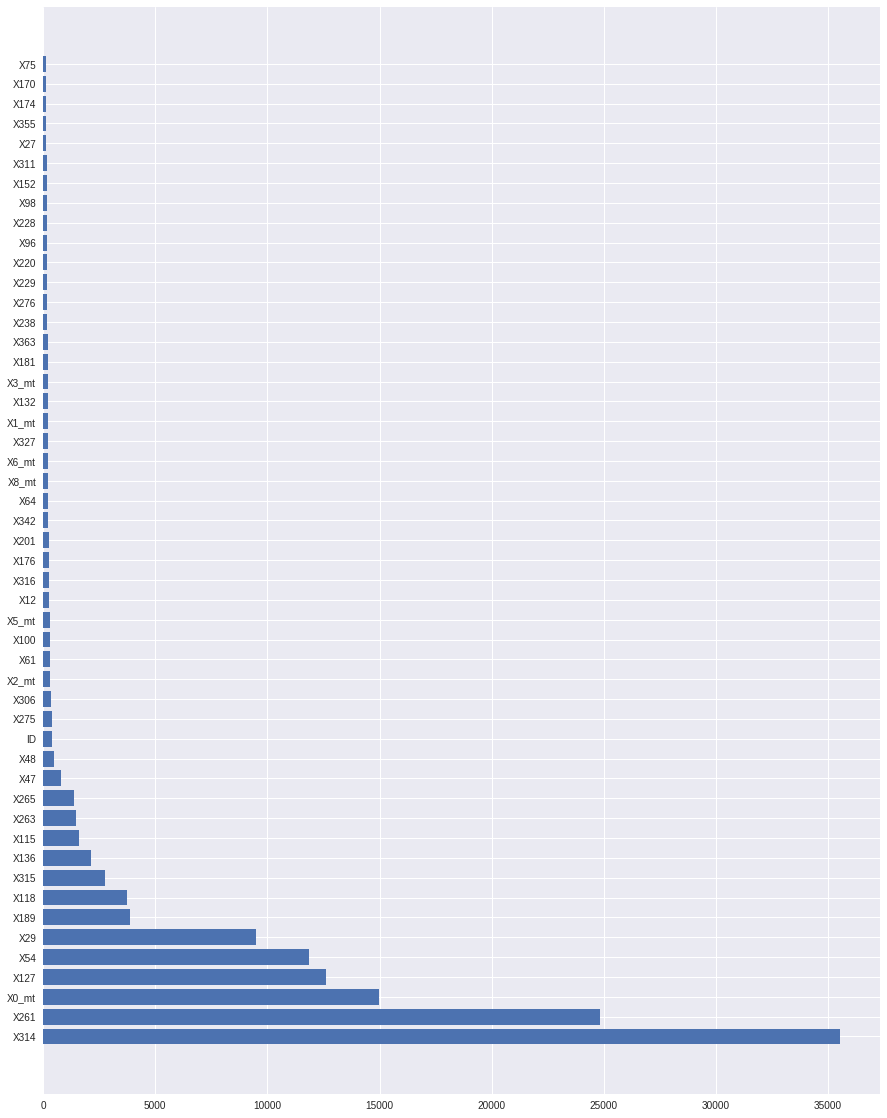

In [135]:
plt.figure(figsize=(15,20))
plt.barh(range(1,51), [f[1] for f in gain_importances[:50]], tick_label=[f[0] for f in gain_importances[:50]])

In [0]:
# We take 20 most important features based on gain 
gimp_feat = [f[0] for f in gain_importances[:20]]

In [0]:
s_time = time.time()

# drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
drop_feat = [f for f in trns[0].columns if f not in gimp_feat]
val_scores = []
trn_scores = []
best_iterations = []
# weight_importances = {}
# gain_importances = {}
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)
  
#   wimp = model.get_score('xgb.fmap', 'weight')
#   gimp = model.get_score('xgb.fmap', 'gain')
#   for key, value in wimp.items():
#     if key in weight_importances.keys(): weight_importances[key] += wimp[key]
#     else : weight_importances[key] = wimp[key]
#   for key, value in gimp.items():
#     if key in gain_importances.keys(): gain_importances[key] += gimp[key]
#     else : gain_importances[key] = gimp[key] 
#   break
print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [144]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()

(0.57567358, 0.6543699000000001, 209.68)

Here also scores have improved. All we need to do is to select right features based on weights and gains. First lets submit a model on 20 most important features based on gain and see how it fares on leaderboard. 

### Submission

In [54]:
me_cols = cat_feat
train_new = train[train_ol.is_ol==False]
test_new = test.copy()
for col in me_cols : 
  means = train_new.groupby(col)['y'].mean()
  train_new[col+'_mt'] = train_new[col].map(means)
  test_new[col+'_mt'] = test_new[col].map(means)

test_new.fillna(train_new['y'].mean(), inplace=True)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [55]:
# let's regularise train_new

train_new1 = train_new.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
for ti, vi in kf.split(train_new):
  trn, val = train_new.iloc[ti], train_new.iloc[vi]
  for col in me_cols:
    means = trn.groupby(col)['y'].mean()
    val[col+'_mt'] = val[col].map(means)
  train_new1.iloc[vi] = val
train_new1.fillna(train_new['y'].mean(), inplace=True)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [0]:
# feat_to_drop = list(set(['y'] + cat_feat + dup_feat + low_var_feat))

X_trn = train_new1[gimp_feat]
y_trn = train_new1['y']
X_test = test_new[X_trn.columns]
dtrn = xgb.DMatrix(X_trn, label=y_trn)
dtest = xgb.DMatrix(X_test)

In [0]:
params = {'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'seed' : rs,
 'subsample': 0.97}

In [0]:
y_pred = np.empty(shape=(10, test.shape[0]))
params['seed'] = rs
for i in range(10):
  params['seed'] += i
  model = xgb.train(params, dtrn, 210)
  preds = model.predict(dtest)
  y_pred[i] = preds


In [0]:
subm = np.stack((test.ID, y_pred.mean(axis=0)), axis=1)
np.savetxt('drive/workspace/data/merc/subm30.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

PrivateLB : 0.55231   PublicLB : 0.55534 . So this score is the highest till now and this means that we need to do some agressive feature selection. 

#### Tuning

In [42]:
print (weight_importances[:20])
print (gain_importances[:20])

[('X0_mt', 129), ('ID', 103), ('X5_mt', 46), ('X47', 39), ('X1_mt', 36), ('X6_mt', 36), ('X8_mt', 34), ('X2_mt', 25), ('X3_mt', 19), ('X29', 19), ('X315', 16), ('X342', 12), ('X275', 8), ('X314', 8), ('X118', 7), ('X306', 6), ('X351', 6), ('X201', 6), ('X316', 6), ('X189', 5)]
[('X314', 35554.0), ('X261', 24839.0), ('X0_mt', 14991.0), ('X127', 12616.0), ('X54', 11875.0), ('X29', 9500.0), ('X189', 3884.0), ('X118', 3755.0), ('X315', 2762.0), ('X136', 2143.0), ('X115', 1615.0), ('X263', 1469.0), ('X265', 1356.0), ('X47', 810.0), ('X48', 490.0), ('ID', 413.0), ('X275', 373.0), ('X306', 330.0), ('X2_mt', 321.0), ('X61', 312.0)]


Important Binary features based on weight. 

In [45]:
train['X29'].sum(), train['X315'].sum(), train['X342'].sum(), train['X275'].sum(), train['X314'].sum()

(181, 121, 94, 3059, 1817)

In [46]:
train['X306'].sum(), train['X351'].sum(), train['X201'].sum(), train['X316'].sum(), train['X189'].sum()

(184, 1251, 748, 823, 3853)

Important Binary features based on Gain

In [47]:
train['X314'].sum(), train['X261'].sum(), train['X127'].sum(), train['X54'].sum(), train['X29'].sum()

(1817, 1766, 2084, 183, 181)

In [48]:
train['X189'].sum(), train['X118'].sum(), train['X315'].sum(), train['X136'].sum(), train['X115'].sum()

(3853, 2619, 121, 4026, 1202)

In [49]:
train['X263'].sum(), train['X265'].sum(), train['X47'].sum(), train['X48'].sum(), train['X275'].sum()

(4028, 3811, 54, 94, 3059)

In [50]:
train['X306'].sum(), train['X61'].sum()

(184, 4015)

In [0]:
me_feat = [f+'_mt' for f in cat_feat] + ['y']

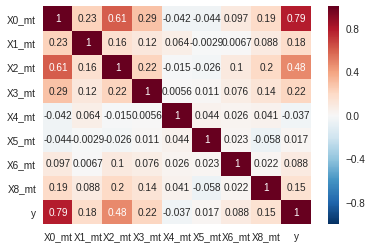

In [59]:
sns.heatmap(train_new1[me_feat].corr(), annot=True)

y is highly correlated with X0_mt and X2_mt. Also we see that X0_mt is correlated with X2_mt which makes sense. So we can try to drop X2_mt and keep X0_mt only. 

Next let's add 6 more features from gain_importances and drop X2_mt and see if we improve score by dropping features. 

In [0]:
gimp_feat = [f[0] for f in gain_importances[:26]]
gimp_feat.remove('X2_mt')

In [0]:
s_time = time.time()

# drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
drop_feat = [f for f in trns[0].columns if f not in gimp_feat]
val_scores = []
trn_scores = []
best_iterations = []
# weight_importances = {}
# gain_importances = {}
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)
  
#   wimp = model.get_score('xgb.fmap', 'weight')
#   gimp = model.get_score('xgb.fmap', 'gain')
#   for key, value in wimp.items():
#     if key in weight_importances.keys(): weight_importances[key] += wimp[key]
#     else : weight_importances[key] = wimp[key]
#   for key, value in gimp.items():
#     if key in gain_importances.keys(): gain_importances[key] += gimp[key]
#     else : gain_importances[key] = gimp[key] 
#   break
print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [63]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()

(0.5771797399999999, 0.6585116799999998, 260.32)

Let's now use features only from weight importances. Previously we saw score form only top 20 features, now let's see from top 25 features, excluding X2_mt. 

In [69]:
wimp_feat = [f[0] for f in weight_importances[:25]]
wimp_feat.remove('X2_mt')
len(wimp_feat)

24

In [0]:
s_time = time.time()

# drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
drop_feat = [f for f in trns[0].columns if f not in wimp_feat]
val_scores = []
trn_scores = []
best_iterations = []
# weight_importances = {}
# gain_importances = {}
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)
  
#   wimp = model.get_score('xgb.fmap', 'weight')
#   gimp = model.get_score('xgb.fmap', 'gain')
#   for key, value in wimp.items():
#     if key in weight_importances.keys(): weight_importances[key] += wimp[key]
#     else : weight_importances[key] = wimp[key]
#   for key, value in gimp.items():
#     if key in gain_importances.keys(): gain_importances[key] += gimp[key]
#     else : gain_importances[key] = gimp[key] 
#   break
print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [71]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()

(0.57656672, 0.66173614, 256.22)

Let's now continue including more features based on weights and see where we get the highest score. 

In [73]:
wimp_feat = [f[0] for f in weight_importances[:35]]
wimp_feat.remove('X2_mt')
len(wimp_feat)

34

In [0]:
s_time = time.time()

# drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
drop_feat = [f for f in trns[0].columns if f not in wimp_feat]
val_scores = []
trn_scores = []
best_iterations = []
# weight_importances = {}
# gain_importances = {}
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)
  
#   wimp = model.get_score('xgb.fmap', 'weight')
#   gimp = model.get_score('xgb.fmap', 'gain')
#   for key, value in wimp.items():
#     if key in weight_importances.keys(): weight_importances[key] += wimp[key]
#     else : weight_importances[key] = wimp[key]
#   for key, value in gimp.items():
#     if key in gain_importances.keys(): gain_importances[key] += gimp[key]
#     else : gain_importances[key] = gimp[key] 
#   break
print ("Time Taken : {0} seconds".format(time.time()-s_time))


In [76]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()

(0.5760479799999999, 0.6605793600000002, 237.88)

So the score reduced so value lies between 20 to 34. 

In [79]:
wimp_feat = [f[0] for f in weight_importances[:30]]
wimp_feat.remove('X2_mt')
len(wimp_feat)

29

In [0]:
s_time = time.time()

# drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
drop_feat = [f for f in trns[0].columns if f not in wimp_feat]
val_scores = []
trn_scores = []
best_iterations = []
# weight_importances = {}
# gain_importances = {}
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)
  
#   wimp = model.get_score('xgb.fmap', 'weight')
#   gimp = model.get_score('xgb.fmap', 'gain')
#   for key, value in wimp.items():
#     if key in weight_importances.keys(): weight_importances[key] += wimp[key]
#     else : weight_importances[key] = wimp[key]
#   for key, value in gimp.items():
#     if key in gain_importances.keys(): gain_importances[key] += gimp[key]
#     else : gain_importances[key] = gimp[key] 
#   break
print ("Time Taken : {0} seconds".format(time.time()-s_time))


In [81]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()

(0.5760700599999999, 0.6609123, 242.02)

So as we see that top 25 features(excluding X2_mt) based on weights provide the best score. Let' now find the best no of features based on gain. 

In [84]:
gimp_feat = [f[0] for f in gain_importances[:31]]
gimp_feat.remove('X2_mt')
len(gimp_feat)

30

In [0]:
s_time = time.time()

# drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
drop_feat = [f for f in trns[0].columns if f not in gimp_feat]
val_scores = []
trn_scores = []
best_iterations = []
# weight_importances = {}
# gain_importances = {}
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)
  
#   wimp = model.get_score('xgb.fmap', 'weight')
#   gimp = model.get_score('xgb.fmap', 'gain')
#   for key, value in wimp.items():
#     if key in weight_importances.keys(): weight_importances[key] += wimp[key]
#     else : weight_importances[key] = wimp[key]
#   for key, value in gimp.items():
#     if key in gain_importances.keys(): gain_importances[key] += gimp[key]
#     else : gain_importances[key] = gimp[key] 
#   break
print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [86]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()

(0.57658592, 0.6617380800000001, 265.08)

In [87]:
gimp_feat = [f[0] for f in gain_importances[:24]]
gimp_feat.remove('X2_mt')
len(gimp_feat)

23

In [0]:
s_time = time.time()

# drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
drop_feat = [f for f in trns[0].columns if f not in gimp_feat]
val_scores = []
trn_scores = []
best_iterations = []
# weight_importances = {}
# gain_importances = {}
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)
  
#   wimp = model.get_score('xgb.fmap', 'weight')
#   gimp = model.get_score('xgb.fmap', 'gain')
#   for key, value in wimp.items():
#     if key in weight_importances.keys(): weight_importances[key] += wimp[key]
#     else : weight_importances[key] = wimp[key]
#   for key, value in gimp.items():
#     if key in gain_importances.keys(): gain_importances[key] += gimp[key]
#     else : gain_importances[key] = gimp[key] 
#   break
print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [89]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()

(0.57672968, 0.6567484, 238.98)

In [92]:
gimp_feat = [f[0] for f in gain_importances[:28]]
gimp_feat.remove('X2_mt')
len(gimp_feat)

27

In [0]:
s_time = time.time()

# drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
drop_feat = [f for f in trns[0].columns if f not in gimp_feat]
val_scores = []
trn_scores = []
best_iterations = []
# weight_importances = {}
# gain_importances = {}
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)
  
#   wimp = model.get_score('xgb.fmap', 'weight')
#   gimp = model.get_score('xgb.fmap', 'gain')
#   for key, value in wimp.items():
#     if key in weight_importances.keys(): weight_importances[key] += wimp[key]
#     else : weight_importances[key] = wimp[key]
#   for key, value in gimp.items():
#     if key in gain_importances.keys(): gain_importances[key] += gimp[key]
#     else : gain_importances[key] = gimp[key] 
#   break
print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [94]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()

(0.57719168, 0.6589867199999999, 251.76)

So 27 top features based on gain give the highest score. Let's combine both : top features based on weights and gain. 

In [98]:
gimp = [f[0] for f in gain_importances[:28] ]
wimp = [f[0] for f in weight_importances[:25] ]
feat_to_include = list(set(gimp+wimp))
feat_to_include.remove('X2_mt')
len(feat_to_include)

35

In [0]:
s_time = time.time()

# drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
drop_feat = [f for f in trns[0].columns if f not in feat_to_include]
val_scores = []
trn_scores = []
best_iterations = []
# weight_importances = {}
# gain_importances = {}
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)
  
#   wimp = model.get_score('xgb.fmap', 'weight')
#   gimp = model.get_score('xgb.fmap', 'gain')
#   for key, value in wimp.items():
#     if key in weight_importances.keys(): weight_importances[key] += wimp[key]
#     else : weight_importances[key] = wimp[key]
#   for key, value in gimp.items():
#     if key in gain_importances.keys(): gain_importances[key] += gimp[key]
#     else : gain_importances[key] = gimp[key] 
#   break
print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [101]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()

(0.5767300399999999, 0.66259584, 259.9)

In [102]:
len(gimp), len(wimp)

(28, 25)

In [0]:
f1 = [f for f in gimp if f not in wimp]
f2 = [f for f in wimp if f not in gimp]

In [109]:
weight_importances[:20]

[('X0_mt', 129),
 ('ID', 103),
 ('X5_mt', 46),
 ('X47', 39),
 ('X1_mt', 36),
 ('X6_mt', 36),
 ('X8_mt', 34),
 ('X2_mt', 25),
 ('X3_mt', 19),
 ('X29', 19),
 ('X315', 16),
 ('X342', 12),
 ('X275', 8),
 ('X314', 8),
 ('X118', 7),
 ('X306', 6),
 ('X351', 6),
 ('X201', 6),
 ('X316', 6),
 ('X189', 5)]

In [110]:
f2

['X1_mt', 'X6_mt', 'X8_mt', 'X3_mt', 'X351', 'X181', 'X203', 'X152']

Let's only include X1_mt, X6_mt and X8_mt in addition to features in gimp as they have a high score in weight importances. 

In [111]:
gimp = [f[0] for f in gain_importances[:28] ]
wimp = ['X1_mt', 'X6_mt', 'X8_mt']
feat_to_include = list(set(gimp+wimp))
feat_to_include.remove('X2_mt')
len(feat_to_include)

30

In [0]:
s_time = time.time()

# drop_feat = cat_feat+['y']+list(set(low_var_feat+dup_feat))
drop_feat = [f for f in trns[0].columns if f not in feat_to_include]
val_scores = []
trn_scores = []
best_iterations = []
# weight_importances = {}
# gain_importances = {}
for i in range(len(trns)) : 
  print ("Train no : {0}".format(i))
  trn, val = trns[i], vals[i]

  il_index = [i for i in trn.index if i in train_ol[train_ol.is_ol==False].index]
  trn_il = trn.loc[il_index]

  dtrn, dval = get_trn_val(trn_il, val, drop_feat)
  watchlist = [(dtrn, 'train'), (dval, 'eval')]
  model = xgb.train(params, dtrn, 5000, watchlist, early_stopping_rounds=50, feval=xgb_r2_score, maximize=True)
  ti = model.attributes()['best_msg'].find('train-r2_score')
  vi = model.attributes()['best_msg'].find('eval-r2_score')
  t_score = float(model.attributes()['best_msg'][ti+15:vi-1])
  v_score = float(model.attributes()['best_msg'][vi+14:])
  num_rounds = int(model.attributes()['best_iteration'])
  
  trn_scores.append(t_score)
  val_scores.append(v_score)
  best_iterations.append(num_rounds)
  
#   wimp = model.get_score('xgb.fmap', 'weight')
#   gimp = model.get_score('xgb.fmap', 'gain')
#   for key, value in wimp.items():
#     if key in weight_importances.keys(): weight_importances[key] += wimp[key]
#     else : weight_importances[key] = wimp[key]
#   for key, value in gimp.items():
#     if key in gain_importances.keys(): gain_importances[key] += gimp[key]
#     else : gain_importances[key] = gimp[key] 
#   break
print ("Time Taken : {0} seconds".format(time.time()-s_time))

In [113]:
np.array(val_scores).mean(), np.array(trn_scores).mean(), np.array(best_iterations).mean()

(0.5765886800000001, 0.6620829400000001, 259.54)

Looks like this isn't working. Anyway let's submit our best scores with 27 top features excludingX2_mt based on gain. 

In [114]:
gimp_feat = [f[0] for f in gain_importances[:28]]
gimp_feat.remove('X2_mt')
len(gimp_feat)

27

In [115]:
me_cols = cat_feat
train_new = train[train_ol.is_ol==False]
test_new = test.copy()
for col in me_cols : 
  means = train_new.groupby(col)['y'].mean()
  train_new[col+'_mt'] = train_new[col].map(means)
  test_new[col+'_mt'] = test_new[col].map(means)

test_new.fillna(train_new['y'].mean(), inplace=True)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [116]:
# let's regularise train_new

train_new1 = train_new.copy()

kf = KFold(n_splits=5, shuffle=True, random_state=rs)
for ti, vi in kf.split(train_new):
  trn, val = train_new.iloc[ti], train_new.iloc[vi]
  for col in me_cols:
    means = trn.groupby(col)['y'].mean()
    val[col+'_mt'] = val[col].map(means)
  train_new1.iloc[vi] = val
train_new1.fillna(train_new['y'].mean(), inplace=True)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [0]:
# feat_to_drop = list(set(['y'] + cat_feat + dup_feat + low_var_feat))

X_trn = train_new1[gimp_feat]
y_trn = train_new1['y']
X_test = test_new[X_trn.columns]
dtrn = xgb.DMatrix(X_trn, label=y_trn)
dtest = xgb.DMatrix(X_test)

In [0]:
params = {'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'seed' : rs,
 'subsample': 0.97}

In [0]:
y_pred = np.empty(shape=(10, test.shape[0]))
params['seed'] = rs
for i in range(10):
  params['seed'] += i
  model = xgb.train(params, dtrn, 255)
  preds = model.predict(dtest)
  y_pred[i] = preds


In [0]:
subm = np.stack((test.ID, y_pred.mean(axis=0)), axis=1)
np.savetxt('drive/workspace/data/merc/subm31.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

PrivateLB : 0.55013   PublicLB : 0.55521  Let's submit another one with gimp=26-1


In [124]:
gimp_feat = [f[0] for f in gain_importances[:26]]
gimp_feat.remove('X2_mt')
len(gimp_feat)

25

In [0]:
# feat_to_drop = list(set(['y'] + cat_feat + dup_feat + low_var_feat))

X_trn = train_new1[gimp_feat]
y_trn = train_new1['y']
X_test = test_new[X_trn.columns]
dtrn = xgb.DMatrix(X_trn, label=y_trn)
dtest = xgb.DMatrix(X_test)

In [0]:
params = {'colsample_bytree': 0.75,
 'eval_metric': 'rmse',
 'eta' : 0.05,
 'gamma': 19,
 'max_depth': 2,
 'min_child_weight': 13,
 'silent': 1,
 'seed' : rs,
 'subsample': 0.97}

In [0]:
y_pred = np.empty(shape=(10, test.shape[0]))
params['seed'] = rs
for i in range(10):
  params['seed'] += i
  model = xgb.train(params, dtrn, 270)
  preds = model.predict(dtest)
  y_pred[i] = preds


In [0]:
subm = np.stack((test.ID, y_pred.mean(axis=0)), axis=1)
np.savetxt('drive/workspace/data/merc/subm32.csv', subm, delimiter=',', comments='', header='ID,y', fmt=['%d', '%.6f'])

PrivateLB :    PublicLB : 